<a href="https://colab.research.google.com/github/mohit-bags/Arrhythmia-Detection/blob/main/Arrhythmia_Detection_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trying https://github.com/spdrnl/ecg/blob/master/ECG.ipynb

In [3]:
!pip install -q -U tensorflow_addons
!pip install hrv-analysis
!pip install neurokit2
!pip3 install py-ecg-detectors

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import tensorflow_addons
from tensorflow_addons.optimizers import CyclicalLearningRate
import tensorflow_addons as tfa
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams["figure.figsize"] = (13,4)

import matplotlib.pyplot as plt 
from os import listdir 
import requests
import matplotlib.pyplot as plt
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import json
import os
from tqdm import tqdm
from matplotlib import collections as matcoll
import pywt

In [ ]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

In [6]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

In [7]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()

In [8]:
from ecgdetectors import Detectors
import neurokit2 as nk
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
from hrvanalysis import get_time_domain_features
detectors = Detectors(500) #specify sampling rate

In [21]:
# rr_intervals_list contains integer values of RR-interval
rr_intervals_list = [152, 678, 1138, 1662, 2113, 2596, 3053, 3563, 4007, 4475, 4934]

# This remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list,  low_rri=100, high_rri=5000)
# This replace outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,
                                                   interpolation_method="linear")
# This remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
# This replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

time_domain_features = get_time_domain_features(nn_intervals_list)
time_domain_features

0 outlier(s) have been deleted.
3 ectopic beat(s) have been deleted with malik rule.


{'cvnni': nan,
 'cvsd': nan,
 'max_hr': 394.7368421052632,
 'mean_hr': nan,
 'mean_nni': nan,
 'median_nni': nan,
 'min_hr': 12.160518848804216,
 'nni_20': 4,
 'nni_50': 4,
 'pnni_20': 40.0,
 'pnni_50': 40.0,
 'range_nni': 4782,
 'rmssd': nan,
 'sdnn': nan,
 'sdsd': nan,
 'std_hr': nan}

In [39]:


# master_file[master_file['FileName']=='MUSE_20180113_171327_27000']['VentricularRate']
master_file[master_file['FileName']=='MUSE_20180113_171327_27000']['AtrialRate'].iloc[0]


234

In [49]:
def plot_rr(rrintervals,rr_diff):
  x = rrintervals/500
  y = rr_diff
  lines = []
  for i in range(len(x)):
      pair=[(x[i],0), (x[i], y[i])]
      lines.append(pair)

  linecoll = matcoll.LineCollection(lines)
  fig, ax = plt.subplots()
  ax.add_collection(linecoll)

  plt.scatter(x,y)
  plt.xticks(x)
  plt.xlabel("Time (s)")
  plt.ylim(0,1)
  plt.title("RR Peaks")
  plt.show()


master_file = pd.read_excel("/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx")

def detect_r_peaks_pan_tompkins_detector(patient_list,case,detector,showplots=False):
    parent_folder = '/content/ECGDataDenoised/'
    # mxx=0
    data_with_rr = pd.DataFrame()
    patient_col_id = []
    case_name = []
    vr = []
    ar = []
    for i in tqdm(patient_list):
      # try:
        patient_col_id.append(i)
        case_name.append(case)
        file_name=parent_folder+i
        df = pd.read_csv(file_name+".csv",header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce') 
        
        # Extract R-peaks locations using pan_tompkins_detector
        unfiltered_ecg=df["aVL"]
        if(detector=="pan_tompkins"):
          rpeaks = detectors.pan_tompkins_detector(unfiltered_ecg)
        elif(detector=="stationary_wavelet_transform"):
          rpeaks = detectors.swt_detector(unfiltered_ecg)

        # print(rpeaks)
        # rr_intervals_list=rpeaks
        # # This remove outliers from signal
        # rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list,  
        #                                                 low_rri=100, high_rri=5000)
        # # This replace outliers nan values with linear interpolation
        # interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,
        #                                                   interpolation_method="linear")

        # # This remove ectopic beats from signal
        # nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
        # # This replace ectopic beats nan values with linear interpolation
        # interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

        # # nn_intervals_list contains integer values of NN-interval
        time_domain_features = get_time_domain_features(rpeaks)
        # print(time_domain_features)
        time_dom_features_df = pd.DataFrame.from_dict(time_domain_features, orient='index').transpose()


        rrintervals = np.array(rpeaks)
        rr_diff=np.diff(rpeaks)/1000

        rr_diff = np.pad(rr_diff, (0, 30-len(rr_diff)), 'constant', 
                 constant_values=(0,0)) #padded to make length 30 for all
        
        rr_in_df = pd.DataFrame(rr_diff).transpose()
        rr_in_df = pd.concat([rr_in_df,time_dom_features_df], axis=1)
        data_with_rr=data_with_rr.append(rr_in_df)


        if(showplots): # Visualize R-peaks in ECG signal
          print("\n****",i,"****\n")
          plot = (nk.events_plot(rpeaks, df["aVL"]))
          plot_rr(rrintervals,rr_diff)
          

        vr.append(master_file[master_file['FileName']==i]['VentricularRate'].iloc[0])
        ar.append(master_file[master_file['FileName']==i]['AtrialRate'].iloc[0])

      # except:
      #   print("\n ##### Error in:",i,"#####\n")
    print("\n")
    data_with_rr['filename']=patient_col_id
    data_with_rr['label']=case_name
    data_with_rr['VentricularRate']=vr
    data_with_rr['AtrialRate']=ar
    return data_with_rr

In [50]:
nsr_rr=detect_r_peaks_pan_tompkins_detector(nsr_files,"nsr","pan_tompkins",False)

  0%|          | 4/1826 [00:00<00:57, 31.66it/s]

{'mean_nni': 2579.181818181818, 'sdnn': 1581.5151480894401, 'sdsd': 29.290954235053526, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 479.09623250449386, 'median_nni': 2596.0, 'range_nni': 4782, 'cvsd': 0.1857551216929059, 'cvnni': 0.6131848235516493, 'mean_hr': 63.69094387981733, 'max_hr': 394.7368421052632, 'min_hr': 12.160518848804216, 'std_hr': 106.88652845673101}
{'mean_nni': 2265.0, 'sdnn': 1560.7276409517353, 'sdsd': 85.46538106711246, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.9185367469546, 'median_nni': 2204.5, 'range_nni': 4612, 'cvsd': 0.16111193675362234, 'cvnni': 0.6890629761376315, 'mean_hr': 72.78008154627283, 'max_hr': 384.61538461538464, 'min_hr': 12.583892617449665, 'std_hr': 100.14045331177215}
{'mean_nni': 2328.846153846154, 'sdnn': 1491.0746038877378, 'sdsd': 60.92134044997879, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 377.5311245447188, 'median_nni': 2317.0, 'range_nni': 4

  1%|          | 16/1826 [00:00<00:54, 33.11it/s]

{'mean_nni': 2438.0, 'sdnn': 1618.2551770909984, 'sdsd': 91.36666661641455, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 441.9119616147336, 'median_nni': 2409.5, 'range_nni': 4756, 'cvsd': 0.18126003347610076, 'cvnni': 0.6637634032366687, 'mean_hr': 66.04205895806511, 'max_hr': 329.6703296703297, 'min_hr': 12.15066828675577, 'std_hr': 91.35551277593626}
{'mean_nni': 2419.9, 'sdnn': 1526.982823886518, 'sdsd': 17.190292982945525, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 502.07215063618537, 'median_nni': 2432.5, 'range_nni': 4516, 'cvsd': 0.20747640424653305, 'cvnni': 0.6310107127924781, 'mean_hr': 64.67571961568946, 'max_hr': 352.94117647058823, 'min_hr': 12.804097311139564, 'std_hr': 98.80906049799363}
{'mean_nni': 2293.3636363636365, 'sdnn': 1534.4928330055682, 'sdsd': 92.32058275379332, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 457.5114206224802, 'median_nni': 2264.0, 'range_nni': 4481, 'cvsd': 0.

  1%|▏         | 24/1826 [00:00<00:53, 33.88it/s]

{'mean_nni': 2387.6875, 'sdnn': 1490.2434127237962, 'sdsd': 40.2685430026411, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 308.30774668611014, 'median_nni': 2367.5, 'range_nni': 4585, 'cvsd': 0.12912399410982808, 'cvnni': 0.6241367066351003, 'mean_hr': 62.10484970539519, 'max_hr': 370.3703703703704, 'min_hr': 12.639561828523277, 'std_hr': 90.32614810304815}
{'mean_nni': 2670.285714285714, 'sdnn': 1465.509280267256, 'sdsd': 35.49547850195628, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.3874296324156, 'median_nni': 2671.5, 'range_nni': 4610, 'cvsd': 0.13346415618590354, 'cvnni': 0.5488211513947566, 'mean_hr': 39.02416878056423, 'max_hr': 177.5147928994083, 'min_hr': 12.126111560226354, 'std_hr': 42.260083515889285}
{'mean_nni': 2570.133333333333, 'sdnn': 1507.6780570829849, 'sdsd': 28.12336163028444, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.0968045516543, 'median_nni': 2613.0, 'range_nni': 47

  2%|▏         | 28/1826 [00:00<00:55, 32.62it/s]

{'mean_nni': 2197.4, 'sdnn': 1513.9312024376422, 'sdsd': 144.59436576936497, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 369.8636814518869, 'median_nni': 2105.0, 'range_nni': 4766, 'cvsd': 0.16831877739687218, 'cvnni': 0.6889647776634396, 'mean_hr': 68.44145527645058, 'max_hr': 392.15686274509807, 'min_hr': 12.197601138442772, 'std_hr': 97.37339190606178}
{'mean_nni': 2576.818181818182, 'sdnn': 1500.525162613531, 'sdsd': 83.6483113995734, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 447.4876534609642, 'median_nni': 2510.0, 'range_nni': 4396, 'cvsd': 0.1736589941107993, 'cvnni': 0.5823170502292764, 'mean_hr': 37.400864477631984, 'max_hr': 117.6470588235294, 'min_hr': 12.22992254382389, 'std_hr': 30.69092784690288}
{'mean_nni': 2490.076923076923, 'sdnn': 1583.3031643549539, 'sdsd': 39.186165359161585, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.5831171750127, 'median_nni': 2480.0, 'range_nni': 4796,

  2%|▏         | 36/1826 [00:01<00:55, 32.24it/s]

{'mean_nni': 2454.6666666666665, 'sdnn': 1611.9289028610376, 'sdsd': 95.63074646483466, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 443.25705655050564, 'median_nni': 2442.0, 'range_nni': 4761, 'cvsd': 0.1805772908272022, 'cvnni': 0.656679346629972, 'mean_hr': 70.6897200728564, 'max_hr': 379.746835443038, 'min_hr': 12.197601138442772, 'std_hr': 105.03341928593751}
{'mean_nni': 2537.0, 'sdnn': 1511.7783026501063, 'sdsd': 32.40778398486878, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 425.3273605546246, 'median_nni': 2555.5, 'range_nni': 4665, 'cvsd': 0.167649728243841, 'cvnni': 0.5958921177178188, 'mean_hr': 60.334181514052865, 'max_hr': 384.61538461538464, 'min_hr': 12.445550715619166, 'std_hr': 100.05283627131055}
{'mean_nni': 2411.0, 'sdnn': 1537.3355521811106, 'sdsd': 31.753582475053115, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 461.19442754656086, 'median_nni': 2364.0, 'range_nni': 4601, 'cvsd': 

  2%|▏         | 44/1826 [00:01<00:56, 31.39it/s]

{'mean_nni': 2488.181818181818, 'sdnn': 1509.188577890902, 'sdsd': 4.006245124802026, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 454.51765642271806, 'median_nni': 2490.0, 'range_nni': 4545, 'cvsd': 0.18267059629703686, 'cvnni': 0.6065427240336106, 'mean_hr': 53.990603812160835, 'max_hr': 279.06976744186045, 'min_hr': 12.605042016806722, 'std_hr': 74.40845430195391}
{'mean_nni': 2309.823529411765, 'sdnn': 1398.010024789438, 'sdsd': 101.50854335966012, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 304.3045349645647, 'median_nni': 2258.0, 'range_nni': 4590, 'cvsd': 0.13174362936811063, 'cvnni': 0.6052453821636602, 'mean_hr': 60.02969633133767, 'max_hr': 375.0, 'min_hr': 12.631578947368421, 'std_hr': 88.33392223835415}
{'mean_nni': 2358.0833333333335, 'sdnn': 1611.353155712379, 'sdsd': 106.33231862172043, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 446.1298221166325, 'median_nni': 2257.5, 'range_nni': 476

  3%|▎         | 52/1826 [00:01<00:54, 32.69it/s]

{'mean_nni': 2355.3846153846152, 'sdnn': 1501.6545618340201, 'sdsd': 64.97221628426176, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.24379776375815, 'median_nni': 2325.0, 'range_nni': 4508, 'cvsd': 0.1618605281165531, 'cvnni': 0.6375411268400478, 'mean_hr': 64.08256177685851, 'max_hr': 338.9830508474576, 'min_hr': 12.8068303094984, 'std_hr': 89.5526610468399}
{'mean_nni': 2393.8333333333335, 'sdnn': 1541.7930431412601, 'sdsd': 64.26263261346537, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 422.5515568327943, 'median_nni': 2369.5, 'range_nni': 4594, 'cvsd': 0.17651669853072238, 'cvnni': 0.6440686666328456, 'mean_hr': 63.03497835374353, 'max_hr': 327.8688524590164, 'min_hr': 12.560184216035168, 'std_hr': 87.89493354586726}
{'mean_nni': 2461.909090909091, 'sdnn': 1553.7320524817305, 'sdsd': 34.83403508065065, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 467.0009635964363, 'median_nni': 2449.0, 'range_n

  3%|▎         | 60/1826 [00:01<00:55, 32.01it/s]

{'mean_nni': 2212.25, 'sdnn': 1595.071279399023, 'sdsd': 124.23957129023007, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.4173736689804, 'median_nni': 2123.0, 'range_nni': 4579, 'cvsd': 0.1963690241469004, 'cvnni': 0.7210176423998296, 'mean_hr': 77.09598602224264, 'max_hr': 365.8536585365854, 'min_hr': 12.65022137887413, 'std_hr': 101.10348609347636}
{'mean_nni': 2268.4545454545455, 'sdnn': 1535.4151467037418, 'sdsd': 99.38893298551908, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 457.1352097574633, 'median_nni': 2215.0, 'range_nni': 4462, 'cvsd': 0.2015183467852401, 'cvnni': 0.6768551522358498, 'mean_hr': 76.03879807841764, 'max_hr': 384.61538461538464, 'min_hr': 12.9926375054136, 'std_hr': 108.83238178631375}
{'mean_nni': 2421.0666666666666, 'sdnn': 1532.6417653686658, 'sdsd': 53.15768802269685, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 336.44029400262303, 'median_nni': 2406.0, 'range_nni': 465

  4%|▎         | 64/1826 [00:01<00:55, 31.65it/s]

{'mean_nni': 2347.6153846153848, 'sdnn': 1521.7007227913082, 'sdsd': 64.50366053350943, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.7926957790277, 'median_nni': 2330.0, 'range_nni': 4540, 'cvsd': 0.16348193076861497, 'cvnni': 0.6481899602309055, 'mean_hr': 68.54293599262735, 'max_hr': 379.746835443038, 'min_hr': 12.77139208173691, 'std_hr': 99.99210054667157}
{'mean_nni': 2243.6666666666665, 'sdnn': 1613.7772367018224, 'sdsd': 126.69146487718608, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 439.64955052032894, 'median_nni': 2183.5, 'range_nni': 4631, 'cvsd': 0.1959513670421909, 'cvnni': 0.7192589080531077, 'mean_hr': 74.83341771316955, 'max_hr': 350.87719298245617, 'min_hr': 12.494793835901708, 'std_hr': 96.93783674913182}
{'mean_nni': 2511.0, 'sdnn': 1576.2569587475261, 'sdsd': 18.5310550158376, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 473.3628629286417, 'median_nni': 2503.0, 'range_nni': 4730

  4%|▍         | 72/1826 [00:02<00:54, 32.15it/s]

{'mean_nni': 2512.3333333333335, 'sdnn': 1534.1622966234545, 'sdsd': 26.919096476331458, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 341.9896614978713, 'median_nni': 2515.0, 'range_nni': 4773, 'cvsd': 0.13612431796386013, 'cvnni': 0.6106523669723183, 'mean_hr': 59.28402865704782, 'max_hr': 384.61538461538464, 'min_hr': 12.172854534388314, 'std_hr': 92.7001467692789}
{'mean_nni': 2564.076923076923, 'sdnn': 1566.3058163259211, 'sdsd': 19.61858529274955, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.14668971171466, 'median_nni': 2530.0, 'range_nni': 4808, 'cvsd': 0.15644877347530348, 'cvnni': 0.6108653770208795, 'mean_hr': 54.883315770773365, 'max_hr': 326.0869565217391, 'min_hr': 12.01923076923077, 'std_hr': 81.86448345237761}
{'mean_nni': 2466.4615384615386, 'sdnn': 1595.4741518529122, 'sdsd': 58.69761257685206, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.8715761229057, 'median_nni': 2454.0, 'ra

  4%|▍         | 80/1826 [00:02<00:53, 32.56it/s]

{'mean_nni': 2490.5454545454545, 'sdnn': 1529.4483556914474, 'sdsd': 8.059776671843954, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 461.8703281225154, 'median_nni': 2499.0, 'range_nni': 4618, 'cvsd': 0.1854494674166911, 'cvnni': 0.6141017634912368, 'mean_hr': 62.19983703768232, 'max_hr': 365.8536585365854, 'min_hr': 12.547051442910917, 'std_hr': 98.66446306362074}
{'mean_nni': 2500.3333333333335, 'sdnn': 1583.8485541314367, 'sdsd': 51.120825922271706, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.4518155283973, 'median_nni': 2509.5, 'range_nni': 4779, 'cvsd': 0.1749573985582178, 'cvnni': 0.6334549609911092, 'mean_hr': 63.01064824534139, 'max_hr': 361.4457831325301, 'min_hr': 12.133468149646108, 'std_hr': 95.53250357518445}
{'mean_nni': 2329.923076923077, 'sdnn': 1508.0746810386229, 'sdsd': 66.30919787044797, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.91479307865865, 'median_nni': 2303.0, 'rang

  5%|▍         | 88/1826 [00:02<00:54, 32.14it/s]

{'mean_nni': 2530.5, 'sdnn': 1464.2350904141042, 'sdsd': 28.177690150582286, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 307.4273898012342, 'median_nni': 2545.0, 'range_nni': 4592, 'cvsd': 0.1214887926501617, 'cvnni': 0.5786346929121139, 'mean_hr': 47.389086372912715, 'max_hr': 256.4102564102564, 'min_hr': 12.432656444260257, 'std_hr': 60.06696348259772}
{'mean_nni': 2506.8333333333335, 'sdnn': 1514.3332666306458, 'sdsd': 20.939108887241012, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.60873885740796, 'median_nni': 2507.5, 'range_nni': 4654, 'cvsd': 0.16898161246888158, 'cvnni': 0.6040821487789292, 'mean_hr': 59.698463584986484, 'max_hr': 365.8536585365854, 'min_hr': 12.453300124533001, 'std_hr': 95.08423722677166}
{'mean_nni': 2387.076923076923, 'sdnn': 1512.0953707542426, 'sdsd': 59.349248801761036, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 382.6308055205871, 'median_nni': 2369.0, 'range_nni':

  5%|▌         | 92/1826 [00:02<00:54, 32.06it/s]

{'mean_nni': 2363.285714285714, 'sdnn': 1504.2198810511218, 'sdsd': 62.53538643210752, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 355.23989727420064, 'median_nni': 2347.5, 'range_nni': 4546, 'cvsd': 0.15031610233448617, 'cvnni': 0.6364951440100256, 'mean_hr': 67.42834378247234, 'max_hr': 387.0967741935484, 'min_hr': 12.763241863433311, 'std_hr': 100.0450433769528}
{'mean_nni': 2605.4166666666665, 'sdnn': 1562.4703318395482, 'sdsd': 17.387655923453188, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.16489792487675, 'median_nni': 2598.5, 'range_nni': 4794, 'cvsd': 0.16740696545973202, 'cvnni': 0.599700751065875, 'mean_hr': 53.870149708816065, 'max_hr': 312.5, 'min_hr': 12.033694344163658, 'std_hr': 80.81616756897915}
{'mean_nni': 2472.25, 'sdnn': 1451.3184679644041, 'sdsd': 38.93435883022425, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 412.29700239247217, 'median_nni': 2503.5, 'range_nni': 4515, 'cvsd

  5%|▌         | 100/1826 [00:03<00:54, 31.83it/s]

{'mean_nni': 2553.153846153846, 'sdnn': 1523.5034102441784, 'sdsd': 20.84599615167276, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.2182136837414, 'median_nni': 2539.0, 'range_nni': 4724, 'cvsd': 0.15440441016807682, 'cvnni': 0.5967143000564707, 'mean_hr': 55.597938704649856, 'max_hr': 342.85714285714283, 'min_hr': 12.24739742804654, 'std_hr': 86.03274157324802}
{'mean_nni': 2527.1, 'sdnn': 1544.291167853754, 'sdsd': 32.05589254588897, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 516.5511698864993, 'median_nni': 2522.0, 'range_nni': 4640, 'cvsd': 0.20440472078133012, 'cvnni': 0.6110922273965232, 'mean_hr': 61.12432008790628, 'max_hr': 344.82758620689657, 'min_hr': 12.463647694225177, 'std_hr': 96.41524255313882}
{'mean_nni': 2490.8125, 'sdnn': 1474.493414419565, 'sdsd': 27.875118335573433, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 309.590805203686, 'median_nni': 2503.0, 'range_nni': 4625, 'cvsd': 0

  6%|▌         | 108/1826 [00:03<00:52, 32.82it/s]

{'mean_nni': 2445.0666666666666, 'sdnn': 1561.2177695022317, 'sdsd': 55.258391181053824, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 343.1921577525587, 'median_nni': 2406.0, 'range_nni': 4742, 'cvsd': 0.1403610635371464, 'cvnni': 0.6385174648962121, 'mean_hr': 63.58274206641868, 'max_hr': 372.67080745341616, 'min_hr': 12.23740566999796, 'std_hr': 93.40369128958422}
{'mean_nni': 2475.0, 'sdnn': 1600.022556659181, 'sdsd': 58.94751833076073, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 435.1024957618398, 'median_nni': 2457.5, 'range_nni': 4742, 'cvsd': 0.17579898818660195, 'cvnni': 0.6464737602663357, 'mean_hr': 60.73659842047002, 'max_hr': 317.46031746031747, 'min_hr': 12.167917258162644, 'std_hr': 84.57394403985447}
{'mean_nni': 2487.5714285714284, 'sdnn': 1414.5385066562123, 'sdsd': 23.14553901578792, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 342.552073525943, 'median_nni': 2508.5, 'range_nni': 4443

  6%|▋         | 116/1826 [00:03<00:51, 33.14it/s]

{'mean_nni': 2346.5, 'sdnn': 1560.6582818564968, 'sdsd': 82.81394061588047, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.22742400227855, 'median_nni': 2305.0, 'range_nni': 4644, 'cvsd': 0.18334857191659004, 'cvnni': 0.6651004823594702, 'mean_hr': 72.3974647778709, 'max_hr': 392.15686274509807, 'min_hr': 12.507817385866167, 'std_hr': 106.75901887984796}
{'mean_nni': 2359.7272727272725, 'sdnn': 1446.8832773177724, 'sdsd': 33.936558458394096, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 439.4124486174692, 'median_nni': 2392.0, 'range_nni': 4381, 'cvsd': 0.1862132347648866, 'cvnni': 0.6131569923525637, 'mean_hr': 61.542545313989756, 'max_hr': 340.90909090909093, 'min_hr': 13.166556945358789, 'std_hr': 91.50149018054393}
{'mean_nni': 2573.1666666666665, 'sdnn': 1557.968014220232, 'sdsd': 31.189370937935447, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.769600007852, 'median_nni': 2566.0, 'range_nni': 

  7%|▋         | 124/1826 [00:03<00:50, 33.49it/s]

{'mean_nni': 2436.6, 'sdnn': 1509.7401763217404, 'sdsd': 42.6994718697923, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 333.1760581348631, 'median_nni': 2447.0, 'range_nni': 4626, 'cvsd': 0.13673810150819304, 'cvnni': 0.6196093639997293, 'mean_hr': 61.44380678342177, 'max_hr': 365.8536585365854, 'min_hr': 12.526096033402922, 'std_hr': 90.7035772139999}
{'mean_nni': 2412.9166666666665, 'sdnn': 1618.4050205699625, 'sdsd': 84.7038594259606, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 442.45626388892435, 'median_nni': 2368.5, 'range_nni': 4777, 'cvsd': 0.1833698900593021, 'cvnni': 0.6707256172280971, 'mean_hr': 71.05355852727804, 'max_hr': 382.1656050955414, 'min_hr': 12.160518848804216, 'std_hr': 104.34875463122978}
{'mean_nni': 2531.4545454545455, 'sdnn': 1573.0999563687212, 'sdsd': 11.569356075426152, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 473.6413199880264, 'median_nni': 2527.0, 'range_nni': 4735

  7%|▋         | 128/1826 [00:03<00:51, 32.89it/s]

{'mean_nni': 2474.4, 'sdnn': 1546.5315016883055, 'sdsd': 53.10886009328541, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.2880992046654, 'median_nni': 2474.0, 'range_nni': 4734, 'cvsd': 0.13833175687223787, 'cvnni': 0.6250127310411839, 'mean_hr': 62.00201086172611, 'max_hr': 363.6363636363636, 'min_hr': 12.24739742804654, 'std_hr': 91.57686583360372}
{'mean_nni': 2459.0, 'sdnn': 1551.8249471724143, 'sdsd': 39.26715831610714, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 393.87889424711926, 'median_nni': 2451.0, 'range_nni': 4703, 'cvsd': 0.16017848485039418, 'cvnni': 0.6310796857146866, 'mean_hr': 61.19954825661739, 'max_hr': 350.87719298245617, 'min_hr': 12.310217480508822, 'std_hr': 89.98905288286235}
{'mean_nni': 2465.6428571428573, 'sdnn': 1507.8745921708096, 'sdsd': 41.88050061019981, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 358.302193041658, 'median_nni': 2486.5, 'range_nni': 4626, 'cvsd': 0

  7%|▋         | 136/1826 [00:04<00:50, 33.24it/s]

{'mean_nni': 2380.8, 'sdnn': 1474.6355331252382, 'sdsd': 27.675812856787978, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 490.5590914683186, 'median_nni': 2366.0, 'range_nni': 4408, 'cvsd': 0.20604800548904512, 'cvnni': 0.6193865646527378, 'mean_hr': 67.62281870173248, 'max_hr': 387.0967741935484, 'min_hr': 13.149243918474689, 'std_hr': 108.63754420755012}
{'mean_nni': 2584.0, 'sdnn': 1400.6047594905895, 'sdsd': 10.008871804199483, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 333.9192670737598, 'median_nni': 2584.5, 'range_nni': 4339, 'cvsd': 0.12922572255176462, 'cvnni': 0.5420297056852127, 'mean_hr': 37.76117317049407, 'max_hr': 145.63106796116506, 'min_hr': 12.628920227320565, 'std_hr': 35.19459140414084}
{'mean_nni': 2491.0666666666666, 'sdnn': 1579.0136372643103, 'sdsd': 55.741980296244755, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 349.26259052875554, 'median_nni': 2476.0, 'range_nni': 4827, 'cvsd

  8%|▊         | 144/1826 [00:04<00:49, 33.95it/s]

{'mean_nni': 2543.3333333333335, 'sdnn': 1569.9771471025438, 'sdsd': 28.812302239331355, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.14116951321165, 'median_nni': 2525.0, 'range_nni': 4754, 'cvsd': 0.17030452274438204, 'cvnni': 0.6172911456497551, 'mean_hr': 56.45875406272007, 'max_hr': 314.13612565445027, 'min_hr': 12.133468149646108, 'std_hr': 81.99049686646417}
{'mean_nni': 2240.5833333333335, 'sdnn': 1501.1271194631981, 'sdsd': 74.13679560656718, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 406.90170803278767, 'median_nni': 2214.0, 'range_nni': 4401, 'cvsd': 0.18160525519371637, 'cvnni': 0.6699715637132583, 'mean_hr': 73.90742460871587, 'max_hr': 392.15686274509807, 'min_hr': 13.175230566534914, 'std_hr': 106.2611388838619}
{'mean_nni': 2495.9166666666665, 'sdnn': 1505.3686022990778, 'sdsd': 17.74986904852172, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 417.19594262822665, 'median_nni': 2497.5

  8%|▊         | 152/1826 [00:04<00:50, 33.40it/s]

{'mean_nni': 2402.875, 'sdnn': 1454.6549590882369, 'sdsd': 34.4322845919672, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 304.42021395870984, 'median_nni': 2409.0, 'range_nni': 4537, 'cvsd': 0.12668999176349574, 'cvnni': 0.6053810369196221, 'mean_hr': 58.52977051172466, 'max_hr': 365.8536585365854, 'min_hr': 12.763241863433311, 'std_hr': 86.57401886888319}
{'mean_nni': 2320.5384615384614, 'sdnn': 1508.3611202993695, 'sdsd': 73.27327085794808, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.98416853478193, 'median_nni': 2368.0, 'range_nni': 4462, 'cvsd': 0.16331733983996305, 'cvnni': 0.6500047921202574, 'mean_hr': 66.42309026631985, 'max_hr': 344.82758620689657, 'min_hr': 12.942191544434857, 'std_hr': 91.75322645175565}
{'mean_nni': 2597.4666666666667, 'sdnn': 1490.9424089033978, 'sdsd': 39.92882698614869, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 343.11691052134734, 'median_nni': 2620.0, 'range_nni'

  9%|▉         | 160/1826 [00:04<00:49, 33.53it/s]

{'mean_nni': 2483.3076923076924, 'sdnn': 1547.6733281830602, 'sdsd': 39.18146883413127, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.1824330630371, 'median_nni': 2450.0, 'range_nni': 4755, 'cvsd': 0.16034357494097456, 'cvnni': 0.6232305940086046, 'mean_hr': 61.16806099732254, 'max_hr': 365.8536585365854, 'min_hr': 12.197601138442772, 'std_hr': 93.37400164160692}
{'mean_nni': 2308.2, 'sdnn': 1526.6981739314797, 'sdsd': 62.89580791325623, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 335.168507726231, 'median_nni': 2241.0, 'range_nni': 4609, 'cvsd': 0.14520774097835154, 'cvnni': 0.6614236954906333, 'mean_hr': 67.13277549870719, 'max_hr': 397.35099337748346, 'min_hr': 12.605042016806722, 'std_hr': 97.14210365119013}
{'mean_nni': 2607.125, 'sdnn': 1514.509684133229, 'sdsd': 31.09083466232452, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 321.90495491682015, 'median_nni': 2606.5, 'range_nni': 4806, 'cvsd':

  9%|▉         | 164/1826 [00:05<00:49, 33.32it/s]

{'mean_nni': 2527.3684210526317, 'sdnn': 1525.3202290567021, 'sdsd': 89.75646061550233, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 281.6828397723621, 'median_nni': 2376.0, 'range_nni': 4806, 'cvsd': 0.11145301865212162, 'cvnni': 0.6035211235334723, 'mean_hr': 55.57675488867785, 'max_hr': 370.3703703703704, 'min_hr': 12.077294685990339, 'std_hr': 83.92144443572488}
{'mean_nni': 2457.8333333333335, 'sdnn': 1476.2115414639986, 'sdsd': 31.276691080718205, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 417.53671585970625, 'median_nni': 2445.5, 'range_nni': 4580, 'cvsd': 0.169879995603054, 'cvnni': 0.6006149894069296, 'mean_hr': 61.98686633734696, 'max_hr': 392.15686274509807, 'min_hr': 12.676949080921192, 'std_hr': 101.96492677708419}
{'mean_nni': 2439.9375, 'sdnn': 1552.5265201706968, 'sdsd': 45.528696689255476, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 320.31879953155004, 'median_nni': 2418.0, 'range_nn

  9%|▉         | 172/1826 [00:05<00:49, 33.25it/s]

{'mean_nni': 2482.846153846154, 'sdnn': 1457.7427097030215, 'sdsd': 44.065213667422015, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.6225358343798, 'median_nni': 2492.0, 'range_nni': 4573, 'cvsd': 0.15450918504963093, 'cvnni': 0.5871256692424723, 'mean_hr': 59.6380400558218, 'max_hr': 394.7368421052632, 'min_hr': 12.698412698412698, 'std_hr': 99.18738307139674}
{'mean_nni': 2445.714285714286, 'sdnn': 1466.835758650962, 'sdsd': 29.58009885921124, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 348.56508055830176, 'median_nni': 2463.0, 'range_nni': 4515, 'cvsd': 0.14252076891986637, 'cvnni': 0.59975761159794, 'mean_hr': 54.04245444253699, 'max_hr': 304.56852791878174, 'min_hr': 12.733446519524618, 'std_hr': 74.7325528350126}
{'mean_nni': 2433.0, 'sdnn': 1639.3130490322076, 'sdsd': 85.21445964289984, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 445.587763011345, 'median_nni': 2403.0, 'range_nni': 4811, 'c

 10%|▉         | 180/1826 [00:05<00:49, 33.56it/s]

{'mean_nni': 2597.5833333333335, 'sdnn': 1521.8275770409814, 'sdsd': 30.89117127610925, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 425.2144913292157, 'median_nni': 2634.5, 'range_nni': 4665, 'cvsd': 0.16369618863528884, 'cvnni': 0.5858628508707381, 'mean_hr': 51.83942215031141, 'max_hr': 291.2621359223301, 'min_hr': 12.317799219872716, 'std_hr': 75.13476708993007}
{'mean_nni': 2614.823529411765, 'sdnn': 1522.9733761335963, 'sdsd': 21.703974290438147, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 302.52954401182046, 'median_nni': 2638.0, 'range_nni': 4828, 'cvsd': 0.11569788194459074, 'cvnni': 0.5824383018597844, 'mean_hr': 53.24492709143303, 'max_hr': 377.35849056603774, 'min_hr': 12.0312813314618, 'std_hr': 85.34692629586469}
{'mean_nni': 2412.3636363636365, 'sdnn': 1440.5429027090634, 'sdsd': 21.79931191574633, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 439.8405392866829, 'median_nni': 2388.0, 'ran

 10%|█         | 188/1826 [00:05<00:49, 33.40it/s]

{'mean_nni': 2495.769230769231, 'sdnn': 1586.9211886462285, 'sdsd': 52.93096919573644, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.25646412238643, 'median_nni': 2482.0, 'range_nni': 4773, 'cvsd': 0.1607746658527053, 'cvnni': 0.6358445200308512, 'mean_hr': 58.80209545000822, 'max_hr': 314.13612565445027, 'min_hr': 12.087026591458502, 'std_hr': 81.54731477759235}
{'mean_nni': 2527.3636363636365, 'sdnn': 1537.7457054225365, 'sdsd': 39.75223264170203, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 472.2759786396086, 'median_nni': 2528.0, 'range_nni': 4706, 'cvsd': 0.1868650683441493, 'cvnni': 0.6084386446404051, 'mean_hr': 60.916367592369106, 'max_hr': 365.8536585365854, 'min_hr': 12.320328542094456, 'std_hr': 98.50268748782867}
{'mean_nni': 2250.5454545454545, 'sdnn': 1579.9367939026145, 'sdsd': 103.37122423576109, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.8378184404496, 'median_nni': 2192.0, 'ra

 11%|█         | 196/1826 [00:05<00:49, 32.62it/s]

{'mean_nni': 2487.0625, 'sdnn': 1461.6157483529428, 'sdsd': 20.885295199148025, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 310.6362288379555, 'median_nni': 2497.5, 'range_nni': 4649, 'cvsd': 0.12490085345179525, 'cvnni': 0.5876875825810339, 'mean_hr': 55.20655325316994, 'max_hr': 368.09815950920245, 'min_hr': 12.468827930174564, 'std_hr': 85.3417374152634}
{'mean_nni': 2480.7272727272725, 'sdnn': 1483.0401269627932, 'sdsd': 28.13254343282882, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 452.47541369670023, 'median_nni': 2493.0, 'range_nni': 4516, 'cvsd': 0.18239627494370064, 'cvnni': 0.5978247360228205, 'mean_hr': 58.84534747036885, 'max_hr': 338.9830508474576, 'min_hr': 12.784998934583422, 'std_hr': 90.92736161583842}
{'mean_nni': 2379.714285714286, 'sdnn': 1534.613127322144, 'sdsd': 63.372945154180684, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 363.7173458776852, 'median_nni': 2367.0, 'range_nni':

 11%|█         | 200/1826 [00:06<00:49, 32.89it/s]

{'mean_nni': 2400.6428571428573, 'sdnn': 1556.6032846278738, 'sdsd': 61.74072529346667, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.1657884283902, 'median_nni': 2387.5, 'range_nni': 4692, 'cvsd': 0.1525282227378816, 'cvnni': 0.6484110204049579, 'mean_hr': 66.33457559760889, 'max_hr': 372.67080745341616, 'min_hr': 12.3634865031939, 'std_hr': 96.52811017234454}
{'mean_nni': 2464.1428571428573, 'sdnn': 1428.1530761060626, 'sdsd': 29.060842114066453, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 348.13812466627934, 'median_nni': 2467.0, 'range_nni': 4510, 'cvsd': 0.14128163213310657, 'cvnni': 0.5795739772011385, 'mean_hr': 54.06278970388167, 'max_hr': 337.07865168539325, 'min_hr': 12.79863481228669, 'std_hr': 81.68438831866024}
{'mean_nni': 2536.75, 'sdnn': 1436.66203402192, 'sdsd': 46.339136327251026, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.84131482137616, 'median_nni': 2515.0, 'range_nni': 47

 11%|█▏        | 208/1826 [00:06<00:49, 32.39it/s]

{'mean_nni': 2318.0833333333335, 'sdnn': 1515.5937005515414, 'sdsd': 81.50789648912946, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 418.1125337861697, 'median_nni': 2300.5, 'range_nni': 4511, 'cvsd': 0.18036993225128647, 'cvnni': 0.6538132942667612, 'mean_hr': 69.95000964282032, 'max_hr': 368.09815950920245, 'min_hr': 12.836970474967908, 'std_hr': 100.29550354000412}
{'mean_nni': 2432.181818181818, 'sdnn': 1515.3854175213523, 'sdsd': 18.665744024817226, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 457.0812837997198, 'median_nni': 2436.0, 'range_nni': 4567, 'cvsd': 0.1879305569932316, 'cvnni': 0.623055976404832, 'mean_hr': 63.43078858482359, 'max_hr': 363.6363636363636, 'min_hr': 12.679628064243449, 'std_hr': 98.16253214176662}
{'mean_nni': 2359.8, 'sdnn': 1525.989864536022, 'sdsd': 45.24037309776182, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 496.5098186340326, 'median_nni': 2367.5, 'range_nni': 4450, 

 12%|█▏        | 216/1826 [00:06<00:47, 33.60it/s]

{'mean_nni': 2701.0, 'sdnn': 1452.7649991850515, 'sdsd': 15.678693458685535, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 326.876232584401, 'median_nni': 2690.0, 'range_nni': 4571, 'cvsd': 0.12102044893905999, 'cvnni': 0.5378619026971683, 'mean_hr': 36.12514415975805, 'max_hr': 144.57831325301206, 'min_hr': 12.033694344163658, 'std_hr': 34.2251093874721}
{'mean_nni': 2246.3846153846152, 'sdnn': 1564.3853179689854, 'sdsd': 92.62858929917672, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.4221791217549, 'median_nni': 2202.0, 'range_nni': 4576, 'cvsd': 0.1746905567435816, 'cvnni': 0.6964013674484406, 'mean_hr': 75.96226630571097, 'max_hr': 397.35099337748346, 'min_hr': 12.693039983075947, 'std_hr': 105.90345357997845}
{'mean_nni': 2337.25, 'sdnn': 1488.1293178573785, 'sdsd': 49.18102615169119, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 307.5576910651615, 'median_nni': 2315.0, 'range_nni': 4554, 'cvsd':

 12%|█▏        | 224/1826 [00:06<00:48, 33.15it/s]

{'mean_nni': 2413.4666666666667, 'sdnn': 1547.150831444076, 'sdsd': 99.04544411531506, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 352.2130037349558, 'median_nni': 2444.0, 'range_nni': 4732, 'cvsd': 0.14593655201437317, 'cvnni': 0.641049181582817, 'mean_hr': 63.969228207298656, 'max_hr': 370.3703703703704, 'min_hr': 12.259910093992644, 'std_hr': 92.78387822503544}
{'mean_nni': 2574.3846153846152, 'sdnn': 1380.1229738965014, 'sdsd': 43.88708681251114, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 362.08620060237956, 'median_nni': 2587.0, 'range_nni': 4313, 'cvsd': 0.14064961328565256, 'cvnni': 0.5360982060135213, 'mean_hr': 37.525277962450836, 'max_hr': 138.88888888888889, 'min_hr': 12.644889357218124, 'std_hr': 34.367174636664245}
{'mean_nni': 2444.6666666666665, 'sdnn': 1581.3167892230792, 'sdsd': 65.91329140219804, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.7644941251374, 'median_nni': 2431.5, '

 13%|█▎        | 232/1826 [00:07<00:47, 33.22it/s]

{'mean_nni': 2245.5833333333335, 'sdnn': 1640.4137204505525, 'sdsd': 130.727525603498, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 447.1717180843903, 'median_nni': 2120.0, 'range_nni': 4704, 'cvsd': 0.19913387824294665, 'cvnni': 0.7305067222847303, 'mean_hr': 76.59223670826188, 'max_hr': 363.6363636363636, 'min_hr': 12.322858903265558, 'std_hr': 100.43771585029317}
{'mean_nni': 2620.733333333333, 'sdnn': 1449.1390777515685, 'sdsd': 72.63116214329573, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 337.8983363591566, 'median_nni': 2660.0, 'range_nni': 4620, 'cvsd': 0.12893274262642387, 'cvnni': 0.5529517480164211, 'mean_hr': 52.24373574354389, 'max_hr': 346.8208092485549, 'min_hr': 12.518255789693303, 'std_hr': 82.82896739727987}
{'mean_nni': 2707.7, 'sdnn': 1429.0882135901277, 'sdsd': 19.1085269570717, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 471.9425577099164, 'median_nni': 2709.0, 'range_nni': 4244, '

 13%|█▎        | 236/1826 [00:07<00:49, 32.15it/s]

{'mean_nni': 2347.866666666667, 'sdnn': 1502.545643075048, 'sdsd': 46.47997154799087, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 329.7210942599821, 'median_nni': 2342.0, 'range_nni': 4570, 'cvsd': 0.14043433510987938, 'cvnni': 0.6399620831996626, 'mean_hr': 65.73692874121564, 'max_hr': 384.61538461538464, 'min_hr': 12.695725772323318, 'std_hr': 95.9865375811988}
{'mean_nni': 2600.3333333333335, 'sdnn': 1496.8186581006048, 'sdsd': 35.47376150201781, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 344.40321053754917, 'median_nni': 2612.0, 'range_nni': 4796, 'cvsd': 0.13244579305379406, 'cvnni': 0.575625685720012, 'mean_hr': 54.84228027623885, 'max_hr': 387.0967741935484, 'min_hr': 12.11876388608362, 'std_hr': 91.64449517859876}
{'mean_nni': 2434.9285714285716, 'sdnn': 1514.732140031351, 'sdsd': 56.38267390927609, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.06973824464364, 'median_nni': 2428.5, 'range_

 13%|█▎        | 244/1826 [00:07<00:49, 32.02it/s]

{'mean_nni': 2322.2727272727275, 'sdnn': 1575.069020132711, 'sdsd': 98.60141986807288, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 467.1250367942185, 'median_nni': 2275.0, 'range_nni': 4566, 'cvsd': 0.20114994733749864, 'cvnni': 0.6782446357979965, 'mean_hr': 72.01552458189948, 'max_hr': 352.94117647058823, 'min_hr': 12.66891891891892, 'std_hr': 100.15938839398547}
{'mean_nni': 2472.8333333333335, 'sdnn': 1631.7833988020777, 'sdsd': 73.82467503909584, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.2676302328668, 'median_nni': 2461.5, 'range_nni': 4819, 'cvsd': 0.17965935036713626, 'cvnni': 0.6598841000749791, 'mean_hr': 69.30751003570921, 'max_hr': 397.35099337748346, 'min_hr': 12.072434607645874, 'std_hr': 106.4013436173311}
{'mean_nni': 2553.230769230769, 'sdnn': 1545.5238677034483, 'sdsd': 29.825417944356715, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 400.4455851506752, 'median_nni': 2550.0, 'ra

 14%|█▍        | 252/1826 [00:07<00:47, 32.86it/s]

{'mean_nni': 2365.785714285714, 'sdnn': 1485.364714527996, 'sdsd': 48.051254686252236, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 349.3206593903703, 'median_nni': 2365.0, 'range_nni': 4498, 'cvsd': 0.14765524082803008, 'cvnni': 0.627852601171219, 'mean_hr': 62.29032533952115, 'max_hr': 346.8208092485549, 'min_hr': 12.845215157353886, 'std_hr': 88.25200957733175}
{'mean_nni': 2203.3333333333335, 'sdnn': 1571.597006714874, 'sdsd': 116.79182582061297, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 432.87149048271505, 'median_nni': 2122.0, 'range_nni': 4585, 'cvsd': 0.19646209855493874, 'cvnni': 0.713281546164088, 'mean_hr': 79.43607093651552, 'max_hr': 397.35099337748346, 'min_hr': 12.66891891891892, 'std_hr': 109.29903541413044}
{'mean_nni': 2341.0, 'sdnn': 1488.7867543741784, 'sdsd': 66.54597556505821, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 346.75307108617267, 'median_nni': 2336.5, 'range_nni': 442

 14%|█▍        | 260/1826 [00:07<00:48, 32.09it/s]

{'mean_nni': 2211.846153846154, 'sdnn': 1523.4694968040244, 'sdsd': 91.42513634419998, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.77523928790004, 'median_nni': 2167.0, 'range_nni': 4448, 'cvsd': 0.17260478927254297, 'cvnni': 0.6887773338823231, 'mean_hr': 69.49386074577276, 'max_hr': 337.07865168539325, 'min_hr': 12.970168612191959, 'std_hr': 89.41829358780969}
{'mean_nni': 2443.5, 'sdnn': 1468.8942346974043, 'sdsd': 34.27501800880829, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 411.06778914520567, 'median_nni': 2463.0, 'range_nni': 4506, 'cvsd': 0.16822909316357915, 'cvnni': 0.6011435378340103, 'mean_hr': 60.06355960652889, 'max_hr': 363.6363636363636, 'min_hr': 12.845215157353886, 'std_hr': 94.33213662904943}
{'mean_nni': 2411.214285714286, 'sdnn': 1578.853000346548, 'sdsd': 60.96259402143651, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 370.2077379401587, 'median_nni': 2385.0, 'range_nni': 474

 14%|█▍        | 264/1826 [00:08<00:48, 32.28it/s]

{'mean_nni': 2547.9333333333334, 'sdnn': 1534.6211941465585, 'sdsd': 17.918893232950456, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.1124501847727, 'median_nni': 2528.0, 'range_nni': 4783, 'cvsd': 0.13427056575974228, 'cvnni': 0.6023003718621204, 'mean_hr': 55.43399799687996, 'max_hr': 352.94117647058823, 'min_hr': 12.113870381586917, 'std_hr': 84.38579115991833}
{'mean_nni': 2577.230769230769, 'sdnn': 1448.3883085373523, 'sdsd': 17.756845315414434, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 374.58777342566856, 'median_nni': 2573.0, 'range_nni': 4490, 'cvsd': 0.14534506490370377, 'cvnni': 0.5619940308914034, 'mean_hr': 42.49098513234954, 'max_hr': 196.07843137254903, 'min_hr': 12.510425354462052, 'std_hr': 48.32117865648482}
{'mean_nni': 2281.3333333333335, 'sdnn': 1493.9456198776163, 'sdsd': 76.4651922108008, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.4932401799658, 'median_nni': 2274.0, '

 15%|█▍        | 272/1826 [00:08<00:47, 32.48it/s]

{'mean_nni': 2570.875, 'sdnn': 1541.4314072748527, 'sdsd': 13.72329730381474, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 322.2256972992688, 'median_nni': 2580.0, 'range_nni': 4829, 'cvsd': 0.12533697565975352, 'cvnni': 0.5995746223658687, 'mean_hr': 57.32871616201352, 'max_hr': 394.7368421052632, 'min_hr': 12.045773940975709, 'std_hr': 92.33332774174968}
{'mean_nni': 2418.5384615384614, 'sdnn': 1583.8249385261731, 'sdsd': 84.84135521993714, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 408.57251498357056, 'median_nni': 2329.0, 'range_nni': 4796, 'cvsd': 0.16893364380224604, 'cvnni': 0.6548686174371124, 'mean_hr': 68.9579346802609, 'max_hr': 392.15686274509807, 'min_hr': 12.12366134572641, 'std_hr': 103.29251856564531}
{'mean_nni': 2371.4166666666665, 'sdnn': 1554.724439678406, 'sdsd': 80.68498073187153, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.1262558043958, 'median_nni': 2346.0, 'range_nni': 4

 15%|█▌        | 280/1826 [00:08<00:46, 32.98it/s]

{'mean_nni': 2470.6, 'sdnn': 1538.1095446776774, 'sdsd': 36.52878373031774, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.8971483089722, 'median_nni': 2440.0, 'range_nni': 4731, 'cvsd': 0.1375767620452409, 'cvnni': 0.6225651844400863, 'mean_hr': 58.5402343364361, 'max_hr': 350.87719298245617, 'min_hr': 12.239902080783354, 'std_hr': 85.37756946803073}
{'mean_nni': 2323.076923076923, 'sdnn': 1523.1957885499849, 'sdsd': 74.37610876857941, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 391.3001831501403, 'median_nni': 2288.0, 'range_nni': 4610, 'cvsd': 0.16844047619045777, 'cvnni': 0.6556803063294637, 'mean_hr': 70.30961724643294, 'max_hr': 387.0967741935484, 'min_hr': 12.591815320041972, 'std_hr': 102.81150126966764}
{'mean_nni': 2408.6666666666665, 'sdnn': 1603.513547485551, 'sdsd': 90.34076901075474, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 441.3450515701457, 'median_nni': 2376.0, 'range_nni': 4752,

 16%|█▌        | 288/1826 [00:08<00:46, 33.07it/s]

{'mean_nni': 2387.4615384615386, 'sdnn': 1446.9954857902758, 'sdsd': 15.603596451530725, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 371.49450422135004, 'median_nni': 2374.0, 'range_nni': 4454, 'cvsd': 0.1556022990262445, 'cvnni': 0.6060811713526947, 'mean_hr': 59.265658685917174, 'max_hr': 352.94117647058823, 'min_hr': 12.975778546712803, 'std_hr': 88.82830527897451}
{'mean_nni': 2303.8571428571427, 'sdnn': 1449.859720383737, 'sdsd': 94.49736228747308, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 357.41088184544475, 'median_nni': 2203.0, 'range_nni': 4481, 'cvsd': 0.15513586984052294, 'cvnni': 0.6293184127665505, 'mean_hr': 66.77983192447343, 'max_hr': 379.746835443038, 'min_hr': 12.933821944384565, 'std_hr': 97.73563902638585}
{'mean_nni': 2460.5833333333335, 'sdnn': 1642.5395779558905, 'sdsd': 92.4931089682446, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 448.19314018522294, 'median_nni': 2456.5, 'r

 16%|█▌        | 292/1826 [00:08<00:47, 32.56it/s]

{'mean_nni': 2300.285714285714, 'sdnn': 1596.020986394286, 'sdsd': 88.27505427412997, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 374.3267803157269, 'median_nni': 2231.5, 'range_nni': 4729, 'cvsd': 0.16273055907403358, 'cvnni': 0.6938359771928955, 'mean_hr': 72.37897496307036, 'max_hr': 392.15686274509807, 'min_hr': 12.290045063498566, 'std_hr': 100.99496659476647}
{'mean_nni': 2519.1666666666665, 'sdnn': 1561.200635486171, 'sdsd': 34.50380264107443, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.5665401009993, 'median_nni': 2503.0, 'range_nni': 4721, 'cvsd': 0.17091625806192498, 'cvnni': 0.6197289985390028, 'mean_hr': 60.05028948098519, 'max_hr': 352.94117647058823, 'min_hr': 12.267429973420569, 'std_hr': 92.18105508677816}
{'mean_nni': 2519.6363636363635, 'sdnn': 1544.1377705844302, 'sdsd': 32.59769930531908, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 465.4429073473996, 'median_nni': 2520.0, 'ran

 16%|█▋        | 300/1826 [00:09<00:46, 32.98it/s]

{'mean_nni': 2240.2, 'sdnn': 1563.6887868825504, 'sdsd': 155.52714026183563, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 506.89380873446595, 'median_nni': 2355.0, 'range_nni': 4342, 'cvsd': 0.22627167607109455, 'cvnni': 0.6980130286950051, 'mean_hr': 82.15968531768627, 'max_hr': 387.0967741935484, 'min_hr': 13.3422281521014, 'std_hr': 114.41997389643886}
{'mean_nni': 2486.285714285714, 'sdnn': 1498.8069834459584, 'sdsd': 28.550795593014268, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.21334993180693, 'median_nni': 2499.0, 'range_nni': 4655, 'cvsd': 0.14447790447728387, 'cvnni': 0.6028297451230584, 'mean_hr': 59.04527106162707, 'max_hr': 372.67080745341616, 'min_hr': 12.458471760797343, 'std_hr': 91.82497592354672}
{'mean_nni': 2479.6470588235293, 'sdnn': 1538.4644918382285, 'sdsd': 37.01013374739411, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.7932620990672, 'median_nni': 2471.0, 'range_nni': 47

 17%|█▋        | 308/1826 [00:09<00:47, 31.68it/s]

{'mean_nni': 2386.0833333333335, 'sdnn': 1532.9058832719304, 'sdsd': 61.5378671299964, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 420.5269421700696, 'median_nni': 2360.0, 'range_nni': 4576, 'cvsd': 0.17624151524607393, 'cvnni': 0.6424360213482053, 'mean_hr': 68.80433843725937, 'max_hr': 394.7368421052632, 'min_hr': 12.690355329949238, 'std_hr': 105.19902484913804}
{'mean_nni': 2178.3333333333335, 'sdnn': 1544.3733847470799, 'sdsd': 108.30329314376883, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 421.9541121108701, 'median_nni': 2085.5, 'range_nni': 4486, 'cvsd': 0.19370502468746903, 'cvnni': 0.7089701842756295, 'mean_hr': 73.62207428091345, 'max_hr': 363.6363636363636, 'min_hr': 12.900451515803054, 'std_hr': 97.49579310728873}
{'mean_nni': 2402.913043478261, 'sdnn': 1435.380782961393, 'sdsd': 35.58150345937833, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 212.05198762224668, 'median_nni': 2376.0, 'ran

 17%|█▋        | 316/1826 [00:09<00:47, 31.98it/s]

{'mean_nni': 2185.153846153846, 'sdnn': 1551.0814961478677, 'sdsd': 105.71568263770308, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.34402421004626, 'median_nni': 2107.0, 'range_nni': 4534, 'cvsd': 0.1795498403467667, 'cvnni': 0.7098271359144676, 'mean_hr': 74.73246403942225, 'max_hr': 368.09815950920245, 'min_hr': 12.774111134766873, 'std_hr': 98.22523399418604}
{'mean_nni': 2534.0833333333335, 'sdnn': 1569.1878303663004, 'sdsd': 37.033377841889674, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.8561764204606, 'median_nni': 2558.5, 'range_nni': 4755, 'cvsd': 0.1712083303313337, 'cvnni': 0.6192329232923017, 'mean_hr': 62.834895988241584, 'max_hr': 389.61038961038963, 'min_hr': 12.222448563862294, 'std_hr': 101.92375243956579}
{'mean_nni': 2146.4, 'sdnn': 1377.295725612141, 'sdsd': 103.24129281898928, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 260.4904281502388, 'median_nni': 1984.0, 'range_nni':

 18%|█▊        | 320/1826 [00:09<00:47, 31.42it/s]

{'mean_nni': 2303.076923076923, 'sdnn': 1565.078403868768, 'sdsd': 86.261553171477, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.8706539277556, 'median_nni': 2237.0, 'range_nni': 4624, 'cvsd': 0.1714535237495265, 'cvnni': 0.6795597611988639, 'mean_hr': 66.36885641144934, 'max_hr': 344.82758620689657, 'min_hr': 12.505210504376823, 'std_hr': 89.28344633188367}
{'mean_nni': 2288.4166666666665, 'sdnn': 1513.8577126805624, 'sdsd': 76.18138424697416, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 413.88964273539915, 'median_nni': 2265.0, 'range_nni': 4475, 'cvsd': 0.18086288601379374, 'cvnni': 0.6615306271500219, 'mean_hr': 70.01790785776826, 'max_hr': 359.2814371257485, 'min_hr': 12.925463162429986, 'std_hr': 98.09214905222656}
{'mean_nni': 2626.5384615384614, 'sdnn': 1518.1552190835985, 'sdsd': 88.01463735589036, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 407.53435438009393, 'median_nni': 2518.0, 'range

 18%|█▊        | 328/1826 [00:10<00:47, 31.68it/s]

{'mean_nni': 2444.8333333333335, 'sdnn': 1527.3261146873842, 'sdsd': 62.01626019783537, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 417.3605374035957, 'median_nni': 2454.0, 'range_nni': 4540, 'cvsd': 0.17071124305825713, 'cvnni': 0.6247158421245009, 'mean_hr': 60.58321865529222, 'max_hr': 320.85561497326205, 'min_hr': 12.693039983075947, 'std_hr': 85.51056331703704}
{'mean_nni': 2636.8125, 'sdnn': 1510.492600390129, 'sdsd': 27.265281138392016, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 323.0858503040123, 'median_nni': 2652.5, 'range_nni': 4829, 'cvsd': 0.12252894367878349, 'cvnni': 0.5728479368139103, 'mean_hr': 52.280194625119165, 'max_hr': 368.09815950920245, 'min_hr': 12.01923076923077, 'std_hr': 84.86289670039777}
{'mean_nni': 2525.25, 'sdnn': 1543.6705445139517, 'sdsd': 19.549893787625496, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.71870413212355, 'median_nni': 2538.5, 'range_nni': 4711, '

 18%|█▊        | 336/1826 [00:10<00:47, 31.14it/s]

{'mean_nni': 2437.1875, 'sdnn': 1534.447141209715, 'sdsd': 47.855151818331485, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.0870949912932, 'median_nni': 2378.0, 'range_nni': 4717, 'cvsd': 0.13051400230441573, 'cvnni': 0.6295974935082815, 'mean_hr': 62.77563991068292, 'max_hr': 392.15686274509807, 'min_hr': 12.320328542094456, 'std_hr': 94.5265837826718}
{'mean_nni': 2298.6923076923076, 'sdnn': 1628.3652530792647, 'sdsd': 110.66039138834736, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 411.49220324731954, 'median_nni': 2203.0, 'range_nni': 4756, 'cvsd': 0.17901143266121722, 'cvnni': 0.708387654854949, 'mean_hr': 73.20300660634139, 'max_hr': 363.6363636363636, 'min_hr': 12.19264377159114, 'std_hr': 97.81673461600421}
{'mean_nni': 2763.4666666666667, 'sdnn': 1540.8130444980136, 'sdsd': 139.12833599792322, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 367.4967443976302, 'median_nni': 2869.0, 'range_nni':

 19%|█▉        | 344/1826 [00:10<00:46, 32.05it/s]

{'mean_nni': 2517.5625, 'sdnn': 1449.766784405915, 'sdsd': 23.0791873533036, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 306.00490192152154, 'median_nni': 2541.0, 'range_nni': 4577, 'cvsd': 0.12154808546819455, 'cvnni': 0.5758612882126719, 'mean_hr': 49.62108010133544, 'max_hr': 297.029702970297, 'min_hr': 12.554927809165097, 'std_hr': 68.716835389687}
{'mean_nni': 2362.5384615384614, 'sdnn': 1469.7029527189395, 'sdsd': 40.16727177967434, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 371.7596669893064, 'median_nni': 2359.0, 'range_nni': 4435, 'cvsd': 0.1573560274431343, 'cvnni': 0.6220863603472866, 'mean_hr': 59.71862326410291, 'max_hr': 320.85561497326205, 'min_hr': 12.981393336218087, 'std_hr': 82.49896815992092}
{'mean_nni': 2449.9285714285716, 'sdnn': 1449.4925618343775, 'sdsd': 14.062413707822026, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 348.59145141555035, 'median_nni': 2460.0, 'range_nni': 45

 19%|█▉        | 348/1826 [00:10<00:46, 31.98it/s]

{'mean_nni': 2514.9166666666665, 'sdnn': 1552.5800496612278, 'sdsd': 26.924442795250393, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.56796578396444, 'median_nni': 2514.5, 'range_nni': 4738, 'cvsd': 0.171603286702925, 'cvnni': 0.6173485071054288, 'mean_hr': 62.00268476003223, 'max_hr': 379.746835443038, 'min_hr': 12.254901960784315, 'std_hr': 99.23000500912062}
{'mean_nni': 2447.8571428571427, 'sdnn': 1489.2969356838692, 'sdsd': 43.37411220379566, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 353.28807160511593, 'median_nni': 2449.5, 'range_nni': 4558, 'cvsd': 0.14432544506774506, 'cvnni': 0.6084084359373846, 'mean_hr': 51.51791259757932, 'max_hr': 253.16455696202533, 'min_hr': 12.51303441084463, 'std_hr': 63.54479752526341}
{'mean_nni': 2389.9166666666665, 'sdnn': 1586.7314866120419, 'sdsd': 80.60914781055436, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.3266005750588, 'median_nni': 2366.0, 'ran

 19%|█▉        | 356/1826 [00:10<00:46, 31.43it/s]

{'mean_nni': 2562.3076923076924, 'sdnn': 1544.9889635320692, 'sdsd': 32.14928286741228, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 399.2132888569718, 'median_nni': 2560.0, 'range_nni': 4775, 'cvsd': 0.15580224422517663, 'cvnni': 0.60296777321876, 'mean_hr': 56.4833775073769, 'max_hr': 352.94117647058823, 'min_hr': 12.133468149646108, 'std_hr': 88.62671394135987}
{'mean_nni': 2572.6666666666665, 'sdnn': 1492.8115212896898, 'sdsd': 57.45859201127685, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.1449149953026, 'median_nni': 2692.0, 'range_nni': 4722, 'cvsd': 0.13299232249104792, 'cvnni': 0.5802584301462904, 'mean_hr': 54.315828942305146, 'max_hr': 348.83720930232556, 'min_hr': 12.259910093992644, 'std_hr': 83.4122468306903}
{'mean_nni': 2412.285714285714, 'sdnn': 1533.8865382054541, 'sdsd': 57.706152185014034, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.6337926687715, 'median_nni': 2420.5, 'rang

 20%|█▉        | 364/1826 [00:11<00:45, 32.45it/s]

{'mean_nni': 2651.8, 'sdnn': 1394.1939766203427, 'sdsd': 22.528993664954402, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 464.8795542933675, 'median_nni': 2635.0, 'range_nni': 4179, 'cvsd': 0.17530717033462836, 'cvnni': 0.525753818772284, 'mean_hr': 34.02680078494607, 'max_hr': 107.3345259391771, 'min_hr': 12.66357112705783, 'std_hr': 27.626458613479812}
{'mean_nni': 2412.6923076923076, 'sdnn': 1603.613024008358, 'sdsd': 80.46565865151557, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 406.70607732530056, 'median_nni': 2358.0, 'range_nni': 4784, 'cvsd': 0.16856939280181435, 'cvnni': 0.6646570799333223, 'mean_hr': 70.53835032549819, 'max_hr': 394.7368421052632, 'min_hr': 12.155591572123177, 'std_hr': 104.7155205954416}
{'mean_nni': 2180.6666666666665, 'sdnn': 1371.3628686992581, 'sdsd': 107.58358784546286, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 276.1695983609049, 'median_nni': 2088.0, 'range_nni': 4324

 20%|██        | 372/1826 [00:11<00:44, 32.80it/s]

{'mean_nni': 2575.769230769231, 'sdnn': 1524.8378686408025, 'sdsd': 33.598425062295206, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 396.1772541005688, 'median_nni': 2583.0, 'range_nni': 4737, 'cvsd': 0.15380929679878735, 'cvnni': 0.5919931997112269, 'mean_hr': 58.36758183105973, 'max_hr': 387.0967741935484, 'min_hr': 12.264922322158627, 'std_hr': 97.40836592760017}
{'mean_nni': 2561.4, 'sdnn': 1523.4029482895007, 'sdsd': 23.350588857671234, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 345.29045744126785, 'median_nni': 2548.0, 'range_nni': 4823, 'cvsd': 0.1348053632549652, 'cvnni': 0.5947540205705867, 'mean_hr': 54.711275848039776, 'max_hr': 359.2814371257485, 'min_hr': 12.024048096192384, 'std_hr': 85.39009854368177}
{'mean_nni': 2573.1666666666665, 'sdnn': 1545.0759224260166, 'sdsd': 21.754832274065624, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.5538243628195, 'median_nni': 2573.5, 'range_nni': 

 21%|██        | 376/1826 [00:11<00:44, 32.70it/s]

{'mean_nni': 2563.4666666666667, 'sdnn': 1498.834779166168, 'sdsd': 31.436119223541805, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.10312380075266, 'median_nni': 2566.0, 'range_nni': 4727, 'cvsd': 0.13228302447236268, 'cvnni': 0.5846905671354551, 'mean_hr': 54.85836672093722, 'max_hr': 368.09815950920245, 'min_hr': 12.269938650306749, 'std_hr': 87.33507974456275}
{'mean_nni': 2302.3333333333335, 'sdnn': 1494.7303395190677, 'sdsd': 66.55663095415018, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 409.6251057646824, 'median_nni': 2292.0, 'range_nni': 4446, 'cvsd': 0.17791737618272002, 'cvnni': 0.6492241231442308, 'mean_hr': 68.41343997539848, 'max_hr': 363.6363636363636, 'min_hr': 13.012361743656474, 'std_hr': 97.88058423658858}
{'mean_nni': 2310.1666666666665, 'sdnn': 1536.9047307868993, 'sdsd': 78.53093300105716, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.6854883015484, 'median_nni': 2288.5, 'r

 21%|██        | 384/1826 [00:11<00:44, 32.58it/s]

{'mean_nni': 2361.5, 'sdnn': 1502.0352218547698, 'sdsd': 63.514989145506796, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 351.78140065409065, 'median_nni': 2352.0, 'range_nni': 4498, 'cvsd': 0.14896523423844618, 'cvnni': 0.636051332566068, 'mean_hr': 66.52849279893437, 'max_hr': 382.1656050955414, 'min_hr': 12.889366272824919, 'std_hr': 98.09030031623375}
{'mean_nni': 2533.3333333333335, 'sdnn': 1559.5313592890848, 'sdsd': 32.89175836885345, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.62164367342245, 'median_nni': 2547.0, 'range_nni': 4723, 'cvsd': 0.16998222776582464, 'cvnni': 0.6156044839299019, 'mean_hr': 60.83657265050604, 'max_hr': 372.67080745341616, 'min_hr': 12.285012285012286, 'std_hr': 97.14257515589837}
{'mean_nni': 2539.92, 'sdnn': 1401.6942403153882, 'sdsd': 47.89483198170294, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 197.11555409623733, 'median_nni': 2634.0, 'range_nni': 4589, 'cvs

 21%|██▏       | 392/1826 [00:12<00:43, 33.17it/s]

{'mean_nni': 2343.0, 'sdnn': 1544.6152271682422, 'sdsd': 93.52438184772994, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 459.3222180561267, 'median_nni': 2354.0, 'range_nni': 4497, 'cvsd': 0.19604021257197043, 'cvnni': 0.6592467892310039, 'mean_hr': 67.5866547942922, 'max_hr': 326.0869565217391, 'min_hr': 12.81777397991882, 'std_hr': 92.0647090696937}
{'mean_nni': 2559.266666666667, 'sdnn': 1499.6123530845596, 'sdsd': 37.033975024596664, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 340.3778362769401, 'median_nni': 2558.0, 'range_nni': 4737, 'cvsd': 0.13299819073573424, 'cvnni': 0.5859539268089399, 'mean_hr': 52.79511776860811, 'max_hr': 340.90909090909093, 'min_hr': 12.212497455729697, 'std_hr': 80.62435670617343}
{'mean_nni': 2592.4615384615386, 'sdnn': 1532.6574750730954, 'sdsd': 25.920819602954086, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 397.1800599224488, 'median_nni': 2592.0, 'range_nni': 4756

 22%|██▏       | 400/1826 [00:12<00:43, 32.85it/s]

{'mean_nni': 2476.6666666666665, 'sdnn': 1548.2884000395304, 'sdsd': 43.26470513875949, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.4575860103279, 'median_nni': 2410.0, 'range_nni': 4700, 'cvsd': 0.1734014479180328, 'cvnni': 0.6251500942286126, 'mean_hr': 62.501454462360385, 'max_hr': 384.61538461538464, 'min_hr': 12.355848434925864, 'std_hr': 100.11926293232992}
{'mean_nni': 2361.3076923076924, 'sdnn': 1499.256726104382, 'sdsd': 69.33148034382842, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.1094549688667, 'median_nni': 2353.0, 'range_nni': 4497, 'cvsd': 0.16139762565056087, 'cvnni': 0.6349264566360545, 'mean_hr': 64.3222581088588, 'max_hr': 344.82758620689657, 'min_hr': 12.845215157353886, 'std_hr': 91.08092193774135}
{'mean_nni': 2407.6923076923076, 'sdnn': 1509.260104853555, 'sdsd': 59.5433432234219, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.09699115404555, 'median_nni': 2398.0, 'ran

 22%|██▏       | 404/1826 [00:12<00:43, 32.98it/s]

{'mean_nni': 2507.5, 'sdnn': 1474.9709088040286, 'sdsd': 47.10424521585471, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 418.7486770671097, 'median_nni': 2534.0, 'range_nni': 4577, 'cvsd': 0.16699847540064197, 'cvnni': 0.5882236924442786, 'mean_hr': 60.659187069831404, 'max_hr': 392.15686274509807, 'min_hr': 12.684989429175475, 'std_hr': 101.9201581169808}
{'mean_nni': 2336.3636363636365, 'sdnn': 1582.3608483988266, 'sdsd': 103.74584329022537, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 471.5540265971652, 'median_nni': 2321.0, 'range_nni': 4600, 'cvsd': 0.20183246274586836, 'cvnni': 0.6772750712991087, 'mean_hr': 76.31599500233636, 'max_hr': 392.15686274509807, 'min_hr': 12.623606143488324, 'std_hr': 111.40113865771225}
{'mean_nni': 2535.5, 'sdnn': 1518.256325272768, 'sdsd': 12.353759938390604, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.20957618466787, 'median_nni': 2551.5, 'range_nni': 4732, 'cv

 23%|██▎       | 412/1826 [00:12<00:43, 32.16it/s]

{'mean_nni': 2061.6153846153848, 'sdnn': 1538.7757871362946, 'sdsd': 130.31297795009607, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.9508408228379, 'median_nni': 1892.0, 'range_nni': 4474, 'cvsd': 0.19157348347811248, 'cvnni': 0.7463932402810279, 'mean_hr': 79.08193323165852, 'max_hr': 384.61538461538464, 'min_hr': 12.958963282937365, 'std_hr': 101.54355387592128}
{'mean_nni': 2443.4615384615386, 'sdnn': 1600.8052981434384, 'sdsd': 72.51374390800378, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.9780315809264, 'median_nni': 2430.0, 'range_nni': 4769, 'cvsd': 0.16533021912646131, 'cvnni': 0.6551383244408846, 'mean_hr': 67.82192259111406, 'max_hr': 377.35849056603774, 'min_hr': 12.175324675324676, 'std_hr': 99.87931209911795}
{'mean_nni': 2425.285714285714, 'sdnn': 1553.1143614622265, 'sdsd': 56.058295946083646, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 365.25059890436864, 'median_nni': 2426.0,

 23%|██▎       | 420/1826 [00:12<00:43, 32.41it/s]

{'mean_nni': 2432.846153846154, 'sdnn': 1597.2654155438, 'sdsd': 73.60192290664392, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.84702136658956, 'median_nni': 2410.0, 'range_nni': 4765, 'cvsd': 0.1659977638652311, 'cvnni': 0.6565418914873178, 'mean_hr': 69.02697360782328, 'max_hr': 384.61538461538464, 'min_hr': 12.19264377159114, 'std_hr': 102.47689196394352}
{'mean_nni': 2491.769230769231, 'sdnn': 1467.2552126247017, 'sdsd': 31.734138645243792, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.64805920704634, 'median_nni': 2496.0, 'range_nni': 4588, 'cvsd': 0.1539661275489026, 'cvnni': 0.5888407299145223, 'mean_hr': 58.59043762332765, 'max_hr': 379.746835443038, 'min_hr': 12.642225031605562, 'std_hr': 95.40117164230547}
{'mean_nni': 2547.4375, 'sdnn': 1465.9026783862564, 'sdsd': 26.615283829659475, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 313.73098879985275, 'median_nni': 2548.5, 'range_nni': 46

 23%|██▎       | 428/1826 [00:13<00:43, 32.44it/s]

{'mean_nni': 2296.7272727272725, 'sdnn': 1579.1192539456347, 'sdsd': 103.34993952586522, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 467.27261850016424, 'median_nni': 2266.0, 'range_nni': 4557, 'cvsd': 0.20345150425513803, 'cvnni': 0.6875519234247144, 'mean_hr': 72.08868779521408, 'max_hr': 340.90909090909093, 'min_hr': 12.676949080921192, 'std_hr': 97.24447595382452}
{'mean_nni': 2395.5384615384614, 'sdnn': 1594.5890074135411, 'sdsd': 75.53733440417983, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.4322795897403, 'median_nni': 2303.0, 'range_nni': 4780, 'cvsd': 0.1692447381242895, 'cvnni': 0.6656495117968029, 'mean_hr': 68.5226850234948, 'max_hr': 387.0967741935484, 'min_hr': 12.158054711246201, 'std_hr': 101.4517327902492}
{'mean_nni': 2536.818181818182, 'sdnn': 1372.1351841696808, 'sdsd': 16.12730603665721, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 413.2148351644699, 'median_nni': 2530.0, 'ran

 24%|██▍       | 436/1826 [00:13<00:43, 31.91it/s]

{'mean_nni': 2518.625, 'sdnn': 1464.9481845216687, 'sdsd': 23.513589451397863, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 312.5523956075205, 'median_nni': 2513.5, 'range_nni': 4675, 'cvsd': 0.12409643976674595, 'cvnni': 0.5816460110265199, 'mean_hr': 51.53121790499863, 'max_hr': 329.6703296703297, 'min_hr': 12.353304508956146, 'std_hr': 75.91359819220592}
{'mean_nni': 2422.5833333333335, 'sdnn': 1547.5932903783998, 'sdsd': 56.032605619960094, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 422.0091554370915, 'median_nni': 2421.5, 'range_nni': 4601, 'cvsd': 0.1741979933695125, 'cvnni': 0.638819424324612, 'mean_hr': 61.97364092305762, 'max_hr': 327.8688524590164, 'min_hr': 12.54180602006689, 'std_hr': 87.26013879332125}
{'mean_nni': 2379.3333333333335, 'sdnn': 1575.8300746725276, 'sdsd': 84.74073244631056, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.53293873060005, 'median_nni': 2348.0, 'range_nni': 4

 24%|██▍       | 444/1826 [00:13<00:42, 32.81it/s]

{'mean_nni': 2537.0833333333335, 'sdnn': 1513.245786581301, 'sdsd': 21.529146110131837, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.1843569887715, 'median_nni': 2553.5, 'range_nni': 4649, 'cvsd': 0.16679954947824793, 'cvnni': 0.5964509587444773, 'mean_hr': 56.56410349976296, 'max_hr': 337.07865168539325, 'min_hr': 12.430080795525171, 'std_hr': 87.2997076463519}
{'mean_nni': 2571.4615384615386, 'sdnn': 1542.5988685432028, 'sdsd': 22.04666767462955, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 400.27428096244205, 'median_nni': 2542.0, 'range_nni': 4796, 'cvsd': 0.15566022473037622, 'cvnni': 0.5998918690676249, 'mean_hr': 56.0502079578791, 'max_hr': 350.87719298245617, 'min_hr': 12.079726192872961, 'std_hr': 88.1092501249289}
{'mean_nni': 2423.0833333333335, 'sdnn': 1466.4555572928732, 'sdsd': 18.051807903781864, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 407.0368533683406, 'median_nni': 2434.5, 'ra

 25%|██▍       | 452/1826 [00:13<00:42, 32.61it/s]

{'mean_nni': 2431.2727272727275, 'sdnn': 1491.0167732731306, 'sdsd': 22.55748212899658, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 449.16678416819735, 'median_nni': 2432.0, 'range_nni': 4486, 'cvsd': 0.1847455364137814, 'cvnni': 0.6132659477267587, 'mean_hr': 61.49451294441187, 'max_hr': 350.87719298245617, 'min_hr': 12.883830792355594, 'std_hr': 94.3805157735505}
{'mean_nni': 2392.923076923077, 'sdnn': 1543.5829780923377, 'sdsd': 76.96910455212245, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.00771989052873, 'median_nni': 2358.0, 'range_nni': 4637, 'cvsd': 0.16465540563767755, 'cvnni': 0.6450616791564996, 'mean_hr': 68.19663785582277, 'max_hr': 375.0, 'min_hr': 12.507817385866167, 'std_hr': 100.18433115314342}
{'mean_nni': 2561.294117647059, 'sdnn': 1536.6133526649558, 'sdsd': 27.99972098075265, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 301.4282667567858, 'median_nni': 2572.0, 'range_nni': 480

 25%|██▌       | 460/1826 [00:14<00:40, 33.61it/s]

{'mean_nni': 2397.3846153846152, 'sdnn': 1541.8946969265626, 'sdsd': 69.54270270847978, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 390.98433472455133, 'median_nni': 2379.0, 'range_nni': 4617, 'cvsd': 0.16308786342229248, 'cvnni': 0.6431569999372815, 'mean_hr': 63.36046437764896, 'max_hr': 327.8688524590164, 'min_hr': 12.5, 'std_hr': 87.52893487341944}
{'mean_nni': 2466.4166666666665, 'sdnn': 1444.7580142352454, 'sdsd': 32.69493351707494, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.6735750071087, 'median_nni': 2501.5, 'range_nni': 4481, 'cvsd': 0.16569526979373939, 'cvnni': 0.5857720772653628, 'mean_hr': 58.28634714598357, 'max_hr': 355.0295857988166, 'min_hr': 12.903225806451612, 'std_hr': 91.94700821807433}
{'mean_nni': 2547.0, 'sdnn': 1497.5638312176975, 'sdsd': 17.580862740317315, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 340.09757003374364, 'median_nni': 2542.0, 'range_nni': 4755, 'cvsd': 

 26%|██▌       | 468/1826 [00:14<00:41, 33.09it/s]

{'mean_nni': 2441.181818181818, 'sdnn': 1531.2611023716247, 'sdsd': 26.026140705068048, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 460.935353384832, 'median_nni': 2416.0, 'range_nni': 4602, 'cvsd': 0.1888164781303077, 'cvnni': 0.627262210035671, 'mean_hr': 64.93653592467527, 'max_hr': 377.35849056603774, 'min_hr': 12.60239445494644, 'std_hr': 102.0970333667747}
{'mean_nni': 2442.75, 'sdnn': 1527.3685704504987, 'sdsd': 33.79740319625041, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 420.45148893237916, 'median_nni': 2439.0, 'range_nni': 4610, 'cvsd': 0.1721221938112288, 'cvnni': 0.6252660200390948, 'mean_hr': 59.24047427509063, 'max_hr': 322.5806451612903, 'min_hr': 12.510425354462052, 'std_hr': 84.5551735305985}
{'mean_nni': 2484.923076923077, 'sdnn': 1573.638801289253, 'sdsd': 53.565899185541134, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 400.4322664321645, 'median_nni': 2478.0, 'range_nni': 4762, '

 26%|██▌       | 472/1826 [00:14<00:41, 32.47it/s]

{'mean_nni': 2423.230769230769, 'sdnn': 1503.4543089081087, 'sdsd': 32.75699670808258, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.6473493127612, 'median_nni': 2391.0, 'range_nni': 4599, 'cvsd': 0.15873327220703118, 'cvnni': 0.6204338142278399, 'mean_hr': 60.00397339547125, 'max_hr': 357.14285714285717, 'min_hr': 12.586532410320956, 'std_hr': 90.15083610598457}
{'mean_nni': 2419.75, 'sdnn': 1465.6318603250954, 'sdsd': 29.95837332418776, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 406.7411506552584, 'median_nni': 2442.5, 'range_nni': 4462, 'cvsd': 0.16809222054148504, 'cvnni': 0.6056955719909476, 'mean_hr': 63.280519932229716, 'max_hr': 394.7368421052632, 'min_hr': 13.003901170351105, 'std_hr': 102.71880544130418}
{'mean_nni': 2389.153846153846, 'sdnn': 1547.8026277141973, 'sdsd': 67.50185182644992, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.88780437454056, 'median_nni': 2379.0, 'range_nni': 

 26%|██▋       | 480/1826 [00:14<00:41, 32.19it/s]

{'mean_nni': 2304.7272727272725, 'sdnn': 1564.2079843108518, 'sdsd': 94.28446319516276, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 463.88274380494045, 'median_nni': 2288.0, 'range_nni': 4542, 'cvsd': 0.2012744628374229, 'cvnni': 0.6786954807281229, 'mean_hr': 74.10596126799834, 'max_hr': 375.0, 'min_hr': 12.760527435133985, 'std_hr': 105.6157804337267}
{'mean_nni': 2230.5454545454545, 'sdnn': 1539.2894700891293, 'sdsd': 99.87612327278228, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 457.4365529775687, 'median_nni': 2170.0, 'range_nni': 4464, 'cvsd': 0.20507833724948057, 'cvnni': 0.6900955400627822, 'mean_hr': 78.65275528108604, 'max_hr': 394.7368421052632, 'min_hr': 12.998266897746968, 'std_hr': 111.9920718329686}
{'mean_nni': 2522.6363636363635, 'sdnn': 1584.9803325421594, 'sdsd': 27.04736586065268, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 475.9691166451874, 'median_nni': 2552.0, 'range_nni': 475

 27%|██▋       | 488/1826 [00:15<00:42, 31.71it/s]

{'mean_nni': 2371.4615384615386, 'sdnn': 1614.309946250751, 'sdsd': 87.58182681863224, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 408.5805714095242, 'median_nni': 2301.0, 'range_nni': 4789, 'cvsd': 0.17229061689720115, 'cvnni': 0.6807236466074074, 'mean_hr': 67.53921059613796, 'max_hr': 382.1656050955414, 'min_hr': 12.13101496158512, 'std_hr': 97.79006912595926}
{'mean_nni': 2242.0, 'sdnn': 1510.3373795281636, 'sdsd': 79.85712241246863, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 446.9912750826351, 'median_nni': 2217.0, 'range_nni': 4398, 'cvsd': 0.19937166596014055, 'cvnni': 0.6736562798965939, 'mean_hr': 75.14126383589225, 'max_hr': 389.61038961038963, 'min_hr': 13.181019332161688, 'std_hr': 108.4356435630113}
{'mean_nni': 2374.9285714285716, 'sdnn': 1516.8027337023866, 'sdsd': 56.168175200245244, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 354.9340133688991, 'median_nni': 2382.5, 'range_nni': 455

 27%|██▋       | 496/1826 [00:15<00:41, 31.89it/s]

{'mean_nni': 2392.5833333333335, 'sdnn': 1455.4218668846709, 'sdsd': 27.045721923812003, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 406.17416774759886, 'median_nni': 2379.0, 'range_nni': 4458, 'cvsd': 0.16976385402706928, 'cvnni': 0.6083056111809428, 'mean_hr': 62.13095416004827, 'max_hr': 379.746835443038, 'min_hr': 12.998266897746968, 'std_hr': 98.5256838361763}
{'mean_nni': 2470.3846153846152, 'sdnn': 1485.4378444565057, 'sdsd': 12.044766037117071, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 382.7728874062704, 'median_nni': 2499.0, 'range_nni': 4591, 'cvsd': 0.15494465316149822, 'cvnni': 0.6012982088723205, 'mean_hr': 60.23795299526918, 'max_hr': 382.1656050955414, 'min_hr': 12.636899747262005, 'std_hr': 96.35982370248061}
{'mean_nni': 2373.2, 'sdnn': 1537.144672064781, 'sdsd': 62.13288097263142, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 334.74542565956, 'median_nni': 2349.0, 'range_nni': 4605,

 27%|██▋       | 500/1826 [00:15<00:42, 31.08it/s]

{'mean_nni': 2408.5454545454545, 'sdnn': 1502.7208232826458, 'sdsd': 18.98525743833883, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 454.9962637209233, 'median_nni': 2408.0, 'range_nni': 4546, 'cvsd': 0.18890914550200635, 'cvnni': 0.6239121709107385, 'mean_hr': 65.86768172745661, 'max_hr': 387.0967741935484, 'min_hr': 12.763241863433311, 'std_hr': 104.64410798529575}
{'mean_nni': 2469.733333333333, 'sdnn': 1468.0161281065518, 'sdsd': 12.476917463370315, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 328.8082376444622, 'median_nni': 2440.0, 'range_nni': 4600, 'cvsd': 0.13313511754756072, 'cvnni': 0.5944026864330367, 'mean_hr': 54.90830621800578, 'max_hr': 340.90909090909093, 'min_hr': 12.56281407035176, 'std_hr': 81.2116015487523}
{'mean_nni': 2380.0, 'sdnn': 1519.6820839779734, 'sdsd': 76.08770493959722, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 418.5200114689858, 'median_nni': 2385.5, 'range_nni': 452

 28%|██▊       | 508/1826 [00:15<00:41, 31.70it/s]

{'mean_nni': 2397.3636363636365, 'sdnn': 1585.6131478218306, 'sdsd': 97.88278704654869, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 473.6249571126927, 'median_nni': 2386.0, 'range_nni': 4634, 'cvsd': 0.19756074962040193, 'cvnni': 0.6613986813560402, 'mean_hr': 68.93744850049059, 'max_hr': 346.8208092485549, 'min_hr': 12.48179737882255, 'std_hr': 97.73694121671437}
{'mean_nni': 2369.0833333333335, 'sdnn': 1536.8987935173714, 'sdsd': 90.93263331528946, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 426.5329572686777, 'median_nni': 2361.5, 'range_nni': 4584, 'cvsd': 0.18004134817348946, 'cvnni': 0.64873141940302, 'mean_hr': 67.75553762194498, 'max_hr': 357.14285714285717, 'min_hr': 12.626262626262626, 'std_hr': 97.45097748022702}
{'mean_nni': 2394.4210526315787, 'sdnn': 1450.386435701016, 'sdsd': 37.461461678785454, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 256.58277849891294, 'median_nni': 2381.0, 'rang

 28%|██▊       | 516/1826 [00:15<00:40, 32.40it/s]

{'mean_nni': 2522.785714285714, 'sdnn': 1522.7654083971665, 'sdsd': 18.147326078157693, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.9923711849349, 'median_nni': 2527.0, 'range_nni': 4713, 'cvsd': 0.14388553460146347, 'cvnni': 0.6036047373243957, 'mean_hr': 55.75755449134309, 'max_hr': 338.9830508474576, 'min_hr': 12.269938650306749, 'std_hr': 83.21196544025305}
{'mean_nni': 2697.6923076923076, 'sdnn': 1489.7409945253003, 'sdsd': 26.135730119682687, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.80065925486736, 'median_nni': 2708.0, 'range_nni': 4631, 'cvsd': 0.14338205219028446, 'cvnni': 0.5522279135679756, 'mean_hr': 38.76239070603163, 'max_hr': 169.97167138810198, 'min_hr': 12.038523274478331, 'std_hr': 41.5481658079583}
{'mean_nni': 2435.0, 'sdnn': 1485.6885762011316, 'sdsd': 28.592607262763654, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 412.08406026837866, 'median_nni': 2436.0, 'range_nni':

 29%|██▊       | 524/1826 [00:16<00:39, 33.15it/s]

{'mean_nni': 2486.6363636363635, 'sdnn': 1566.622626718207, 'sdsd': 15.49322432549145, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 470.85496705461225, 'median_nni': 2479.0, 'range_nni': 4706, 'cvsd': 0.18935417093557325, 'cvnni': 0.6300167767301676, 'mean_hr': 65.26493572258637, 'max_hr': 387.0967741935484, 'min_hr': 12.343139271754783, 'std_hr': 104.83406436848868}
{'mean_nni': 2588.0, 'sdnn': 1561.7821987600053, 'sdsd': 32.26722104115891, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.10171481122, 'median_nni': 2598.5, 'range_nni': 4795, 'cvsd': 0.16889556213725657, 'cvnni': 0.6034707104945924, 'mean_hr': 61.14775387546479, 'max_hr': 397.35099337748346, 'min_hr': 12.13101496158512, 'std_hr': 103.58771586748927}
{'mean_nni': 2425.5454545454545, 'sdnn': 1535.5967806449949, 'sdsd': 35.617551852983944, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 458.684968142624, 'median_nni': 2402.0, 'range_nni': 457

 29%|██▉       | 532/1826 [00:16<00:39, 32.70it/s]

{'mean_nni': 2389.9166666666665, 'sdnn': 1550.1217229819747, 'sdsd': 88.08673411628295, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 424.24553353838945, 'median_nni': 2386.0, 'range_nni': 4565, 'cvsd': 0.17751478093589992, 'cvnni': 0.6486091103519543, 'mean_hr': 66.2567434297373, 'max_hr': 335.195530726257, 'min_hr': 12.647554806070826, 'std_hr': 92.39514598028751}
{'mean_nni': 2466.4166666666665, 'sdnn': 1518.9630110005571, 'sdsd': 10.305258226140577, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.3993540550798, 'median_nni': 2480.5, 'range_nni': 4612, 'cvsd': 0.17004399934658776, 'cvnni': 0.6158582333346855, 'mean_hr': 63.64487498860189, 'max_hr': 392.15686274509807, 'min_hr': 12.591815320041972, 'std_hr': 102.48452442673835}
{'mean_nni': 2458.4, 'sdnn': 1447.6777364356435, 'sdsd': 20.428196799761743, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 324.8572213845866, 'median_nni': 2459.0, 'range_nni': 

 29%|██▉       | 536/1826 [00:16<00:40, 31.90it/s]

{'mean_nni': 2483.8333333333335, 'sdnn': 1528.2870288084769, 'sdsd': 11.96551518819847, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.07832930471955, 'median_nni': 2473.5, 'range_nni': 4652, 'cvsd': 0.17033281727359037, 'cvnni': 0.6152937108535772, 'mean_hr': 59.84249384380782, 'max_hr': 352.94117647058823, 'min_hr': 12.44296972210701, 'std_hr': 91.89233825227913}
{'mean_nni': 2497.2727272727275, 'sdnn': 1586.9710199565138, 'sdsd': 41.82056910181878, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 472.65378449770185, 'median_nni': 2481.0, 'range_nni': 4708, 'cvsd': 0.18926798796777283, 'cvnni': 0.6354816607033728, 'mean_hr': 59.789580068223266, 'max_hr': 319.1489361702128, 'min_hr': 12.254901960784315, 'std_hr': 86.2877873183811}
{'mean_nni': 2375.846153846154, 'sdnn': 1473.8268128782888, 'sdsd': 52.68532106341914, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 373.6496799588263, 'median_nni': 2339.0, 'ra

 30%|██▉       | 544/1826 [00:16<00:39, 32.45it/s]

{'mean_nni': 2407.9333333333334, 'sdnn': 1475.9697764359478, 'sdsd': 42.12354278954771, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 325.2393624042804, 'median_nni': 2442.0, 'range_nni': 4515, 'cvsd': 0.1350699198777432, 'cvnni': 0.6129612294509598, 'mean_hr': 56.785437712501796, 'max_hr': 306.1224489795918, 'min_hr': 12.736149437486732, 'std_hr': 76.11685197077362}
{'mean_nni': 2387.3333333333335, 'sdnn': 1455.820751537105, 'sdsd': 21.51724274941355, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 403.4832428648398, 'median_nni': 2389.5, 'range_nni': 4432, 'cvsd': 0.16901001516259695, 'cvnni': 0.6098104237100411, 'mean_hr': 62.617291506521475, 'max_hr': 375.0, 'min_hr': 13.066202090592334, 'std_hr': 97.60689128645602}
{'mean_nni': 2284.5454545454545, 'sdnn': 1515.1490595737678, 'sdsd': 102.09524964463331, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 453.05341848395756, 'median_nni': 2279.0, 'range_nni': 4

 30%|███       | 552/1826 [00:17<00:39, 32.54it/s]

{'mean_nni': 2336.1428571428573, 'sdnn': 1567.2585500284765, 'sdsd': 124.27646218513961, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 380.12022389684114, 'median_nni': 2335.5, 'range_nni': 4670, 'cvsd': 0.16271274795315158, 'cvnni': 0.6708744481256855, 'mean_hr': 69.12258074727534, 'max_hr': 387.0967741935484, 'min_hr': 12.435233160621761, 'std_hr': 99.45972882428596}
{'mean_nni': 2274.909090909091, 'sdnn': 1518.2727985803772, 'sdsd': 99.55506014261655, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 450.4394520909553, 'median_nni': 2278.0, 'range_nni': 4393, 'cvsd': 0.19800327577527604, 'cvnni': 0.6673993280204663, 'mean_hr': 76.10715298019983, 'max_hr': 387.0967741935484, 'min_hr': 13.192612137203167, 'std_hr': 109.82105272946937}
{'mean_nni': 2397.6, 'sdnn': 1473.3362141751622, 'sdsd': 33.27995726492983, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 489.13347417198463, 'median_nni': 2407.5, 'range_nni': 43

 31%|███       | 560/1826 [00:17<00:38, 32.79it/s]

{'mean_nni': 2646.9375, 'sdnn': 1445.073998970295, 'sdsd': 37.763239032453534, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 310.3725718122227, 'median_nni': 2662.0, 'range_nni': 4621, 'cvsd': 0.11725723475232139, 'cvnni': 0.5459418663909876, 'mean_hr': 39.345630546754876, 'max_hr': 184.6153846153846, 'min_hr': 12.13101496158512, 'std_hr': 42.50149323541987}
{'mean_nni': 2444.25, 'sdnn': 1597.4731253963669, 'sdsd': 83.51166593421208, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 438.30219960869255, 'median_nni': 2422.5, 'range_nni': 4733, 'cvsd': 0.1793197093622553, 'cvnni': 0.6535637211399681, 'mean_hr': 65.2446286887892, 'max_hr': 337.07865168539325, 'min_hr': 12.217470983506415, 'std_hr': 92.05711068354267}
{'mean_nni': 2446.785714285714, 'sdnn': 1445.865467652316, 'sdsd': 17.258219892160195, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 349.42645313977897, 'median_nni': 2446.5, 'range_nni': 4537, 'cvsd

 31%|███       | 564/1826 [00:17<00:38, 32.60it/s]

{'mean_nni': 2363.75, 'sdnn': 1627.353072546727, 'sdsd': 120.66790709071277, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 441.0987314752684, 'median_nni': 2317.5, 'range_nni': 4667, 'cvsd': 0.18660972246441815, 'cvnni': 0.6884624315374837, 'mean_hr': 60.53293364015997, 'max_hr': 247.93388429752065, 'min_hr': 12.222448563862294, 'std_hr': 69.61804558752199}
{'mean_nni': 2507.153846153846, 'sdnn': 1511.6398295754761, 'sdsd': 17.542606863164767, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.98115802538325, 'median_nni': 2469.0, 'range_nni': 4639, 'cvsd': 0.154350782509434, 'cvnni': 0.6029306226637987, 'mean_hr': 51.16887122669839, 'max_hr': 269.05829596412553, 'min_hr': 12.340600575894694, 'std_hr': 67.62886241342818}
{'mean_nni': 2400.4666666666667, 'sdnn': 1524.933809648643, 'sdsd': 56.86598100726274, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 337.04609688968577, 'median_nni': 2368.0, 'range_nni': 4

 31%|███▏      | 572/1826 [00:17<00:38, 32.90it/s]

{'mean_nni': 2406.5384615384614, 'sdnn': 1563.1088475313447, 'sdsd': 76.45296302665813, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.7315303977519, 'median_nni': 2392.0, 'range_nni': 4696, 'cvsd': 0.1656867474882779, 'cvnni': 0.6495258116639758, 'mean_hr': 70.40928401123217, 'max_hr': 397.35099337748346, 'min_hr': 12.378791004745203, 'std_hr': 105.94331419864108}
{'mean_nni': 2363.214285714286, 'sdnn': 1474.9383913376714, 'sdsd': 57.81750518074473, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 351.32857730445045, 'median_nni': 2363.5, 'range_nni': 4505, 'cvsd': 0.14866556089654848, 'cvnni': 0.6241238470221369, 'mean_hr': 63.70403085613479, 'max_hr': 355.0295857988166, 'min_hr': 12.836970474967908, 'std_hr': 91.37887174346832}
{'mean_nni': 2334.153846153846, 'sdnn': 1544.0686430204373, 'sdsd': 72.25317178735708, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 390.00138888641584, 'median_nni': 2304.0, 'ra

 32%|███▏      | 580/1826 [00:17<00:38, 32.50it/s]

{'mean_nni': 2333.9285714285716, 'sdnn': 1468.1578967843036, 'sdsd': 49.029878585234535, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 347.85728727122034, 'median_nni': 2304.5, 'range_nni': 4477, 'cvsd': 0.14904367319960474, 'cvnni': 0.6290500552404055, 'mean_hr': 60.97167992338438, 'max_hr': 329.6703296703297, 'min_hr': 12.8783000643915, 'std_hr': 83.80843404490561}
{'mean_nni': 2500.0, 'sdnn': 1520.5902801215059, 'sdsd': 30.976765486409327, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 464.23463894888323, 'median_nni': 2495.0, 'range_nni': 4632, 'cvsd': 0.18569385557955329, 'cvnni': 0.6082361120486024, 'mean_hr': 62.54541105649055, 'max_hr': 379.746835443038, 'min_hr': 12.526096033402922, 'std_hr': 102.39233416416619}
{'mean_nni': 2401.6923076923076, 'sdnn': 1539.6996127283717, 'sdsd': 67.09999793012085, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 391.2140292303775, 'median_nni': 2410.0, 'range_nni': 4

 32%|███▏      | 588/1826 [00:18<00:37, 33.08it/s]

{'mean_nni': 2261.9166666666665, 'sdnn': 1501.6844758974887, 'sdsd': 67.5001071318403, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.7034933231492, 'median_nni': 2228.5, 'range_nni': 4434, 'cvsd': 0.18068901447436875, 'cvnni': 0.6638991161909098, 'mean_hr': 72.13582978606009, 'max_hr': 387.0967741935484, 'min_hr': 13.074743952930922, 'std_hr': 104.25813359356637}
{'mean_nni': 2546.1666666666665, 'sdnn': 1534.3784547575747, 'sdsd': 30.814293130899898, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.64674108686273, 'median_nni': 2544.0, 'range_nni': 4736, 'cvsd': 0.16952807792898975, 'cvnni': 0.6026229448547129, 'mean_hr': 61.11617951356636, 'max_hr': 389.61038961038963, 'min_hr': 12.269938650306749, 'std_hr': 101.52313176597254}
{'mean_nni': 2403.25, 'sdnn': 1523.2202804346039, 'sdsd': 51.767439270211554, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.5694763141683, 'median_nni': 2404.5, 'range_nni

 32%|███▏      | 592/1826 [00:18<00:37, 32.94it/s]

{'mean_nni': 2370.8571428571427, 'sdnn': 1480.5166383676735, 'sdsd': 59.27530792984136, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 350.2825233348734, 'median_nni': 2413.5, 'range_nni': 4488, 'cvsd': 0.14774509902049374, 'cvnni': 0.6244647185209518, 'mean_hr': 62.95221968334262, 'max_hr': 350.87719298245617, 'min_hr': 12.8783000643915, 'std_hr': 89.73910007434506}
{'mean_nni': 2493.5, 'sdnn': 1555.7978874733913, 'sdsd': 45.458943625600845, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 324.3349092116563, 'median_nni': 2465.5, 'range_nni': 4817, 'cvsd': 0.13007215127798527, 'cvnni': 0.6239414026362107, 'mean_hr': 60.30976647917249, 'max_hr': 375.0, 'min_hr': 12.055455093429776, 'std_hr': 90.28770310371304}
{'mean_nni': 2415.923076923077, 'sdnn': 1560.9009930986686, 'sdsd': 68.90250761442253, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.39869844274756, 'median_nni': 2412.0, 'range_nni': 4660, 'cvsd': 0

 33%|███▎      | 600/1826 [00:18<00:37, 32.89it/s]

{'mean_nni': 2408.5625, 'sdnn': 1492.5198812187841, 'sdsd': 34.7886316041446, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 308.4348661657217, 'median_nni': 2407.5, 'range_nni': 4597, 'cvsd': 0.12805765520542717, 'cvnni': 0.6196724731946064, 'mean_hr': 59.38139548528931, 'max_hr': 355.0295857988166, 'min_hr': 12.589173310952582, 'std_hr': 85.06363359729204}
{'mean_nni': 2476.8125, 'sdnn': 1523.8425648668567, 'sdsd': 54.41870593422409, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 317.62976350881644, 'median_nni': 2463.0, 'range_nni': 4694, 'cvsd': 0.12824134386790137, 'cvnni': 0.6152434085611473, 'mean_hr': 59.343473109968905, 'max_hr': 357.14285714285717, 'min_hr': 12.340600575894694, 'std_hr': 87.22447718131095}
{'mean_nni': 2538.4615384615386, 'sdnn': 1605.3635421810545, 'sdsd': 69.76010480369293, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 407.8437200693422, 'median_nni': 2565.0, 'range_nni': 4822, '

 33%|███▎      | 608/1826 [00:18<00:37, 32.77it/s]

{'mean_nni': 2343.5, 'sdnn': 1562.3922508302917, 'sdsd': 87.10836795965724, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 425.3781205639818, 'median_nni': 2311.5, 'range_nni': 4580, 'cvsd': 0.18151402627010105, 'cvnni': 0.666691807480389, 'mean_hr': 66.47072020974464, 'max_hr': 322.5806451612903, 'min_hr': 12.589173310952582, 'std_hr': 88.92126129236881}
{'mean_nni': 2558.5, 'sdnn': 1543.9560462420143, 'sdsd': 19.519009594167173, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.53463189829057, 'median_nni': 2583.5, 'range_nni': 4720, 'cvsd': 0.16788533589927324, 'cvnni': 0.6034614212397945, 'mean_hr': 60.349062834186874, 'max_hr': 375.0, 'min_hr': 12.295081967213115, 'std_hr': 97.8491494289368}
{'mean_nni': 2402.4166666666665, 'sdnn': 1503.7760023193332, 'sdsd': 33.54262121564933, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 415.0847668083757, 'median_nni': 2418.0, 'range_nni': 4551, 'cvsd': 0.1727780083

 34%|███▎      | 616/1826 [00:18<00:36, 33.03it/s]

{'mean_nni': 2540.4545454545455, 'sdnn': 1570.7534092680723, 'sdsd': 24.545671716210986, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 478.7296731977244, 'median_nni': 2533.0, 'range_nni': 4781, 'cvsd': 0.1884425265763095, 'cvnni': 0.618296206904591, 'mean_hr': 64.00826390915853, 'max_hr': 392.15686274509807, 'min_hr': 12.160518848804216, 'std_hr': 106.11407875201965}
{'mean_nni': 2525.153846153846, 'sdnn': 1599.7489827133218, 'sdsd': 56.85428499438034, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 406.0830169641014, 'median_nni': 2530.0, 'range_nni': 4825, 'cvsd': 0.16081515887937728, 'cvnni': 0.6335253533759766, 'mean_hr': 61.474511445474256, 'max_hr': 350.87719298245617, 'min_hr': 12.00960768614892, 'std_hr': 91.04489870265908}
{'mean_nni': 2465.75, 'sdnn': 1555.1700360118475, 'sdsd': 39.05347044398242, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.87272958515115, 'median_nni': 2474.0, 'range_nni': 

 34%|███▍      | 624/1826 [00:19<00:36, 33.30it/s]

{'mean_nni': 2569.8333333333335, 'sdnn': 1570.5349889496736, 'sdsd': 53.71442701380596, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.55346793872104, 'median_nni': 2577.0, 'range_nni': 4688, 'cvsd': 0.16715226717895623, 'cvnni': 0.6111427416627564, 'mean_hr': 47.85113126753762, 'max_hr': 209.7902097902098, 'min_hr': 12.062726176115802, 'std_hr': 55.63881076133385}
{'mean_nni': 2489.0, 'sdnn': 1552.6937386857223, 'sdsd': 47.21560768927427, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.4392068374948, 'median_nni': 2485.5, 'range_nni': 4724, 'cvsd': 0.1472234659853334, 'cvnni': 0.6238223136543681, 'mean_hr': 60.15443207383252, 'max_hr': 348.83720930232556, 'min_hr': 12.254901960784315, 'std_hr': 88.15964630026438}
{'mean_nni': 2418.153846153846, 'sdnn': 1567.918729088227, 'sdsd': 69.63835150260236, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.13753904900756, 'median_nni': 2411.0, 'range_nni': 470

 35%|███▍      | 632/1826 [00:19<00:34, 34.17it/s]

{'mean_nni': 2470.6470588235293, 'sdnn': 1518.7912933142127, 'sdsd': 37.81115700094352, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 300.4512231627623, 'median_nni': 2460.0, 'range_nni': 4769, 'cvsd': 0.12160831393935762, 'cvnni': 0.614734220288603, 'mean_hr': 59.426442893101, 'max_hr': 377.35849056603774, 'min_hr': 12.175324675324676, 'std_hr': 89.14718190391191}
{'mean_nni': 2439.0833333333335, 'sdnn': 1444.590880009306, 'sdsd': 44.75959659786162, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.2790934909822, 'median_nni': 2430.0, 'range_nni': 4464, 'cvsd': 0.16739038306371198, 'cvnni': 0.592267947661747, 'mean_hr': 60.42635299545211, 'max_hr': 377.35849056603774, 'min_hr': 12.978585334198572, 'std_hr': 97.81678684166386}
{'mean_nni': 2464.777777777778, 'sdnn': 1425.9675467711193, 'sdsd': 25.704753937744666, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 518.2628435456279, 'median_nni': 2432.0, 'range_nn

 35%|███▌      | 640/1826 [00:19<00:36, 32.84it/s]

{'mean_nni': 2364.8571428571427, 'sdnn': 1540.5596813717189, 'sdsd': 56.64380557535989, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.79449262471616, 'median_nni': 2341.0, 'range_nni': 4619, 'cvsd': 0.15214216795777535, 'cvnni': 0.6514387924128328, 'mean_hr': 68.32802479309942, 'max_hr': 394.7368421052632, 'min_hr': 12.575979878432195, 'std_hr': 101.04813118785354}
{'mean_nni': 2389.4375, 'sdnn': 1575.146002492044, 'sdsd': 67.01906859659836, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 325.3116454519676, 'median_nni': 2348.5, 'range_nni': 4775, 'cvsd': 0.1361457018448767, 'cvnni': 0.6592120540888992, 'mean_hr': 62.212017812073604, 'max_hr': 357.14285714285717, 'min_hr': 12.13837750354036, 'std_hr': 85.77101186033113}
{'mean_nni': 2354.090909090909, 'sdnn': 1495.6411638187453, 'sdsd': 30.304455118018538, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 449.82196478162336, 'median_nni': 2345.0, 'range_nni'

 35%|███▌      | 644/1826 [00:19<00:36, 32.57it/s]

{'mean_nni': 2607.923076923077, 'sdnn': 1554.9412347705438, 'sdsd': 31.97742259087739, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.602114299054, 'median_nni': 2650.0, 'range_nni': 4828, 'cvsd': 0.1547599765769313, 'cvnni': 0.5962373846567286, 'mean_hr': 58.4582589995185, 'max_hr': 387.0967741935484, 'min_hr': 12.040939193257074, 'std_hr': 97.59442679229919}
{'mean_nni': 2344.266666666667, 'sdnn': 1496.5374066570503, 'sdsd': 51.390263510449806, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 330.5901649215493, 'median_nni': 2344.0, 'range_nni': 4572, 'cvsd': 0.14102071646636444, 'cvnni': 0.6383818990972515, 'mean_hr': 66.44689184759781, 'max_hr': 392.15686274509807, 'min_hr': 12.698412698412698, 'std_hr': 97.9799016209452}
{'mean_nni': 2450.3125, 'sdnn': 1512.506736899597, 'sdsd': 40.198617997250714, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 312.3310209804122, 'median_nni': 2453.5, 'range_nni': 4646

 36%|███▌      | 656/1826 [00:20<00:34, 33.77it/s]

{'mean_nni': 2537.8, 'sdnn': 1513.3327554016098, 'sdsd': 27.166624932149407, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 343.29090121519806, 'median_nni': 2530.0, 'range_nni': 4791, 'cvsd': 0.13527106202821265, 'cvnni': 0.5963167922616478, 'mean_hr': 52.41287706828778, 'max_hr': 320.85561497326205, 'min_hr': 12.053033346725593, 'std_hr': 76.13383136962301}
{'mean_nni': 2434.1428571428573, 'sdnn': 1426.0564158191291, 'sdsd': 75.6938711533339, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.2499667287714, 'median_nni': 2290.0, 'range_nni': 4592, 'cvsd': 0.14840951740720698, 'cvnni': 0.585855678780087, 'mean_hr': 56.16749958584919, 'max_hr': 363.6363636363636, 'min_hr': 12.612991381122557, 'std_hr': 88.25229122291111}
{'mean_nni': 2441.5333333333333, 'sdnn': 1550.413210666603, 'sdsd': 52.687759489277965, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 340.10586587120196, 'median_nni': 2415.0, 'range_nni': 4

 36%|███▌      | 660/1826 [00:20<00:35, 32.86it/s]

{'mean_nni': 2413.75, 'sdnn': 1443.621023361363, 'sdsd': 37.35932290960936, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.62051743974786, 'median_nni': 2445.5, 'range_nni': 4476, 'cvsd': 0.1692886659512161, 'cvnni': 0.5980822468612587, 'mean_hr': 61.378793272249574, 'max_hr': 379.746835443038, 'min_hr': 12.94777729823047, 'std_hr': 98.48951274678421}
{'mean_nni': 2660.2, 'sdnn': 1444.57706118929, 'sdsd': 19.09549043889789, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 323.6352664872691, 'median_nni': 2679.0, 'range_nni': 4523, 'cvsd': 0.12165824617971173, 'cvnni': 0.5430332535859296, 'mean_hr': 36.53608655744462, 'max_hr': 142.85714285714286, 'min_hr': 12.13837750354036, 'std_hr': 33.83948181046596}
{'mean_nni': 2390.0, 'sdnn': 1503.9027007533878, 'sdsd': 27.20747900082341, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 495.30338626385793, 'median_nni': 2399.0, 'range_nni': 4451, 'cvsd': 0.207239910570651

 37%|███▋      | 668/1826 [00:20<00:35, 32.77it/s]


{'mean_nni': 2386.9166666666665, 'sdnn': 1558.5012881456066, 'sdsd': 70.27643174994111, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 426.1975640901337, 'median_nni': 2384.5, 'range_nni': 4624, 'cvsd': 0.17855569490212633, 'cvnni': 0.6529349389989624, 'mean_hr': 70.30991847530714, 'max_hr': 392.15686274509807, 'min_hr': 12.560184216035168, 'std_hr': 105.64513610402604}
{'mean_nni': 2438.090909090909, 'sdnn': 1624.8718383026678, 'sdsd': 99.1599213392185, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 481.2270773761593, 'median_nni': 2416.0, 'range_nni': 4709, 'cvsd': 0.19737864391430524, 'cvnni': 0.6664525232607236, 'mean_hr': 61.04568235904085, 'max_hr': 275.22935779816515, 'min_hr': 12.177795818956769, 'std_hr': 77.77990376518021}
{'mean_nni': 2430.5, 'sdnn': 1630.5734351057995, 'sdsd': 84.28895597392076, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.9653714820759, 'median_nni': 2404.5, 'range_nni': 4

 37%|███▋      | 676/1826 [00:20<00:34, 33.61it/s]

{'mean_nni': 2330.8333333333335, 'sdnn': 1549.7647817613738, 'sdsd': 83.96900254516396, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 421.0042107325596, 'median_nni': 2330.0, 'range_nni': 4538, 'cvsd': 0.18062390163713676, 'cvnni': 0.6648972964296205, 'mean_hr': 71.24654228816787, 'max_hr': 368.09815950920245, 'min_hr': 12.763241863433311, 'std_hr': 101.21910596486123}
{'mean_nni': 2526.3333333333335, 'sdnn': 1597.7637971600032, 'sdsd': 61.08279166849309, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.5670832550459, 'median_nni': 2509.5, 'range_nni': 4755, 'cvsd': 0.17280660374259632, 'cvnni': 0.6324437777384891, 'mean_hr': 56.82429367369113, 'max_hr': 289.8550724637681, 'min_hr': 12.091898428053204, 'std_hr': 77.17899803178227}
{'mean_nni': 2330.6428571428573, 'sdnn': 1493.7400972130251, 'sdsd': 53.31540625727894, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 351.9843746531939, 'median_nni': 2325.5, 'r

 37%|███▋      | 684/1826 [00:21<00:35, 32.62it/s]

{'mean_nni': 2431.7272727272725, 'sdnn': 1469.5686503807224, 'sdsd': 39.91252936109161, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 451.0692851436462, 'median_nni': 2432.0, 'range_nni': 4493, 'cvsd': 0.18549336934390476, 'cvnni': 0.6043311957152772, 'mean_hr': 64.3432010645085, 'max_hr': 394.7368421052632, 'min_hr': 12.917115177610334, 'std_hr': 106.4204374079091}
{'mean_nni': 2445.0, 'sdnn': 1480.8908252682356, 'sdsd': 24.428001816097705, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 413.72179936852166, 'median_nni': 2440.0, 'range_nni': 4543, 'cvsd': 0.16921136988487592, 'cvnni': 0.6056813191281127, 'mean_hr': 61.385949328763765, 'max_hr': 377.35849056603774, 'min_hr': 12.760527435133985, 'std_hr': 98.08677756583775}
{'mean_nni': 2382.818181818182, 'sdnn': 1570.2697104753577, 'sdsd': 87.78388234750157, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 462.70346875725926, 'median_nni': 2376.0, 'range_nni': 

 38%|███▊      | 688/1826 [00:21<00:35, 32.19it/s]

{'mean_nni': 2484.3076923076924, 'sdnn': 1604.541491341342, 'sdsd': 82.014734448553, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 407.83166461993443, 'median_nni': 2458.0, 'range_nni': 4794, 'cvsd': 0.16416310503031792, 'cvnni': 0.6458706770942979, 'mean_hr': 63.352252266258354, 'max_hr': 335.195530726257, 'min_hr': 12.065151819827067, 'std_hr': 89.82824244885033}
{'mean_nni': 2573.764705882353, 'sdnn': 1513.9828074243349, 'sdsd': 13.835952939714705, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 301.380262293336, 'median_nni': 2577.0, 'range_nni': 4817, 'cvsd': 0.1170970530462749, 'cvnni': 0.5882366806740799, 'mean_hr': 55.114579269955314, 'max_hr': 392.15686274509807, 'min_hr': 12.072434607645874, 'std_hr': 88.98837732821534}
{'mean_nni': 2344.25, 'sdnn': 1568.5875015439847, 'sdsd': 81.11536524813805, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 425.26227201575267, 'median_nni': 2300.5, 'range_nni': 459

 38%|███▊      | 696/1826 [00:21<00:34, 32.38it/s]

{'mean_nni': 2437.4666666666667, 'sdnn': 1580.5166364500053, 'sdsd': 61.33447943324325, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 349.14385082860696, 'median_nni': 2427.0, 'range_nni': 4812, 'cvsd': 0.14324046174796523, 'cvnni': 0.6484259489839199, 'mean_hr': 64.33665479424423, 'max_hr': 365.8536585365854, 'min_hr': 12.057877813504824, 'std_hr': 92.51947922670206}
{'mean_nni': 2504.6923076923076, 'sdnn': 1585.5999592486219, 'sdsd': 61.147533338094135, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.9054138450404, 'median_nni': 2481.0, 'range_nni': 4791, 'cvsd': 0.16125949387259375, 'cvnni': 0.6330517941780683, 'mean_hr': 61.191102938008925, 'max_hr': 342.85714285714283, 'min_hr': 12.082158679017319, 'std_hr': 89.24226704309058}
{'mean_nni': 2171.4285714285716, 'sdnn': 1488.626765966422, 'sdsd': 91.44720726176568, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.09614086431986, 'median_nni': 1991.0, 

 39%|███▊      | 704/1826 [00:21<00:34, 32.33it/s]

{'mean_nni': 2503.0666666666666, 'sdnn': 1460.4274553639948, 'sdsd': 26.044408699177563, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 327.2523054595207, 'median_nni': 2526.0, 'range_nni': 4567, 'cvsd': 0.1307405471126834, 'cvnni': 0.5834552770058041, 'mean_hr': 56.412295233115366, 'max_hr': 372.67080745341616, 'min_hr': 12.690355329949238, 'std_hr': 88.80974146712283}
{'mean_nni': 2567.2727272727275, 'sdnn': 1590.0765447555718, 'sdsd': 18.916659324521337, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 481.97136844422613, 'median_nni': 2580.0, 'range_nni': 4816, 'cvsd': 0.18773672283592377, 'cvnni': 0.6193640932121561, 'mean_hr': 63.61494755362364, 'max_hr': 387.0967741935484, 'min_hr': 12.070006035003017, 'std_hr': 104.80075553318729}
{'mean_nni': 2358.5454545454545, 'sdnn': 1581.5647545160055, 'sdsd': 90.84073975920717, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.4914086725604, 'median_nni': 2355.0,

 39%|███▉      | 712/1826 [00:21<00:34, 32.74it/s]

{'mean_nni': 2551.3636363636365, 'sdnn': 1600.0826399112811, 'sdsd': 23.310083654933546, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 480.36590220372636, 'median_nni': 2523.0, 'range_nni': 4798, 'cvsd': 0.1882781017010864, 'cvnni': 0.6271480149304861, 'mean_hr': 61.93916822809646, 'max_hr': 359.2814371257485, 'min_hr': 12.084592145015106, 'std_hr': 97.18088785120005}
{'mean_nni': 2315.0, 'sdnn': 1503.89663571307, 'sdsd': 78.03887566913352, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 410.9326421247603, 'median_nni': 2299.0, 'range_nni': 4438, 'cvsd': 0.1775087007018403, 'cvnni': 0.6496313761179568, 'mean_hr': 66.39843455829691, 'max_hr': 331.49171270718233, 'min_hr': 12.989824637367395, 'std_hr': 90.77590551941765}
{'mean_nni': 2250.0, 'sdnn': 1453.1443837416846, 'sdsd': 101.98901901675492, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 452.83462765119896, 'median_nni': 2105.0, 'range_nni': 4412, 'cvsd': 

 39%|███▉      | 720/1826 [00:22<00:33, 32.84it/s]

{'mean_nni': 2257.5333333333333, 'sdnn': 1520.5158366566952, 'sdsd': 75.38394919290424, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.2918224593334, 'median_nni': 2184.0, 'range_nni': 4617, 'cvsd': 0.14985020042199454, 'cvnni': 0.6735297389436975, 'mean_hr': 69.78662676518684, 'max_hr': 397.35099337748346, 'min_hr': 12.583892617449665, 'std_hr': 98.59581449297603}
{'mean_nni': 2275.4545454545455, 'sdnn': 1550.311347029129, 'sdsd': 97.56992364453299, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 460.3584472994929, 'median_nni': 2208.0, 'range_nni': 4499, 'cvsd': 0.20231493888511473, 'cvnni': 0.6813194094015349, 'mean_hr': 73.96525156459847, 'max_hr': 365.8536585365854, 'min_hr': 12.867252841518336, 'std_hr': 103.40920593796922}
{'mean_nni': 2497.266666666667, 'sdnn': 1588.4158085817392, 'sdsd': 55.09310301662087, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 346.9027241172949, 'median_nni': 2459.0, 'ran

 40%|███▉      | 724/1826 [00:22<00:34, 32.12it/s]

{'mean_nni': 2464.6923076923076, 'sdnn': 1607.793279861945, 'sdsd': 76.12106585345917, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 407.6698010236552, 'median_nni': 2415.0, 'range_nni': 4806, 'cvsd': 0.16540393287686145, 'cvnni': 0.6523302218471735, 'mean_hr': 67.66461725308183, 'max_hr': 384.61538461538464, 'min_hr': 12.091898428053204, 'std_hr': 101.51760288302819}
{'mean_nni': 2558.5833333333335, 'sdnn': 1564.96961680256, 'sdsd': 11.081963605578748, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.232342499643, 'median_nni': 2564.5, 'range_nni': 4775, 'cvsd': 0.16971592710796063, 'cvnni': 0.6116547373751985, 'mean_hr': 58.36890952319894, 'max_hr': 350.87719298245617, 'min_hr': 12.13101496158512, 'std_hr': 91.22359631907639}
{'mean_nni': 2366.4615384615386, 'sdnn': 1546.4936477606698, 'sdsd': 64.45471062864391, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.94711179851043, 'median_nni': 2339.0, 'ran

 40%|████      | 732/1826 [00:22<00:33, 32.68it/s]

{'mean_nni': 2500.1875, 'sdnn': 1440.86396391193, 'sdsd': 28.711902293880378, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 306.7466924570391, 'median_nni': 2511.5, 'range_nni': 4581, 'cvsd': 0.12268947527217022, 'cvnni': 0.5763023628875554, 'mean_hr': 53.5788165695702, 'max_hr': 357.14285714285717, 'min_hr': 12.634238787113077, 'std_hr': 82.44378897593252}
{'mean_nni': 2365.4, 'sdnn': 1490.5500252516779, 'sdsd': 48.34367705409996, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 491.71559078620055, 'median_nni': 2361.0, 'range_nni': 4404, 'cvsd': 0.20787840990369516, 'cvnni': 0.6301471316697717, 'mean_hr': 64.52926745300283, 'max_hr': 338.9830508474576, 'min_hr': 13.097576948264571, 'std_hr': 94.97162022701411}
{'mean_nni': 2386.7272727272725, 'sdnn': 1613.7227823209964, 'sdsd': 103.44510621580898, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 477.44120056819565, 'median_nni': 2368.0, 'range_nni': 4661, 'cvsd'

 41%|████      | 740/1826 [00:22<00:33, 32.14it/s]

{'mean_nni': 2396.153846153846, 'sdnn': 1442.1305330513512, 'sdsd': 12.66310256874936, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 372.96503410730963, 'median_nni': 2388.0, 'range_nni': 4473, 'cvsd': 0.15565153911380497, 'cvnni': 0.6018522288817838, 'mean_hr': 57.13999620469154, 'max_hr': 329.6703296703297, 'min_hr': 12.889366272824919, 'std_hr': 82.87441721011193}
{'mean_nni': 2408.3846153846152, 'sdnn': 1446.392094054579, 'sdsd': 20.70963275601209, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 371.9103834707137, 'median_nni': 2417.0, 'range_nni': 4456, 'cvsd': 0.154423168581535, 'cvnni': 0.6005652439461346, 'mean_hr': 56.38378314930741, 'max_hr': 320.85561497326205, 'min_hr': 12.922679302175318, 'std_hr': 80.66919043867257}
{'mean_nni': 2508.818181818182, 'sdnn': 1518.9142713255292, 'sdsd': 23.371136044274785, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 459.89422696963703, 'median_nni': 2516.0, 'rang

 41%|████      | 748/1826 [00:23<00:33, 31.95it/s]

{'mean_nni': 2498.5, 'sdnn': 1566.2894155721456, 'sdsd': 39.93071777744826, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 324.4002671597749, 'median_nni': 2490.0, 'range_nni': 4829, 'cvsd': 0.1298380096697118, 'cvnni': 0.62689190136968, 'mean_hr': 61.46319008048896, 'max_hr': 382.1656050955414, 'min_hr': 12.033694344163658, 'std_hr': 92.721921630907}
{'mean_nni': 2418.3846153846152, 'sdnn': 1561.887562025595, 'sdsd': 74.98610982486468, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.688695894203, 'median_nni': 2425.0, 'range_nni': 4650, 'cvsd': 0.16320344306831133, 'cvnni': 0.6458391903792339, 'mean_hr': 68.49160892993845, 'max_hr': 379.746835443038, 'min_hr': 12.479201331114808, 'std_hr': 101.33714869274617}
{'mean_nni': 2432.5454545454545, 'sdnn': 1463.3105182179456, 'sdsd': 10.05186549850325, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 440.7146469088587, 'median_nni': 2432.0, 'range_nni': 4406, 'cvs

 41%|████      | 752/1826 [00:23<00:33, 31.91it/s]

{'mean_nni': 2395.6, 'sdnn': 1485.3955851706455, 'sdsd': 19.223827807061618, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 492.7085007046932, 'median_nni': 2397.5, 'range_nni': 4431, 'cvsd': 0.2056722744634719, 'cvnni': 0.6200515883998353, 'mean_hr': 62.559278765229315, 'max_hr': 335.195530726257, 'min_hr': 13.015184381778742, 'std_hr': 93.52654724107916}
{'mean_nni': 2473.3333333333335, 'sdnn': 1497.4004949993312, 'sdsd': 14.730639345839341, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 418.1686262741384, 'median_nni': 2484.5, 'range_nni': 4597, 'cvsd': 0.16907087315665972, 'cvnni': 0.6054179898919129, 'mean_hr': 62.40132530586559, 'max_hr': 392.15686274509807, 'min_hr': 12.631578947368421, 'std_hr': 102.14654189414058}
{'mean_nni': 2404.076923076923, 'sdnn': 1592.3717353651261, 'sdsd': 71.02699017509705, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.3350636729033, 'median_nni': 2356.0, 'range_nni': 474

 42%|████▏     | 760/1826 [00:23<00:33, 31.88it/s]

{'mean_nni': 2234.5454545454545, 'sdnn': 1531.8929051102994, 'sdsd': 101.84085624149081, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 456.3097632091604, 'median_nni': 2166.0, 'range_nni': 4448, 'cvsd': 0.20420697295772028, 'cvnni': 0.6855501202690518, 'mean_hr': 76.10692185235727, 'max_hr': 372.67080745341616, 'min_hr': 13.018008244738555, 'std_hr': 106.06972764692107}
{'mean_nni': 2479.125, 'sdnn': 1486.0315777263954, 'sdsd': 27.162392301775547, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 310.2579571904643, 'median_nni': 2477.0, 'range_nni': 4636, 'cvsd': 0.12514817009649143, 'cvnni': 0.5994177694655959, 'mean_hr': 58.095216694138415, 'max_hr': 387.0967741935484, 'min_hr': 12.523481527864746, 'std_hr': 90.61855488581226}
{'mean_nni': 2172.923076923077, 'sdnn': 1542.3707110342864, 'sdsd': 99.18361199759208, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.50631145934807, 'median_nni': 2059.0, 'range_nn

 42%|████▏     | 768/1826 [00:23<00:33, 31.95it/s]

{'mean_nni': 2563.9285714285716, 'sdnn': 1371.2319819606194, 'sdsd': 62.22492128080491, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 335.2862152756152, 'median_nni': 2525.5, 'range_nni': 4283, 'cvsd': 0.1307704976698318, 'cvnni': 0.5348167641022056, 'mean_hr': 36.55730456978001, 'max_hr': 127.38853503184713, 'min_hr': 12.620950778291965, 'std_hr': 31.263219718064825}
{'mean_nni': 2665.818181818182, 'sdnn': 1409.585103367783, 'sdsd': 14.269197594819408, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 424.93964277294725, 'median_nni': 2677.0, 'range_nni': 4247, 'cvsd': 0.159403085203329, 'cvnni': 0.5287626564263269, 'mean_hr': 34.506206151019086, 'max_hr': 113.20754716981132, 'min_hr': 12.560184216035168, 'std_hr': 28.8137300330192}
{'mean_nni': 2418.846153846154, 'sdnn': 1452.6798136635757, 'sdsd': 24.982771841588935, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 374.66718564614115, 'median_nni': 2414.0, 'ra

 42%|████▏     | 776/1826 [00:23<00:32, 32.25it/s]

{'mean_nni': 2548.076923076923, 'sdnn': 1559.7713219966179, 'sdsd': 22.88179164508079, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 399.738768864534, 'median_nni': 2535.0, 'range_nni': 4789, 'cvsd': 0.15687861117702467, 'cvnni': 0.6121366697647105, 'mean_hr': 58.88161990422704, 'max_hr': 370.3703703703704, 'min_hr': 12.11876388608362, 'std_hr': 93.41914331128818}
{'mean_nni': 2549.133333333333, 'sdnn': 1518.0419186131412, 'sdsd': 3.058110661229664, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.9423676252772, 'median_nni': 2545.0, 'range_nni': 4745, 'cvsd': 0.1329637658388252, 'cvnni': 0.595512952878027, 'mean_hr': 52.979684162102075, 'max_hr': 324.3243243243243, 'min_hr': 12.170385395537526, 'std_hr': 77.36540690916635}
{'mean_nni': 2401.3333333333335, 'sdnn': 1541.2114086200525, 'sdsd': 72.08305586022807, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 421.0345483557031, 'median_nni': 2401.5, 'range_nn

 43%|████▎     | 780/1826 [00:24<00:32, 31.90it/s]

{'mean_nni': 2415.5714285714284, 'sdnn': 1540.7900428169817, 'sdsd': 59.229470515232464, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.0049661537812, 'median_nni': 2410.5, 'range_nni': 4669, 'cvsd': 0.15069103809074863, 'cvnni': 0.637857371797201, 'mean_hr': 66.59429862136633, 'max_hr': 387.0967741935484, 'min_hr': 12.437810945273633, 'std_hr': 99.78707806898238}
{'mean_nni': 2419.5, 'sdnn': 1509.7300163347822, 'sdsd': 24.39995952233032, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 499.0413031225193, 'median_nni': 2441.0, 'range_nni': 4486, 'cvsd': 0.20625802980885277, 'cvnni': 0.6239843010269817, 'mean_hr': 65.18396922780653, 'max_hr': 363.6363636363636, 'min_hr': 12.900451515803054, 'std_hr': 101.8440143584271}
{'mean_nni': 2349.75, 'sdnn': 1548.3412311831712, 'sdsd': 84.15010201670279, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 421.30759654804575, 'median_nni': 2338.0, 'range_nni': 4541, 'cvsd': 0

 43%|████▎     | 788/1826 [00:24<00:31, 32.49it/s]

{'mean_nni': 2436.5384615384614, 'sdnn': 1533.1392421751639, 'sdsd': 56.78517020803544, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 391.8035221893749, 'median_nni': 2405.0, 'range_nni': 4652, 'cvsd': 0.1608033398093725, 'cvnni': 0.6292284182565787, 'mean_hr': 58.01043448579545, 'max_hr': 301.5075376884422, 'min_hr': 12.368583797155226, 'std_hr': 78.28536495918806}
{'mean_nni': 2435.7, 'sdnn': 1483.1895098813982, 'sdsd': 23.527761380028394, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 496.5577061687348, 'median_nni': 2426.0, 'range_nni': 4464, 'cvsd': 0.2038665296090384, 'cvnni': 0.6089376811107272, 'mean_hr': 56.99558517538363, 'max_hr': 292.6829268292683, 'min_hr': 12.85071749839366, 'std_hr': 80.97840822137384}
{'mean_nni': 2446.6923076923076, 'sdnn': 1460.94109992015, 'sdsd': 25.68505834570407, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.20651325257035, 'median_nni': 2443.0, 'range_nni': 4528, 'c

 44%|████▎     | 796/1826 [00:24<00:31, 33.10it/s]


{'mean_nni': 2414.153846153846, 'sdnn': 1573.1705166188992, 'sdsd': 72.63321095293345, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.2313668388851, 'median_nni': 2432.0, 'range_nni': 4662, 'cvsd': 0.16371424193555653, 'cvnni': 0.6516446825148384, 'mean_hr': 66.0592402811808, 'max_hr': 350.87719298245617, 'min_hr': 12.414649286157665, 'std_hr': 93.53012276866588}
{'mean_nni': 2456.4166666666665, 'sdnn': 1449.6773596113367, 'sdsd': 69.91955235592467, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 415.20225082591867, 'median_nni': 2485.0, 'range_nni': 4502, 'cvsd': 0.1690276150867125, 'cvnni': 0.5901593891961883, 'mean_hr': 54.85792472730089, 'max_hr': 314.13612565445027, 'min_hr': 12.784998934583422, 'std_hr': 80.83150838797589}
{'mean_nni': 2467.153846153846, 'sdnn': 1466.77457062278, 'sdsd': 31.307169927811888, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.4535795261769, 'median_nni': 2489.0, 'rang

 44%|████▍     | 804/1826 [00:24<00:30, 33.10it/s]

{'mean_nni': 2435.714285714286, 'sdnn': 1538.768410054034, 'sdsd': 60.79707249258502, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 369.8770065846213, 'median_nni': 2436.5, 'range_nni': 4743, 'cvsd': 0.1518556625274105, 'cvnni': 0.6317524264151458, 'mean_hr': 62.97663325477725, 'max_hr': 368.09815950920245, 'min_hr': 12.22992254382389, 'std_hr': 93.26721920054356}
{'mean_nni': 2236.0, 'sdnn': 1503.758291747713, 'sdsd': 92.57888528168829, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.1663753562956, 'median_nni': 2196.0, 'range_nni': 4385, 'cvsd': 0.20043218933644705, 'cvnni': 0.6725215973826981, 'mean_hr': 70.90810457746262, 'max_hr': 342.85714285714283, 'min_hr': 13.157894736842104, 'std_hr': 96.21273360833106}
{'mean_nni': 2567.1, 'sdnn': 1461.9515457846824, 'sdsd': 25.572458178359597, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 485.4517941510201, 'median_nni': 2587.5, 'range_nni': 4363, 'cvsd': 0.189

 44%|████▍     | 812/1826 [00:24<00:31, 32.48it/s]

{'mean_nni': 2375.733333333333, 'sdnn': 1483.972586706115, 'sdsd': 34.79619965174476, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 328.1358603644881, 'median_nni': 2350.0, 'range_nni': 4568, 'cvsd': 0.13811981999852177, 'cvnni': 0.624637692237954, 'mean_hr': 63.51585268306344, 'max_hr': 397.35099337748346, 'min_hr': 12.714558169103624, 'std_hr': 96.66052323849145}
{'mean_nni': 2308.133333333333, 'sdnn': 1555.8508405677062, 'sdsd': 78.5237517687275, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 341.2987798730859, 'median_nni': 2266.0, 'range_nni': 4650, 'cvsd': 0.14786787875039825, 'cvnni': 0.6740732080329154, 'mean_hr': 69.22490309543227, 'max_hr': 379.746835443038, 'min_hr': 12.479201331114808, 'std_hr': 96.01679018356424}
{'mean_nni': 2435.785714285714, 'sdnn': 1498.983818795583, 'sdsd': 42.437005175719264, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 360.65922547895116, 'median_nni': 2406.0, 'range_nn

 45%|████▍     | 816/1826 [00:25<00:31, 32.01it/s]

{'mean_nni': 2446.5, 'sdnn': 1496.9178890863275, 'sdsd': 33.399194194463824, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 496.90151047376696, 'median_nni': 2449.0, 'range_nni': 4462, 'cvsd': 0.20310709604486693, 'cvnni': 0.6118609806197945, 'mean_hr': 64.47767777974876, 'max_hr': 365.8536585365854, 'min_hr': 12.970168612191959, 'std_hr': 102.5393100105039}
{'mean_nni': 2577.923076923077, 'sdnn': 1564.73360147654, 'sdsd': 25.25357510443928, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 399.8815449605045, 'median_nni': 2592.0, 'range_nni': 4789, 'cvsd': 0.1551177180343914, 'cvnni': 0.6069745119564055, 'mean_hr': 58.82160028221047, 'max_hr': 368.09815950920245, 'min_hr': 12.116316639741518, 'std_hr': 93.28746897747838}
{'mean_nni': 2205.4166666666665, 'sdnn': 1573.1397359382538, 'sdsd': 120.10608258693713, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.88788532880966, 'median_nni': 2130.5, 'range_nni': 4529

 45%|████▌     | 828/1826 [00:25<00:29, 33.30it/s]

{'mean_nni': 2461.9166666666665, 'sdnn': 1516.8695909868475, 'sdsd': 25.906698454133217, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.3464612292019, 'median_nni': 2472.5, 'range_nni': 4604, 'cvsd': 0.1703333288681049, 'cvnni': 0.6161336049772255, 'mean_hr': 62.71815331921374, 'max_hr': 384.61538461538464, 'min_hr': 12.605042016806722, 'std_hr': 100.26069758119726}
{'mean_nni': 2498.5333333333333, 'sdnn': 1502.0250077177557, 'sdsd': 28.694467218953413, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 334.58983418935065, 'median_nni': 2474.0, 'range_nni': 4667, 'cvsd': 0.13391449684722398, 'cvnni': 0.6011626851957504, 'mean_hr': 56.94656378328334, 'max_hr': 365.8536585365854, 'min_hr': 12.41978886358932, 'std_hr': 87.40641179327736}
{'mean_nni': 2382.8571428571427, 'sdnn': 1534.7565508345845, 'sdsd': 53.512924944303634, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.5430861096216, 'median_nni': 2380.0, 

 46%|████▌     | 832/1826 [00:25<00:30, 33.10it/s]

{'mean_nni': 2306.3846153846152, 'sdnn': 1552.5733766053024, 'sdsd': 126.9425449651228, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.308832866988, 'median_nni': 2157.0, 'range_nni': 4619, 'cvsd': 0.17573340984127153, 'cvnni': 0.6731632557071985, 'mean_hr': 71.54030862560988, 'max_hr': 384.61538461538464, 'min_hr': 12.565445026178011, 'std_hr': 101.42132572412264}
{'mean_nni': 2577.6, 'sdnn': 1511.2512696438007, 'sdsd': 12.229939843328282, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.22053509269074, 'median_nni': 2605.0, 'range_nni': 4746, 'cvsd': 0.13160324918245295, 'cvnni': 0.5863017029965086, 'mean_hr': 54.27659423169517, 'max_hr': 355.0295857988166, 'min_hr': 12.207527975584943, 'std_hr': 84.53707198813983}
{'mean_nni': 2401.8333333333335, 'sdnn': 1580.619029099522, 'sdsd': 71.26321828960391, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.82982759415773, 'median_nni': 2387.0, 'range_nni': 

 46%|████▌     | 840/1826 [00:25<00:30, 32.26it/s]

{'mean_nni': 2517.5384615384614, 'sdnn': 1524.533896823584, 'sdsd': 14.459474018403606, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.1853671452718, 'median_nni': 2505.0, 'range_nni': 4667, 'cvsd': 0.15458964106845924, 'cvnni': 0.6055652853430271, 'mean_hr': 56.32647923067093, 'max_hr': 333.3333333333333, 'min_hr': 12.378791004745203, 'std_hr': 84.06227494138446}
{'mean_nni': 2458.6666666666665, 'sdnn': 1580.8792336909078, 'sdsd': 88.90118946112761, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 440.25127122835414, 'median_nni': 2445.0, 'range_nni': 4743, 'cvsd': 0.17906098341717225, 'cvnni': 0.6429823347441328, 'mean_hr': 62.966935096279464, 'max_hr': 324.3243243243243, 'min_hr': 12.175324675324676, 'std_hr': 88.2875966303536}
{'mean_nni': 2485.0, 'sdnn': 1515.0280525455626, 'sdsd': 20.763979800193823, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 335.64287994406027, 'median_nni': 2491.0, 'range_nni': 

 46%|████▋     | 848/1826 [00:26<00:30, 32.12it/s]

{'mean_nni': 2502.285714285714, 'sdnn': 1509.9709334223026, 'sdsd': 27.68098058939626, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 365.4345148113197, 'median_nni': 2478.5, 'range_nni': 4737, 'cvsd': 0.14604028337972355, 'cvnni': 0.6034366598513426, 'mean_hr': 59.13530409362937, 'max_hr': 392.15686274509807, 'min_hr': 12.269938650306749, 'std_hr': 95.9370370012721}
{'mean_nni': 2384.230769230769, 'sdnn': 1557.6492520165418, 'sdsd': 69.5165847518098, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.8659652689027, 'median_nni': 2360.0, 'range_nni': 4640, 'cvsd': 0.1647768204063796, 'cvnni': 0.6533131239301515, 'mean_hr': 69.78715651491812, 'max_hr': 394.7368421052632, 'min_hr': 12.520868113522537, 'std_hr': 104.13258336826586}
{'mean_nni': 2433.6153846153848, 'sdnn': 1573.0531109099877, 'sdsd': 116.74553881555104, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 417.4087724681087, 'median_nni': 2202.0, 'range

 47%|████▋     | 856/1826 [00:26<00:29, 32.56it/s]

{'mean_nni': 2531.0, 'sdnn': 1583.2337404575096, 'sdsd': 49.49197532228609, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 374.2103480869879, 'median_nni': 2530.5, 'range_nni': 4822, 'cvsd': 0.14785078944566887, 'cvnni': 0.6255368393747569, 'mean_hr': 59.181250920344176, 'max_hr': 342.85714285714283, 'min_hr': 12.007204322593557, 'std_hr': 86.60333686104006}
{'mean_nni': 2325.4285714285716, 'sdnn': 1492.3013056394434, 'sdsd': 56.95092873714764, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 350.8833906672612, 'median_nni': 2272.5, 'range_nni': 4501, 'cvsd': 0.15088977360061606, 'cvnni': 0.6417317323673734, 'mean_hr': 63.82546951062623, 'max_hr': 352.94117647058823, 'min_hr': 12.845215157353886, 'std_hr': 89.78567602866575}
{'mean_nni': 2401.0, 'sdnn': 1588.8031973784543, 'sdsd': 107.50423247481933, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 474.53766973760895, 'median_nni': 2400.0, 'range_nni': 4622, 'cvs

 47%|████▋     | 860/1826 [00:26<00:30, 31.59it/s]

{'mean_nni': 2393.75, 'sdnn': 1504.0324056591091, 'sdsd': 47.99121820493191, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 413.3409334589635, 'median_nni': 2412.0, 'range_nni': 4516, 'cvsd': 0.17267506358598997, 'cvnni': 0.6283164096748237, 'mean_hr': 66.1474883340186, 'max_hr': 384.61538461538464, 'min_hr': 12.842465753424657, 'std_hr': 101.55775572784178}
{'mean_nni': 2468.6923076923076, 'sdnn': 1588.5924789267274, 'sdsd': 85.14627936022154, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 409.2879996612003, 'median_nni': 2440.0, 'range_nni': 4804, 'cvsd': 0.16579141855219529, 'cvnni': 0.6434955356634611, 'mean_hr': 68.60536220442715, 'max_hr': 392.15686274509807, 'min_hr': 12.104095218882389, 'std_hr': 104.61704193301124}
{'mean_nni': 2451.785714285714, 'sdnn': 1494.1589442055522, 'sdsd': 47.25081008040431, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 357.3682651314704, 'median_nni': 2482.0, 'range_nni': 

 48%|████▊     | 868/1826 [00:26<00:30, 31.58it/s]

{'mean_nni': 2454.714285714286, 'sdnn': 1589.9377553646764, 'sdsd': 60.91462645355655, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 372.8557155460871, 'median_nni': 2449.0, 'range_nni': 4782, 'cvsd': 0.15189373269060172, 'cvnni': 0.6477078675174728, 'mean_hr': 67.56297604893342, 'max_hr': 397.35099337748346, 'min_hr': 12.16298398540442, 'std_hr': 102.33104289387671}
{'mean_nni': 2362.1666666666665, 'sdnn': 1576.4229262555916, 'sdsd': 90.44371794493236, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.07246986063177, 'median_nni': 2346.5, 'range_nni': 4670, 'cvsd': 0.18376030615704445, 'cvnni': 0.6673631240763106, 'mean_hr': 72.8338725716786, 'max_hr': 387.0967741935484, 'min_hr': 12.435233160621761, 'std_hr': 106.63540718244056}
{'mean_nni': 2393.5833333333335, 'sdnn': 1592.8716468483372, 'sdsd': 84.15569985557615, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.2518687994108, 'median_nni': 2369.0, 'ra

 48%|████▊     | 876/1826 [00:26<00:29, 31.88it/s]

{'mean_nni': 2601.4285714285716, 'sdnn': 1447.4127960598532, 'sdsd': 25.07338342172866, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 345.2194396879491, 'median_nni': 2591.0, 'range_nni': 4476, 'cvsd': 0.13270379340009025, 'cvnni': 0.5563915196276207, 'mean_hr': 39.530749489712626, 'max_hr': 162.60162601626016, 'min_hr': 12.38390092879257, 'std_hr': 39.7051642367199}
{'mean_nni': 2385.0, 'sdnn': 1498.8290581165504, 'sdsd': 31.169226187973045, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 416.6221309532176, 'median_nni': 2349.0, 'range_nni': 4570, 'cvsd': 0.17468433163656924, 'cvnni': 0.6284398566526417, 'mean_hr': 64.80607888715818, 'max_hr': 387.0967741935484, 'min_hr': 12.698412698412698, 'std_hr': 101.17314044386342}
{'mean_nni': 2394.4285714285716, 'sdnn': 1521.5579421857622, 'sdsd': 58.53093047684452, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.5651219502205, 'median_nni': 2387.5, 'range_nni': 4

 48%|████▊     | 884/1826 [00:27<00:29, 32.12it/s]

{'mean_nni': 2357.6470588235293, 'sdnn': 1450.8640503669042, 'sdsd': 85.86972327310716, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 297.2961486464297, 'median_nni': 2389.0, 'range_nni': 4554, 'cvsd': 0.12609866584304652, 'cvnni': 0.6153864485089164, 'mean_hr': 60.3404232098781, 'max_hr': 372.67080745341616, 'min_hr': 12.725344644750795, 'std_hr': 88.0247938542664}
{'mean_nni': 2596.5833333333335, 'sdnn': 1573.9003929631942, 'sdsd': 12.056341563709385, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.2575344491329, 'median_nni': 2594.0, 'range_nni': 4797, 'cvsd': 0.16801214459352337, 'cvnni': 0.606142838844582, 'mean_hr': 54.85939231487098, 'max_hr': 315.7894736842105, 'min_hr': 12.0312813314618, 'std_hr': 81.91312363228964}
{'mean_nni': 2596.75, 'sdnn': 1573.8337745772264, 'sdsd': 8.934102183106136, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.0915250057242, 'median_nni': 2598.5, 'range_nni': 4796,

 49%|████▊     | 888/1826 [00:27<00:29, 31.89it/s]

{'mean_nni': 2558.9166666666665, 'sdnn': 1590.992283755549, 'sdsd': 13.66058455000861, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.75865081530526, 'median_nni': 2561.5, 'range_nni': 4813, 'cvsd': 0.1710718666683057, 'cvnni': 0.6217444688529191, 'mean_hr': 60.00475790703928, 'max_hr': 359.2814371257485, 'min_hr': 12.048192771084338, 'std_hr': 93.77179259326206}
{'mean_nni': 2543.5833333333335, 'sdnn': 1508.189248935975, 'sdsd': 44.1389616312425, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.8499949060023, 'median_nni': 2553.5, 'range_nni': 4637, 'cvsd': 0.16663499455728556, 'cvnni': 0.5929387998306752, 'mean_hr': 54.848298432901565, 'max_hr': 322.5806451612903, 'min_hr': 12.440389798880364, 'std_hr': 83.23914491247604}
{'mean_nni': 2452.4615384615386, 'sdnn': 1600.2541785283474, 'sdsd': 75.03443653860984, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.0113167143193, 'median_nni': 2454.0, 'range

 49%|████▉     | 896/1826 [00:27<00:28, 32.46it/s]

{'mean_nni': 2473.230769230769, 'sdnn': 1505.1821126719824, 'sdsd': 7.697402159170326, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 385.5768405908218, 'median_nni': 2462.0, 'range_nni': 4626, 'cvsd': 0.15590006617568686, 'cvnni': 0.6085894334640387, 'mean_hr': 59.89494014270113, 'max_hr': 372.67080745341616, 'min_hr': 12.533946104031752, 'std_hr': 94.02943970962254}
{'mean_nni': 2332.1666666666665, 'sdnn': 1520.308391761555, 'sdsd': 68.56233213966509, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 414.2585929322189, 'median_nni': 2293.5, 'range_nni': 4494, 'cvsd': 0.1776282110764892, 'cvnni': 0.6518866826677145, 'mean_hr': 65.92965348575068, 'max_hr': 344.82758620689657, 'min_hr': 12.853470437017995, 'std_hr': 92.50622737349833}
{'mean_nni': 2482.3846153846152, 'sdnn': 1575.5525770588943, 'sdsd': 77.6523591971866, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 402.88749463508213, 'median_nni': 2496.0, 'rang

 50%|████▉     | 904/1826 [00:27<00:28, 31.97it/s]

{'mean_nni': 2395.5384615384614, 'sdnn': 1540.4816679307708, 'sdsd': 51.9681392778306, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.2348262938454, 'median_nni': 2381.0, 'range_nni': 4629, 'cvsd': 0.16248322978036062, 'cvnni': 0.643062798892172, 'mean_hr': 65.56494243641946, 'max_hr': 375.0, 'min_hr': 12.52871163082063, 'std_hr': 97.06880961557762}
{'mean_nni': 2566.529411764706, 'sdnn': 1516.1300289572403, 'sdsd': 28.74456470360962, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 303.36487931202583, 'median_nni': 2556.0, 'range_nni': 4832, 'cvsd': 0.11820042970146087, 'cvnni': 0.5907316012072399, 'mean_hr': 54.12185390311221, 'max_hr': 375.0, 'min_hr': 12.01923076923077, 'std_hr': 84.97884375104684}
{'mean_nni': 2397.6666666666665, 'sdnn': 1530.4878802248488, 'sdsd': 57.293935467223, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 420.2871312891613, 'median_nni': 2401.0, 'range_nni': 4580, 'cvsd': 0.17529

 50%|████▉     | 912/1826 [00:28<00:28, 32.05it/s]

{'mean_nni': 2338.4615384615386, 'sdnn': 1643.757667428739, 'sdsd': 111.76646659689818, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 416.84639457078987, 'median_nni': 2289.0, 'range_nni': 4819, 'cvsd': 0.1782566818888246, 'cvnni': 0.702922686729395, 'mean_hr': 70.28749856949696, 'max_hr': 344.82758620689657, 'min_hr': 12.016823552974165, 'std_hr': 92.8203624969297}
{'mean_nni': 2395.733333333333, 'sdnn': 1471.6238585156132, 'sdsd': 46.120129298719576, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 325.215423109931, 'median_nni': 2413.0, 'range_nni': 4507, 'cvsd': 0.1357477556391631, 'cvnni': 0.6142686408541351, 'mean_hr': 58.37573686047511, 'max_hr': 322.5806451612903, 'min_hr': 12.784998934583422, 'std_hr': 80.24642533510514}
{'mean_nni': 2432.1666666666665, 'sdnn': 1648.3334742776544, 'sdsd': 93.15587221923059, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 449.04180813655364, 'median_nni': 2416.5, 'range

 50%|█████     | 916/1826 [00:28<00:28, 32.06it/s]

{'mean_nni': 2493.2727272727275, 'sdnn': 1487.3754126587605, 'sdsd': 31.05543430705808, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 450.6712770967327, 'median_nni': 2554.0, 'range_nni': 4496, 'cvsd': 0.18075490585809303, 'cvnni': 0.5965554415243333, 'mean_hr': 56.380599588694196, 'max_hr': 306.1224489795918, 'min_hr': 12.787723785166241, 'std_hr': 82.07451040317942}
{'mean_nni': 2432.153846153846, 'sdnn': 1511.1002529147345, 'sdsd': 29.70082303386371, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 391.29549788704014, 'median_nni': 2391.0, 'range_nni': 4682, 'cvsd': 0.16088435298031253, 'cvnni': 0.6213012615564409, 'mean_hr': 60.23522667194207, 'max_hr': 365.8536585365854, 'min_hr': 12.381345439537762, 'std_hr': 92.18646972411422}
{'mean_nni': 2673.090909090909, 'sdnn': 1414.6417535578014, 'sdsd': 25.635132143213152, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 429.56559452544616, 'median_nni': 2682.0, 'r

 51%|█████     | 924/1826 [00:28<00:28, 32.16it/s]

{'mean_nni': 2539.6363636363635, 'sdnn': 1457.46614909492, 'sdsd': 34.590510278984674, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 227.78456823017999, 'median_nni': 2572.0, 'range_nni': 4728, 'cvsd': 0.0896918045007152, 'cvnni': 0.573887730528498, 'mean_hr': 50.23357793041588, 'max_hr': 355.0295857988166, 'min_hr': 12.25239942822136, 'std_hr': 73.60175879750221}
{'mean_nni': 2467.0, 'sdnn': 1569.7446926172422, 'sdsd': 29.483724323768868, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.8280068425947, 'median_nni': 2450.0, 'range_nni': 4679, 'cvsd': 0.19003972713522282, 'cvnni': 0.6362969974127451, 'mean_hr': 64.54227539238825, 'max_hr': 370.3703703703704, 'min_hr': 12.394133443503408, 'std_hr': 100.24184932584613}
{'mean_nni': 2530.6923076923076, 'sdnn': 1519.6529419912179, 'sdsd': 28.474647593175856, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 391.20433705843976, 'median_nni': 2543.0, 'range_nni': 46

 51%|█████     | 932/1826 [00:28<00:28, 31.26it/s]

{'mean_nni': 2328.3846153846152, 'sdnn': 1492.2416883367978, 'sdsd': 73.12104690169582, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.87299982975827, 'median_nni': 2309.0, 'range_nni': 4461, 'cvsd': 0.16271925064544113, 'cvnni': 0.6408914053446884, 'mean_hr': 67.88398456924484, 'max_hr': 372.67080745341616, 'min_hr': 12.981393336218087, 'std_hr': 98.57303466275596}
{'mean_nni': 2509.2727272727275, 'sdnn': 1549.2848731533586, 'sdsd': 21.831170376322017, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.50891133467246, 'median_nni': 2512.0, 'range_nni': 4680, 'cvsd': 0.18671103632640376, 'cvnni': 0.6174238680054686, 'mean_hr': 61.986185307031604, 'max_hr': 363.6363636363636, 'min_hr': 12.38390092879257, 'std_hr': 98.09351905777181}
{'mean_nni': 2526.2727272727275, 'sdnn': 1456.5993334413613, 'sdsd': 33.74907406137241, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 444.2836931511216, 'median_nni': 2522.0, 

 51%|█████▏    | 940/1826 [00:29<00:28, 31.43it/s]

{'mean_nni': 2368.0833333333335, 'sdnn': 1458.54930781696, 'sdsd': 28.169498773620816, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 401.534782824828, 'median_nni': 2365.0, 'range_nni': 4406, 'cvsd': 0.16956108645873724, 'cvnni': 0.6159197555619355, 'mean_hr': 63.792432368394905, 'max_hr': 377.35849056603774, 'min_hr': 13.143483023001096, 'std_hr': 98.50161812518134}
{'mean_nni': 2472.5, 'sdnn': 1553.4581646220051, 'sdsd': 58.66200447675453, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 367.7094379659445, 'median_nni': 2464.5, 'range_nni': 4719, 'cvsd': 0.14871969179613528, 'cvnni': 0.6282945054082932, 'mean_hr': 64.0433066991503, 'max_hr': 377.35849056603774, 'min_hr': 12.300123001230013, 'std_hr': 96.56898727084868}
{'mean_nni': 2144.923076923077, 'sdnn': 1540.420746719245, 'sdsd': 102.7938538478293, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.8247880716367, 'median_nni': 2029.0, 'range_nni': 4475,

 52%|█████▏    | 948/1826 [00:29<00:27, 32.06it/s]

{'mean_nni': 2506.4375, 'sdnn': 1559.6862491646623, 'sdsd': 36.42795019700608, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 322.99411759349425, 'median_nni': 2489.0, 'range_nni': 4814, 'cvsd': 0.12886581755718793, 'cvnni': 0.6222721488824925, 'mean_hr': 60.48586110031352, 'max_hr': 382.1656050955414, 'min_hr': 12.070006035003017, 'std_hr': 91.8828919983773}
{'mean_nni': 2493.1666666666665, 'sdnn': 1523.1972852184872, 'sdsd': 13.799628693052423, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.679338436726, 'median_nni': 2507.0, 'range_nni': 4658, 'cvsd': 0.16993622773048708, 'cvnni': 0.6109488409192408, 'mean_hr': 62.229948861782866, 'max_hr': 387.0967741935484, 'min_hr': 12.46623727404945, 'std_hr': 100.92360803559471}
{'mean_nni': 2542.5333333333333, 'sdnn': 1523.0505510167354, 'sdsd': 13.418879481186655, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 340.3360733997248, 'median_nni': 2552.0, 'range_nni'

 52%|█████▏    | 952/1826 [00:29<00:27, 31.78it/s]

{'mean_nni': 2590.923076923077, 'sdnn': 1562.0567884223706, 'sdsd': 34.52293923369407, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 404.4759984638561, 'median_nni': 2606.0, 'range_nni': 4836, 'cvsd': 0.15611270055311827, 'cvnni': 0.6028958568223626, 'mean_hr': 59.08880750687609, 'max_hr': 392.15686274509807, 'min_hr': 12.026458208057727, 'std_hr': 98.79904778851515}
{'mean_nni': 2299.923076923077, 'sdnn': 1539.0910446070898, 'sdsd': 72.6950919174664, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.80906142436737, 'median_nni': 2272.0, 'range_nni': 4559, 'cvsd': 0.16818347765867672, 'cvnni': 0.6691924004111229, 'mean_hr': 70.79055780361564, 'max_hr': 377.35849056603774, 'min_hr': 12.71725307333616, 'std_hr': 100.34818548187357}
{'mean_nni': 2593.214285714286, 'sdnn': 1533.1216610147176, 'sdsd': 27.334006822895226, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.9481522711875, 'median_nni': 2608.0, 'ran

 53%|█████▎    | 960/1826 [00:29<00:27, 31.77it/s]

{'mean_nni': 2347.5454545454545, 'sdnn': 1614.9305473385762, 'sdsd': 105.71471042385728, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 478.8158309830618, 'median_nni': 2318.0, 'range_nni': 4670, 'cvsd': 0.20396445574928088, 'cvnni': 0.6879230151695906, 'mean_hr': 77.52418827515662, 'max_hr': 394.7368421052632, 'min_hr': 12.44296972210701, 'std_hr': 112.60470759772079}
{'mean_nni': 2500.785714285714, 'sdnn': 1415.5990946250627, 'sdsd': 33.35588980398191, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 346.60873529761966, 'median_nni': 2508.5, 'range_nni': 4485, 'cvsd': 0.1385999341397468, 'cvnni': 0.5660617327340229, 'mean_hr': 50.470572627102754, 'max_hr': 300.0, 'min_hr': 12.8068303094984, 'std_hr': 72.45753167779147}
{'mean_nni': 2310.214285714286, 'sdnn': 1616.4632893864514, 'sdsd': 90.96705951694692, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 377.7325060857831, 'median_nni': 2236.0, 'range_nni': 4766,

 53%|█████▎    | 968/1826 [00:29<00:27, 31.41it/s]

{'mean_nni': 2457.9166666666665, 'sdnn': 1566.652973022037, 'sdsd': 58.70953855512213, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.9271189170877, 'median_nni': 2457.0, 'range_nni': 4696, 'cvsd': 0.1753221029667758, 'cvnni': 0.6373905976017781, 'mean_hr': 66.92214240969325, 'max_hr': 392.15686274509807, 'min_hr': 12.373685295937307, 'std_hr': 104.11507119140884}
{'mean_nni': 2346.6153846153848, 'sdnn': 1516.9402063837554, 'sdsd': 84.61809630464528, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 388.0060136991006, 'median_nni': 2339.0, 'range_nni': 4544, 'cvsd': 0.16534708510090826, 'cvnni': 0.6464375100960079, 'mean_hr': 65.3096088365682, 'max_hr': 342.85714285714283, 'min_hr': 12.714558169103624, 'std_hr': 91.11144806095024}
{'mean_nni': 2373.0666666666666, 'sdnn': 1512.6404759637398, 'sdsd': 50.66803726216361, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 333.3729143166853, 'median_nni': 2347.0, 'ran

 53%|█████▎    | 976/1826 [00:30<00:26, 31.92it/s]

{'mean_nni': 2392.8333333333335, 'sdnn': 1428.0281276408155, 'sdsd': 35.60991597438106, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 396.1491913637864, 'median_nni': 2370.0, 'range_nni': 4340, 'cvsd': 0.16555653327176417, 'cvnni': 0.5967938124848431, 'mean_hr': 53.83063531012732, 'max_hr': 277.77777777777777, 'min_hr': 13.169446883230904, 'std_hr': 71.72463482325313}
{'mean_nni': 2351.4615384615386, 'sdnn': 1621.1166221355275, 'sdsd': 97.8540225142647, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 410.41939931408376, 'median_nni': 2250.0, 'range_nni': 4783, 'cvsd': 0.17453800225990673, 'cvnni': 0.6894080960372225, 'mean_hr': 66.53948345842984, 'max_hr': 342.85714285714283, 'min_hr': 12.10165389269867, 'std_hr': 89.39784479124258}
{'mean_nni': 2483.076923076923, 'sdnn': 1454.2822663624866, 'sdsd': 37.93296353071062, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 382.966599936165, 'median_nni': 2467.0, 'rang

 54%|█████▎    | 980/1826 [00:30<00:26, 31.65it/s]

{'mean_nni': 2467.076923076923, 'sdnn': 1610.5476015700613, 'sdsd': 63.62274881413618, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 408.23818619363215, 'median_nni': 2431.0, 'range_nni': 4839, 'cvsd': 0.1654744456384765, 'cvnni': 0.6528161268524195, 'mean_hr': 67.76906251489937, 'max_hr': 394.7368421052632, 'min_hr': 12.021638950110198, 'std_hr': 103.24596135797611}
{'mean_nni': 2411.769230769231, 'sdnn': 1533.5901861235154, 'sdsd': 64.72248450113763, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.41622975936684, 'median_nni': 2390.0, 'range_nni': 4608, 'cvsd': 0.1614649630616454, 'cvnni': 0.6358776646447134, 'mean_hr': 64.01371533283182, 'max_hr': 350.87719298245617, 'min_hr': 12.554927809165097, 'std_hr': 92.19134628522696}
{'mean_nni': 2343.0, 'sdnn': 1485.3070763687592, 'sdsd': 25.07371847223087, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 491.08496662435556, 'median_nni': 2324.5, 'range_nni': 4414

 54%|█████▍    | 988/1826 [00:30<00:25, 32.49it/s]

{'mean_nni': 2423.5454545454545, 'sdnn': 1445.7870080780476, 'sdsd': 35.97832680934454, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 443.8605636908961, 'median_nni': 2432.0, 'range_nni': 4424, 'cvsd': 0.18314513674931007, 'cvnni': 0.5965586514444849, 'mean_hr': 61.07179425384032, 'max_hr': 359.2814371257485, 'min_hr': 13.06904813766064, 'std_hr': 96.45904879018953}
{'mean_nni': 2438.818181818182, 'sdnn': 1555.2123853790401, 'sdsd': 38.71033453743328, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 462.52275619692483, 'median_nni': 2432.0, 'range_nni': 4609, 'cvsd': 0.18965036411697814, 'cvnni': 0.6376909918801744, 'mean_hr': 61.98475341607465, 'max_hr': 333.3333333333333, 'min_hr': 12.52871163082063, 'std_hr': 90.2259901477534}
{'mean_nni': 2564.4285714285716, 'sdnn': 1527.827855500729, 'sdsd': 7.926436927577479, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 365.39367600102014, 'median_nni': 2569.0, 'range_

 55%|█████▍    | 996/1826 [00:30<00:26, 31.50it/s]

{'mean_nni': 2470.181818181818, 'sdnn': 1512.5040706181135, 'sdsd': 32.63678905774893, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 454.37363479849927, 'median_nni': 2484.0, 'range_nni': 4532, 'cvsd': 0.18394339698158002, 'cvnni': 0.6123047540408969, 'mean_hr': 64.38692130881043, 'max_hr': 387.0967741935484, 'min_hr': 12.801365478984424, 'std_hr': 104.60024093762662}
{'mean_nni': 2357.75, 'sdnn': 1543.7993348760183, 'sdsd': 65.10893605119813, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 424.1183368310826, 'median_nni': 2335.0, 'range_nni': 4610, 'cvsd': 0.1798826579709819, 'cvnni': 0.6547765178140253, 'mean_hr': 70.19585781474116, 'max_hr': 397.35099337748346, 'min_hr': 12.60239445494644, 'std_hr': 106.01351336429886}
{'mean_nni': 2476.6428571428573, 'sdnn': 1570.4297112643972, 'sdsd': 65.63553662947423, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 372.0658543860213, 'median_nni': 2451.0, 'range_nni': 4

 55%|█████▍    | 1004/1826 [00:31<00:26, 31.43it/s]

{'mean_nni': 2321.0, 'sdnn': 1572.7233473413964, 'sdsd': 79.91679557437244, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.356993624768, 'median_nni': 2274.0, 'range_nni': 4618, 'cvsd': 0.18412623594345884, 'cvnni': 0.67760592302516, 'mean_hr': 70.59191494472016, 'max_hr': 365.8536585365854, 'min_hr': 12.547051442910917, 'std_hr': 99.3586877524159}
{'mean_nni': 2453.9285714285716, 'sdnn': 1422.817111566709, 'sdsd': 43.57310391302626, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 347.7407301203231, 'median_nni': 2457.5, 'range_nni': 4485, 'cvsd': 0.141707763693335, 'cvnni': 0.5798119505729566, 'mean_hr': 56.89257217173405, 'max_hr': 377.35849056603774, 'min_hr': 12.919896640826874, 'std_hr': 91.59963280973439}
{'mean_nni': 2368.3571428571427, 'sdnn': 1518.1540211283345, 'sdsd': 58.283331627165325, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 357.5515024763243, 'median_nni': 2355.0, 'range_nni': 4586, 'c

 55%|█████▌    | 1012/1826 [00:31<00:25, 31.73it/s]

{'mean_nni': 2452.5, 'sdnn': 1459.971643560244, 'sdsd': 32.10358235462205, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 307.08272501070456, 'median_nni': 2442.5, 'range_nni': 4581, 'cvsd': 0.1252121202897878, 'cvnni': 0.5952993449786927, 'mean_hr': 55.588208972569035, 'max_hr': 352.94117647058823, 'min_hr': 12.628920227320565, 'std_hr': 82.4831505984958}
{'mean_nni': 2226.818181818182, 'sdnn': 1519.151461716824, 'sdsd': 90.90896545445888, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.70569419163826, 'median_nni': 2197.0, 'range_nni': 4394, 'cvsd': 0.20150082204972528, 'cvnni': 0.6822072291849383, 'mean_hr': 74.48721795499199, 'max_hr': 368.09815950920245, 'min_hr': 13.166556945358789, 'std_hr': 103.44869195397716}
{'mean_nni': 2442.5454545454545, 'sdnn': 1589.5272481864765, 'sdsd': 82.43518666200738, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 478.3565615730592, 'median_nni': 2419.0, 'range_nni': 47

 56%|█████▌    | 1020/1826 [00:31<00:25, 31.49it/s]

{'mean_nni': 2315.230769230769, 'sdnn': 1468.1654739757228, 'sdsd': 40.90868897108942, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 371.0122414871689, 'median_nni': 2296.0, 'range_nni': 4425, 'cvsd': 0.1602484929009634, 'cvnni': 0.6341335358390723, 'mean_hr': 65.1794357695797, 'max_hr': 372.67080745341616, 'min_hr': 13.083296990841692, 'std_hr': 95.5829130591502}
{'mean_nni': 2421.470588235294, 'sdnn': 1497.8340661454733, 'sdsd': 40.23446905328813, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 293.0253828595741, 'median_nni': 2432.0, 'range_nni': 4644, 'cvsd': 0.12101133265183432, 'cvnni': 0.6185638072263585, 'mean_hr': 60.75058992645721, 'max_hr': 368.09815950920245, 'min_hr': 12.48179737882255, 'std_hr': 88.12706871967526}
{'mean_nni': 2273.230769230769, 'sdnn': 1519.8893136149834, 'sdsd': 71.45666907682974, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.09250845431217, 'median_nni': 2234.0, 'range_n

 56%|█████▌    | 1024/1826 [00:31<00:25, 31.55it/s]

{'mean_nni': 2484.0, 'sdnn': 1508.5026197677464, 'sdsd': 16.618589434512767, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 358.1549943809244, 'median_nni': 2477.0, 'range_nni': 4651, 'cvsd': 0.1441847803465879, 'cvnni': 0.6072876891174502, 'mean_hr': 56.210010391837436, 'max_hr': 333.3333333333333, 'min_hr': 12.41978886358932, 'std_hr': 82.05579450150574}
{'mean_nni': 2543.25, 'sdnn': 1533.8050797696794, 'sdsd': 25.105068468536732, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.64319234368503, 'median_nni': 2536.0, 'range_nni': 4718, 'cvsd': 0.16893470651476852, 'cvnni': 0.603088599142703, 'mean_hr': 60.87786668656377, 'max_hr': 387.0967741935484, 'min_hr': 12.31274368971886, 'std_hr': 100.79787610206965}
{'mean_nni': 2575.6, 'sdnn': 1519.5100620171715, 'sdsd': 28.937388427078073, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 343.577917966632, 'median_nni': 2579.0, 'range_nni': 4793, 'cvsd': 0.133397234

 57%|█████▋    | 1032/1826 [00:31<00:25, 30.82it/s]

{'mean_nni': 2357.25, 'sdnn': 1582.2033615413434, 'sdsd': 82.56577643319615, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.7523124771987, 'median_nni': 2331.5, 'range_nni': 4628, 'cvsd': 0.18188665286974173, 'cvnni': 0.6712072803229795, 'mean_hr': 73.64306457666, 'max_hr': 397.35099337748346, 'min_hr': 12.554927809165097, 'std_hr': 108.63860698487565}
{'mean_nni': 2535.0, 'sdnn': 1488.474341957787, 'sdsd': 22.11545462642207, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 314.9773536832979, 'median_nni': 2505.5, 'range_nni': 4713, 'cvsd': 0.12425142157132067, 'cvnni': 0.5871693656638213, 'mean_hr': 52.08598559360016, 'max_hr': 329.6703296703297, 'min_hr': 12.257405515832483, 'std_hr': 76.46739422918128}
{'mean_nni': 2418.909090909091, 'sdnn': 1464.2915320758673, 'sdsd': 9.871170143402452, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 443.5098646028068, 'median_nni': 2430.0, 'range_nni': 4434, 'cvsd': 0.1

 57%|█████▋    | 1040/1826 [00:32<00:26, 30.14it/s]

{'mean_nni': 2490.5454545454545, 'sdnn': 1566.5427133427524, 'sdsd': 43.97908593865952, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 467.8715635727395, 'median_nni': 2463.0, 'range_nni': 4658, 'cvsd': 0.18785907429187235, 'cvnni': 0.6289958332154431, 'mean_hr': 54.21248730838399, 'max_hr': 263.1578947368421, 'min_hr': 12.279983626688498, 'std_hr': 70.73017911648958}
{'mean_nni': 2345.0, 'sdnn': 1578.6152792875155, 'sdsd': 102.77061836925961, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.4130655735384, 'median_nni': 2317.0, 'range_nni': 4570, 'cvsd': 0.19974970813370507, 'cvnni': 0.6731834879690898, 'mean_hr': 72.7019342359715, 'max_hr': 359.2814371257485, 'min_hr': 12.66624445851805, 'std_hr': 102.50016616117111}
{'mean_nni': 2484.0, 'sdnn': 1617.594004574808, 'sdsd': 97.59225345223, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 445.36950950867754, 'median_nni': 2465.5, 'range_nni': 4780, 'cvsd': 0.17

 57%|█████▋    | 1044/1826 [00:32<00:25, 30.14it/s]

{'mean_nni': 2389.0, 'sdnn': 1528.7323506748983, 'sdsd': 45.02765816695334, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 458.1182161844255, 'median_nni': 2371.0, 'range_nni': 4559, 'cvsd': 0.19176149693780892, 'cvnni': 0.6399047093658009, 'mean_hr': 66.67519450673784, 'max_hr': 372.67080745341616, 'min_hr': 12.711864406779661, 'std_hr': 101.31703324673599}
{'mean_nni': 2351.3636363636365, 'sdnn': 1571.8572627772073, 'sdsd': 100.8456245952198, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 467.408600691087, 'median_nni': 2373.0, 'range_nni': 4564, 'cvsd': 0.19878192954192755, 'cvnni': 0.6684875271814916, 'mean_hr': 73.37094321079505, 'max_hr': 375.0, 'min_hr': 12.701100762066046, 'std_hr': 106.01935940715848}
{'mean_nni': 2468.181818181818, 'sdnn': 1470.6779265482853, 'sdsd': 25.51176199324539, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.2266167911049, 'median_nni': 2452.0, 'range_nni': 4475, 'cvsd': 

 58%|█████▊    | 1052/1826 [00:32<00:24, 31.25it/s]

{'mean_nni': 2459.3076923076924, 'sdnn': 1498.3504476932505, 'sdsd': 15.845390146313498, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.910471334138, 'median_nni': 2479.0, 'range_nni': 4603, 'cvsd': 0.15610509922566682, 'cvnni': 0.6092570085393718, 'mean_hr': 61.69559228026328, 'max_hr': 387.0967741935484, 'min_hr': 12.610340479192939, 'std_hr': 97.99455442773426}
{'mean_nni': 2461.4545454545455, 'sdnn': 1543.0514160996945, 'sdsd': 22.491998577271875, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 463.6458777989943, 'median_nni': 2453.0, 'range_nni': 4631, 'cvsd': 0.1883625593067269, 'cvnni': 0.6268860089044408, 'mean_hr': 64.18100421114883, 'max_hr': 372.67080745341616, 'min_hr': 12.520868113522537, 'std_hr': 100.79749218198504}
{'mean_nni': 2424.230769230769, 'sdnn': 1577.371925801804, 'sdsd': 68.46815967213439, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.26289474834755, 'median_nni': 2410.0, 'ra

 58%|█████▊    | 1060/1826 [00:32<00:24, 30.99it/s]

{'mean_nni': 2411.3636363636365, 'sdnn': 1501.2842684000439, 'sdsd': 12.161003248087717, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 451.26389175292985, 'median_nni': 2424.0, 'range_nni': 4511, 'cvsd': 0.18714053946398598, 'cvnni': 0.6225872555099145, 'mean_hr': 65.43235767937072, 'max_hr': 382.1656050955414, 'min_hr': 12.853470437017995, 'std_hr': 103.31435142744782}
{'mean_nni': 2371.6153846153848, 'sdnn': 1585.2552653784994, 'sdsd': 113.97940847168647, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.35769582754983, 'median_nni': 2346.0, 'range_nni': 4618, 'cvsd': 0.16923388945406076, 'cvnni': 0.6684284794499202, 'mean_hr': 68.75825736254572, 'max_hr': 368.09815950920245, 'min_hr': 12.549675800041832, 'std_hr': 97.64334244587907}
{'mean_nni': 2461.769230769231, 'sdnn': 1555.3121955546499, 'sdsd': 29.853694169324434, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.21535992398873, 'median_nni': 2452.

 58%|█████▊    | 1068/1826 [00:33<00:24, 31.08it/s]

{'mean_nni': 2405.230769230769, 'sdnn': 1614.1943374248215, 'sdsd': 82.44981638683147, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 402.37130447717897, 'median_nni': 2394.0, 'range_nni': 4726, 'cvsd': 0.16729010356285426, 'cvnni': 0.671118280239308, 'mean_hr': 68.84031802389185, 'max_hr': 365.8536585365854, 'min_hr': 12.269938650306749, 'std_hr': 97.85602229113937}
{'mean_nni': 2546.0, 'sdnn': 1542.7843335994828, 'sdsd': 25.044405008349116, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 399.1198650363906, 'median_nni': 2552.0, 'range_nni': 4780, 'cvsd': 0.15676349765765538, 'cvnni': 0.6059639959149579, 'mean_hr': 59.474192100979835, 'max_hr': 379.746835443038, 'min_hr': 12.15066828675577, 'std_hr': 95.95083220725196}
{'mean_nni': 2298.7272727272725, 'sdnn': 1497.925304606948, 'sdsd': 93.2611387449242, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 442.3430795208624, 'median_nni': 2260.0, 'range_nni': 4324, 

 59%|█████▊    | 1072/1826 [00:33<00:24, 31.14it/s]

{'mean_nni': 2505.5625, 'sdnn': 1526.3513343373254, 'sdsd': 23.597928345984574, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.6084326149158, 'median_nni': 2503.0, 'range_nni': 4766, 'cvsd': 0.1271604410645976, 'cvnni': 0.6091850968943403, 'mean_hr': 59.244292677743815, 'max_hr': 397.35099337748346, 'min_hr': 12.202562538133009, 'std_hr': 93.51236173429838}
{'mean_nni': 2502.230769230769, 'sdnn': 1458.562200356122, 'sdsd': 31.275989192989563, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 380.53744887987045, 'median_nni': 2522.0, 'range_nni': 4551, 'cvsd': 0.15207927804231045, 'cvnni': 0.5829047497503639, 'mean_hr': 55.03378095431379, 'max_hr': 338.9830508474576, 'min_hr': 12.690355329949238, 'std_hr': 84.75262688041411}
{'mean_nni': 2390.0833333333335, 'sdnn': 1459.1276010207628, 'sdsd': 12.543478105183052, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 407.6475750627562, 'median_nni': 2385.0, 'range_nni

 59%|█████▉    | 1080/1826 [00:33<00:23, 31.39it/s]

{'mean_nni': 2479.769230769231, 'sdnn': 1435.125729326305, 'sdsd': 44.57546659567594, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.79160952641735, 'median_nni': 2508.0, 'range_nni': 4526, 'cvsd': 0.15315602952642693, 'cvnni': 0.5787335819475126, 'mean_hr': 57.844632908973736, 'max_hr': 377.35849056603774, 'min_hr': 12.8068303094984, 'std_hr': 94.57581241476882}
{'mean_nni': 2518.6363636363635, 'sdnn': 1578.4586958629784, 'sdsd': 29.09295447354909, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 472.8957601839966, 'median_nni': 2502.0, 'range_nni': 4720, 'cvsd': 0.18775864869243683, 'cvnni': 0.6267116280271706, 'mean_hr': 63.148054936851175, 'max_hr': 372.67080745341616, 'min_hr': 12.292562999385371, 'std_hr': 100.6822045918291}
{'mean_nni': 2283.6666666666665, 'sdnn': 1532.728484129073, 'sdsd': 84.17386571508693, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 417.7499251944876, 'median_nni': 2222.0, 'ran

 60%|█████▉    | 1088/1826 [00:33<00:23, 31.49it/s]

{'mean_nni': 2523.0, 'sdnn': 1465.1691272438727, 'sdsd': 36.12817318878971, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 337.51063475308234, 'median_nni': 2515.0, 'range_nni': 4698, 'cvsd': 0.13377353735754355, 'cvnni': 0.5807249810716896, 'mean_hr': 56.61923055988666, 'max_hr': 397.35099337748346, 'min_hr': 12.373685295937307, 'std_hr': 94.122324262682}
{'mean_nni': 2554.3571428571427, 'sdnn': 1501.3060266695416, 'sdsd': 17.59874928315535, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.19703520003077, 'median_nni': 2562.5, 'range_nni': 4703, 'cvsd': 0.14179576893264817, 'cvnni': 0.5877431943562423, 'mean_hr': 54.57859367025011, 'max_hr': 348.83720930232556, 'min_hr': 12.307692307692308, 'std_hr': 84.95074260177729}
{'mean_nni': 2379.5454545454545, 'sdnn': 1483.1402066990404, 'sdsd': 23.517865549407325, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 442.5253665045655, 'median_nni': 2373.0, 'range_nni': 

 60%|██████    | 1096/1826 [00:34<00:23, 30.86it/s]

{'mean_nni': 2548.3333333333335, 'sdnn': 1504.245043706361, 'sdsd': 39.15491588570366, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.0884283241722, 'median_nni': 2563.5, 'range_nni': 4634, 'cvsd': 0.16602554414290602, 'cvnni': 0.5902858248684215, 'mean_hr': 57.9798979660701, 'max_hr': 359.2814371257485, 'min_hr': 12.49739637575505, 'std_hr': 93.24618955069998}
{'mean_nni': 2409.3846153846152, 'sdnn': 1512.6255616455744, 'sdsd': 38.85013942488924, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.9704849768187, 'median_nni': 2393.0, 'range_nni': 4584, 'cvsd': 0.15936454583674872, 'cvnni': 0.6278057691524318, 'mean_hr': 64.66687555489615, 'max_hr': 392.15686274509807, 'min_hr': 12.66624445851805, 'std_hr': 100.11350499885262}
{'mean_nni': 2429.230769230769, 'sdnn': 1590.0278380081984, 'sdsd': 69.3972061557396, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.2139911152983, 'median_nni': 2409.0, 'range_n

 60%|██████    | 1100/1826 [00:34<00:23, 30.92it/s]

{'mean_nni': 2300.769230769231, 'sdnn': 1475.39560535732, 'sdsd': 96.30719801182512, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.28152514282465, 'median_nni': 2431.0, 'range_nni': 4489, 'cvsd': 0.16789233790895086, 'cvnni': 0.6412618812987348, 'mean_hr': 69.1642148698073, 'max_hr': 372.67080745341616, 'min_hr': 12.903225806451612, 'std_hr': 99.39617600318572}
{'mean_nni': 2590.9166666666665, 'sdnn': 1558.3989137067645, 'sdsd': 27.435273187559716, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 435.68284962176955, 'median_nni': 2599.5, 'range_nni': 4783, 'cvsd': 0.16815780114699544, 'cvnni': 0.6014855412975194, 'mean_hr': 56.02452421822829, 'max_hr': 335.195530726257, 'min_hr': 12.091898428053204, 'std_hr': 86.89040491773139}
{'mean_nni': 2594.733333333333, 'sdnn': 1546.5564266952504, 'sdsd': 21.93322426207812, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 345.6252098940205, 'median_nni': 2619.0, 'range

 61%|██████    | 1108/1826 [00:34<00:22, 31.96it/s]

{'mean_nni': 2411.1428571428573, 'sdnn': 1454.8290334205997, 'sdsd': 18.507954470935598, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 347.8772993235049, 'median_nni': 2399.0, 'range_nni': 4516, 'cvsd': 0.14427900789575387, 'cvnni': 0.6033773689977602, 'mean_hr': 58.48668348126929, 'max_hr': 359.2814371257485, 'min_hr': 12.812299807815503, 'std_hr': 88.06241018510224}
{'mean_nni': 2465.0, 'sdnn': 1489.5367064963523, 'sdsd': 35.30283274752892, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 454.27381610654163, 'median_nni': 2467.0, 'range_nni': 4529, 'cvsd': 0.18428958057060513, 'cvnni': 0.604274525962009, 'mean_hr': 62.129227719445424, 'max_hr': 370.3703703703704, 'min_hr': 12.790449797484545, 'std_hr': 99.73922194439538}
{'mean_nni': 2276.3076923076924, 'sdnn': 1516.9754109529586, 'sdsd': 70.55494312945054, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.5796116146669, 'median_nni': 2256.0, 'range_nni': 4

 61%|██████    | 1116/1826 [00:34<00:21, 32.54it/s]

{'mean_nni': 2482.076923076923, 'sdnn': 1507.2752160514938, 'sdsd': 28.145825622994256, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 390.26625526683705, 'median_nni': 2460.0, 'range_nni': 4671, 'cvsd': 0.15723374712458182, 'cvnni': 0.6072637000238454, 'mean_hr': 60.107925029798054, 'max_hr': 372.67080745341616, 'min_hr': 12.417218543046358, 'std_hr': 94.32671523485705}
{'mean_nni': 2561.769230769231, 'sdnn': 1492.682493245307, 'sdsd': 34.53852518887022, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 391.111343907759, 'median_nni': 2593.0, 'range_nni': 4675, 'cvsd': 0.15267235596795684, 'cvnni': 0.5826764078968558, 'mean_hr': 55.721674108963576, 'max_hr': 357.14285714285717, 'min_hr': 12.389015073301673, 'std_hr': 89.52337333986412}
{'mean_nni': 2507.0833333333335, 'sdnn': 1540.8210006553668, 'sdsd': 17.93929156399945, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 426.37755356235414, 'median_nni': 2515.0, '

 62%|██████▏   | 1124/1826 [00:34<00:22, 31.35it/s]

{'mean_nni': 2277.1666666666665, 'sdnn': 1493.8601512575237, 'sdsd': 67.74478114143426, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 407.75783811651564, 'median_nni': 2240.5, 'range_nni': 4423, 'cvsd': 0.17906367772078563, 'cvnni': 0.6560170465889733, 'mean_hr': 67.49267730919297, 'max_hr': 350.87719298245617, 'min_hr': 13.060513713539398, 'std_hr': 94.05888282603823}
{'mean_nni': 2610.0, 'sdnn': 1423.5229381908657, 'sdsd': 37.22039796524693, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 477.8960835439716, 'median_nni': 2614.0, 'range_nni': 4288, 'cvsd': 0.1831019477179968, 'cvnni': 0.5454110874294504, 'mean_hr': 37.2570955396244, 'max_hr': 133.03769401330376, 'min_hr': 12.660898923823591, 'std_hr': 34.76034076106479}
{'mean_nni': 2436.5384615384614, 'sdnn': 1554.0376237071725, 'sdsd': 80.83195875119911, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 396.16726265556065, 'median_nni': 2430.0, 'range_nni': 465

 62%|██████▏   | 1132/1826 [00:35<00:21, 31.72it/s]

{'mean_nni': 2527.923076923077, 'sdnn': 1499.9813588585282, 'sdsd': 23.368277405253668, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 388.78625232896286, 'median_nni': 2543.0, 'range_nni': 4657, 'cvsd': 0.1537967099862008, 'cvnni': 0.5933651116806398, 'mean_hr': 57.267276958989015, 'max_hr': 363.6363636363636, 'min_hr': 12.44296972210701, 'std_hr': 91.307828884417}
{'mean_nni': 2414.6666666666665, 'sdnn': 1565.114130798212, 'sdsd': 67.33940184856348, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.95496690953894, 'median_nni': 2408.0, 'range_nni': 4660, 'cvsd': 0.17764562406524254, 'cvnni': 0.6481698498612143, 'mean_hr': 68.51087033143872, 'max_hr': 384.61538461538464, 'min_hr': 12.458471760797343, 'std_hr': 103.19331083083358}
{'mean_nni': 2471.909090909091, 'sdnn': 1554.6113633024463, 'sdsd': 37.06278456889066, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 466.9731255650586, 'median_nni': 2443.0, 'rang

 62%|██████▏   | 1136/1826 [00:35<00:22, 31.06it/s]

{'mean_nni': 2558.4285714285716, 'sdnn': 1533.988602619665, 'sdsd': 31.069496446956713, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 367.9295501127272, 'median_nni': 2545.0, 'range_nni': 4766, 'cvsd': 0.14381075720526498, 'cvnni': 0.5995823450967477, 'mean_hr': 53.753777577697676, 'max_hr': 322.5806451612903, 'min_hr': 12.116316639741518, 'std_hr': 79.04606796345594}
{'mean_nni': 2537.7272727272725, 'sdnn': 1468.71447810043, 'sdsd': 23.195042573791497, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 446.90233832460535, 'median_nni': 2570.0, 'range_nni': 4463, 'cvsd': 0.17610337530254913, 'cvnni': 0.5787518989469722, 'mean_hr': 46.80877909902579, 'max_hr': 220.58823529411765, 'min_hr': 12.671594508975712, 'std_hr': 57.95450828725328}
{'mean_nni': 2372.3846153846152, 'sdnn': 1468.7228317181757, 'sdsd': 34.453168698007055, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 375.33462847615505, 'median_nni': 2350.0, 

 63%|██████▎   | 1144/1826 [00:35<00:21, 31.91it/s]

{'mean_nni': 2625.9285714285716, 'sdnn': 1503.2040889270602, 'sdsd': 79.01554037847096, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 373.5299390739856, 'median_nni': 2682.0, 'range_nni': 4746, 'cvsd': 0.14224680105094248, 'cvnni': 0.5724466785893111, 'mean_hr': 52.860722065928584, 'max_hr': 350.87719298245617, 'min_hr': 12.202562538133009, 'std_hr': 85.21202768891398}
{'mean_nni': 2279.5, 'sdnn': 1505.8219440799523, 'sdsd': 109.32384222729661, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 424.85205981291034, 'median_nni': 2311.0, 'range_nni': 4516, 'cvsd': 0.186379495421325, 'cvnni': 0.66059308799296, 'mean_hr': 70.07237393630936, 'max_hr': 370.3703703703704, 'min_hr': 12.825994014536127, 'std_hr': 100.05174420031086}
{'mean_nni': 2346.9285714285716, 'sdnn': 1490.705329406479, 'sdsd': 59.78828525099576, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 352.34052584658235, 'median_nni': 2323.5, 'range_nni': 45

 63%|██████▎   | 1152/1826 [00:35<00:20, 32.19it/s]

{'mean_nni': 2402.8571428571427, 'sdnn': 1482.900009967105, 'sdsd': 43.88190175659149, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 348.16110329293514, 'median_nni': 2389.0, 'range_nni': 4490, 'cvsd': 0.1448946327616258, 'cvnni': 0.6171403133037893, 'mean_hr': 56.6775498392718, 'max_hr': 300.0, 'min_hr': 12.793176972281449, 'std_hr': 75.68887673370008}
{'mean_nni': 2779.2727272727275, 'sdnn': 1446.8073189550216, 'sdsd': 30.925070735569868, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 443.28004692293564, 'median_nni': 2816.0, 'range_nni': 4422, 'cvsd': 0.15949497959414796, 'cvnni': 0.5205704732600169, 'mean_hr': 33.11044607616869, 'max_hr': 113.85199240986718, 'min_hr': 12.12366134572641, 'std_hr': 28.610678208425245}
{'mean_nni': 2370.0833333333335, 'sdnn': 1604.2008182118332, 'sdsd': 89.80088166108081, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 435.0952873692257, 'median_nni': 2333.0, 'range_nni': 46

 64%|██████▎   | 1160/1826 [00:36<00:21, 31.51it/s]

{'mean_nni': 2418.1428571428573, 'sdnn': 1477.4780413384703, 'sdsd': 15.035657814580636, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 352.3978302561336, 'median_nni': 2411.0, 'range_nni': 4577, 'cvsd': 0.14573077401742393, 'cvnni': 0.6109970041572217, 'mean_hr': 58.83131772302281, 'max_hr': 357.14285714285717, 'min_hr': 12.644889357218124, 'std_hr': 87.79739227083599}
{'mean_nni': 2595.230769230769, 'sdnn': 1463.0539494408122, 'sdsd': 93.93600067185224, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.26004843855617, 'median_nni': 2808.0, 'range_nni': 4706, 'cvsd': 0.15538504445139695, 'cvnni': 0.5637471498823451, 'mean_hr': 57.61071694602436, 'max_hr': 394.7368421052632, 'min_hr': 12.350761630300536, 'std_hr': 99.34973949323945}
{'mean_nni': 2321.5, 'sdnn': 1543.330430653727, 'sdsd': 80.5309857720709, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 420.9565946097704, 'median_nni': 2323.0, 'range_nni': 454

 64%|██████▎   | 1164/1826 [00:36<00:20, 31.68it/s]

{'mean_nni': 2388.6153846153848, 'sdnn': 1502.6572873003756, 'sdsd': 46.82235933112869, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.8813079129867, 'median_nni': 2380.0, 'range_nni': 4548, 'cvsd': 0.15987559586721714, 'cvnni': 0.6290913543380421, 'mean_hr': 64.37333743411911, 'max_hr': 372.67080745341616, 'min_hr': 12.741558717349756, 'std_hr': 96.12827199983796}
{'mean_nni': 2399.285714285714, 'sdnn': 1488.2912984395862, 'sdsd': 61.963531935654125, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 351.9589136860678, 'median_nni': 2406.5, 'range_nni': 4504, 'cvsd': 0.14669320606147512, 'cvnni': 0.6203059892275739, 'mean_hr': 59.90904637092005, 'max_hr': 315.7894736842105, 'min_hr': 12.78227524499361, 'std_hr': 82.00263613321407}
{'mean_nni': 2420.923076923077, 'sdnn': 1505.997203491121, 'sdsd': 109.74920905814716, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 396.8122981965151, 'median_nni': 2570.0, 'rang

 64%|██████▍   | 1172/1826 [00:36<00:20, 31.91it/s]

{'mean_nni': 2320.9166666666665, 'sdnn': 1485.8880086474971, 'sdsd': 42.4624287016142, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 407.40074083924253, 'median_nni': 2307.5, 'range_nni': 4457, 'cvsd': 0.17553441133427564, 'cvnni': 0.6402160103324824, 'mean_hr': 67.74518671199533, 'max_hr': 392.15686274509807, 'min_hr': 13.015184381778742, 'std_hr': 103.08616112385268}
{'mean_nni': 2696.5, 'sdnn': 1443.1054670012477, 'sdsd': 22.92984469589312, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 479.5485145194152, 'median_nni': 2708.5, 'range_nni': 4311, 'cvsd': 0.1778410956867848, 'cvnni': 0.5351772545897451, 'mean_hr': 34.79255568665671, 'max_hr': 116.50485436893204, 'min_hr': 12.432656444260257, 'std_hr': 30.326798396558846}
{'mean_nni': 2486.4666666666667, 'sdnn': 1514.3983183649757, 'sdsd': 20.827890445461907, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 336.0032950518704, 'median_nni': 2483.0, 'range_nni': 4

 65%|██████▍   | 1180/1826 [00:36<00:20, 32.24it/s]

{'mean_nni': 2538.4285714285716, 'sdnn': 1473.2533707768987, 'sdsd': 17.690300889530686, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.20877629234843, 'median_nni': 2547.5, 'range_nni': 4625, 'cvsd': 0.14032649187047325, 'cvnni': 0.5803800774066233, 'mean_hr': 49.63465878848295, 'max_hr': 281.6901408450704, 'min_hr': 12.401818933443572, 'std_hr': 68.34515463182653}
{'mean_nni': 2572.5714285714284, 'sdnn': 1579.008681921166, 'sdsd': 51.13030111692765, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 372.5255799167457, 'median_nni': 2598.0, 'range_nni': 4797, 'cvsd': 0.14480670032303533, 'cvnni': 0.6137861380191116, 'mean_hr': 61.94880548279112, 'max_hr': 397.35099337748346, 'min_hr': 12.126111560226354, 'std_hr': 99.36653782611087}
{'mean_nni': 2374.3076923076924, 'sdnn': 1600.5395644706498, 'sdsd': 79.87851018195624, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.4439562379785, 'median_nni': 2330.0, 'r

 65%|██████▌   | 1188/1826 [00:36<00:19, 32.01it/s]

{'mean_nni': 2539.5333333333333, 'sdnn': 1556.0931787500326, 'sdsd': 47.52813345154378, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.3862689169312, 'median_nni': 2523.0, 'range_nni': 4747, 'cvsd': 0.13482251420875144, 'cvnni': 0.6127476880594989, 'mean_hr': 51.00059289174463, 'max_hr': 253.16455696202533, 'min_hr': 12.038523274478331, 'std_hr': 63.66030860345934}
{'mean_nni': 2363.6666666666665, 'sdnn': 1544.4024636398926, 'sdsd': 85.12004163299797, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.8998798415035, 'median_nni': 2375.5, 'range_nni': 4523, 'cvsd': 0.17764767162946138, 'cvnni': 0.6533926654801407, 'mean_hr': 69.47837468561674, 'max_hr': 361.4457831325301, 'min_hr': 12.795905310300704, 'std_hr': 99.37001615644114}
{'mean_nni': 2422.818181818182, 'sdnn': 1520.7313252630668, 'sdsd': 28.634943687739288, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 454.10373264266394, 'median_nni': 2409.0, 'r

 65%|██████▌   | 1192/1826 [00:37<00:20, 30.52it/s]

{'mean_nni': 2483.6153846153848, 'sdnn': 1514.7410966048255, 'sdsd': 22.316380381534398, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.8891936606263, 'median_nni': 2469.0, 'range_nni': 4671, 'cvsd': 0.15698452992189244, 'cvnni': 0.6098935873838613, 'mean_hr': 61.45368287422187, 'max_hr': 397.35099337748346, 'min_hr': 12.44296972210701, 'std_hr': 100.27167630732752}
{'mean_nni': 2456.6666666666665, 'sdnn': 1629.740934980623, 'sdsd': 81.82333317116621, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 443.7900814164692, 'median_nni': 2435.0, 'range_nni': 4798, 'cvsd': 0.18064725159422085, 'cvnni': 0.6633952245511356, 'mean_hr': 67.79649340995591, 'max_hr': 361.4457831325301, 'min_hr': 12.087026591458502, 'std_hr': 98.35596872020898}
{'mean_nni': 2339.3333333333335, 'sdnn': 1568.460513035754, 'sdsd': 76.75750312324057, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.7064549811023, 'median_nni': 2296.0, 'ran

 66%|██████▌   | 1200/1826 [00:37<00:19, 31.35it/s]

{'mean_nni': 2416.5, 'sdnn': 1625.481047679005, 'sdsd': 86.53361263522099, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.95015042545646, 'median_nni': 2372.5, 'range_nni': 4801, 'cvsd': 0.18413000224517131, 'cvnni': 0.6726592376076992, 'mean_hr': 67.88844815480189, 'max_hr': 348.83720930232556, 'min_hr': 12.065151819827067, 'std_hr': 95.4904367010279}
{'mean_nni': 2458.7272727272725, 'sdnn': 1543.735022010519, 'sdsd': 26.38257000369752, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 464.1504066571525, 'median_nni': 2449.0, 'range_nni': 4634, 'cvsd': 0.18877669427008348, 'cvnni': 0.6278593966618247, 'mean_hr': 60.78801706541708, 'max_hr': 333.3333333333333, 'min_hr': 12.463647694225177, 'std_hr': 89.88287409655248}
{'mean_nni': 2473.5333333333333, 'sdnn': 1590.3387270222236, 'sdsd': 55.921409868069794, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 349.2207652147032, 'median_nni': 2443.0, 'range_nni': 482

 66%|██████▌   | 1208/1826 [00:37<00:19, 32.23it/s]

{'mean_nni': 2437.6428571428573, 'sdnn': 1533.6636682313194, 'sdsd': 54.40729589084396, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 363.0993718614146, 'median_nni': 2430.5, 'range_nni': 4667, 'cvsd': 0.14895511489611757, 'cvnni': 0.6291584773123471, 'mean_hr': 64.16494007752513, 'max_hr': 377.35849056603774, 'min_hr': 12.432656444260257, 'std_hr': 96.2250117757845}
{'mean_nni': 2324.1666666666665, 'sdnn': 1477.8727853563614, 'sdsd': 53.90441494361313, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 405.2375285501758, 'median_nni': 2323.0, 'range_nni': 4418, 'cvsd': 0.17435820518472964, 'cvnni': 0.6358721199095138, 'mean_hr': 68.46810480688316, 'max_hr': 392.15686274509807, 'min_hr': 13.12623058411726, 'std_hr': 103.89511707226015}
{'mean_nni': 2721.4545454545455, 'sdnn': 1443.9547336143446, 'sdsd': 10.054352291420864, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 435.21615319287037, 'median_nni': 2723.0, '

 67%|██████▋   | 1216/1826 [00:37<00:18, 32.24it/s]

{'mean_nni': 2396.4545454545455, 'sdnn': 1641.2931099371838, 'sdsd': 109.10091658643385, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 489.02545945993444, 'median_nni': 2346.0, 'range_nni': 4767, 'cvsd': 0.2040620634292811, 'cvnni': 0.6848838894316992, 'mean_hr': 71.28928745154411, 'max_hr': 346.8208092485549, 'min_hr': 12.145748987854251, 'std_hr': 99.22333976961572}
{'mean_nni': 2332.6666666666665, 'sdnn': 1467.9465765194427, 'sdsd': 44.638677962591295, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 400.9471740312386, 'median_nni': 2322.0, 'range_nni': 4383, 'cvsd': 0.1718836127598908, 'cvnni': 0.6292997612972747, 'mean_hr': 61.82161356377267, 'max_hr': 327.8688524590164, 'min_hr': 13.140604467805518, 'std_hr': 86.35304396193324}
{'mean_nni': 2569.6666666666665, 'sdnn': 1515.890434538001, 'sdsd': 15.13004849122893, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.04907751457455, 'median_nni': 2569.0, 'ra

 67%|██████▋   | 1220/1826 [00:37<00:19, 31.33it/s]

{'mean_nni': 2384.5714285714284, 'sdnn': 1537.8284746948918, 'sdsd': 54.28633269212209, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.47281065141766, 'median_nni': 2355.0, 'range_nni': 4659, 'cvsd': 0.15200752902947062, 'cvnni': 0.6449076996683587, 'mean_hr': 66.77770993880877, 'max_hr': 389.61038961038963, 'min_hr': 12.46623727404945, 'std_hr': 99.44402238278063}
{'mean_nni': 2483.909090909091, 'sdnn': 1628.8420705854485, 'sdsd': 71.18876315824008, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 482.87638169618526, 'median_nni': 2472.0, 'range_nni': 4776, 'cvsd': 0.19440179331178997, 'cvnni': 0.6557575221037196, 'mean_hr': 66.80992963371237, 'max_hr': 363.6363636363636, 'min_hr': 12.143290831815422, 'std_hr': 99.96784426219767}
{'mean_nni': 2539.6875, 'sdnn': 1553.1653579598878, 'sdsd': 30.583655765784446, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 323.25005800463515, 'median_nni': 2556.0, 'range_nni

 67%|██████▋   | 1228/1826 [00:38<00:18, 31.72it/s]

{'mean_nni': 2471.75, 'sdnn': 1638.948228424115, 'sdsd': 90.32109845681839, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 448.1061156791892, 'median_nni': 2479.5, 'range_nni': 4828, 'cvsd': 0.18129103496680052, 'cvnni': 0.6630720050264448, 'mean_hr': 69.6845918062824, 'max_hr': 375.0, 'min_hr': 12.028869286287089, 'std_hr': 102.77019903125372}
{'mean_nni': 2537.1666666666665, 'sdnn': 1541.484752575984, 'sdsd': 13.86594615631827, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.1326433893281, 'median_nni': 2553.0, 'range_nni': 4729, 'cvsd': 0.16953267163738875, 'cvnni': 0.6075614869247786, 'mean_hr': 60.701739464258395, 'max_hr': 377.35849056603774, 'min_hr': 12.274959083469723, 'std_hr': 98.32649062528033}
{'mean_nni': 2424.785714285714, 'sdnn': 1452.8813906044895, 'sdsd': 16.721527067095913, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 351.47491430344695, 'median_nni': 2413.0, 'range_nni': 4564, 'cvsd':

 68%|██████▊   | 1236/1826 [00:38<00:18, 32.01it/s]

{'mean_nni': 2553.230769230769, 'sdnn': 1508.3027522045077, 'sdsd': 23.120457511813115, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 391.3502267790323, 'median_nni': 2562.0, 'range_nni': 4688, 'cvsd': 0.15327648072208425, 'cvnni': 0.5907428229289768, 'mean_hr': 56.78278916102874, 'max_hr': 361.4457831325301, 'min_hr': 12.360939431396787, 'std_hr': 90.8200493293571}
{'mean_nni': 2524.125, 'sdnn': 1465.6216371674284, 'sdsd': 18.972494710911256, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 309.2491983282522, 'median_nni': 2528.0, 'range_nni': 4630, 'cvsd': 0.12251738655108292, 'cvnni': 0.5806454265012344, 'mean_hr': 51.95407087187361, 'max_hr': 331.49171270718233, 'min_hr': 12.47141966327167, 'std_hr': 76.67380999966792}
{'mean_nni': 2370.0625, 'sdnn': 1480.538661827737, 'sdsd': 41.1074472841871, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 306.1060818300305, 'median_nni': 2353.0, 'range_nni': 4550, 'cvsd'

 68%|██████▊   | 1244/1826 [00:38<00:17, 32.47it/s]

{'mean_nni': 2476.529411764706, 'sdnn': 1527.539856994207, 'sdsd': 38.95264552954009, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 298.4900542731701, 'median_nni': 2445.0, 'range_nni': 4735, 'cvsd': 0.1205275628285288, 'cvnni': 0.6168066689366409, 'mean_hr': 58.57569061767, 'max_hr': 370.3703703703704, 'min_hr': 12.25239942822136, 'std_hr': 86.81802891042084}
{'mean_nni': 2633.625, 'sdnn': 1520.0295556337055, 'sdsd': 29.408993333483703, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 323.67215923935544, 'median_nni': 2653.0, 'range_nni': 4835, 'cvsd': 0.12289986586524485, 'cvnni': 0.577162487306927, 'mean_hr': 53.66638074958133, 'max_hr': 384.61538461538464, 'min_hr': 12.021638950110198, 'std_hr': 88.79482683928686}
{'mean_nni': 2506.3076923076924, 'sdnn': 1552.7059382797604, 'sdsd': 21.611950140810727, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.5075852622804, 'median_nni': 2499.0, 'range_nni': 4739,

 68%|██████▊   | 1248/1826 [00:38<00:17, 32.33it/s]

{'mean_nni': 2455.9333333333334, 'sdnn': 1447.8909522211297, 'sdsd': 17.928429140015904, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 326.49261641180885, 'median_nni': 2460.0, 'range_nni': 4564, 'cvsd': 0.1329403416536044, 'cvnni': 0.5895481496054982, 'mean_hr': 55.739906334482384, 'max_hr': 357.14285714285717, 'min_hr': 12.679628064243449, 'std_hr': 84.83006161110295}
{'mean_nni': 2658.3636363636365, 'sdnn': 1456.066363372719, 'sdsd': 50.68934799343941, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 446.1886372376598, 'median_nni': 2636.0, 'range_nni': 4433, 'cvsd': 0.16784334209747137, 'cvnni': 0.5477303193044221, 'mean_hr': 37.44593421057576, 'max_hr': 144.23076923076923, 'min_hr': 12.373685295937307, 'std_hr': 36.75884427581279}
{'mean_nni': 2233.7272727272725, 'sdnn': 1554.4584967704407, 'sdsd': 98.07466543404571, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 459.1956010242258, 'median_nni': 2180.0, '

 69%|██████▉   | 1256/1826 [00:39<00:18, 31.47it/s]

{'mean_nni': 2378.733333333333, 'sdnn': 1480.96804569881, 'sdsd': 48.134855206121536, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 328.05062762585027, 'median_nni': 2373.0, 'range_nni': 4543, 'cvsd': 0.1379097955322932, 'cvnni': 0.6225868301191714, 'mean_hr': 59.62472434625467, 'max_hr': 331.49171270718233, 'min_hr': 12.701100762066046, 'std_hr': 82.68948523009074}
{'mean_nni': 2480.7272727272725, 'sdnn': 1541.359470786039, 'sdsd': 26.67583175835385, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 461.771155443906, 'median_nni': 2521.0, 'range_nni': 4610, 'cvsd': 0.18614345902532126, 'cvnni': 0.6213337063414845, 'mean_hr': 63.09764887315323, 'max_hr': 363.6363636363636, 'min_hr': 12.565445026178011, 'std_hr': 98.35042599641254}
{'mean_nni': 2361.923076923077, 'sdnn': 1499.9011334939414, 'sdsd': 49.086375117971606, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.02528499648497, 'median_nni': 2350.0, 'range

 69%|██████▉   | 1264/1826 [00:39<00:17, 32.06it/s]

{'mean_nni': 2499.8, 'sdnn': 1567.2147815243993, 'sdsd': 63.740225341071806, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 348.4508573672907, 'median_nni': 2464.0, 'range_nni': 4796, 'cvsd': 0.13939149426645758, 'cvnni': 0.6269360674951593, 'mean_hr': 62.88638485413134, 'max_hr': 375.0, 'min_hr': 12.106537530266344, 'std_hr': 94.5562049606927}
{'mean_nni': 2663.9166666666665, 'sdnn': 1525.777504233249, 'sdsd': 35.60225640541656, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.93807963302356, 'median_nni': 2687.5, 'range_nni': 4691, 'cvsd': 0.16064244238108935, 'cvnni': 0.5727572199705631, 'mean_hr': 44.68117444027174, 'max_hr': 223.04832713754647, 'min_hr': 12.096774193548388, 'std_hr': 56.76780825798225}
{'mean_nni': 2516.923076923077, 'sdnn': 1573.747992402133, 'sdsd': 54.93803327386229, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 397.0689486726455, 'median_nni': 2499.0, 'range_nni': 4719, 'cvsd': 0.

 70%|██████▉   | 1272/1826 [00:39<00:17, 31.56it/s]

{'mean_nni': 2207.0, 'sdnn': 1510.6366971476732, 'sdsd': 86.53008506468588, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 360.46305689295735, 'median_nni': 2077.0, 'range_nni': 4549, 'cvsd': 0.16332716669368252, 'cvnni': 0.6844751686215103, 'mean_hr': 70.44425758871985, 'max_hr': 394.7368421052632, 'min_hr': 12.763241863433311, 'std_hr': 99.77148487787078}
{'mean_nni': 2471.4545454545455, 'sdnn': 1482.1265373534316, 'sdsd': 24.758029000710053, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 452.47784476148666, 'median_nni': 2477.0, 'range_nni': 4518, 'cvsd': 0.18308159686516418, 'cvnni': 0.5996980766161902, 'mean_hr': 58.78666578469197, 'max_hr': 335.195530726257, 'min_hr': 12.774111134766873, 'std_hr': 89.91040729081675}
{'mean_nni': 2458.4166666666665, 'sdnn': 1427.4877142176824, 'sdsd': 23.11666423360551, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 398.9430353503435, 'median_nni': 2459.0, 'range_nni': 4

 70%|███████   | 1280/1826 [00:39<00:16, 32.74it/s]

{'mean_nni': 2536.5833333333335, 'sdnn': 1512.3807516226818, 'sdsd': 37.54842603253379, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 424.2104966340949, 'median_nni': 2535.5, 'range_nni': 4648, 'cvsd': 0.16723696440780375, 'cvnni': 0.5962275048284169, 'mean_hr': 58.02189821781673, 'max_hr': 357.14285714285717, 'min_hr': 12.458471760797343, 'std_hr': 92.62672906563475}
{'mean_nni': 2291.3846153846152, 'sdnn': 1519.8147660412185, 'sdsd': 70.02911101027122, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 382.38386036372754, 'median_nni': 2274.0, 'range_nni': 4511, 'cvsd': 0.16687895074286485, 'cvnni': 0.6632735315743199, 'mean_hr': 71.02857676240748, 'max_hr': 379.746835443038, 'min_hr': 12.85071749839366, 'std_hr': 101.09527246504047}
{'mean_nni': 2445.181818181818, 'sdnn': 1511.976707372294, 'sdsd': 27.343920713752812, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 458.71570716512423, 'median_nni': 2430.0, 'ra

 70%|███████   | 1284/1826 [00:39<00:16, 32.25it/s]

{'mean_nni': 2280.6923076923076, 'sdnn': 1483.546785275936, 'sdsd': 61.59607446005702, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 375.0098887585055, 'median_nni': 2262.0, 'range_nni': 4439, 'cvsd': 0.16442809382645523, 'cvnni': 0.650480900151343, 'mean_hr': 68.35831635453515, 'max_hr': 365.8536585365854, 'min_hr': 13.03497718878992, 'std_hr': 96.65660931863249}
{'mean_nni': 2399.3076923076924, 'sdnn': 1462.6583894069606, 'sdsd': 29.99444392994587, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 377.19446796933096, 'median_nni': 2409.0, 'range_nni': 4512, 'cvsd': 0.15720971060887123, 'cvnni': 0.6096168465996757, 'mean_hr': 58.817690931033745, 'max_hr': 342.85714285714283, 'min_hr': 12.801365478984424, 'std_hr': 86.52666037697885}
{'mean_nni': 2479.6923076923076, 'sdnn': 1433.109287796723, 'sdsd': 75.76755388833813, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.331204105609, 'median_nni': 2590.0, 'range

 71%|███████   | 1292/1826 [00:40<00:16, 31.93it/s]

{'mean_nni': 2313.230769230769, 'sdnn': 1516.674440667594, 'sdsd': 64.0949816028265, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.3955746571244, 'median_nni': 2286.0, 'range_nni': 4536, 'cvsd': 0.16574030561793754, 'cvnni': 0.6556520260933334, 'mean_hr': 70.15567548570554, 'max_hr': 387.0967741935484, 'min_hr': 12.790449797484545, 'std_hr': 102.25821521319784}
{'mean_nni': 2514.25, 'sdnn': 1513.2266624065878, 'sdsd': 26.76589664368627, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 424.2088893672336, 'median_nni': 2524.5, 'range_nni': 4657, 'cvsd': 0.16872184125175843, 'cvnni': 0.6018600626057822, 'mean_hr': 61.471046722494556, 'max_hr': 392.15686274509807, 'min_hr': 12.474012474012474, 'std_hr': 102.07510473276373}
{'mean_nni': 2406.5833333333335, 'sdnn': 1591.0509081812068, 'sdsd': 77.78907697014903, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 432.41804268134285, 'median_nni': 2387.0, 'range_nni': 

 71%|███████   | 1300/1826 [00:40<00:16, 32.49it/s]

{'mean_nni': 2199.6363636363635, 'sdnn': 1535.67009951534, 'sdsd': 145.83332952380945, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 482.3726775015351, 'median_nni': 2104.0, 'range_nni': 4598, 'cvsd': 0.21929655531975892, 'cvnni': 0.6981472596573294, 'mean_hr': 68.33941243800098, 'max_hr': 303.030303030303, 'min_hr': 12.510425354462052, 'std_hr': 85.85566806869569}
{'mean_nni': 2406.181818181818, 'sdnn': 1494.451592938481, 'sdsd': 29.19863010485252, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 450.1479756702234, 'median_nni': 2402.0, 'range_nni': 4492, 'cvsd': 0.18707978435743, 'cvnni': 0.6210883905970717, 'mean_hr': 64.03937944412411, 'max_hr': 368.09815950920245, 'min_hr': 12.889366272824919, 'std_hr': 99.29722193168465}
{'mean_nni': 2518.3636363636365, 'sdnn': 1572.5075054019471, 'sdsd': 33.45803341501111, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 471.7878760629612, 'median_nni': 2523.0, 'range_nni

 72%|███████▏  | 1308/1826 [00:40<00:15, 32.48it/s]

{'mean_nni': 2271.6153846153848, 'sdnn': 1500.4505178146517, 'sdsd': 69.77876746467287, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.56978660919754, 'median_nni': 2236.0, 'range_nni': 4465, 'cvsd': 0.16665223751039815, 'cvnni': 0.6605213752189384, 'mean_hr': 72.0688531617278, 'max_hr': 392.15686274509807, 'min_hr': 12.9926375054136, 'std_hr': 104.064635741147}
{'mean_nni': 2475.3333333333335, 'sdnn': 1623.9457186032103, 'sdsd': 85.89826771649248, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.20265645311036, 'median_nni': 2469.5, 'range_nni': 4794, 'cvsd': 0.1794516522164464, 'cvnni': 0.6560513272030205, 'mean_hr': 68.31214684986527, 'max_hr': 368.09815950920245, 'min_hr': 12.104095218882389, 'std_hr': 100.64347310957699}
{'mean_nni': 2491.2727272727275, 'sdnn': 1564.4331299808946, 'sdsd': 32.28374203836972, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.5136070596029, 'median_nni': 2440.0, 'ran

 72%|███████▏  | 1312/1826 [00:40<00:15, 32.42it/s]

{'mean_nni': 2408.714285714286, 'sdnn': 1447.593835330861, 'sdsd': 55.67647458743421, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 340.3540012308452, 'median_nni': 2377.0, 'range_nni': 4365, 'cvsd': 0.1413011095792608, 'cvnni': 0.6009819611716997, 'mean_hr': 46.92973812340132, 'max_hr': 185.75851393188856, 'min_hr': 12.79863481228669, 'std_hr': 48.54560694526627}
{'mean_nni': 2338.470588235294, 'sdnn': 1512.103506611198, 'sdsd': 48.22760976608731, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 292.81147945393127, 'median_nni': 2305.0, 'range_nni': 4621, 'cvsd': 0.12521495071481692, 'cvnni': 0.6466207076618797, 'mean_hr': 64.83496459774994, 'max_hr': 387.0967741935484, 'min_hr': 12.56281407035176, 'std_hr': 92.32470684813573}
{'mean_nni': 2614.75, 'sdnn': 1476.4864389981558, 'sdsd': 41.696066762598534, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.8030923702639, 'median_nni': 2618.5, 'range_nni': 4595, 

 72%|███████▏  | 1320/1826 [00:41<00:16, 31.02it/s]

{'mean_nni': 2532.1875, 'sdnn': 1528.3135026885027, 'sdsd': 15.544345166865881, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.1787378048022, 'median_nni': 2535.0, 'range_nni': 4782, 'cvsd': 0.12604861915036, 'cvnni': 0.6035546351478722, 'mean_hr': 57.46662134911456, 'max_hr': 379.746835443038, 'min_hr': 12.145748987854251, 'std_hr': 89.35623549117149}
{'mean_nni': 2558.0714285714284, 'sdnn': 1505.362285262292, 'sdsd': 35.58056114454839, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.88323441158724, 'median_nni': 2556.5, 'range_nni': 4747, 'cvsd': 0.1434218100064843, 'cvnni': 0.5884754696247756, 'mean_hr': 55.84531930402826, 'max_hr': 372.67080745341616, 'min_hr': 12.224938875305623, 'std_hr': 90.68266442152391}
{'mean_nni': 2529.090909090909, 'sdnn': 1529.4245620196803, 'sdsd': 79.6221702793889, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 460.0427154080368, 'median_nni': 2582.0, 'range_nni': 4531,

 73%|███████▎  | 1328/1826 [00:41<00:15, 31.84it/s]

{'mean_nni': 2595.714285714286, 'sdnn': 1521.0174443227356, 'sdsd': 36.5628258848573, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 371.87870230865497, 'median_nni': 2598.5, 'range_nni': 4811, 'cvsd': 0.14326642356414884, 'cvnni': 0.5859725982531178, 'mean_hr': 55.62125733535875, 'max_hr': 375.0, 'min_hr': 12.070006035003017, 'std_hr': 91.3525097273587}
{'mean_nni': 2588.0, 'sdnn': 1588.1871884178342, 'sdsd': 27.019735670477598, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 438.28819908200296, 'median_nni': 2587.5, 'range_nni': 4812, 'cvsd': 0.16935401819242774, 'cvnni': 0.6136735658492405, 'mean_hr': 57.85746444008111, 'max_hr': 338.9830508474576, 'min_hr': 12.026458208057727, 'std_hr': 88.52216249313338}
{'mean_nni': 2489.0, 'sdnn': 1478.539312970744, 'sdsd': 24.294918307241858, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.19166220332437, 'median_nni': 2480.0, 'range_nni': 4565, 'cvsd': 0.1531505272

 73%|███████▎  | 1336/1826 [00:41<00:15, 32.36it/s]

{'mean_nni': 2493.9285714285716, 'sdnn': 1570.5658198577653, 'sdsd': 50.95978226291812, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 372.34981484537445, 'median_nni': 2479.0, 'range_nni': 4795, 'cvsd': 0.1493025177670125, 'cvnni': 0.6297557347274442, 'mean_hr': 59.664610050836586, 'max_hr': 342.85714285714283, 'min_hr': 12.072434607645874, 'std_hr': 86.53854898960941}
{'mean_nni': 2379.4615384615386, 'sdnn': 1566.6337380609323, 'sdsd': 58.58534847174296, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 397.9196945783575, 'median_nni': 2323.0, 'range_nni': 4723, 'cvsd': 0.16723098404676712, 'cvnni': 0.65839842869402, 'mean_hr': 66.55702436602381, 'max_hr': 379.746835443038, 'min_hr': 12.292562999385371, 'std_hr': 98.06940579400022}
{'mean_nni': 2423.6, 'sdnn': 1612.84791595488, 'sdsd': 66.40291363167364, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 352.0336834533228, 'median_nni': 2372.0, 'range_nni': 4840, 

 73%|███████▎  | 1340/1826 [00:41<00:15, 32.24it/s]

{'mean_nni': 2976.4285714285716, 'sdnn': 1382.800522748775, 'sdsd': 517.7517637718764, 'nni_50': 6, 'pnni_50': 100.0, 'nni_20': 6, 'pnni_20': 100.0, 'rmssd': 864.5185558062553, 'median_nni': 3182.0, 'range_nni': 4154, 'cvsd': 0.2904549983510337, 'cvnni': 0.46458380893887324, 'mean_hr': 37.52782118032115, 'max_hr': 150.7537688442211, 'min_hr': 13.181019332161688, 'std_hr': 46.42050757893349}
{'mean_nni': 2566.7272727272725, 'sdnn': 1578.49181758469, 'sdsd': 26.352419243781018, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 476.22967148215366, 'median_nni': 2586.0, 'range_nni': 4755, 'cvsd': 0.1855396467487317, 'cvnni': 0.6149822906223557, 'mean_hr': 61.688127276807215, 'max_hr': 370.3703703703704, 'min_hr': 12.202562538133009, 'std_hr': 100.00880751777129}
{'mean_nni': 2316.0, 'sdnn': 1540.5195699680498, 'sdsd': 85.10673900927816, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.274047936105, 'median_nni': 2289.0, 'range_nni': 4516, 

 74%|███████▍  | 1348/1826 [00:41<00:14, 31.96it/s]

{'mean_nni': 2418.875, 'sdnn': 1465.7159740777429, 'sdsd': 38.942692938898475, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 308.46804264515526, 'median_nni': 2419.0, 'range_nni': 4590, 'cvsd': 0.12752541683433632, 'cvnni': 0.6059494492595702, 'mean_hr': 59.8208545497817, 'max_hr': 375.0, 'min_hr': 12.631578947368421, 'std_hr': 89.72830577744993}
{'mean_nni': 2401.230769230769, 'sdnn': 1572.7962971433053, 'sdsd': 74.76574527593948, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.5751706600233, 'median_nni': 2378.0, 'range_nni': 4698, 'cvsd': 0.16598786579255198, 'cvnni': 0.6549958951455334, 'mean_hr': 69.30075632298687, 'max_hr': 384.61538461538464, 'min_hr': 12.360939431396787, 'std_hr': 102.39135236224155}
{'mean_nni': 2433.2, 'sdnn': 1562.6547100550215, 'sdsd': 52.59243563207817, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 343.5494349954811, 'median_nni': 2382.0, 'range_nni': 4753, 'cvsd': 0.1411924

 74%|███████▍  | 1356/1826 [00:42<00:14, 32.03it/s]

{'mean_nni': 2364.9375, 'sdnn': 1464.3883122883312, 'sdsd': 42.148731363536385, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 302.4842695634491, 'median_nni': 2358.0, 'range_nni': 4493, 'cvsd': 0.1279037055158748, 'cvnni': 0.6192080392350036, 'mean_hr': 58.6534195887808, 'max_hr': 320.85561497326205, 'min_hr': 12.820512820512821, 'std_hr': 78.95856002609351}
{'mean_nni': 2348.5, 'sdnn': 1581.8984279540948, 'sdsd': 85.372397652823, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.4007173715588, 'median_nni': 2304.0, 'range_nni': 4674, 'cvsd': 0.18454363098639934, 'cvnni': 0.6735782107532872, 'mean_hr': 71.36824282981202, 'max_hr': 375.0, 'min_hr': 12.412081092263136, 'std_hr': 102.65225708360977}
{'mean_nni': 2451.0833333333335, 'sdnn': 1453.249741306036, 'sdsd': 35.6525937067211, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 410.8226779612741, 'median_nni': 2467.0, 'range_nni': 4502, 'cvsd': 0.16760861304

 75%|███████▍  | 1364/1826 [00:42<00:14, 32.88it/s]

{'mean_nni': 2394.75, 'sdnn': 1558.002107887476, 'sdsd': 68.11924401341135, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 426.8343302202219, 'median_nni': 2377.5, 'range_nni': 4635, 'cvsd': 0.17823753219343225, 'cvnni': 0.6505907121359124, 'mean_hr': 68.54815240595235, 'max_hr': 382.1656050955414, 'min_hr': 12.520868113522537, 'std_hr': 102.486671664871}
{'mean_nni': 2576.2727272727275, 'sdnn': 1615.6745396836018, 'sdsd': 35.04297361811637, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 481.97562179014824, 'median_nni': 2560.0, 'range_nni': 4807, 'cvsd': 0.1870825307770786, 'cvnni': 0.6271364528218928, 'mean_hr': 59.06966051761647, 'max_hr': 329.6703296703297, 'min_hr': 12.026458208057727, 'std_hr': 88.94011495594275}
{'mean_nni': 2471.1, 'sdnn': 1486.0496813887332, 'sdsd': 45.7750808267048, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 504.5252994427314, 'median_nni': 2497.5, 'range_nni': 4522, 'cvsd': 0.204

 75%|███████▍  | 1368/1826 [00:42<00:14, 31.72it/s]

{'mean_nni': 2405.5833333333335, 'sdnn': 1477.5389524681257, 'sdsd': 87.26496177572652, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 426.12204824439675, 'median_nni': 2280.0, 'range_nni': 4588, 'cvsd': 0.17713875979259225, 'cvnni': 0.6142123334471025, 'mean_hr': 61.62608829521994, 'max_hr': 382.1656050955414, 'min_hr': 12.644889357218124, 'std_hr': 99.04302296519263}
{'mean_nni': 2546.0833333333335, 'sdnn': 1366.9663464856194, 'sdsd': 16.441732831803243, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 381.5362487246908, 'median_nni': 2548.0, 'range_nni': 4193, 'cvsd': 0.14985222350329883, 'cvnni': 0.5368898686815511, 'mean_hr': 37.13358318090889, 'max_hr': 130.43478260869566, 'min_hr': 12.894906511927788, 'std_hr': 32.63785932270908}
{'mean_nni': 2387.4166666666665, 'sdnn': 1568.3486659154553, 'sdsd': 88.15491623385702, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.82130142413814, 'median_nni': 2370.0, 

 75%|███████▌  | 1376/1826 [00:42<00:13, 32.53it/s]

{'mean_nni': 2565.769230769231, 'sdnn': 1377.1591625423544, 'sdsd': 21.84207840130808, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 358.08343999688117, 'median_nni': 2580.0, 'range_nni': 4289, 'cvsd': 0.1395618264116161, 'cvnni': 0.5367431903178116, 'mean_hr': 38.4485152714496, 'max_hr': 155.44041450777203, 'min_hr': 12.834224598930481, 'std_hr': 37.75902736842437}
{'mean_nni': 2572.5, 'sdnn': 1371.2718548850917, 'sdsd': 16.3707055437449, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 454.62817530128706, 'median_nni': 2570.5, 'range_nni': 4089, 'cvsd': 0.17672621002965483, 'cvnni': 0.5330502837259832, 'mean_hr': 36.05958257898934, 'max_hr': 118.34319526627219, 'min_hr': 13.054830287206267, 'std_hr': 30.72217963092831}
{'mean_nni': 2645.0, 'sdnn': 1427.0816374685787, 'sdsd': 25.076672549858753, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 472.8875835403872, 'median_nni': 2649.0, 'range_nni': 4250, 'cvsd': 0.17

 76%|███████▌  | 1384/1826 [00:43<00:13, 31.99it/s]

{'mean_nni': 2604.818181818182, 'sdnn': 1592.73719226882, 'sdsd': 13.879841497654072, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 482.69959602220507, 'median_nni': 2607.0, 'range_nni': 4825, 'cvsd': 0.1853102836088457, 'cvnni': 0.6114581061304931, 'mean_hr': 59.35862018458945, 'max_hr': 350.87719298245617, 'min_hr': 12.00960768614892, 'std_hr': 94.59637957624534}
{'mean_nni': 2488.0, 'sdnn': 1571.1556256462948, 'sdsd': 40.36780895713811, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 472.52745951955006, 'median_nni': 2497.0, 'range_nni': 4708, 'cvsd': 0.18992261234708605, 'cvnni': 0.6314934186681249, 'mean_hr': 65.51262418676778, 'max_hr': 387.0967741935484, 'min_hr': 12.338062924120914, 'std_hr': 104.87827420015125}
{'mean_nni': 2432.230769230769, 'sdnn': 1557.8817431503026, 'sdsd': 68.39037253558102, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.78010154809806, 'median_nni': 2423.0, 'range_nni': 475

 76%|███████▌  | 1392/1826 [00:43<00:13, 32.10it/s]

{'mean_nni': 2303.3076923076924, 'sdnn': 1513.2289089127364, 'sdsd': 67.25118751533108, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.2640151423671, 'median_nni': 2276.0, 'range_nni': 4540, 'cvsd': 0.16683138619546378, 'cvnni': 0.656980790697845, 'mean_hr': 69.01450006702763, 'max_hr': 379.746835443038, 'min_hr': 12.77139208173691, 'std_hr': 99.61305337550397}
{'mean_nni': 2350.214285714286, 'sdnn': 1505.0287591717527, 'sdsd': 58.451618591586765, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 355.985414567248, 'median_nni': 2326.0, 'range_nni': 4565, 'cvsd': 0.15146934334077353, 'cvnni': 0.6403793766040949, 'mean_hr': 64.83534990813392, 'max_hr': 357.14285714285717, 'min_hr': 12.676949080921192, 'std_hr': 92.21216130077248}
{'mean_nni': 2431.9285714285716, 'sdnn': 1584.4497935724087, 'sdsd': 66.09970951247166, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 370.48274121537906, 'median_nni': 2359.0, 'range

 77%|███████▋  | 1400/1826 [00:43<00:13, 32.56it/s]

{'mean_nni': 2288.7272727272725, 'sdnn': 1561.1657241247062, 'sdsd': 96.28000830909811, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 462.7273495266948, 'median_nni': 2256.0, 'range_nni': 4526, 'cvsd': 0.20217670975507004, 'cvnni': 0.6821108581733305, 'mean_hr': 76.76061367026675, 'max_hr': 392.15686274509807, 'min_hr': 12.823252831801668, 'std_hr': 110.73003916598982}
{'mean_nni': 2512.25, 'sdnn': 1556.8004557716795, 'sdsd': 17.9162422270182, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.2839966869902, 'median_nni': 2506.0, 'range_nni': 4707, 'cvsd': 0.17047825522419752, 'cvnni': 0.6196837320217652, 'mean_hr': 58.96130148413758, 'max_hr': 338.9830508474576, 'min_hr': 12.285012285012286, 'std_hr': 88.46854697004422}
{'mean_nni': 2504.0833333333335, 'sdnn': 1539.1671572245777, 'sdsd': 19.32668262162508, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 424.98513342982204, 'median_nni': 2507.5, 'range_nni': 

 77%|███████▋  | 1404/1826 [00:43<00:13, 32.23it/s]

{'mean_nni': 2509.75, 'sdnn': 1609.1041056212841, 'sdsd': 73.55000547780486, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 441.9808716552006, 'median_nni': 2535.5, 'range_nni': 4794, 'cvsd': 0.17610553706751692, 'cvnni': 0.6411411916012687, 'mean_hr': 63.70308735850068, 'max_hr': 346.8208092485549, 'min_hr': 12.079726192872961, 'std_hr': 93.2732813570019}
{'mean_nni': 2540.090909090909, 'sdnn': 1548.5118956304761, 'sdsd': 28.55801113523139, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 469.07014400833486, 'median_nni': 2553.0, 'range_nni': 4682, 'cvsd': 0.18466667564123274, 'cvnni': 0.6096285334073669, 'mean_hr': 61.373918630282105, 'max_hr': 365.8536585365854, 'min_hr': 12.381345439537762, 'std_hr': 98.70207317786222}
{'mean_nni': 2423.9285714285716, 'sdnn': 1562.0017957384396, 'sdsd': 60.91180936985914, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 365.5718386730154, 'median_nni': 2411.0, 'range_nni': 46

 77%|███████▋  | 1412/1826 [00:43<00:13, 31.54it/s]

{'mean_nni': 2315.4545454545455, 'sdnn': 1481.1565996636793, 'sdsd': 46.42154672132328, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 441.2486827175805, 'median_nni': 2298.0, 'range_nni': 4388, 'cvsd': 0.19056676520979135, 'cvnni': 0.63968286597175, 'mean_hr': 62.83460700555045, 'max_hr': 319.1489361702128, 'min_hr': 13.111888111888112, 'std_hr': 86.6141124648092}
{'mean_nni': 2429.75, 'sdnn': 1639.5226647356292, 'sdsd': 86.45172541046408, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.57753184138966, 'median_nni': 2400.5, 'range_nni': 4797, 'cvsd': 0.18297254114266473, 'cvnni': 0.6747701058691755, 'mean_hr': 71.48006104837066, 'max_hr': 382.1656050955414, 'min_hr': 12.111425111021397, 'std_hr': 104.57671424420926}
{'mean_nni': 2600.866666666667, 'sdnn': 1521.2322949629013, 'sdsd': 28.18099301562915, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 344.3692992787166, 'median_nni': 2623.0, 'range_nni': 4805

 78%|███████▊  | 1420/1826 [00:44<00:12, 31.47it/s]

{'mean_nni': 2538.9166666666665, 'sdnn': 1559.6324426160818, 'sdsd': 51.62531892123291, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.17110158846987, 'median_nni': 2556.5, 'range_nni': 4742, 'cvsd': 0.17100644038013715, 'cvnni': 0.6142905212654013, 'mean_hr': 61.9379180428545, 'max_hr': 387.0967741935484, 'min_hr': 12.25239942822136, 'std_hr': 101.0908539746298}
{'mean_nni': 2126.8333333333335, 'sdnn': 1504.7439427800775, 'sdsd': 120.08922302856034, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 417.46377088317496, 'median_nni': 1955.5, 'range_nni': 4398, 'cvsd': 0.19628419601120992, 'cvnni': 0.7075044006488884, 'mean_hr': 74.96139046972097, 'max_hr': 375.0, 'min_hr': 13.163668275559456, 'std_hr': 101.74531333034045}
{'mean_nni': 2552.785714285714, 'sdnn': 1513.5169018177207, 'sdsd': 12.85329143028026, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.07311184600104, 'median_nni': 2563.0, 'range_nni': 4

 78%|███████▊  | 1428/1826 [00:44<00:12, 31.79it/s]

{'mean_nni': 2394.7, 'sdnn': 1464.1281099078121, 'sdsd': 33.83219301125212, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 487.39785254621984, 'median_nni': 2406.5, 'range_nni': 4376, 'cvsd': 0.2035319048508038, 'cvnni': 0.6114035619943259, 'mean_hr': 61.93168296709665, 'max_hr': 335.195530726257, 'min_hr': 13.172338090010976, 'std_hr': 93.36721475730123}
{'mean_nni': 2242.0, 'sdnn': 1520.163627556407, 'sdsd': 82.05470861938132, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 413.67422404153206, 'median_nni': 2186.0, 'range_nni': 4460, 'cvsd': 0.18451125068757004, 'cvnni': 0.6780390845479067, 'mean_hr': 74.7492752638711, 'max_hr': 389.61038961038963, 'min_hr': 13.003901170351105, 'std_hr': 106.54604893082963}
{'mean_nni': 2318.6923076923076, 'sdnn': 1516.7775262386253, 'sdsd': 70.38702531953835, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 382.5314801860539, 'median_nni': 2330.0, 'range_nni': 4512, 'cvsd': 0.1

 78%|███████▊  | 1432/1826 [00:44<00:12, 32.02it/s]

{'mean_nni': 2486.2727272727275, 'sdnn': 1468.2651048709897, 'sdsd': 47.01797528605416, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 451.554537127023, 'median_nni': 2551.0, 'range_nni': 4491, 'cvsd': 0.1816190686459195, 'cvnni': 0.5905486911251192, 'mean_hr': 63.49262065978117, 'max_hr': 394.7368421052632, 'min_hr': 12.922679302175318, 'std_hr': 106.63073947285116}
{'mean_nni': 2516.230769230769, 'sdnn': 1518.795529021059, 'sdsd': 10.797054639525026, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.233113527956, 'median_nni': 2521.0, 'range_nni': 4669, 'cvsd': 0.1546889571050542, 'cvnni': 0.6035994582028605, 'mean_hr': 57.65980132262986, 'max_hr': 352.94117647058823, 'min_hr': 12.399256044637323, 'std_hr': 88.96410675968919}
{'mean_nni': 2347.714285714286, 'sdnn': 1554.0072482046303, 'sdsd': 66.17593548919292, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.3252894632327, 'median_nni': 2292.0, 'range_n

 79%|███████▉  | 1440/1826 [00:44<00:12, 31.26it/s]

{'mean_nni': 2423.0, 'sdnn': 1476.6380057414206, 'sdsd': 16.212649382503773, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.7929366645603, 'median_nni': 2434.0, 'range_nni': 4485, 'cvsd': 0.1852220126556171, 'cvnni': 0.6094255079411558, 'mean_hr': 60.99615401724159, 'max_hr': 346.8208092485549, 'min_hr': 12.881064834693001, 'std_hr': 93.17253633956629}
{'mean_nni': 2458.125, 'sdnn': 1490.9790463539944, 'sdsd': 29.32545348706857, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 313.2423981519743, 'median_nni': 2461.0, 'range_nni': 4678, 'cvsd': 0.12743143581061758, 'cvnni': 0.6065513537163465, 'mean_hr': 59.032541389325374, 'max_hr': 392.15686274509807, 'min_hr': 12.41978886358932, 'std_hr': 91.99300368735912}
{'mean_nni': 2365.0, 'sdnn': 1572.8187204101835, 'sdsd': 81.15234118211774, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.1785041753544, 'median_nni': 2357.5, 'range_nni': 4647, 'cvsd': 0.18189365

 79%|███████▉  | 1448/1826 [00:45<00:11, 31.52it/s]

{'mean_nni': 2507.5625, 'sdnn': 1571.3616587215051, 'sdsd': 47.13649211480304, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 325.2998616661249, 'median_nni': 2506.5, 'range_nni': 4828, 'cvsd': 0.12972751892171178, 'cvnni': 0.6266490501120132, 'mean_hr': 62.204530683932774, 'max_hr': 382.1656050955414, 'min_hr': 12.036108324974924, 'std_hr': 93.90585387442125}
{'mean_nni': 2683.153846153846, 'sdnn': 1461.324846737476, 'sdsd': 33.35124518748221, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 371.66606875886134, 'median_nni': 2660.0, 'range_nni': 4442, 'cvsd': 0.13851835938950138, 'cvnni': 0.5446295406550038, 'mean_hr': 35.469911093699764, 'max_hr': 122.69938650306749, 'min_hr': 12.167917258162644, 'std_hr': 30.69658582966537}
{'mean_nni': 2475.846153846154, 'sdnn': 1491.2128087652818, 'sdsd': 30.19749805677432, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.8532187730798, 'median_nni': 2511.0, 'range_nni':

 80%|███████▉  | 1456/1826 [00:45<00:11, 32.24it/s]

{'mean_nni': 2596.4545454545455, 'sdnn': 1390.8710482022668, 'sdsd': 24.03851076918036, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 420.1881721324388, 'median_nni': 2564.0, 'range_nni': 4195, 'cvsd': 0.1618315147738814, 'cvnni': 0.5356808770780062, 'mean_hr': 35.66304942479792, 'max_hr': 117.87819253438114, 'min_hr': 12.755102040816327, 'std_hr': 29.985484756844205}
{'mean_nni': 2422.8333333333335, 'sdnn': 1529.0405686593344, 'sdsd': 53.53380024428531, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.06974902211033, 'median_nni': 2425.5, 'range_nni': 4572, 'cvsd': 0.17296680842901987, 'cvnni': 0.63109605915636, 'mean_hr': 64.61961215117802, 'max_hr': 368.09815950920245, 'min_hr': 12.671594508975712, 'std_hr': 97.42059942142231}
{'mean_nni': 2536.4285714285716, 'sdnn': 1505.9547298480284, 'sdsd': 22.07866516846754, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 363.2869177597573, 'median_nni': 2544.5, 'ra

 80%|████████  | 1464/1826 [00:45<00:11, 31.68it/s]

{'mean_nni': 2487.846153846154, 'sdnn': 1507.7305708776269, 'sdsd': 27.02930508417361, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.44641715680757, 'median_nni': 2489.0, 'range_nni': 4626, 'cvsd': 0.15533372775457605, 'cvnni': 0.6060385078662157, 'mean_hr': 57.734608992803274, 'max_hr': 346.8208092485549, 'min_hr': 12.50260470931444, 'std_hr': 87.41459992865295}
{'mean_nni': 2597.3636363636365, 'sdnn': 1579.6720718381566, 'sdsd': 24.964775184247102, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 479.2506651012599, 'median_nni': 2613.0, 'range_nni': 4786, 'cvsd': 0.18451427377809174, 'cvnni': 0.6081828704007463, 'mean_hr': 59.35379893704839, 'max_hr': 352.94117647058823, 'min_hr': 12.106537530266344, 'std_hr': 95.10876565041487}
{'mean_nni': 2514.0666666666666, 'sdnn': 1518.9146250185486, 'sdsd': 29.13418988762453, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 336.6202820474641, 'median_nni': 2527.0, 'r

 80%|████████  | 1468/1826 [00:45<00:11, 31.27it/s]

{'mean_nni': 2155.6153846153848, 'sdnn': 1525.351300436588, 'sdsd': 97.14118448023073, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.58734337827156, 'median_nni': 2049.0, 'range_nni': 4453, 'cvsd': 0.17794795217919315, 'cvnni': 0.7076175607777769, 'mean_hr': 76.31776317190133, 'max_hr': 397.35099337748346, 'min_hr': 13.032145960034752, 'std_hr': 104.41327699564316}
{'mean_nni': 2550.818181818182, 'sdnn': 1548.9298769267652, 'sdsd': 11.646887996370532, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.64474818352545, 'median_nni': 2559.0, 'range_nni': 4685, 'cvsd': 0.1837233055354353, 'cvnni': 0.6072286484263308, 'mean_hr': 55.13833559690092, 'max_hr': 298.5074626865672, 'min_hr': 12.279983626688498, 'std_hr': 79.92771644598376}
{'mean_nni': 2632.923076923077, 'sdnn': 1540.118743340832, 'sdsd': 32.209815619190096, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.46087397570057, 'median_nni': 2647.0, 'r

 81%|████████  | 1476/1826 [00:45<00:11, 31.34it/s]

{'mean_nni': 2382.090909090909, 'sdnn': 1513.8769735051428, 'sdsd': 50.33646789356599, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 446.64549701077254, 'median_nni': 2433.0, 'range_nni': 4438, 'cvsd': 0.1875014489607487, 'cvnni': 0.6355244326434596, 'mean_hr': 64.39803122717885, 'max_hr': 350.87719298245617, 'min_hr': 13.018008244738555, 'std_hr': 94.93979062173065}
{'mean_nni': 2466.0833333333335, 'sdnn': 1544.2832087372703, 'sdsd': 25.778137960182747, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.59592225285866, 'median_nni': 2445.0, 'range_nni': 4695, 'cvsd': 0.17339070276870555, 'cvnni': 0.6262088502296909, 'mean_hr': 63.151412978993754, 'max_hr': 379.746835443038, 'min_hr': 12.3634865031939, 'std_hr': 99.30359258512983}
{'mean_nni': 2444.9375, 'sdnn': 1527.7370397093866, 'sdsd': 41.00731642036577, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 316.6663859647879, 'median_nni': 2436.5, 'range_nni': 

 81%|████████▏ | 1484/1826 [00:46<00:11, 31.05it/s]

{'mean_nni': 2592.8823529411766, 'sdnn': 1504.239420868273, 'sdsd': 7.422253279833558, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.77939805797195, 'median_nni': 2611.0, 'range_nni': 4795, 'cvsd': 0.1156162745748661, 'cvnni': 0.5801417943864571, 'mean_hr': 51.15290923015001, 'max_hr': 335.195530726257, 'min_hr': 12.062726176115802, 'std_hr': 76.22390338109052}
{'mean_nni': 2521.5, 'sdnn': 1564.956548917573, 'sdsd': 15.445451870083774, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 432.54857845942894, 'median_nni': 2525.5, 'range_nni': 4755, 'cvsd': 0.17154415167932935, 'cvnni': 0.620645071948274, 'mean_hr': 61.84605012269123, 'max_hr': 377.35849056603774, 'min_hr': 12.21001221001221, 'std_hr': 98.55849888535275}
{'mean_nni': 2362.25, 'sdnn': 1535.9518887469928, 'sdsd': 102.90901060067537, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.4514399131322, 'median_nni': 2376.5, 'range_nni': 4575, 'cvsd': 0

 82%|████████▏ | 1492/1826 [00:46<00:10, 31.75it/s]

{'mean_nni': 2323.5454545454545, 'sdnn': 1568.7214771039735, 'sdsd': 87.77448376379094, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 466.1386059961136, 'median_nni': 2325.0, 'range_nni': 4578, 'cvsd': 0.20061523009340154, 'cvnni': 0.6751412906664466, 'mean_hr': 73.71738671462641, 'max_hr': 384.61538461538464, 'min_hr': 12.67427122940431, 'std_hr': 107.23951294184337}
{'mean_nni': 2136.25, 'sdnn': 1535.7063003416672, 'sdsd': 117.03209985595498, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 417.90353388834086, 'median_nni': 2056.0, 'range_nni': 4413, 'cvsd': 0.19562482569378156, 'cvnni': 0.7188794852389314, 'mean_hr': 81.15278688229792, 'max_hr': 397.35099337748346, 'min_hr': 13.146362839614373, 'std_hr': 109.04045534943681}
{'mean_nni': 2546.0714285714284, 'sdnn': 1492.8050758573586, 'sdsd': 31.96281123079051, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.79534387649124, 'median_nni': 2512.5, 'range_nn

 82%|████████▏ | 1496/1826 [00:46<00:10, 30.51it/s]

{'mean_nni': 2493.285714285714, 'sdnn': 1498.6440244727605, 'sdsd': 8.525631386152252, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 360.17784068856446, 'median_nni': 2482.0, 'range_nni': 4681, 'cvsd': 0.14445911217670035, 'cvnni': 0.6010719172239343, 'mean_hr': 58.68372982414821, 'max_hr': 382.1656050955414, 'min_hr': 12.401818933443572, 'std_hr': 93.55841517935971}
{'mean_nni': 2529.0, 'sdnn': 1514.268855476684, 'sdsd': 26.950056689282782, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.75435399752087, 'median_nni': 2527.0, 'range_nni': 4726, 'cvsd': 0.15609108501285918, 'cvnni': 0.5987619041030778, 'mean_hr': 58.094337783105786, 'max_hr': 363.6363636363636, 'min_hr': 12.267429973420569, 'std_hr': 91.74308573364976}
{'mean_nni': 2585.3571428571427, 'sdnn': 1516.3149463365176, 'sdsd': 26.375531066753037, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.1051761447795, 'median_nni': 2603.5, 'range_nni': 

 82%|████████▏ | 1504/1826 [00:46<00:10, 31.32it/s]

{'mean_nni': 2265.5454545454545, 'sdnn': 1528.8807254744474, 'sdsd': 94.95835929500889, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 453.9430581031061, 'median_nni': 2255.0, 'range_nni': 4439, 'cvsd': 0.20036810878914038, 'cvnni': 0.6748400136518968, 'mean_hr': 76.59494244917579, 'max_hr': 389.61038961038963, 'min_hr': 13.063357282821686, 'std_hr': 110.18703659238496}
{'mean_nni': 2498.2, 'sdnn': 1506.1780771210288, 'sdsd': 24.449494427856333, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 502.59504352687145, 'median_nni': 2493.0, 'range_nni': 4518, 'cvsd': 0.20118286907648367, 'cvnni': 0.6029053226807417, 'mean_hr': 54.76125947839383, 'max_hr': 277.77777777777777, 'min_hr': 12.67427122940431, 'std_hr': 76.80824945826558}
{'mean_nni': 2321.4166666666665, 'sdnn': 1450.5778446306608, 'sdsd': 21.895695640999985, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 400.7803751319531, 'median_nni': 2316.5, 'range_nni': 

 83%|████████▎ | 1512/1826 [00:47<00:10, 31.39it/s]

{'mean_nni': 2381.733333333333, 'sdnn': 1474.7275519162692, 'sdsd': 51.79320142920028, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 327.61987991311776, 'median_nni': 2418.0, 'range_nni': 4529, 'cvsd': 0.13755523144759466, 'cvnni': 0.6191824799514091, 'mean_hr': 63.08882048545292, 'max_hr': 375.0, 'min_hr': 12.795905310300704, 'std_hr': 93.32882566559654}
{'mean_nni': 2395.6, 'sdnn': 1470.0152833672628, 'sdsd': 39.26767904121595, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 493.3430179229593, 'median_nni': 2405.5, 'range_nni': 4426, 'cvsd': 0.20593714222865225, 'cvnni': 0.6136313588943325, 'mean_hr': 67.12834329812807, 'max_hr': 389.61038961038963, 'min_hr': 13.100436681222707, 'std_hr': 109.32544150764934}
{'mean_nni': 2591.5454545454545, 'sdnn': 1391.4631409876702, 'sdsd': 16.218507946170632, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 418.714222352191, 'median_nni': 2577.0, 'range_nni': 4184, 'cvsd': 0

 83%|████████▎ | 1520/1826 [00:47<00:09, 31.10it/s]

{'mean_nni': 2565.6666666666665, 'sdnn': 1553.6479262651108, 'sdsd': 30.36390854532335, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 435.8770677402267, 'median_nni': 2556.0, 'range_nni': 4783, 'cvsd': 0.16988842447975577, 'cvnni': 0.6055533037281191, 'mean_hr': 61.55477760885916, 'max_hr': 397.35099337748346, 'min_hr': 12.160518848804216, 'std_hr': 103.61848935524387}
{'mean_nni': 2438.75, 'sdnn': 1628.858949471294, 'sdsd': 89.77078248756526, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 443.6322186840643, 'median_nni': 2424.0, 'range_nni': 4779, 'cvsd': 0.18190967449884748, 'cvnni': 0.6679073088554768, 'mean_hr': 72.16480777037951, 'max_hr': 389.61038961038963, 'min_hr': 12.16298398540442, 'std_hr': 107.2616988860198}
{'mean_nni': 2448.25, 'sdnn': 1572.5079057468563, 'sdsd': 62.96096127465097, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.70676074475284, 'median_nni': 2437.5, 'range_nni': 4698, 'cvsd

 83%|████████▎ | 1524/1826 [00:47<00:09, 31.29it/s]

{'mean_nni': 2405.1666666666665, 'sdnn': 1524.9064253457016, 'sdsd': 167.10302656625734, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 442.9136997819614, 'median_nni': 2453.5, 'range_nni': 4512, 'cvsd': 0.1841509388602154, 'cvnni': 0.6340127885852824, 'mean_hr': 69.50708879781085, 'max_hr': 372.67080745341616, 'min_hr': 12.839717526214423, 'std_hr': 102.69477524180421}
{'mean_nni': 2457.6153846153848, 'sdnn': 1566.696978702941, 'sdsd': 67.96991777413169, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.2596514838027, 'median_nni': 2447.0, 'range_nni': 4709, 'cvsd': 0.1620512525991247, 'cvnni': 0.6374866419336515, 'mean_hr': 62.891287159624625, 'max_hr': 340.90909090909093, 'min_hr': 12.282497441146367, 'std_hr': 90.06940675573229}
{'mean_nni': 2485.5714285714284, 'sdnn': 1598.9695582942309, 'sdsd': 62.874534595428344, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 377.4277312383025, 'median_nni': 2468.0, '

 84%|████████▍ | 1532/1826 [00:47<00:09, 31.99it/s]

{'mean_nni': 2505.6153846153848, 'sdnn': 1586.5589882122013, 'sdsd': 60.770686921318315, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 402.5304336320423, 'median_nni': 2526.0, 'range_nni': 4775, 'cvsd': 0.16065132585934822, 'cvnni': 0.6332013276873059, 'mean_hr': 61.45061366689735, 'max_hr': 338.9830508474576, 'min_hr': 12.116316639741518, 'std_hr': 88.67083104587573}
{'mean_nni': 2338.6, 'sdnn': 1466.69379412142, 'sdsd': 47.9953229013845, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 326.6877058336557, 'median_nni': 2279.0, 'range_nni': 4524, 'cvsd': 0.1396937081303582, 'cvnni': 0.6271674480977594, 'mean_hr': 57.817336253881564, 'max_hr': 304.56852791878174, 'min_hr': 12.709171785638636, 'std_hr': 75.85993159115223}
{'mean_nni': 2260.4545454545455, 'sdnn': 1531.5826692435746, 'sdsd': 107.93312744472848, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 460.62392469345315, 'median_nni': 2277.0, 'range_nni': 44

 84%|████████▍ | 1540/1826 [00:48<00:09, 30.82it/s]

{'mean_nni': 2587.153846153846, 'sdnn': 1432.8356410834335, 'sdsd': 25.114598454993374, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 368.2740148313481, 'median_nni': 2598.0, 'range_nni': 4409, 'cvsd': 0.14234716477291723, 'cvnni': 0.5538269953344821, 'mean_hr': 39.37295129306431, 'max_hr': 158.73015873015873, 'min_hr': 12.533946104031752, 'std_hr': 39.202558048234316}
{'mean_nni': 2593.6, 'sdnn': 1508.14909266766, 'sdsd': 32.29045477208017, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.09877437455316, 'median_nni': 2585.0, 'range_nni': 4768, 'cvsd': 0.13190113139055876, 'cvnni': 0.5814887001340453, 'mean_hr': 55.05215265555875, 'max_hr': 382.1656050955414, 'min_hr': 12.182741116751268, 'std_hr': 90.55886294606714}
{'mean_nni': 2355.4615384615386, 'sdnn': 1463.7372609969211, 'sdsd': 35.978002538588306, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 373.2380830872791, 'median_nni': 2355.0, 'range_nni': 4

 85%|████████▍ | 1548/1826 [00:48<00:08, 30.97it/s]

{'mean_nni': 2226.6666666666665, 'sdnn': 1489.9965426032697, 'sdsd': 81.65377421145459, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.78356131331896, 'median_nni': 2170.5, 'range_nni': 4406, 'cvsd': 0.18358543172753847, 'cvnni': 0.6691601239236242, 'mean_hr': 69.75707286817857, 'max_hr': 342.85714285714283, 'min_hr': 13.097576948264571, 'std_hr': 94.08728186110706}
{'mean_nni': 2402.6153846153848, 'sdnn': 1434.7881108640825, 'sdsd': 37.55098386046481, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 374.9683319961834, 'median_nni': 2423.0, 'range_nni': 4477, 'cvsd': 0.15606673227733828, 'cvnni': 0.5971776090552946, 'mean_hr': 61.760147375979614, 'max_hr': 397.35099337748346, 'min_hr': 12.96456352636128, 'std_hr': 100.04344063435464}
{'mean_nni': 2493.25, 'sdnn': 1473.1424744402696, 'sdsd': 33.84749462754937, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 414.6564843337193, 'median_nni': 2502.5, 'range_nni'

 85%|████████▍ | 1552/1826 [00:48<00:08, 30.78it/s]

{'mean_nni': 2572.0, 'sdnn': 1545.6639889273044, 'sdsd': 65.73827525371603, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.1458586334893, 'median_nni': 2594.0, 'range_nni': 4773, 'cvsd': 0.15674411299902383, 'cvnni': 0.6009580050261681, 'mean_hr': 57.75399476892911, 'max_hr': 372.67080745341616, 'min_hr': 12.160518848804216, 'std_hr': 93.74748128213571}
{'mean_nni': 2452.909090909091, 'sdnn': 1504.5695367476676, 'sdsd': 20.456050449683584, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 452.9621396982313, 'median_nni': 2427.0, 'range_nni': 4525, 'cvsd': 0.18466323981471144, 'cvnni': 0.6133816953607717, 'mean_hr': 58.97219974739146, 'max_hr': 324.3243243243243, 'min_hr': 12.738853503184714, 'std_hr': 87.08664856098103}
{'mean_nni': 2213.230769230769, 'sdnn': 1549.884251261265, 'sdsd': 96.84735268566828, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.64438915503456, 'median_nni': 2149.0, 'range_nni': 452

 85%|████████▌ | 1560/1826 [00:48<00:08, 31.33it/s]

{'mean_nni': 2297.0, 'sdnn': 1495.6087237461056, 'sdsd': 84.0922358617691, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 415.9526852463347, 'median_nni': 2303.5, 'range_nni': 4481, 'cvsd': 0.18108519166144305, 'cvnni': 0.6511139415525057, 'mean_hr': 70.99956301998061, 'max_hr': 372.67080745341616, 'min_hr': 12.925463162429986, 'std_hr': 102.03626805551252}
{'mean_nni': 2539.5, 'sdnn': 1526.215372624835, 'sdsd': 41.02770682444642, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.96651702350005, 'median_nni': 2558.5, 'range_nni': 4697, 'cvsd': 0.1689177070381965, 'cvnni': 0.6009904991631562, 'mean_hr': 58.987670918002514, 'max_hr': 365.8536585365854, 'min_hr': 12.343139271754783, 'std_hr': 95.00806235446251}
{'mean_nni': 2456.625, 'sdnn': 1549.8294906214685, 'sdsd': 42.205634168385096, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 320.2598944607332, 'median_nni': 2448.0, 'range_nni': 4762, 'cvsd': 0.1303658

 86%|████████▌ | 1568/1826 [00:48<00:08, 30.95it/s]

{'mean_nni': 2413.8333333333335, 'sdnn': 1572.8454719990386, 'sdsd': 86.09978834886302, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.70292886480115, 'median_nni': 2421.5, 'range_nni': 4687, 'cvsd': 0.18008821191664756, 'cvnni': 0.6515965498856751, 'mean_hr': 65.82402604278501, 'max_hr': 337.07865168539325, 'min_hr': 12.332990750256938, 'std_hr': 92.42830790112812}
{'mean_nni': 2335.0, 'sdnn': 1456.0558597343258, 'sdsd': 111.08667286803079, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 323.15981598377397, 'median_nni': 2398.5, 'range_nni': 4552, 'cvsd': 0.13839820813009593, 'cvnni': 0.6235785266528162, 'mean_hr': 59.95829298135115, 'max_hr': 384.61538461538464, 'min_hr': 12.74426508071368, 'std_hr': 88.88714958635067}
{'mean_nni': 2622.214285714286, 'sdnn': 1494.4724399019117, 'sdsd': 80.12925948024274, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 378.2013098460009, 'median_nni': 2795.5, 'range_nni': 

 86%|████████▋ | 1576/1826 [00:49<00:07, 31.66it/s]

{'mean_nni': 2528.0, 'sdnn': 1553.6106333312732, 'sdsd': 21.04780273567766, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.7727594474747, 'median_nni': 2530.0, 'range_nni': 4683, 'cvsd': 0.18543226243966562, 'cvnni': 0.6145611682481302, 'mean_hr': 56.56993958577888, 'max_hr': 306.1224489795918, 'min_hr': 12.297601967616314, 'std_hr': 82.14162753741635}
{'mean_nni': 2582.4615384615386, 'sdnn': 1533.8876325307435, 'sdsd': 41.027429848821875, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.60117031701986, 'median_nni': 2586.0, 'range_nni': 4794, 'cvsd': 0.15551099768024718, 'cvnni': 0.5939633987519262, 'mean_hr': 58.712141462301474, 'max_hr': 394.7368421052632, 'min_hr': 12.13101496158512, 'std_hr': 99.31194680475186}
{'mean_nni': 2387.75, 'sdnn': 1463.6195559452785, 'sdsd': 23.58525943910555, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 409.58870723069145, 'median_nni': 2371.5, 'range_nni': 4498, 'cvsd

 87%|████████▋ | 1580/1826 [00:49<00:07, 30.76it/s]

{'mean_nni': 2474.3333333333335, 'sdnn': 1545.383173039991, 'sdsd': 29.552306897689164, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.47488522984315, 'median_nni': 2451.5, 'range_nni': 4702, 'cvsd': 0.17316781027745243, 'cvnni': 0.6245654747568332, 'mean_hr': 63.3174488939581, 'max_hr': 384.61538461538464, 'min_hr': 12.350761630300536, 'std_hr': 100.61329705956791}
{'mean_nni': 2488.25, 'sdnn': 1487.3415041610317, 'sdsd': 26.308720233614146, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 418.6456518562946, 'median_nni': 2510.0, 'range_nni': 4596, 'cvsd': 0.16824903118910664, 'cvnni': 0.59774600790155, 'mean_hr': 61.13376581531412, 'max_hr': 382.1656050955414, 'min_hr': 12.623606143488324, 'std_hr': 99.52072350887106}
{'mean_nni': 2367.4, 'sdnn': 1522.4546814742491, 'sdsd': 58.40695548459612, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 334.49588936188735, 'median_nni': 2375.0, 'range_nni': 4611, 'cvsd'

 87%|████████▋ | 1588/1826 [00:49<00:07, 31.08it/s]

{'mean_nni': 2361.5833333333335, 'sdnn': 1543.5762759568995, 'sdsd': 85.83580327559673, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 422.9826989799508, 'median_nni': 2369.5, 'range_nni': 4556, 'cvsd': 0.17910979172728075, 'cvnni': 0.6536192283243161, 'mean_hr': 70.00982005613426, 'max_hr': 372.67080745341616, 'min_hr': 12.71994912020352, 'std_hr': 101.69938688063023}
{'mean_nni': 2521.6666666666665, 'sdnn': 1547.190552601911, 'sdsd': 21.94131918557555, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.37654928464445, 'median_nni': 2521.0, 'range_nni': 4739, 'cvsd': 0.1710680301194889, 'cvnni': 0.6135587122016831, 'mean_hr': 60.51237472202849, 'max_hr': 368.09815950920245, 'min_hr': 12.239902080783354, 'std_hr': 95.92332634336469}
{'mean_nni': 2413.1, 'sdnn': 1531.550880643539, 'sdsd': 56.13167939852473, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 506.232708895381, 'median_nni': 2418.5, 'range_nni': 4528, 

 87%|████████▋ | 1596/1826 [00:49<00:07, 31.78it/s]

{'mean_nni': 2569.3333333333335, 'sdnn': 1504.2808754953153, 'sdsd': 24.008076872212, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 341.27408339925256, 'median_nni': 2548.0, 'range_nni': 4766, 'cvsd': 0.13282592763333648, 'cvnni': 0.585475172092105, 'mean_hr': 54.85472358812562, 'max_hr': 375.0, 'min_hr': 12.180267965895249, 'std_hr': 88.80290791434199}
{'mean_nni': 2365.133333333333, 'sdnn': 1456.0152013858462, 'sdsd': 38.984363689111284, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 323.429502144042, 'median_nni': 2362.0, 'range_nni': 4495, 'cvsd': 0.13674895093047976, 'cvnni': 0.6156165408796599, 'mean_hr': 59.74967270175759, 'max_hr': 340.90909090909093, 'min_hr': 12.845215157353886, 'std_hr': 83.99180005019105}
{'mean_nni': 2157.3846153846152, 'sdnn': 1456.2799947389663, 'sdsd': 99.85684197334146, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.0914792304458, 'median_nni': 1999.0, 'range_nni': 4376,

 88%|████████▊ | 1604/1826 [00:50<00:06, 31.87it/s]

{'mean_nni': 2444.090909090909, 'sdnn': 1507.4300285283862, 'sdsd': 17.893015397076034, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 454.55230722107217, 'median_nni': 2434.0, 'range_nni': 4542, 'cvsd': 0.18598011454088875, 'cvnni': 0.6167651223288915, 'mean_hr': 64.6899921958442, 'max_hr': 387.0967741935484, 'min_hr': 12.774111134766873, 'std_hr': 104.52999184725064}
{'mean_nni': 2466.75, 'sdnn': 1478.2050002375424, 'sdsd': 13.89155162721466, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 410.6895531796604, 'median_nni': 2480.0, 'range_nni': 4515, 'cvsd': 0.16649014013566854, 'cvnni': 0.5992520523918283, 'mean_hr': 53.822390563371094, 'max_hr': 288.46153846153845, 'min_hr': 12.703789964005928, 'std_hr': 74.51206670276001}
{'mean_nni': 2450.8, 'sdnn': 1427.8834086056986, 'sdsd': 21.45581601376015, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 322.6427701698229, 'median_nni': 2438.0, 'range_nni': 4507, 'cvsd

 88%|████████▊ | 1608/1826 [00:50<00:06, 31.22it/s]

{'mean_nni': 2515.36, 'sdnn': 1423.026349018176, 'sdsd': 41.88277291043021, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 196.51505455477619, 'median_nni': 2520.0, 'range_nni': 4608, 'cvsd': 0.0781260155821736, 'cvnni': 0.5657346658204694, 'mean_hr': 49.8240483756892, 'max_hr': 337.07865168539325, 'min_hr': 12.536564981195152, 'std_hr': 69.27282824171091}
{'mean_nni': 2509.090909090909, 'sdnn': 1552.748946516819, 'sdsd': 29.270462927668227, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 468.11601126216567, 'median_nni': 2540.0, 'range_nni': 4672, 'cvsd': 0.18656797550303705, 'cvnni': 0.6188492178146743, 'mean_hr': 61.652369879344384, 'max_hr': 355.0295857988166, 'min_hr': 12.394133443503408, 'std_hr': 95.86049932291168}
{'mean_nni': 2489.5, 'sdnn': 1571.7155130131387, 'sdsd': 58.76621015193426, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 374.2579324476637, 'median_nni': 2504.5, 'range_nni': 4805, 'cvsd': 

 88%|████████▊ | 1616/1826 [00:50<00:06, 31.23it/s]

{'mean_nni': 2402.909090909091, 'sdnn': 1516.141316272692, 'sdsd': 56.21574512536501, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.8343792536396, 'median_nni': 2399.0, 'range_nni': 4453, 'cvsd': 0.186787915094962, 'cvnni': 0.6309607475408449, 'mean_hr': 61.94207856333264, 'max_hr': 327.8688524590164, 'min_hr': 12.942191544434857, 'std_hr': 88.90341129912142}
{'mean_nni': 2475.705882352941, 'sdnn': 1565.4878937852682, 'sdsd': 52.590992574774624, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 304.82105406287144, 'median_nni': 2510.0, 'range_nni': 4804, 'cvsd': 0.1231249060058644, 'cvnni': 0.6323400145971336, 'mean_hr': 62.65567241419491, 'max_hr': 392.15686274509807, 'min_hr': 12.104095218882389, 'std_hr': 93.63947595852063}
{'mean_nni': 2587.5, 'sdnn': 1415.3667369272177, 'sdsd': 27.627690026463437, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 397.68809157657483, 'median_nni': 2616.5, 'range_nni': 4364

 89%|████████▉ | 1624/1826 [00:50<00:06, 31.02it/s]

{'mean_nni': 2434.4166666666665, 'sdnn': 1618.8896002750737, 'sdsd': 91.41152069461748, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 448.9501895837363, 'median_nni': 2364.0, 'range_nni': 4835, 'cvsd': 0.18441797401858198, 'cvnni': 0.6650010338993217, 'mean_hr': 65.07208777832612, 'max_hr': 384.61538461538464, 'min_hr': 12.021638950110198, 'std_hr': 100.05731327994424}
{'mean_nni': 2278.8571428571427, 'sdnn': 1580.173839372543, 'sdsd': 89.46937593819032, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 368.04044510185184, 'median_nni': 2231.5, 'range_nni': 4641, 'cvsd': 0.1615022013360684, 'cvnni': 0.6934062735461259, 'mean_hr': 73.52825340282207, 'max_hr': 394.7368421052632, 'min_hr': 12.518255789693303, 'std_hr': 102.21740308491678}
{'mean_nni': 2293.076923076923, 'sdnn': 1491.7080512809505, 'sdsd': 66.59496143770103, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 375.28922180099977, 'median_nni': 2277.0, 'r

 89%|████████▉ | 1632/1826 [00:51<00:06, 30.67it/s]

{'mean_nni': 2531.1666666666665, 'sdnn': 1500.3137146691163, 'sdsd': 45.6814337387713, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 422.0250961947427, 'median_nni': 2562.5, 'range_nni': 4615, 'cvsd': 0.16673145303012157, 'cvnni': 0.5927360431958055, 'mean_hr': 60.312850515799006, 'max_hr': 387.0967741935484, 'min_hr': 12.578616352201259, 'std_hr': 100.6351435350329}
{'mean_nni': 2450.214285714286, 'sdnn': 1538.507977458452, 'sdsd': 59.37754043148224, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 363.8773039194562, 'median_nni': 2459.0, 'range_nni': 4667, 'cvsd': 0.14850835946921223, 'cvnni': 0.6279075207538212, 'mean_hr': 62.18302771867936, 'max_hr': 348.83720930232556, 'min_hr': 12.399256044637323, 'std_hr': 89.84046494294202}
{'mean_nni': 2425.909090909091, 'sdnn': 1472.073738271657, 'sdsd': 29.897157055479372, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.3978144460564, 'median_nni': 2403.0, 'range

 90%|████████▉ | 1636/1826 [00:51<00:06, 30.76it/s]

{'mean_nni': 2491.3846153846152, 'sdnn': 1485.709737154914, 'sdsd': 21.80787319601188, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.11955604125825, 'median_nni': 2479.0, 'range_nni': 4602, 'cvsd': 0.15417914747858336, 'cvnni': 0.596338970699453, 'mean_hr': 55.58171894051885, 'max_hr': 335.195530726257, 'min_hr': 12.549675800041832, 'std_hr': 83.92650904494545}
{'mean_nni': 2388.0, 'sdnn': 1492.559701163897, 'sdsd': 45.81645914945941, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 348.9440113785062, 'median_nni': 2376.5, 'range_nni': 4497, 'cvsd': 0.14612395786369606, 'cvnni': 0.6250250004873941, 'mean_hr': 58.43482281959963, 'max_hr': 309.2783505154639, 'min_hr': 12.790449797484545, 'std_hr': 78.542481476985}
{'mean_nni': 2515.4, 'sdnn': 1574.5512195089568, 'sdsd': 66.13780449692497, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 350.23002645200404, 'median_nni': 2505.0, 'range_nni': 4815, 'cvsd': 0.139

 90%|█████████ | 1644/1826 [00:51<00:05, 31.28it/s]

{'mean_nni': 2524.266666666667, 'sdnn': 1474.9971654532894, 'sdsd': 21.284395932327556, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 333.46567610903696, 'median_nni': 2526.0, 'range_nni': 4659, 'cvsd': 0.13210398113341312, 'cvnni': 0.5843269987798262, 'mean_hr': 54.04829271146639, 'max_hr': 352.94117647058823, 'min_hr': 12.424932698281218, 'std_hr': 83.55506953023995}
{'mean_nni': 2512.6875, 'sdnn': 1453.3257821860407, 'sdsd': 35.3679076125361, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 309.69285859810634, 'median_nni': 2509.5, 'range_nni': 4615, 'cvsd': 0.12325164135934387, 'cvnni': 0.5783949584602306, 'mean_hr': 53.29483647512035, 'max_hr': 357.14285714285717, 'min_hr': 12.544428183148652, 'std_hr': 82.37270171786153}
{'mean_nni': 2746.5454545454545, 'sdnn': 1453.9516060472138, 'sdsd': 24.530796970339143, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 441.881432060683, 'median_nni': 2755.0, 'range_nni

 90%|█████████ | 1652/1826 [00:51<00:05, 31.24it/s]

{'mean_nni': 2457.923076923077, 'sdnn': 1542.7947833687226, 'sdsd': 39.54638626558268, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 393.49227014855916, 'median_nni': 2460.0, 'range_nni': 4698, 'cvsd': 0.16009136894599157, 'cvnni': 0.6276822891056675, 'mean_hr': 62.29036743676944, 'max_hr': 368.09815950920245, 'min_hr': 12.343139271754783, 'std_hr': 94.16049667218442}
{'mean_nni': 2542.5, 'sdnn': 1562.6637223314904, 'sdsd': 24.87223550816359, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.8028811479352, 'median_nni': 2558.5, 'range_nni': 4775, 'cvsd': 0.17101391588906006, 'cvnni': 0.6146169999337229, 'mean_hr': 62.249691002393014, 'max_hr': 389.61038961038963, 'min_hr': 12.172854534388314, 'std_hr': 101.75472343151729}
{'mean_nni': 2435.6428571428573, 'sdnn': 1504.4534712820957, 'sdsd': 26.34500278226657, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.6666187395127, 'median_nni': 2433.5, 'range_nni':

 91%|█████████ | 1660/1826 [00:51<00:05, 30.58it/s]

{'mean_nni': 2462.214285714286, 'sdnn': 1467.3569739538464, 'sdsd': 23.128915788729273, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 353.5266283083594, 'median_nni': 2447.5, 'range_nni': 4586, 'cvsd': 0.14358077213649245, 'cvnni': 0.5959501504265571, 'mean_hr': 58.232439196779254, 'max_hr': 382.1656050955414, 'min_hr': 12.65022137887413, 'std_hr': 93.11725241110625}
{'mean_nni': 2347.076923076923, 'sdnn': 1652.2551992926951, 'sdsd': 108.16718027613038, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 416.45908162347314, 'median_nni': 2274.0, 'range_nni': 4826, 'cvsd': 0.17743733813270685, 'cvnni': 0.7039629519797141, 'mean_hr': 69.85650882915681, 'max_hr': 355.0295857988166, 'min_hr': 12.012012012012011, 'std_hr': 93.72155148924254}
{'mean_nni': 2539.1666666666665, 'sdnn': 1555.4568947788787, 'sdsd': 13.485835850811819, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 432.57390330229333, 'median_nni': 2534.5, '

 91%|█████████ | 1664/1826 [00:52<00:05, 30.51it/s]

{'mean_nni': 2267.5, 'sdnn': 1516.2919783591694, 'sdsd': 78.46881783167646, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 412.4423926716642, 'median_nni': 2232.0, 'range_nni': 4454, 'cvsd': 0.18189300669092137, 'cvnni': 0.6687064954174948, 'mean_hr': 73.96517924956922, 'max_hr': 389.61038961038963, 'min_hr': 13.020833333333334, 'std_hr': 106.5601671716508}
{'mean_nni': 2511.3571428571427, 'sdnn': 1512.7284370222649, 'sdsd': 22.589467095720494, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.5505800256332, 'median_nni': 2526.0, 'range_nni': 4704, 'cvsd': 0.14436440514118334, 'cvnni': 0.6023549622660402, 'mean_hr': 57.7403634313045, 'max_hr': 363.6363636363636, 'min_hr': 12.322858903265558, 'std_hr': 89.3360353027689}
{'mean_nni': 2525.5454545454545, 'sdnn': 1549.3887416420944, 'sdsd': 35.39265460515784, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 471.9290200867075, 'median_nni': 2537.0, 'range_nni': 470

 92%|█████████▏| 1672/1826 [00:52<00:05, 30.67it/s]

{'mean_nni': 2448.923076923077, 'sdnn': 1610.2110349029026, 'sdsd': 81.24700849193702, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 406.61642449201025, 'median_nni': 2456.0, 'range_nni': 4781, 'cvsd': 0.1660388716671734, 'cvnni': 0.6575180127446203, 'mean_hr': 67.63486059870512, 'max_hr': 370.3703703703704, 'min_hr': 12.13837750354036, 'std_hr': 98.88523284444949}
{'mean_nni': 2467.0, 'sdnn': 1601.0537155261218, 'sdsd': 78.55836471481994, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.18843353021157, 'median_nni': 2439.0, 'range_nni': 4770, 'cvsd': 0.16424338610871972, 'cvnni': 0.6489881295201142, 'mean_hr': 69.50067384244538, 'max_hr': 397.35099337748346, 'min_hr': 12.19264377159114, 'std_hr': 105.86060039434149}
{'mean_nni': 2425.3571428571427, 'sdnn': 1455.7326787113532, 'sdsd': 23.4762879236594, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 351.0934567670201, 'median_nni': 2431.5, 'range_nni': 4554

 92%|█████████▏| 1680/1826 [00:52<00:04, 31.05it/s]

{'mean_nni': 2347.0, 'sdnn': 1596.5587994182988, 'sdsd': 96.35164762472928, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 473.50670533794977, 'median_nni': 2335.0, 'range_nni': 4636, 'cvsd': 0.2017497679326586, 'cvnni': 0.6802551339660412, 'mean_hr': 75.66302691505976, 'max_hr': 397.35099337748346, 'min_hr': 12.533946104031752, 'std_hr': 111.53061148832597}
{'mean_nni': 2502.0, 'sdnn': 1533.974225036693, 'sdsd': 35.85572668479436, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.3170095159974, 'median_nni': 2504.5, 'range_nni': 4687, 'cvsd': 0.14481095504236507, 'cvnni': 0.6130992106461602, 'mean_hr': 59.66457750706208, 'max_hr': 372.67080745341616, 'min_hr': 12.376237623762377, 'std_hr': 92.01970403488234}
{'mean_nni': 2254.6363636363635, 'sdnn': 1520.5546535871224, 'sdsd': 91.25069862746257, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 449.46045432273576, 'median_nni': 2215.0, 'range_nni': 4401, 'cvsd'

 92%|█████████▏| 1684/1826 [00:52<00:04, 31.14it/s]

{'mean_nni': 2401.153846153846, 'sdnn': 1533.6953112311153, 'sdsd': 77.48422778576008, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 390.92262661554906, 'median_nni': 2390.0, 'range_nni': 4598, 'cvsd': 0.16280615556630268, 'cvnni': 0.6387326300177638, 'mean_hr': 67.84101745609111, 'max_hr': 375.0, 'min_hr': 12.610340479192939, 'std_hr': 100.16528564763051}
{'mean_nni': 2496.5833333333335, 'sdnn': 1583.2967021280936, 'sdsd': 66.56296341940879, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.01980772353994, 'median_nni': 2485.0, 'range_nni': 4740, 'cvsd': 0.17464660678535596, 'cvnni': 0.6341854008991329, 'mean_hr': 60.9567020146499, 'max_hr': 329.6703296703297, 'min_hr': 12.190166598943518, 'std_hr': 87.78455584013554}
{'mean_nni': 2451.3846153846152, 'sdnn': 1475.6564380223883, 'sdsd': 20.710135736450937, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.4837072671248, 'median_nni': 2435.0, 'range_nni': 4

 93%|█████████▎| 1692/1826 [00:52<00:04, 29.99it/s]

{'mean_nni': 2479.8333333333335, 'sdnn': 1490.2351756645255, 'sdsd': 38.721297020828295, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.3370308648468, 'median_nni': 2481.0, 'range_nni': 4593, 'cvsd': 0.1690988766173184, 'cvnni': 0.600941666374565, 'mean_hr': 62.03830049080954, 'max_hr': 394.7368421052632, 'min_hr': 12.644889357218124, 'std_hr': 102.69459449795093}
{'mean_nni': 2373.75, 'sdnn': 1455.7105184879183, 'sdsd': 19.414146669609018, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 403.4673581479784, 'median_nni': 2375.0, 'range_nni': 4433, 'cvsd': 0.16997045103653646, 'cvnni': 0.6132535096315611, 'mean_hr': 63.41477119805358, 'max_hr': 382.1656050955414, 'min_hr': 13.071895424836601, 'std_hr': 99.44901749076159}
{'mean_nni': 2106.769230769231, 'sdnn': 1536.8847361815042, 'sdsd': 129.02290386680275, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 396.0236735348027, 'median_nni': 1919.0, 'range_nni': 4

 93%|█████████▎| 1700/1826 [00:53<00:04, 31.10it/s]

{'mean_nni': 2457.8571428571427, 'sdnn': 1527.6758041670237, 'sdsd': 53.67797913285281, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.4693305428234, 'median_nni': 2477.0, 'range_nni': 4647, 'cvsd': 0.1470668592734533, 'cvnni': 0.6215478424393587, 'mean_hr': 61.932741329494846, 'max_hr': 359.2814371257485, 'min_hr': 12.463647694225177, 'std_hr': 91.40355438339094}
{'mean_nni': 2517.4666666666667, 'sdnn': 1466.9288066602016, 'sdsd': 24.921918883110234, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 333.3614511950312, 'median_nni': 2509.0, 'range_nni': 4654, 'cvsd': 0.13241941019875716, 'cvnni': 0.5827003892776608, 'mean_hr': 55.31873794171026, 'max_hr': 372.67080745341616, 'min_hr': 12.461059190031152, 'std_hr': 88.24714222443204}
{'mean_nni': 2572.6363636363635, 'sdnn': 1358.9814033111177, 'sdsd': 25.143786508797753, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 413.4652343305299, 'median_nni': 2604.0, '

 93%|█████████▎| 1704/1826 [00:53<00:03, 30.91it/s]

{'mean_nni': 2574.6428571428573, 'sdnn': 1535.1047875605134, 'sdsd': 33.73460639519977, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 367.7811849456141, 'median_nni': 2593.0, 'range_nni': 4761, 'cvsd': 0.14284745704643076, 'cvnni': 0.5962398952933052, 'mean_hr': 57.42449705677304, 'max_hr': 375.0, 'min_hr': 12.19264377159114, 'std_hr': 92.07567891438224}
{'mean_nni': 2514.0833333333335, 'sdnn': 1531.8096522107637, 'sdsd': 12.048798849636766, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.2608315558754, 'median_nni': 2523.0, 'range_nni': 4698, 'cvsd': 0.16994696472108803, 'cvnni': 0.6092915186625066, 'mean_hr': 61.49317488381522, 'max_hr': 382.1656050955414, 'min_hr': 12.358393408856848, 'std_hr': 99.63669156775812}
{'mean_nni': 2359.6153846153848, 'sdnn': 1521.952722571759, 'sdsd': 67.40281068982873, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.78283918768176, 'median_nni': 2360.0, 'range_nni': 454

 94%|█████████▍| 1712/1826 [00:53<00:03, 30.31it/s]

{'mean_nni': 2486.1666666666665, 'sdnn': 1503.6075305945385, 'sdsd': 18.218145527091416, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.30505276317297, 'median_nni': 2499.0, 'range_nni': 4608, 'cvsd': 0.16865524680425273, 'cvnni': 0.60478951421648, 'mean_hr': 62.6053920403836, 'max_hr': 397.35099337748346, 'min_hr': 12.607690691321706, 'std_hr': 103.52945702295128}
{'mean_nni': 2530.5454545454545, 'sdnn': 1519.618594492471, 'sdsd': 49.57822102496216, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 463.65827933942904, 'median_nni': 2570.0, 'range_nni': 4610, 'cvsd': 0.18322463977344874, 'cvnni': 0.6005102938431233, 'mean_hr': 61.91676858318189, 'max_hr': 379.746835443038, 'min_hr': 12.583892617449665, 'std_hr': 102.44795549781142}
{'mean_nni': 2597.125, 'sdnn': 1480.753901452455, 'sdsd': 37.765945859552716, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.24874967023305, 'median_nni': 2604.5, 'range_nni':

 94%|█████████▍| 1720/1826 [00:53<00:03, 30.67it/s]

{'mean_nni': 2505.5, 'sdnn': 1586.647380198546, 'sdsd': 77.65467103712626, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.5404050676573, 'median_nni': 2464.5, 'range_nni': 4703, 'cvsd': 0.1734346058940959, 'cvnni': 0.6332657673911578, 'mean_hr': 51.93137838560725, 'max_hr': 224.7191011235955, 'min_hr': 12.072434607645874, 'std_hr': 61.35939181769815}
{'mean_nni': 2500.153846153846, 'sdnn': 1549.0132798093246, 'sdsd': 76.80001989293723, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 393.9747242315595, 'median_nni': 2473.0, 'range_nni': 4637, 'cvsd': 0.15758019245001148, 'cvnni': 0.6195671847123629, 'mean_hr': 53.64333402577286, 'max_hr': 250.0, 'min_hr': 12.302645068689769, 'std_hr': 67.21747019272968}
{'mean_nni': 2168.1666666666665, 'sdnn': 1552.6702414833226, 'sdsd': 110.6992799367385, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.5405958861988, 'median_nni': 2071.5, 'range_nni': 4497, 'cvsd': 0.19

 95%|█████████▍| 1728/1826 [00:54<00:03, 31.24it/s]

{'mean_nni': 2428.4166666666665, 'sdnn': 1612.6142219352646, 'sdsd': 87.63504336991157, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 438.9283437066817, 'median_nni': 2402.0, 'range_nni': 4731, 'cvsd': 0.18074671852304933, 'cvnni': 0.6640599383419641, 'mean_hr': 66.63313181829217, 'max_hr': 335.195530726257, 'min_hr': 12.219959266802444, 'std_hr': 92.5321893056867}
{'mean_nni': 2649.9166666666665, 'sdnn': 1483.7859719670018, 'sdsd': 35.98323760349744, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 418.00619830115176, 'median_nni': 2700.0, 'range_nni': 4581, 'cvsd': 0.15774314851453886, 'cvnni': 0.559936842781346, 'mean_hr': 41.942654614736895, 'max_hr': 192.92604501607718, 'min_hr': 12.264922322158627, 'std_hr': 48.80135262624573}
{'mean_nni': 2430.090909090909, 'sdnn': 1446.51591450253, 'sdsd': 35.71050265678152, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 443.041533041768, 'median_nni': 2457.0, 'range_n

 95%|█████████▍| 1732/1826 [00:54<00:03, 30.50it/s]

{'mean_nni': 2428.285714285714, 'sdnn': 1531.8410958246102, 'sdsd': 86.74351773949732, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 355.5886776773238, 'median_nni': 2459.0, 'range_nni': 4483, 'cvsd': 0.14643609505478683, 'cvnni': 0.6308323138470568, 'mean_hr': 66.89081352511165, 'max_hr': 389.61038961038963, 'min_hr': 12.939400474444684, 'std_hr': 100.55383937859605}
{'mean_nni': 2440.0, 'sdnn': 1500.301303072153, 'sdsd': 32.45113848370946, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.7910672922617, 'median_nni': 2439.0, 'range_nni': 4589, 'cvsd': 0.15729142102141871, 'cvnni': 0.6148775832262922, 'mean_hr': 59.365928801371716, 'max_hr': 352.94117647058823, 'min_hr': 12.607690691321706, 'std_hr': 89.13811038194888}
{'mean_nni': 2430.6, 'sdnn': 1514.4779958784477, 'sdsd': 23.83275057562597, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 497.90405144409544, 'median_nni': 2444.0, 'range_nni': 4476, 'cvsd': 

 95%|█████████▌| 1739/1826 [00:54<00:02, 29.71it/s]

{'mean_nni': 2539.714285714286, 'sdnn': 1433.5423273819313, 'sdsd': 24.88078082452136, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 347.73741198252986, 'median_nni': 2560.0, 'range_nni': 4509, 'cvsd': 0.13691989446944025, 'cvnni': 0.5644502357786881, 'mean_hr': 44.72628055017532, 'max_hr': 224.7191011235955, 'min_hr': 12.56281407035176, 'std_hr': 54.14911670358179}
{'mean_nni': 2410.6666666666665, 'sdnn': 1482.7073108665006, 'sdsd': 11.019141872364916, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.3305256551586, 'median_nni': 2408.0, 'range_nni': 4490, 'cvsd': 0.16938489725739436, 'cvnni': 0.6150611079368781, 'mean_hr': 63.2080632615616, 'max_hr': 382.1656050955414, 'min_hr': 12.911555842479018, 'std_hr': 99.6008291913492}
{'mean_nni': 2356.5384615384614, 'sdnn': 1532.3933141431964, 'sdsd': 74.88546810518936, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.2152895200968, 'median_nni': 2344.0, 'range

 96%|█████████▌| 1747/1826 [00:54<00:02, 30.05it/s]

{'mean_nni': 2441.923076923077, 'sdnn': 1510.0530046733713, 'sdsd': 26.291105382281327, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.22920656004254, 'median_nni': 2438.0, 'range_nni': 4624, 'cvsd': 0.15816600048135304, 'cvnni': 0.6183868029848425, 'mean_hr': 61.77383316775512, 'max_hr': 377.35849056603774, 'min_hr': 12.544428183148652, 'std_hr': 95.70669718563691}
{'mean_nni': 2456.285714285714, 'sdnn': 1591.9661973881148, 'sdsd': 64.31716897417105, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 375.9274684543037, 'median_nni': 2461.5, 'range_nni': 4815, 'cvsd': 0.15304712569385404, 'cvnni': 0.648119307997953, 'mean_hr': 66.8871443613126, 'max_hr': 389.61038961038963, 'min_hr': 12.074864157778226, 'std_hr': 100.47178885898896}
{'mean_nni': 2228.6363636363635, 'sdnn': 1513.4399408451775, 'sdsd': 89.46401511222264, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.31718682200886, 'median_nni': 2183.0, 'r

 96%|█████████▌| 1755/1826 [00:55<00:02, 29.89it/s]

{'mean_nni': 2564.5882352941176, 'sdnn': 1505.1362089036797, 'sdsd': 19.222382786741086, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 300.1162274852861, 'median_nni': 2560.0, 'range_nni': 4792, 'cvsd': 0.11702316315541686, 'cvnni': 0.5868919572311243, 'mean_hr': 54.07400948374768, 'max_hr': 379.746835443038, 'min_hr': 12.121212121212121, 'std_hr': 85.82572202541377}
{'mean_nni': 2535.75, 'sdnn': 1525.2689161805752, 'sdsd': 20.914003814562992, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 317.42306154405355, 'median_nni': 2536.0, 'range_nni': 4751, 'cvsd': 0.125179162592548, 'cvnni': 0.6015060302398009, 'mean_hr': 54.592189734775694, 'max_hr': 344.82758620689657, 'min_hr': 12.182741116751268, 'std_hr': 80.77552157137688}
{'mean_nni': 2526.0833333333335, 'sdnn': 1515.3172760084592, 'sdsd': 38.52615297184391, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.64800733993627, 'median_nni': 2518.5, 'range_nni':

 96%|█████████▋| 1762/1826 [00:55<00:02, 30.24it/s]

{'mean_nni': 2287.25, 'sdnn': 1494.4845341211374, 'sdsd': 72.42710784239021, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.83026039932736, 'median_nni': 2261.0, 'range_nni': 4426, 'cvsd': 0.1787431458735719, 'cvnni': 0.6533979819089025, 'mean_hr': 71.20343163396608, 'max_hr': 382.1656050955414, 'min_hr': 13.091861226271002, 'std_hr': 103.56954556568768}
{'mean_nni': 2609.0, 'sdnn': 1434.0103968178955, 'sdsd': 29.776300965256816, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 402.0133421576046, 'median_nni': 2612.5, 'range_nni': 4410, 'cvsd': 0.1540871376610213, 'cvnni': 0.5496398607964337, 'mean_hr': 37.63182928747842, 'max_hr': 142.18009478672985, 'min_hr': 12.417218543046358, 'std_hr': 35.45044964013708}
{'mean_nni': 2546.0588235294117, 'sdnn': 1543.5873181726809, 'sdsd': 35.652839999080015, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.6287285959075, 'median_nni': 2537.0, 'range_nni': 4760, 'cvsd

 97%|█████████▋| 1766/1826 [00:55<00:01, 30.35it/s]

{'mean_nni': 2265.9166666666665, 'sdnn': 1578.7829293094055, 'sdsd': 122.81727339681542, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.04524025074346, 'median_nni': 2262.0, 'range_nni': 4522, 'cvsd': 0.18934731650211178, 'cvnni': 0.6967524236590367, 'mean_hr': 71.1522217827837, 'max_hr': 327.8688524590164, 'min_hr': 12.75239107332625, 'std_hr': 90.77129317551024}
{'mean_nni': 2349.75, 'sdnn': 1454.2348269169536, 'sdsd': 37.29201274905972, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 406.53223063547443, 'median_nni': 2351.0, 'range_nni': 4453, 'cvsd': 0.17301084397722075, 'cvnni': 0.6188891698763501, 'mean_hr': 62.74885435141883, 'max_hr': 368.09815950920245, 'min_hr': 12.998266897746968, 'std_hr': 95.62415437147521}
{'mean_nni': 2406.0833333333335, 'sdnn': 1585.1096582848388, 'sdsd': 77.66158840797416, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 432.3951265388469, 'median_nni': 2378.0, 'range_nni': 

 97%|█████████▋| 1777/1826 [00:55<00:01, 30.09it/s]

{'mean_nni': 2482.8571428571427, 'sdnn': 1470.0257903097565, 'sdsd': 27.065338430891607, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 355.10984216154867, 'median_nni': 2494.0, 'range_nni': 4603, 'cvsd': 0.14302467751040512, 'cvnni': 0.5920702262467374, 'mean_hr': 58.96451964867232, 'max_hr': 397.35099337748346, 'min_hr': 12.620950778291965, 'std_hr': 96.92473876106823}
{'mean_nni': 2472.4615384615386, 'sdnn': 1466.2611531479545, 'sdsd': 29.802125203862, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.16075825515674, 'median_nni': 2514.0, 'range_nni': 4584, 'cvsd': 0.1549713725753543, 'cvnni': 0.5930369918151767, 'mean_hr': 58.07152342847973, 'max_hr': 365.8536585365854, 'min_hr': 12.636899747262005, 'std_hr': 91.8090450932039}
{'mean_nni': 2519.6153846153848, 'sdnn': 1494.462252141861, 'sdsd': 32.81884197970564, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 388.9703287741453, 'median_nni': 2506.0, 'rang

 98%|█████████▊| 1781/1826 [00:55<00:01, 30.16it/s]

{'mean_nni': 2643.3333333333335, 'sdnn': 1561.296275729261, 'sdsd': 38.513494468800765, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 438.96551945765316, 'median_nni': 2665.0, 'range_nni': 4810, 'cvsd': 0.16606513976960396, 'cvnni': 0.5906543287752564, 'mean_hr': 57.78349410038053, 'max_hr': 370.3703703703704, 'min_hr': 12.067578439259854, 'std_hr': 96.33807951417808}
{'mean_nni': 2427.9166666666665, 'sdnn': 1627.9835524260363, 'sdsd': 84.1582531321078, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 442.6198861736373, 'median_nni': 2405.5, 'range_nni': 4780, 'cvsd': 0.1823043979434923, 'cvnni': 0.6705269479702226, 'mean_hr': 70.30440666536185, 'max_hr': 379.746835443038, 'min_hr': 12.15066828675577, 'std_hr': 103.16683404803591}
{'mean_nni': 2560.230769230769, 'sdnn': 1560.3111951277622, 'sdsd': 22.738092121665208, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.39454821077646, 'median_nni': 2539.0, 'rang

 98%|█████████▊| 1788/1826 [00:56<00:01, 29.45it/s]

{'mean_nni': 2438.6923076923076, 'sdnn': 1536.6680613487192, 'sdsd': 113.52263601982156, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.8663573148186, 'median_nni': 2562.0, 'range_nni': 4676, 'cvsd': 0.1664278662931786, 'cvnni': 0.6301196983734457, 'mean_hr': 63.09909915743038, 'max_hr': 331.49171270718233, 'min_hr': 12.353304508956146, 'std_hr': 88.56654404626732}
{'mean_nni': 2455.6, 'sdnn': 1580.9969187645042, 'sdsd': 56.10285743386781, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 347.13500872962135, 'median_nni': 2464.0, 'range_nni': 4796, 'cvsd': 0.14136463948917632, 'cvnni': 0.6438332459539438, 'mean_hr': 64.50717292396968, 'max_hr': 375.0, 'min_hr': 12.106537530266344, 'std_hr': 94.49679468399198}
{'mean_nni': 2290.5, 'sdnn': 1488.9864002065297, 'sdsd': 64.89725973404158, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 487.4505103084825, 'median_nni': 2302.0, 'range_nni': 4348, 'cvsd': 0.21281401890

 98%|█████████▊| 1796/1826 [00:56<00:00, 30.42it/s]

{'mean_nni': 2526.125, 'sdnn': 1591.130326738406, 'sdsd': 80.40381417155118, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 326.6501696514688, 'median_nni': 2550.0, 'range_nni': 4749, 'cvsd': 0.12930879099469297, 'cvnni': 0.6298699893071031, 'mean_hr': 58.500331694956664, 'max_hr': 346.8208092485549, 'min_hr': 12.190166598943518, 'std_hr': 83.37748138661233}
{'mean_nni': 2398.4615384615386, 'sdnn': 1573.003846964178, 'sdsd': 74.60465244652418, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 397.80826621208695, 'median_nni': 2375.0, 'range_nni': 4689, 'cvsd': 0.1658597646169702, 'cvnni': 0.6558386789780087, 'mean_hr': 68.64397586649712, 'max_hr': 372.67080745341616, 'min_hr': 12.371134020618557, 'std_hr': 99.48084005283114}
{'mean_nni': 2334.230769230769, 'sdnn': 1470.4361118302145, 'sdsd': 69.18147431855502, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 377.3131988149898, 'median_nni': 2326.0, 'range_nni': 44

 99%|█████████▉| 1804/1826 [00:56<00:00, 30.00it/s]

{'mean_nni': 2519.0714285714284, 'sdnn': 1586.4057325765211, 'sdsd': 60.20369761983554, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 375.09373187552427, 'median_nni': 2523.5, 'range_nni': 4813, 'cvsd': 0.1489015863628134, 'cvnni': 0.6297581380914536, 'mean_hr': 62.525898939286314, 'max_hr': 375.0, 'min_hr': 12.065151819827067, 'std_hr': 95.04735476995246}
{'mean_nni': 2531.5, 'sdnn': 1545.563710048273, 'sdsd': 35.887104891878096, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.0454521432484, 'median_nni': 2483.5, 'range_nni': 4714, 'cvsd': 0.16987772156557313, 'cvnni': 0.6105327711034062, 'mean_hr': 54.534363858072574, 'max_hr': 303.030303030303, 'min_hr': 12.214983713355048, 'std_hr': 78.36794602082584}
{'mean_nni': 2495.5, 'sdnn': 1554.0953814182237, 'sdsd': 38.00782868465804, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.05833112330004, 'median_nni': 2510.5, 'range_nni': 4679, 'cvsd': 0.171131368

 99%|█████████▉| 1812/1826 [00:56<00:00, 30.14it/s]

{'mean_nni': 2423.076923076923, 'sdnn': 1453.5642091962814, 'sdsd': 25.776146380369237, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.95866003202684, 'median_nni': 2407.0, 'range_nni': 4549, 'cvsd': 0.1568083358862333, 'cvnni': 0.5998836418905289, 'mean_hr': 55.451403838854915, 'max_hr': 319.1489361702128, 'min_hr': 12.66624445851805, 'std_hr': 79.91829348597274}
{'mean_nni': 2338.076923076923, 'sdnn': 1497.8270072307228, 'sdsd': 61.46741458330224, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.59309354447777, 'median_nni': 2315.0, 'range_nni': 4495, 'cvsd': 0.1623526966961083, 'cvnni': 0.6406234937983023, 'mean_hr': 66.19322187426455, 'max_hr': 368.09815950920245, 'min_hr': 12.881064834693001, 'std_hr': 96.07614136324233}
{'mean_nni': 2356.785714285714, 'sdnn': 1622.8465579189706, 'sdsd': 91.75791406140077, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 380.08814767103695, 'median_nni': 2318.5, 'ran

 99%|█████████▉| 1816/1826 [00:57<00:00, 30.47it/s]

{'mean_nni': 2584.0, 'sdnn': 1539.3898437072692, 'sdsd': 40.22889056839172, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 426.89971145031666, 'median_nni': 2596.0, 'range_nni': 4675, 'cvsd': 0.16520886666033927, 'cvnni': 0.5957391036018843, 'mean_hr': 55.508030877077125, 'max_hr': 329.6703296703297, 'min_hr': 12.353304508956146, 'std_hr': 85.42341591431247}
{'mean_nni': 2424.8333333333335, 'sdnn': 1550.9599861981865, 'sdsd': 76.12712291276485, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.34834342291344, 'median_nni': 2426.5, 'range_nni': 4648, 'cvsd': 0.17706303254776826, 'cvnni': 0.6396150881290205, 'mean_hr': 65.48482110249194, 'max_hr': 365.8536585365854, 'min_hr': 12.468827930174564, 'std_hr': 97.30051526263166}
{'mean_nni': 2412.0, 'sdnn': 1562.0228338066424, 'sdsd': 71.63429501448466, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.3934161046133, 'median_nni': 2407.0, 'range_nni': 4654, 'cvsd'

100%|█████████▉| 1824/1826 [00:57<00:00, 30.30it/s]

{'mean_nni': 2306.230769230769, 'sdnn': 1498.6802057057935, 'sdsd': 73.6992292285943, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 385.5265879287705, 'median_nni': 2232.0, 'range_nni': 4541, 'cvsd': 0.16716739411874243, 'cvnni': 0.6498396542535378, 'mean_hr': 65.79065914304024, 'max_hr': 394.7368421052632, 'min_hr': 12.784998934583422, 'std_hr': 99.46790238867416}
{'mean_nni': 2370.125, 'sdnn': 1486.581531568316, 'sdsd': 45.61110975774798, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 309.77626334716695, 'median_nni': 2354.5, 'range_nni': 4596, 'cvsd': 0.1307003906322101, 'cvnni': 0.6272165103394615, 'mean_hr': 62.28624899937602, 'max_hr': 368.09815950920245, 'min_hr': 12.607690691321706, 'std_hr': 89.52736274774166}
{'mean_nni': 2489.6153846153848, 'sdnn': 1577.3849423683037, 'sdsd': 32.17260307915555, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 400.3780505139278, 'median_nni': 2488.0, 'range_nni': 478

100%|██████████| 1826/1826 [00:57<00:00, 31.79it/s]

{'mean_nni': 2388.4, 'sdnn': 1472.425103600956, 'sdsd': 48.12870711934398, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 324.9412034726986, 'median_nni': 2384.0, 'range_nni': 4499, 'cvsd': 0.13604974186597663, 'cvnni': 0.6164901622847747, 'mean_hr': 56.525081692348955, 'max_hr': 291.2621359223301, 'min_hr': 12.75239107332625, 'std_hr': 73.64668697229946}




In [51]:
nsr_rr

,0,1,2,3,4,5,6,7,8,9,...,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,filename,label,VentricularRate,AtrialRate
0,0.526,0.460,0.524,0.451,0.483,0.457,0.510,0.444,0.468,0.459,...,0.185755,0.613185,63.690944,394.736842,12.160519,106.886528,MUSE_20180209_172046_21000,nsr,63,63
0,0.151,0.163,0.364,0.393,0.395,0.376,0.413,0.370,0.413,0.396,...,0.161112,0.689063,72.780082,384.615385,12.583893,100.140453,MUSE_20180209_122707_18000,nsr,76,76
0,0.176,0.390,0.396,0.426,0.395,0.359,0.387,0.386,0.387,0.387,...,0.162111,0.640263,64.914045,342.857143,12.914335,90.379663,MUSE_20180210_121425_58000,nsr,77,77
0,0.161,0.380,0.405,0.404,0.441,0.366,0.437,0.371,0.163,0.218,...,0.150779,0.619995,65.687850,377.358491,12.765957,97.358505,MUSE_20180209_123610_67000,nsr,75,75
0,0.459,0.419,0.421,0.420,0.418,0.410,0.463,0.396,0.410,0.450,...,0.166394,0.596456,52.181265,287.081340,12.269939,73.999224,MUSE_20180209_174940_69000,nsr,71,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.301,0.391,0.403,0.400,0.426,0.416,0.385,0.428,0.407,0.415,...,0.160819,0.633586,64.165883,397.350993,12.145749,101.406036,MUSE_20180209_123628_18000,nsr,73,73
0,0.304,0.442,0.423,0.478,0.398,0.413,0.418,0.418,0.412,0.415,...,0.173414,0.629761,65.336671,379.746835,12.717253,99.984317,MUSE_20180209_122145_99000,nsr,72,72
0,0.172,0.336,0.452,0.353,0.364,0.411,0.366,0.400,0.347,0.379,...,0.152286,0.644391,66.119616,382.165605,12.234910,98.060513,MUSE_20180209_132636_13000,nsr,78,78
0,0.470,0.447,0.452,0.444,0.439,0.454,0.445,0.433,0.483,0.413,...,0.185863,0.615524,64.607688,382.165605,12.939400,103.089403,MUSE_20180210_123100_20000,nsr,68,68


In [52]:
afib_rr=detect_r_peaks_pan_tompkins_detector(afib_files,"afib","pan_tompkins",False)
afl_rr=detect_r_peaks_pan_tompkins_detector(afl_files,"afl","pan_tompkins",False)

  0%|          | 4/1780 [00:00<00:52, 33.54it/s]

{'mean_nni': 2479.5, 'sdnn': 1485.3963315912565, 'sdsd': 54.350379196661194, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 229.99037246930888, 'median_nni': 2451.5, 'range_nni': 4693, 'cvsd': 0.09275675437358696, 'cvnni': 0.5990709141323882, 'mean_hr': 54.59434875397064, 'max_hr': 352.94117647058823, 'min_hr': 12.338062924120914, 'std_hr': 76.8750452645255}
{'mean_nni': 2561.625, 'sdnn': 1486.2320534380447, 'sdsd': 80.8104503692987, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 328.81798409859925, 'median_nni': 2625.0, 'range_nni': 4781, 'cvsd': 0.12836304459028908, 'cvnni': 0.5801911105013594, 'mean_hr': 49.56023247566333, 'max_hr': 314.13612565445027, 'min_hr': 12.067578439259854, 'std_hr': 71.88818198685023}
{'mean_nni': 2416.3846153846152, 'sdnn': 1574.0329591245084, 'sdsd': 86.3630499049732, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.38942183206177, 'median_nni': 2360.0, 'range_nni': 4753, 'cvs

  1%|          | 16/1780 [00:00<00:51, 34.18it/s]

{'mean_nni': 2392.625, 'sdnn': 1518.133761124713, 'sdsd': 82.98181862445666, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.43335246443297, 'median_nni': 2431.0, 'range_nni': 4627, 'cvsd': 0.13350748757721456, 'cvnni': 0.6345055163783346, 'mean_hr': 65.67358908433954, 'max_hr': 397.35099337748346, 'min_hr': 12.557555462536627, 'std_hr': 97.12681041636179}
{'mean_nni': 2246.214285714286, 'sdnn': 1554.461082897143, 'sdsd': 131.80279333671555, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 363.5776289978418, 'median_nni': 2265.0, 'range_nni': 4405, 'cvsd': 0.1618623972388395, 'cvnni': 0.6920359703806405, 'mean_hr': 69.6317567579646, 'max_hr': 348.83720930232556, 'min_hr': 13.109023377758357, 'std_hr': 90.47524394718846}
{'mean_nni': 2598.6363636363635, 'sdnn': 1452.7219950166636, 'sdsd': 46.9068164887213, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 232.58853920911187, 'median_nni': 2553.5, 'range_nni': 47

  1%|          | 20/1780 [00:00<00:52, 33.65it/s]

{'mean_nni': 2379.1176470588234, 'sdnn': 1535.7164403932509, 'sdsd': 81.67578339844681, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 307.1220237951033, 'median_nni': 2313.0, 'range_nni': 4737, 'cvsd': 0.1290907257885216, 'cvnni': 0.6454983183752074, 'mean_hr': 63.378114250806824, 'max_hr': 389.61038961038963, 'min_hr': 12.267429973420569, 'std_hr': 92.54909495706879}
{'mean_nni': 2615.4375, 'sdnn': 1542.177593264364, 'sdsd': 71.68957773313744, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 326.0457023179419, 'median_nni': 2622.5, 'range_nni': 4771, 'cvsd': 0.12466201249998973, 'cvnni': 0.5896442156481905, 'mean_hr': 55.76028753852323, 'max_hr': 363.6363636363636, 'min_hr': 12.155591572123177, 'std_hr': 86.61626673445474}
{'mean_nni': 2559.769230769231, 'sdnn': 1428.5549898321588, 'sdsd': 113.13106951182283, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.8103868280471, 'median_nni': 2606.0, 'range_nni': 

  2%|▏         | 28/1780 [00:00<00:55, 31.78it/s]

{'mean_nni': 2515.5454545454545, 'sdnn': 1637.209171953075, 'sdsd': 113.37235112671871, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 482.60553250040556, 'median_nni': 2615.0, 'range_nni': 4691, 'cvsd': 0.1918492594233841, 'cvnni': 0.6508366481689792, 'mean_hr': 59.92537389751926, 'max_hr': 315.7894736842105, 'min_hr': 12.292562999385371, 'std_hr': 85.14034838543868}
{'mean_nni': 2464.230769230769, 'sdnn': 1550.4908982773893, 'sdsd': 99.36726909131933, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.6711739357502, 'median_nni': 2481.0, 'range_nni': 4695, 'cvsd': 0.16381224476868278, 'cvnni': 0.6291987413018905, 'mean_hr': 65.76605501003486, 'max_hr': 363.6363636363636, 'min_hr': 12.345679012345679, 'std_hr': 97.13463340334575}
{'mean_nni': 2344.5384615384614, 'sdnn': 1639.8076419397803, 'sdsd': 149.30998701433944, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 423.0573247208941, 'median_nni': 2146.0, 'ran

  2%|▏         | 36/1780 [00:01<00:54, 31.80it/s]

{'mean_nni': 2489.235294117647, 'sdnn': 1488.7216214512605, 'sdsd': 39.25791122500024, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 296.54752991721244, 'median_nni': 2515.0, 'range_nni': 4703, 'cvsd': 0.11913198025835035, 'cvnni': 0.5980638411199147, 'mean_hr': 57.178378406502326, 'max_hr': 382.1656050955414, 'min_hr': 12.345679012345679, 'std_hr': 87.91364752300053}
{'mean_nni': 2537.4210526315787, 'sdnn': 1524.257717921505, 'sdsd': 41.62965022406239, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 266.76820983351405, 'median_nni': 2462.0, 'range_nni': 4743, 'cvsd': 0.1051335999426846, 'cvnni': 0.60071138620872, 'mean_hr': 50.09620511954268, 'max_hr': 312.5, 'min_hr': 12.158054711246201, 'std_hr': 68.59157225007863}
{'mean_nni': 2371.230769230769, 'sdnn': 1495.382568321908, 'sdsd': 82.25856929355277, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 382.77647959786316, 'median_nni': 2320.0, 'range_nni': 4486, 

  2%|▏         | 44/1780 [00:01<00:54, 31.66it/s]

{'mean_nni': 2394.5, 'sdnn': 1490.152070195419, 'sdsd': 111.44515991571394, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 374.72502739188127, 'median_nni': 2397.0, 'range_nni': 4651, 'cvsd': 0.15649406030147475, 'cvnni': 0.6223228524516262, 'mean_hr': 59.503303596740565, 'max_hr': 322.5806451612903, 'min_hr': 12.404382881951623, 'std_hr': 82.48737300201435}
{'mean_nni': 2287.214285714286, 'sdnn': 1566.663587597317, 'sdsd': 97.39293924810266, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.26142345214737, 'median_nni': 2318.0, 'range_nni': 4563, 'cvsd': 0.15925985847818816, 'cvnni': 0.6849658107605145, 'mean_hr': 72.39629139539286, 'max_hr': 382.1656050955414, 'min_hr': 12.711864406779661, 'std_hr': 99.62646256758391}
{'mean_nni': 2286.285714285714, 'sdnn': 1458.9835992420005, 'sdsd': 70.73285018062369, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 347.58087050132883, 'median_nni': 2292.0, 'range_nni': 44

  3%|▎         | 48/1780 [00:01<00:55, 31.35it/s]

{'mean_nni': 2423.3636363636365, 'sdnn': 1638.79201076447, 'sdsd': 170.30411034381993, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 500.93782049272346, 'median_nni': 2209.0, 'range_nni': 4711, 'cvsd': 0.20671178397493933, 'cvnni': 0.6762468439212653, 'mean_hr': 64.88198721934992, 'max_hr': 338.9830508474576, 'min_hr': 12.274959083469723, 'std_hr': 92.64027582483111}
{'mean_nni': 2386.4666666666667, 'sdnn': 1382.5134908495297, 'sdsd': 69.3325320466518, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 327.42480052677746, 'median_nni': 2370.0, 'range_nni': 4480, 'cvsd': 0.13720065949385876, 'cvnni': 0.579313974990724, 'mean_hr': 52.34053670607093, 'max_hr': 319.1489361702128, 'min_hr': 12.853470437017995, 'std_hr': 74.71881657414414}
{'mean_nni': 2404.235294117647, 'sdnn': 1511.0760871565901, 'sdsd': 84.56792757895867, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 302.43904344512134, 'median_nni': 2260.0, 'rang

  3%|▎         | 56/1780 [00:01<00:58, 29.63it/s]

{'mean_nni': 2502.181818181818, 'sdnn': 1587.7053138527829, 'sdsd': 159.33311018115472, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 481.5250772285904, 'median_nni': 2718.0, 'range_nni': 4544, 'cvsd': 0.19244208143854435, 'cvnni': 0.6345283553400891, 'mean_hr': 70.7605402534792, 'max_hr': 384.61538461538464, 'min_hr': 12.76595744680851, 'std_hr': 107.33710912959724}
{'mean_nni': 2558.15, 'sdnn': 1487.5808434466592, 'sdsd': 57.980032860686755, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 257.6095576847379, 'median_nni': 2550.5, 'range_nni': 4769, 'cvsd': 0.10070150604332737, 'cvnni': 0.5815064962753002, 'mean_hr': 55.04644869373195, 'max_hr': 382.1656050955414, 'min_hr': 12.180267965895249, 'std_hr': 84.73445735252385}
{'mean_nni': 2481.5, 'sdnn': 1459.611957564978, 'sdsd': 56.32130049003564, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 312.7792618871441, 'median_nni': 2448.0, 'range_nni': 4615, 'cvsd': 

  4%|▎         | 63/1780 [00:02<00:57, 29.68it/s]

{'mean_nni': 2421.214285714286, 'sdnn': 1474.610257691134, 'sdsd': 55.90302253898337, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 349.5757868749361, 'median_nni': 2354.5, 'range_nni': 4486, 'cvsd': 0.1443803586231556, 'cvnni': 0.6090374843695865, 'mean_hr': 53.76109660728836, 'max_hr': 292.6829268292683, 'min_hr': 12.790449797484545, 'std_hr': 72.10330568473651}
{'mean_nni': 2377.3809523809523, 'sdnn': 1464.0911677962708, 'sdsd': 75.58457183843804, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 250.52415053243868, 'median_nni': 2261.0, 'range_nni': 4777, 'cvsd': 0.1053782105394334, 'cvnni': 0.615842053554766, 'mean_hr': 55.756052229033706, 'max_hr': 389.61038961038963, 'min_hr': 12.167917258162644, 'std_hr': 82.24070139820637}
{'mean_nni': 2350.375, 'sdnn': 1477.3643592560368, 'sdsd': 67.96123077820832, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 307.66659443841695, 'median_nni': 2347.0, 'range_nni': 45

  4%|▍         | 67/1780 [00:02<00:56, 30.49it/s]

{'mean_nni': 2403.913043478261, 'sdnn': 1398.9417075724675, 'sdsd': 42.45602975797333, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 214.82794384005413, 'median_nni': 2412.0, 'range_nni': 4633, 'cvsd': 0.08936593793310264, 'cvnni': 0.5819435571381217, 'mean_hr': 56.019482630740924, 'max_hr': 384.61538461538464, 'min_hr': 12.52871163082063, 'std_hr': 81.86982612896097}
{'mean_nni': 2630.842105263158, 'sdnn': 1493.7462324697406, 'sdsd': 64.46015134260166, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 274.3469012440677, 'median_nni': 2610.0, 'range_nni': 4800, 'cvsd': 0.10428102115867015, 'cvnni': 0.5677825474517879, 'mean_hr': 50.010774333957585, 'max_hr': 329.6703296703297, 'min_hr': 12.04335608189482, 'std_hr': 73.94454131360881}
{'mean_nni': 2566.133333333333, 'sdnn': 1488.020346763092, 'sdsd': 93.11647851711625, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 348.182320877193, 'median_nni': 2790.0, 'range_

  4%|▍         | 75/1780 [00:02<00:55, 30.94it/s]

{'mean_nni': 2624.375, 'sdnn': 1411.8962214757114, 'sdsd': 31.034647386015052, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 207.59377137342892, 'median_nni': 2659.5, 'range_nni': 4721, 'cvsd': 0.07910217532686027, 'cvnni': 0.5379933208766702, 'mean_hr': 45.69287475675299, 'max_hr': 346.8208092485549, 'min_hr': 12.259910093992644, 'std_hr': 68.33128439265272}
{'mean_nni': 2371.785714285714, 'sdnn': 1439.4871511207589, 'sdsd': 74.79969306648415, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 357.97883478474836, 'median_nni': 2372.0, 'range_nni': 4551, 'cvsd': 0.1509321995779695, 'cvnni': 0.6069212502843133, 'mean_hr': 59.63171478168582, 'max_hr': 368.09815950920245, 'min_hr': 12.728044123886296, 'std_hr': 90.02948578930764}
{'mean_nni': 2562.814814814815, 'sdnn': 1396.4622343908095, 'sdsd': 39.17900053396253, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 182.33591148039, 'median_nni': 2559.0, 'range_nni': 46

  5%|▍         | 83/1780 [00:02<00:54, 30.97it/s]

{'mean_nni': 2079.909090909091, 'sdnn': 1672.5856901543464, 'sdsd': 193.408505500663, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 511.4773699783794, 'median_nni': 1705.0, 'range_nni': 4735, 'cvsd': 0.24591332968058802, 'cvnni': 0.8041628826302639, 'mean_hr': 87.27895796578305, 'max_hr': 394.7368421052632, 'min_hr': 12.277470841006753, 'std_hr': 111.5829053937274}
{'mean_nni': 2216.230769230769, 'sdnn': 1522.0196096988016, 'sdsd': 101.97504460514946, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.07684195830797, 'median_nni': 2098.0, 'range_nni': 4543, 'cvsd': 0.17691155966325375, 'cvnni': 0.6867604361557885, 'mean_hr': 69.97730305261452, 'max_hr': 352.94117647058823, 'min_hr': 12.73074474856779, 'std_hr': 93.36852153328127}
{'mean_nni': 2484.470588235294, 'sdnn': 1448.2095893571077, 'sdsd': 56.14848478587824, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 294.58795375914474, 'median_nni': 2472.0, 'rang

  5%|▍         | 87/1780 [00:02<00:53, 31.56it/s]

{'mean_nni': 2386.0625, 'sdnn': 1359.6847413401879, 'sdsd': 58.049940185632884, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 304.84476924056503, 'median_nni': 2391.0, 'range_nni': 4489, 'cvsd': 0.12776059689994082, 'cvnni': 0.5698445624706763, 'mean_hr': 51.68496723762034, 'max_hr': 317.46031746031747, 'min_hr': 12.825994014536127, 'std_hr': 72.88032071277921}
{'mean_nni': 2561.4375, 'sdnn': 1439.3277583070972, 'sdsd': 76.35851113151843, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 317.9712775288569, 'median_nni': 2635.5, 'range_nni': 4630, 'cvsd': 0.12413782398706073, 'cvnni': 0.5619218732868154, 'mean_hr': 54.77453578389807, 'max_hr': 372.67080745341616, 'min_hr': 12.523481527864746, 'std_hr': 87.12259759310207}
{'mean_nni': 2655.76, 'sdnn': 1382.990277141046, 'sdsd': 43.01517819974195, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 201.80436070610565, 'median_nni': 2643.0, 'range_nni': 4732, 'cvsd': 0.

  5%|▌         | 95/1780 [00:03<00:54, 30.67it/s]

{'mean_nni': 2536.6923076923076, 'sdnn': 1468.3033510719883, 'sdsd': 114.40240260686059, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 407.4728007282613, 'median_nni': 2381.0, 'range_nni': 4693, 'cvsd': 0.1606315434838644, 'cvnni': 0.5788259563919049, 'mean_hr': 46.43333687121508, 'max_hr': 237.15415019762847, 'min_hr': 12.13101496158512, 'std_hr': 58.70527299320028}
{'mean_nni': 2377.5882352941176, 'sdnn': 1476.2664079877118, 'sdsd': 80.39628411811083, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 304.55315627981923, 'median_nni': 2276.0, 'range_nni': 4700, 'cvsd': 0.128093313955242, 'cvnni': 0.6209091995297039, 'mean_hr': 61.15945097774214, 'max_hr': 382.1656050955414, 'min_hr': 12.353304508956146, 'std_hr': 90.5770798423498}
{'mean_nni': 2479.0833333333335, 'sdnn': 1478.5963527083463, 'sdsd': 91.58304726014823, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 421.080104665911, 'median_nni': 2561.5, 'range_

  6%|▌         | 103/1780 [00:03<00:54, 30.72it/s]

{'mean_nni': 2468.5714285714284, 'sdnn': 1490.2644429396112, 'sdsd': 62.448179700684584, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.8145508831413, 'median_nni': 2454.5, 'range_nni': 4633, 'cvsd': 0.14656839445497621, 'cvnni': 0.6036950868389629, 'mean_hr': 57.639966559091995, 'max_hr': 363.6363636363636, 'min_hr': 12.505210504376823, 'std_hr': 88.88137543880283}
{'mean_nni': 2567.190476190476, 'sdnn': 1494.234942003687, 'sdsd': 52.73412083272082, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 244.50449893611363, 'median_nni': 2576.0, 'range_nni': 4775, 'cvsd': 0.09524205593771932, 'cvnni': 0.5820506720720711, 'mean_hr': 51.30686107927061, 'max_hr': 357.14285714285717, 'min_hr': 12.13837750354036, 'std_hr': 76.15877035157503}
{'mean_nni': 2545.4, 'sdnn': 1571.2592402274042, 'sdsd': 82.84583332169115, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 516.7947153152572, 'median_nni': 2615.5, 'range_nni': 4591

  6%|▌         | 111/1780 [00:03<00:54, 30.75it/s]

{'mean_nni': 2543.125, 'sdnn': 1462.8151332722923, 'sdsd': 26.764039299439244, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 210.0598258467873, 'median_nni': 2521.0, 'range_nni': 4792, 'cvsd': 0.0825990959338559, 'cvnni': 0.5752037879664949, 'mean_hr': 50.423022486865, 'max_hr': 382.1656050955414, 'min_hr': 12.12366134572641, 'std_hr': 76.368158791102}
{'mean_nni': 2379.8, 'sdnn': 1533.496620705206, 'sdsd': 71.47898221127092, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.1217410722179, 'median_nni': 2352.0, 'range_nni': 4684, 'cvsd': 0.14376071143466587, 'cvnni': 0.6443804608392326, 'mean_hr': 62.37575663344083, 'max_hr': 342.85714285714283, 'min_hr': 12.34821979831241, 'std_hr': 86.49560155693949}
{'mean_nni': 2418.7272727272725, 'sdnn': 1462.3426473237448, 'sdsd': 58.784436715851925, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 453.52585372831834, 'median_nni': 2424.0, 'range_nni': 4497, 'cvsd': 0.1

  6%|▋         | 115/1780 [00:03<00:53, 30.83it/s]

{'mean_nni': 2410.764705882353, 'sdnn': 1509.1576512003214, 'sdsd': 75.94148652087343, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 303.28658064609454, 'median_nni': 2359.0, 'range_nni': 4698, 'cvsd': 0.1258051355680064, 'cvnni': 0.626007858634201, 'mean_hr': 57.355823565497296, 'max_hr': 314.13612565445027, 'min_hr': 12.272448353446512, 'std_hr': 75.74428588980882}
{'mean_nni': 2402.153846153846, 'sdnn': 1599.8481618658818, 'sdsd': 95.1826825402371, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 402.0137850041132, 'median_nni': 2322.0, 'range_nni': 4687, 'cvsd': 0.1673555528709322, 'cvnni': 0.6660057033513662, 'mean_hr': 69.14494670158024, 'max_hr': 389.61038961038963, 'min_hr': 12.394133443503408, 'std_hr': 102.41636056274363}
{'mean_nni': 2366.7, 'sdnn': 1664.6184113951028, 'sdsd': 139.17534903055846, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 550.2259131988928, 'median_nni': 2247.5, 'range_nni': 4791,

  7%|▋         | 123/1780 [00:03<00:56, 29.30it/s]

{'mean_nni': 2561.0, 'sdnn': 1523.0352683281594, 'sdsd': 42.70120439920702, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 340.19059783765755, 'median_nni': 2625.0, 'range_nni': 4725, 'cvsd': 0.13283506358362263, 'cvnni': 0.5947033456962747, 'mean_hr': 55.73137494968797, 'max_hr': 352.94117647058823, 'min_hr': 12.257405515832483, 'std_hr': 84.82833110361156}
{'mean_nni': 2484.0, 'sdnn': 1553.1326115599109, 'sdsd': 95.70072151856303, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.70595474425454, 'median_nni': 2478.5, 'range_nni': 4687, 'cvsd': 0.17580755021910408, 'cvnni': 0.6252546745410269, 'mean_hr': 59.59332473868411, 'max_hr': 344.82758620689657, 'min_hr': 12.343139271754783, 'std_hr': 89.75822279451407}
{'mean_nni': 2475.722222222222, 'sdnn': 1448.6540936353772, 'sdsd': 76.5264501845909, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 287.1497866967691, 'median_nni': 2428.0, 'range_nni': 4705, 'cvsd':

  7%|▋         | 131/1780 [00:04<00:53, 30.73it/s]

{'mean_nni': 2356.923076923077, 'sdnn': 1441.8590697162733, 'sdsd': 47.16188138269672, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 376.5484696556341, 'median_nni': 2322.0, 'range_nni': 4483, 'cvsd': 0.1597627319035001, 'cvnni': 0.6117548272294893, 'mean_hr': 57.24630392152839, 'max_hr': 324.3243243243243, 'min_hr': 12.853470437017995, 'std_hr': 81.17785198200549}
{'mean_nni': 2407.8, 'sdnn': 1562.6178675543167, 'sdsd': 101.44929365783416, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 351.3917228068169, 'median_nni': 2450.0, 'range_nni': 4710, 'cvsd': 0.14593891635801018, 'cvnni': 0.6489815879866753, 'mean_hr': 64.82742145333563, 'max_hr': 375.0, 'min_hr': 12.320328542094456, 'std_hr': 94.34772803772678}
{'mean_nni': 2259.0, 'sdnn': 1519.985471421794, 'sdsd': 111.33442489484852, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.5008557970915, 'median_nni': 2157.0, 'range_nni': 4479, 'cvsd': 0.172421804248

  8%|▊         | 139/1780 [00:04<00:53, 30.96it/s]

{'mean_nni': 2400.3888888888887, 'sdnn': 1471.7618948605098, 'sdsd': 76.4706334841495, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 282.88492775851665, 'median_nni': 2364.5, 'range_nni': 4630, 'cvsd': 0.11784962389550999, 'cvnni': 0.6131347723167352, 'mean_hr': 61.145222846296875, 'max_hr': 389.61038961038963, 'min_hr': 12.54180602006689, 'std_hr': 90.71146793206886}
{'mean_nni': 2397.8, 'sdnn': 1465.6989653891612, 'sdsd': 68.47210067924433, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 331.15619965724414, 'median_nni': 2417.0, 'range_nni': 4536, 'cvsd': 0.13810834917726422, 'cvnni': 0.6112682314576533, 'mean_hr': 62.03923150342159, 'max_hr': 363.6363636363636, 'min_hr': 12.763241863433311, 'std_hr': 91.3601722327034}
{'mean_nni': 2598.3636363636365, 'sdnn': 1494.8608963937413, 'sdsd': 42.671077578120816, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 232.47355200313083, 'median_nni': 2612.0, 'range_nni': 

  8%|▊         | 147/1780 [00:04<00:51, 31.86it/s]

{'mean_nni': 2134.153846153846, 'sdnn': 1578.6290912346408, 'sdsd': 138.18654360440937, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 403.1712828728422, 'median_nni': 2002.0, 'range_nni': 4545, 'cvsd': 0.18891387966215933, 'cvnni': 0.7396978873288037, 'mean_hr': 77.85574604051075, 'max_hr': 382.1656050955414, 'min_hr': 12.760527435133985, 'std_hr': 101.27159478779376}
{'mean_nni': 2516.0625, 'sdnn': 1351.205262904197, 'sdsd': 94.7418949919552, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 290.10630235599274, 'median_nni': 2376.5, 'range_nni': 4113, 'cvsd': 0.1153017074718902, 'cvnni': 0.5370316766392715, 'mean_hr': 37.07138285826121, 'max_hr': 129.58963282937364, 'min_hr': 13.111888111888112, 'std_hr': 31.085610535237915}
{'mean_nni': 2527.8888888888887, 'sdnn': 1622.818133005192, 'sdsd': 105.56117955838589, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 300.06342466806814, 'median_nni': 2446.5, 'range_nni'

  8%|▊         | 151/1780 [00:04<00:52, 31.13it/s]

{'mean_nni': 2548.7083333333335, 'sdnn': 1468.1467607946706, 'sdsd': 37.4249595757144, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 209.11532079525963, 'median_nni': 2622.5, 'range_nni': 4732, 'cvsd': 0.0820475681977183, 'cvnni': 0.5760356105064999, 'mean_hr': 52.47430259573244, 'max_hr': 363.6363636363636, 'min_hr': 12.25239942822136, 'std_hr': 76.13403371642575}
{'mean_nni': 2640.0, 'sdnn': 1404.2930396382624, 'sdsd': 40.47956466798207, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 272.43585321621504, 'median_nni': 2659.0, 'range_nni': 4580, 'cvsd': 0.103195398945536, 'cvnni': 0.53192918168116, 'mean_hr': 39.64938837765763, 'max_hr': 210.52631578947367, 'min_hr': 12.332990750256938, 'std_hr': 45.901022533510854}
{'mean_nni': 2326.625, 'sdnn': 1441.0367043671488, 'sdsd': 85.77930338309405, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 317.153800754986, 'median_nni': 2339.5, 'range_nni': 4580, 'cvsd': 0.1

  9%|▉         | 159/1780 [00:05<00:51, 31.49it/s]

{'mean_nni': 2445.7916666666665, 'sdnn': 1438.01590301319, 'sdsd': 43.17051959166979, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 208.4753139384592, 'median_nni': 2471.0, 'range_nni': 4691, 'cvsd': 0.08523837773255118, 'cvnni': 0.5879551895656921, 'mean_hr': 55.70965599559428, 'max_hr': 397.35099337748346, 'min_hr': 12.391573729863692, 'std_hr': 82.79223371980333}
{'mean_nni': 2463.0588235294117, 'sdnn': 1483.6067736511347, 'sdsd': 71.51242789718442, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 293.653175531953, 'median_nni': 2532.0, 'range_nni': 4557, 'cvsd': 0.1192229648462744, 'cvnni': 0.602343216279836, 'mean_hr': 57.80192334214602, 'max_hr': 375.0, 'min_hr': 12.71994912020352, 'std_hr': 86.40550547465925}
{'mean_nni': 2824.0, 'sdnn': 1383.964801369085, 'sdsd': 66.56962750475962, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 324.5435255863226, 'median_nni': 2872.0, 'range_nni': 4447, 'cvsd': 0.11492

  9%|▉         | 167/1780 [00:05<00:51, 31.34it/s]

{'mean_nni': 2255.714285714286, 'sdnn': 1472.8892291406985, 'sdsd': 105.41740085188434, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 353.76393693665705, 'median_nni': 2125.5, 'range_nni': 4390, 'cvsd': 0.15683011770466113, 'cvnni': 0.6529591262815002, 'mean_hr': 69.49300938821314, 'max_hr': 384.61538461538464, 'min_hr': 13.198416190057193, 'std_hr': 99.28729646557973}
{'mean_nni': 2516.3333333333335, 'sdnn': 1671.7450508829133, 'sdsd': 152.93006017714478, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 458.09883808469266, 'median_nni': 2704.0, 'range_nni': 4750, 'cvsd': 0.1820501409794778, 'cvnni': 0.6643575510198357, 'mean_hr': 68.99668364576235, 'max_hr': 359.2814371257485, 'min_hr': 12.202562538133009, 'std_hr': 99.03034576768268}
{'mean_nni': 2024.611111111111, 'sdnn': 1476.2229282824894, 'sdsd': 231.7541950438335, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 359.1821592582401, 'median_nni': 1635.0, 'r

 10%|▉         | 175/1780 [00:05<00:51, 31.33it/s]

{'mean_nni': 2556.625, 'sdnn': 1482.1905883581203, 'sdsd': 46.46518301388877, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 210.0303290728146, 'median_nni': 2626.5, 'range_nni': 4711, 'cvsd': 0.08215140236554622, 'cvnni': 0.579745010847551, 'mean_hr': 51.41872149161909, 'max_hr': 368.09815950920245, 'min_hr': 12.310217480508822, 'std_hr': 75.03925226354224}
{'mean_nni': 2311.785714285714, 'sdnn': 1542.5945266421677, 'sdsd': 165.06509384815612, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 402.622556592304, 'median_nni': 2462.5, 'range_nni': 4774, 'cvsd': 0.17416084635539184, 'cvnni': 0.6672740112155213, 'mean_hr': 67.13892515990945, 'max_hr': 377.35849056603774, 'min_hr': 12.16298398540442, 'std_hr': 95.33131042621133}
{'mean_nni': 2466.722222222222, 'sdnn': 1468.3869823944094, 'sdsd': 59.94160941943741, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 280.53740444745983, 'median_nni': 2510.0, 'range_nni': 46

 10%|█         | 179/1780 [00:05<00:52, 30.58it/s]

{'mean_nni': 2208.0, 'sdnn': 1506.3489635539304, 'sdsd': 139.8707975240007, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 467.79995724668464, 'median_nni': 1927.0, 'range_nni': 4464, 'cvsd': 0.21186592266607093, 'cvnni': 0.6822232624791351, 'mean_hr': 68.7973302475268, 'max_hr': 387.0967741935484, 'min_hr': 12.989824637367395, 'std_hr': 103.38144971985749}
{'mean_nni': 2546.4, 'sdnn': 1531.8810383934758, 'sdsd': 79.1440007403315, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 261.9776004888485, 'median_nni': 2402.0, 'range_nni': 4745, 'cvsd': 0.10288155847033008, 'cvnni': 0.6015869613546481, 'mean_hr': 48.99086222822906, 'max_hr': 300.0, 'min_hr': 12.133468149646108, 'std_hr': 64.97110595913496}
{'mean_nni': 2339.0625, 'sdnn': 1597.1894259917951, 'sdsd': 77.88795371129822, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 328.37102998488365, 'median_nni': 2217.0, 'range_nni': 4785, 'cvsd': 0.1403857442821146, '

 11%|█         | 187/1780 [00:06<00:51, 30.69it/s]

{'mean_nni': 2568.1111111111113, 'sdnn': 1590.6900792123447, 'sdsd': 79.40867096370178, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 289.7976982005774, 'median_nni': 2588.0, 'range_nni': 4738, 'cvsd': 0.11284468843530464, 'cvnni': 0.6194008009739584, 'mean_hr': 60.30939458710863, 'max_hr': 394.7368421052632, 'min_hr': 12.269938650306749, 'std_hr': 92.29651535076408}
{'mean_nni': 2573.653846153846, 'sdnn': 1445.7411923939276, 'sdsd': 36.41770997742719, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 193.9300904965498, 'median_nni': 2602.0, 'range_nni': 4762, 'cvsd': 0.07535204891145923, 'cvnni': 0.5617465591009806, 'mean_hr': 47.23074112826389, 'max_hr': 368.09815950920245, 'min_hr': 12.182741116751268, 'std_hr': 69.97539797969058}
{'mean_nni': 2421.8888888888887, 'sdnn': 1503.8503089184067, 'sdsd': 79.01062080943322, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 282.5653490267132, 'median_nni': 2407.5, 'ran

 11%|█         | 195/1780 [00:06<00:50, 31.38it/s]

{'mean_nni': 2594.8333333333335, 'sdnn': 1466.3741202728793, 'sdsd': 67.26781308832591, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 420.775366544798, 'median_nni': 2592.0, 'range_nni': 4569, 'cvsd': 0.16215891831644857, 'cvnni': 0.5651130272745376, 'mean_hr': 40.00621328962285, 'max_hr': 161.72506738544473, 'min_hr': 12.145748987854251, 'std_hr': 40.85477644611282}
{'mean_nni': 2677.9166666666665, 'sdnn': 1564.7063888580929, 'sdsd': 137.5677143557232, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 446.88304347497296, 'median_nni': 2731.0, 'range_nni': 4677, 'cvsd': 0.1668771284176031, 'cvnni': 0.5842998807000814, 'mean_hr': 58.682738766852005, 'max_hr': 365.8536585365854, 'min_hr': 12.394133443503408, 'std_hr': 95.99797458435286}
{'mean_nni': 2613.0, 'sdnn': 1440.9101984509653, 'sdsd': 78.15491027440311, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 249.4590146697449, 'median_nni': 2507.0, 'range_nni': 47

 11%|█         | 199/1780 [00:06<00:50, 31.45it/s]

{'mean_nni': 2410.923076923077, 'sdnn': 1577.1219283628889, 'sdsd': 165.07883217824548, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 414.0785955991125, 'median_nni': 2476.0, 'range_nni': 4557, 'cvsd': 0.17175106064668694, 'cvnni': 0.6541568843314898, 'mean_hr': 67.18295120322759, 'max_hr': 363.6363636363636, 'min_hr': 12.706480304955527, 'std_hr': 96.03196655650973}
{'mean_nni': 2593.4, 'sdnn': 1572.3047626547047, 'sdsd': 109.48668107734993, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 531.0751150051918, 'median_nni': 2612.5, 'range_nni': 4677, 'cvsd': 0.20477948446255564, 'cvnni': 0.6062715981548179, 'mean_hr': 60.32642303984939, 'max_hr': 342.85714285714283, 'min_hr': 12.36603462489695, 'std_hr': 96.04920213708222}
{'mean_nni': 2719.3333333333335, 'sdnn': 1357.5679541002726, 'sdsd': 173.88771520725666, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 503.2464604942592, 'median_nni': 2827.0, 'range_nni': 3778,

 12%|█▏        | 207/1780 [00:06<00:48, 32.57it/s]

{'mean_nni': 2293.25, 'sdnn': 1470.982239865594, 'sdsd': 114.8511073499256, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 423.507003269346, 'median_nni': 2324.0, 'range_nni': 4484, 'cvsd': 0.18467546201650323, 'cvnni': 0.6414399824988963, 'mean_hr': 66.49430722378503, 'max_hr': 331.49171270718233, 'min_hr': 12.861736334405144, 'std_hr': 90.75665230740753}
{'mean_nni': 2473.181818181818, 'sdnn': 1547.7508726007438, 'sdsd': 73.2508703019971, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 458.7854618446404, 'median_nni': 2567.0, 'range_nni': 4529, 'cvsd': 0.1855041382205861, 'cvnni': 0.6258136224447044, 'mean_hr': 57.15265073236494, 'max_hr': 298.5074626865672, 'min_hr': 12.684989429175475, 'std_hr': 79.97381085175525}
{'mean_nni': 2638.75, 'sdnn': 1602.317009832948, 'sdsd': 105.02435696330426, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 335.3373425870333, 'median_nni': 2543.0, 'range_nni': 4777, 'cvsd': 0.1

 12%|█▏        | 215/1780 [00:06<00:49, 31.87it/s]

{'mean_nni': 2342.9285714285716, 'sdnn': 1556.950395152984, 'sdsd': 107.41822264501037, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.7748208789273, 'median_nni': 2385.0, 'range_nni': 4559, 'cvsd': 0.15654545569662456, 'cvnni': 0.6645317378171938, 'mean_hr': 68.7686629102701, 'max_hr': 377.35849056603774, 'min_hr': 12.71725307333616, 'std_hr': 97.15114806747162}
{'mean_nni': 2518.0833333333335, 'sdnn': 1598.3031603623394, 'sdsd': 93.2648410630308, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 443.7302620450237, 'median_nni': 2421.0, 'range_nni': 4772, 'cvsd': 0.1762174651533999, 'cvnni': 0.634730050115765, 'mean_hr': 57.20084403397248, 'max_hr': 307.6923076923077, 'min_hr': 12.079726192872961, 'std_hr': 80.5020765026539}
{'mean_nni': 2393.909090909091, 'sdnn': 1580.9990167324872, 'sdsd': 114.84289268387487, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 467.2336674513086, 'median_nni': 2450.0, 'range_nn

 13%|█▎        | 223/1780 [00:07<00:48, 31.81it/s]

{'mean_nni': 2488.8125, 'sdnn': 1467.30524971232, 'sdsd': 66.01865056347503, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 316.69101660767075, 'median_nni': 2497.5, 'range_nni': 4646, 'cvsd': 0.12724583174010526, 'cvnni': 0.5895603825970498, 'mean_hr': 56.088473482712246, 'max_hr': 387.0967741935484, 'min_hr': 12.49739637575505, 'std_hr': 89.27071583498223}
{'mean_nni': 2389.705882352941, 'sdnn': 1471.8586364145965, 'sdsd': 53.463626654015904, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 290.83135147366767, 'median_nni': 2340.0, 'range_nni': 4574, 'cvsd': 0.1217017347705194, 'cvnni': 0.6159162293919542, 'mean_hr': 57.84214072922982, 'max_hr': 331.49171270718233, 'min_hr': 12.618296529968454, 'std_hr': 79.40079867346859}
{'mean_nni': 2482.45, 'sdnn': 1436.4062053758003, 'sdsd': 56.30496698763994, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 250.87373632755455, 'median_nni': 2453.5, 'range_nni': 4645, 'cvs

 13%|█▎        | 231/1780 [00:07<00:47, 32.43it/s]

{'mean_nni': 2524.6923076923076, 'sdnn': 1555.1309368568393, 'sdsd': 76.29984709464802, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 394.4498278192889, 'median_nni': 2605.0, 'range_nni': 4644, 'cvsd': 0.15623679234791005, 'cvnni': 0.6159685012381985, 'mean_hr': 59.12579287611767, 'max_hr': 350.87719298245617, 'min_hr': 12.461059190031152, 'std_hr': 89.15711231999128}
{'mean_nni': 2329.714285714286, 'sdnn': 1535.8797743699477, 'sdsd': 78.75721062132706, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.12682568011667, 'median_nni': 2352.0, 'range_nni': 4555, 'cvsd': 0.15415058742707977, 'cvnni': 0.6592567096265411, 'mean_hr': 66.76064329109283, 'max_hr': 359.2814371257485, 'min_hr': 12.706480304955527, 'std_hr': 92.56063643569243}
{'mean_nni': 2171.0833333333335, 'sdnn': 1496.0796927201761, 'sdsd': 119.67227977044034, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 424.22924763087065, 'median_nni': 2127.0, '

 13%|█▎        | 235/1780 [00:07<00:48, 31.89it/s]

{'mean_nni': 2350.375, 'sdnn': 1499.3172168246008, 'sdsd': 73.42279391760209, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 321.1069396115049, 'median_nni': 2258.0, 'range_nni': 4689, 'cvsd': 0.13661944992246128, 'cvnni': 0.6379055328722442, 'mean_hr': 60.52227113931169, 'max_hr': 392.15686274509807, 'min_hr': 12.391573729863692, 'std_hr': 90.85191819332962}
{'mean_nni': 2457.0, 'sdnn': 1487.274240571209, 'sdsd': 57.36138848466701, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 309.62644159266074, 'median_nni': 2527.0, 'range_nni': 4564, 'cvsd': 0.12601808774630066, 'cvnni': 0.6053212212337034, 'mean_hr': 59.30304057511189, 'max_hr': 355.0295857988166, 'min_hr': 12.676949080921192, 'std_hr': 86.62103646223406}
{'mean_nni': 2482.153846153846, 'sdnn': 1429.4926749348203, 'sdsd': 56.003658114646605, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.24123808819456, 'median_nni': 2464.0, 'range_nni': 4501, 'cvsd

 14%|█▎        | 243/1780 [00:07<00:48, 31.92it/s]

{'mean_nni': 2307.84, 'sdnn': 1383.1229964588592, 'sdsd': 78.60127048732878, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 208.7777925610544, 'median_nni': 2286.0, 'range_nni': 4642, 'cvsd': 0.09046458704288617, 'cvnni': 0.5993149423091978, 'mean_hr': 56.38705654318241, 'max_hr': 394.7368421052632, 'min_hr': 12.515644555694617, 'std_hr': 80.13774011053471}
{'mean_nni': 2493.176470588235, 'sdnn': 1535.6845881924337, 'sdsd': 52.70551293508109, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 302.0710802112642, 'median_nni': 2484.0, 'range_nni': 4759, 'cvsd': 0.12115912522629982, 'cvnni': 0.6159550301828844, 'mean_hr': 56.408005688105234, 'max_hr': 335.195530726257, 'min_hr': 12.15066828675577, 'std_hr': 79.56612442417881}
{'mean_nni': 2480.214285714286, 'sdnn': 1421.4066802113498, 'sdsd': 86.79200464907997, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.168787679489, 'median_nni': 2532.0, 'range_nni': 4571, 

 14%|█▍        | 251/1780 [00:08<00:49, 30.85it/s]

{'mean_nni': 2545.625, 'sdnn': 1458.8702839645418, 'sdsd': 42.62830072480382, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 205.42807902566267, 'median_nni': 2514.5, 'range_nni': 4622, 'cvsd': 0.08069848427229567, 'cvnni': 0.5730892350462231, 'mean_hr': 43.986106955877915, 'max_hr': 230.76923076923077, 'min_hr': 12.290045063498566, 'std_hr': 49.642960176530885}
{'mean_nni': 2525.75, 'sdnn': 1522.5559924022498, 'sdsd': 107.77862220755412, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.08709477373196, 'median_nni': 2577.5, 'range_nni': 4580, 'cvsd': 0.17028094418439352, 'cvnni': 0.6028134187477976, 'mean_hr': 60.74307985835946, 'max_hr': 338.9830508474576, 'min_hr': 12.612991381122557, 'std_hr': 90.59225453996}
{'mean_nni': 2521.285714285714, 'sdnn': 1512.7545649001936, 'sdsd': 66.96682919937118, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.7049746888341, 'median_nni': 2490.5, 'range_nni': 4687, 'cvs

 15%|█▍        | 259/1780 [00:08<00:48, 31.20it/s]

{'mean_nni': 2490.7272727272725, 'sdnn': 1449.8543828956517, 'sdsd': 57.889800698769996, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 230.6219334548997, 'median_nni': 2418.5, 'range_nni': 4688, 'cvsd': 0.09259220629257234, 'cvnni': 0.5821008180105179, 'mean_hr': 51.288052983446775, 'max_hr': 359.2814371257485, 'min_hr': 12.358393408856848, 'std_hr': 74.76855135067936}
{'mean_nni': 2359.285714285714, 'sdnn': 1465.37343250903, 'sdsd': 69.79106604292762, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 350.2544130288066, 'median_nni': 2456.5, 'range_nni': 4462, 'cvsd': 0.1484578196307385, 'cvnni': 0.6211089329435792, 'mean_hr': 65.17608599560874, 'max_hr': 365.8536585365854, 'min_hr': 12.970168612191959, 'std_hr': 94.25547637122169}
{'mean_nni': 2424.5384615384614, 'sdnn': 1463.3750154685013, 'sdsd': 80.88928475940982, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.084502389905, 'median_nni': 2391.0, 'range_

 15%|█▍        | 263/1780 [00:08<00:48, 31.47it/s]

{'mean_nni': 2163.6666666666665, 'sdnn': 1399.5965868994558, 'sdsd': 79.01563816346841, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 382.5226077691951, 'median_nni': 2197.0, 'range_nni': 4117, 'cvsd': 0.17679368715260904, 'cvnni': 0.6468633123861297, 'mean_hr': 75.50948372225811, 'max_hr': 397.35099337748346, 'min_hr': 14.058106841611997, 'std_hr': 108.88185393092981}
{'mean_nni': 2567.4285714285716, 'sdnn': 1464.144103578591, 'sdsd': 93.25056910846847, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.3918606209566, 'median_nni': 2647.5, 'range_nni': 4539, 'cvsd': 0.14076023950293212, 'cvnni': 0.5702764703455451, 'mean_hr': 54.03335795716015, 'max_hr': 324.3243243243243, 'min_hr': 12.701100762066046, 'std_hr': 80.42269148372641}
{'mean_nni': 2454.4666666666667, 'sdnn': 1461.9123907044627, 'sdsd': 68.15812946556632, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 336.40558004544795, 'median_nni': 2349.0, 'r

 15%|█▌        | 271/1780 [00:08<00:47, 31.99it/s]

{'mean_nni': 2379.823529411765, 'sdnn': 1396.8208204389582, 'sdsd': 45.093652546672246, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 281.3867445349905, 'median_nni': 2366.0, 'range_nni': 4444, 'cvsd': 0.1182384916601537, 'cvnni': 0.5869430246301577, 'mean_hr': 56.93550028151765, 'max_hr': 361.4457831325301, 'min_hr': 13.015184381778742, 'std_hr': 83.8738178834898}
{'mean_nni': 2283.25, 'sdnn': 1602.3828350303806, 'sdsd': 165.2229648056636, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.73873842352145, 'median_nni': 2107.5, 'range_nni': 4542, 'cvsd': 0.1947831986963852, 'cvnni': 0.7017991174993455, 'mean_hr': 75.78853611809204, 'max_hr': 389.61038961038963, 'min_hr': 12.776831345826235, 'std_hr': 107.12377174602898}
{'mean_nni': 2601.6875, 'sdnn': 1601.8813405388885, 'sdsd': 56.1388754192078, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 326.2660468595121, 'median_nni': 2614.5, 'range_nni': 4821, 'cvsd'

 16%|█▌        | 279/1780 [00:08<00:46, 32.08it/s]

{'mean_nni': 2505.3, 'sdnn': 1641.026037439856, 'sdsd': 62.65326885937742, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 538.76649240031, 'median_nni': 2454.5, 'range_nni': 4816, 'cvsd': 0.2150506894983874, 'cvnni': 0.6550217688260311, 'mean_hr': 68.3269124413638, 'max_hr': 389.61038961038963, 'min_hr': 12.072434607645874, 'std_hr': 109.76438248753153}
{'mean_nni': 2428.0714285714284, 'sdnn': 1433.13837778845, 'sdsd': 87.41291524414049, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 350.61001784801385, 'median_nni': 2316.0, 'range_nni': 4414, 'cvsd': 0.14439855999388682, 'cvnni': 0.5902373220674345, 'mean_hr': 54.09953124483216, 'max_hr': 317.46031746031747, 'min_hr': 13.03497718878992, 'std_hr': 77.45421457828796}
{'mean_nni': 2467.9333333333334, 'sdnn': 1576.3501454157897, 'sdsd': 85.58990976196448, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 354.76511344026727, 'median_nni': 2500.0, 'range_nni': 4820, 'c

 16%|█▌        | 287/1780 [00:09<00:47, 31.26it/s]

{'mean_nni': 2421.5416666666665, 'sdnn': 1470.5871048567694, 'sdsd': 66.20649943251607, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 214.68126019348048, 'median_nni': 2268.0, 'range_nni': 4697, 'cvsd': 0.08865478680323369, 'cvnni': 0.6072937439400257, 'mean_hr': 53.46675461649287, 'max_hr': 375.0, 'min_hr': 12.353304508956146, 'std_hr': 76.41765474568388}
{'mean_nni': 2590.3846153846152, 'sdnn': 1459.9056154950038, 'sdsd': 27.98182267115564, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 193.27627893769065, 'median_nni': 2617.5, 'range_nni': 4781, 'cvsd': 0.07461296588537428, 'cvnni': 0.5635864291443222, 'mean_hr': 49.25096618070704, 'max_hr': 377.35849056603774, 'min_hr': 12.145748987854251, 'std_hr': 73.71511786968435}
{'mean_nni': 2646.8, 'sdnn': 1485.1773439078388, 'sdsd': 86.04368254626512, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 355.2213595572686, 'median_nni': 2589.0, 'range_nni': 4825, 'cvsd'

 16%|█▋        | 291/1780 [00:09<00:48, 30.42it/s]

{'mean_nni': 2748.7272727272725, 'sdnn': 1680.533670648053, 'sdsd': 176.94078105400123, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 492.29706478913727, 'median_nni': 2931.0, 'range_nni': 4594, 'cvsd': 0.1791000037267003, 'cvnni': 0.6113861085172835, 'mean_hr': 53.69443247007366, 'max_hr': 289.8550724637681, 'min_hr': 12.49739637575505, 'std_hr': 78.02640986546993}
{'mean_nni': 2514.4166666666665, 'sdnn': 1504.539909932505, 'sdsd': 38.03008459882219, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 212.56017050933252, 'median_nni': 2425.5, 'range_nni': 4810, 'cvsd': 0.08453657396056045, 'cvnni': 0.5983653902227177, 'mean_hr': 51.303623483504204, 'max_hr': 344.82758620689657, 'min_hr': 12.038523274478331, 'std_hr': 71.19702945444651}
{'mean_nni': 2516.6666666666665, 'sdnn': 1470.4168569944147, 'sdsd': 63.63615324640546, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 244.23595148953808, 'median_nni': 2413.0, 'r

 17%|█▋        | 299/1780 [00:09<00:47, 31.20it/s]

{'mean_nni': 2338.0833333333335, 'sdnn': 1581.8246344783054, 'sdsd': 158.63972385084094, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 448.7065248629057, 'median_nni': 2343.0, 'range_nni': 4617, 'cvsd': 0.19191211812933914, 'cvnni': 0.6765475857625428, 'mean_hr': 72.77203769506929, 'max_hr': 361.4457831325301, 'min_hr': 12.544428183148652, 'std_hr': 99.99013384743407}
{'mean_nni': 2311.909090909091, 'sdnn': 1540.8839965776435, 'sdsd': 130.45673612351337, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 470.25758898714224, 'median_nni': 2229.0, 'range_nni': 4518, 'cvsd': 0.2034066092115357, 'cvnni': 0.6664985239414132, 'mean_hr': 71.56222826619754, 'max_hr': 352.94117647058823, 'min_hr': 12.79863481228669, 'std_hr': 100.5403424508501}
{'mean_nni': 2405.75, 'sdnn': 1523.6992738965018, 'sdsd': 83.47395298203075, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 421.26217274022855, 'median_nni': 2370.5, 'range_nni': 

 17%|█▋        | 303/1780 [00:09<00:47, 30.97it/s]

{'mean_nni': 2398.3125, 'sdnn': 1557.3477761352258, 'sdsd': 69.8717555398619, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 322.72134522938927, 'median_nni': 2364.5, 'range_nni': 4726, 'cvsd': 0.13456184097334659, 'cvnni': 0.6493514819837806, 'mean_hr': 62.386345588200115, 'max_hr': 357.14285714285717, 'min_hr': 12.259910093992644, 'std_hr': 87.51021420081545}
{'mean_nni': 2448.4166666666665, 'sdnn': 1536.9243465342388, 'sdsd': 124.60589110942368, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.8270206558021, 'median_nni': 2534.5, 'range_nni': 4410, 'cvsd': 0.17146878077225503, 'cvnni': 0.6277217303158799, 'mean_hr': 65.68070084967911, 'max_hr': 352.94117647058823, 'min_hr': 13.100436681222707, 'std_hr': 95.72011078952463}
{'mean_nni': 2606.55, 'sdnn': 1533.5054261740527, 'sdsd': 50.2679248221764, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 257.58412013819566, 'median_nni': 2618.5, 'range_nni': 4800, '

 17%|█▋        | 311/1780 [00:09<00:49, 29.66it/s]

{'mean_nni': 2447.722222222222, 'sdnn': 1473.6388257944645, 'sdsd': 73.11492588755905, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 276.03569675379475, 'median_nni': 2368.0, 'range_nni': 4525, 'cvsd': 0.11277247648762581, 'cvnni': 0.6020449593567798, 'mean_hr': 57.16513281613057, 'max_hr': 359.2814371257485, 'min_hr': 12.787723785166241, 'std_hr': 83.80154218694885}
{'mean_nni': 2667.6428571428573, 'sdnn': 1602.2341424563226, 'sdsd': 123.72899379420106, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 387.8058594392104, 'median_nni': 2686.0, 'range_nni': 4778, 'cvsd': 0.1453739800291575, 'cvnni': 0.6006179343558656, 'mean_hr': 53.23345092860121, 'max_hr': 301.5075376884422, 'min_hr': 12.055455093429776, 'std_hr': 75.45107671029602}
{'mean_nni': 2346.75, 'sdnn': 1508.4963690558043, 'sdsd': 97.34135217355062, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.0091125066809, 'median_nni': 2418.5, 'range_nni': 44

 18%|█▊        | 319/1780 [00:10<00:47, 30.69it/s]

{'mean_nni': 2483.470588235294, 'sdnn': 1583.6605585496793, 'sdsd': 139.50173610030808, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 328.69647853300773, 'median_nni': 2707.0, 'range_nni': 4762, 'cvsd': 0.132353682821979, 'cvnni': 0.6376804162899299, 'mean_hr': 63.376732263625854, 'max_hr': 379.746835443038, 'min_hr': 12.195121951219512, 'std_hr': 91.77610994915653}
{'mean_nni': 2560.8823529411766, 'sdnn': 1469.2274705756483, 'sdsd': 49.22508887752261, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.44866004041495, 'median_nni': 2519.0, 'range_nni': 4726, 'cvsd': 0.11693183003760317, 'cvnni': 0.5737192373902842, 'mean_hr': 50.76636656834968, 'max_hr': 327.8688524590164, 'min_hr': 12.222448563862294, 'std_hr': 74.52775575670191}
{'mean_nni': 2495.823529411765, 'sdnn': 1478.329557105507, 'sdsd': 54.73826215500452, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 293.3399265357514, 'median_nni': 2610.0, 'range

 18%|█▊        | 327/1780 [00:10<00:47, 30.69it/s]

{'mean_nni': 2583.733333333333, 'sdnn': 1522.2167325819214, 'sdsd': 59.57930746115652, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.08541122273624, 'median_nni': 2515.0, 'range_nni': 4716, 'cvsd': 0.13239965859069677, 'cvnni': 0.589153962966478, 'mean_hr': 55.211345632810655, 'max_hr': 372.67080745341616, 'min_hr': 12.302645068689769, 'std_hr': 88.51127332980525}
{'mean_nni': 2574.9473684210525, 'sdnn': 1546.9434189783633, 'sdsd': 122.28373452096997, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 288.88030970167097, 'median_nni': 2624.0, 'range_nni': 4711, 'cvsd': 0.11218882111707441, 'cvnni': 0.6007670051628833, 'mean_hr': 55.630363390685574, 'max_hr': 387.0967741935484, 'min_hr': 12.330456226880395, 'std_hr': 85.41132933496579}
{'mean_nni': 2518.777777777778, 'sdnn': 1464.6589868335968, 'sdsd': 50.32819622875569, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 283.38718058099784, 'median_nni': 2437.5, 

 19%|█▉        | 334/1780 [00:10<00:48, 29.59it/s]

{'mean_nni': 2398.5833333333335, 'sdnn': 1419.1775760715227, 'sdsd': 52.631574597650975, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 399.57238506820124, 'median_nni': 2404.5, 'range_nni': 4357, 'cvsd': 0.16658682628004082, 'cvnni': 0.591673241596021, 'mean_hr': 63.094260240169085, 'max_hr': 392.15686274509807, 'min_hr': 13.303769401330378, 'std_hr': 102.2163288883226}
{'mean_nni': 2285.8333333333335, 'sdnn': 1471.0403142200441, 'sdsd': 116.52609398118688, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.26144271931815, 'median_nni': 2242.5, 'range_nni': 4556, 'cvsd': 0.18822957756587014, 'cvnni': 0.6435466194181746, 'mean_hr': 66.4139290156818, 'max_hr': 372.67080745341616, 'min_hr': 12.71994912020352, 'std_hr': 97.79986141799859}
{'mean_nni': 2456.285714285714, 'sdnn': 1530.459932306496, 'sdsd': 96.46883790318266, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.6088525867349, 'median_nni': 2545.5, 'r

 19%|█▉        | 341/1780 [00:10<00:47, 30.31it/s]

{'mean_nni': 2275.5, 'sdnn': 1459.0283252377776, 'sdsd': 81.07400374250822, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 352.52626743374634, 'median_nni': 2109.5, 'range_nni': 4460, 'cvsd': 0.1549225521572166, 'cvnni': 0.6411902110471446, 'mean_hr': 61.849885004580536, 'max_hr': 344.82758620689657, 'min_hr': 12.94777729823047, 'std_hr': 86.0784999164198}
{'mean_nni': 2553.5555555555557, 'sdnn': 1523.4299385852235, 'sdsd': 101.57140345589403, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 580.9481474279783, 'median_nni': 2633.0, 'range_nni': 4576, 'cvsd': 0.22750558379826838, 'cvnni': 0.5965916563948747, 'mean_hr': 61.9425433585445, 'max_hr': 333.3333333333333, 'min_hr': 12.615643397813288, 'std_hr': 97.4780792932767}
{'mean_nni': 2624.4375, 'sdnn': 1632.1331223790132, 'sdsd': 98.51122891438429, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 333.163823566325, 'median_nni': 2719.0, 'range_nni': 4774, 'cvsd': 0.

 19%|█▉        | 345/1780 [00:11<00:49, 29.26it/s]

{'mean_nni': 2496.2, 'sdnn': 1482.8459220604914, 'sdsd': 57.448335262997794, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.693392739974, 'median_nni': 2382.0, 'range_nni': 4673, 'cvsd': 0.13568359616215608, 'cvnni': 0.5940413116178558, 'mean_hr': 55.245192882829805, 'max_hr': 363.6363636363636, 'min_hr': 12.401818933443572, 'std_hr': 86.08524304718759}
{'mean_nni': 2428.764705882353, 'sdnn': 1470.8321424202254, 'sdsd': 62.76092409891684, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.7074615354112, 'median_nni': 2267.0, 'range_nni': 4689, 'cvsd': 0.12339913405754535, 'cvnni': 0.6055885688959246, 'mean_hr': 58.430722693317534, 'max_hr': 382.1656050955414, 'min_hr': 12.381345439537762, 'std_hr': 88.99764586472831}
{'mean_nni': 2612.4375, 'sdnn': 1552.984651941759, 'sdsd': 67.11164826863764, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 329.31099789307575, 'median_nni': 2663.5, 'range_nni': 4836, 'cvsd

 20%|█▉        | 352/1780 [00:11<00:47, 30.02it/s]

{'mean_nni': 2168.909090909091, 'sdnn': 1540.1679424365027, 'sdsd': 150.70819486676896, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 481.9686711810219, 'median_nni': 1993.0, 'range_nni': 4578, 'cvsd': 0.2222170920861447, 'cvnni': 0.7101118017772458, 'mean_hr': 74.97960319268952, 'max_hr': 359.2814371257485, 'min_hr': 12.644889357218124, 'std_hr': 100.46100706155651}
{'mean_nni': 2519.8571428571427, 'sdnn': 1342.1924707624569, 'sdsd': 47.20855325044393, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 220.65912625586097, 'median_nni': 2391.0, 'range_nni': 4311, 'cvsd': 0.08756810951817148, 'cvnni': 0.5326462551923125, 'mean_hr': 36.94444931653489, 'max_hr': 149.62593516209478, 'min_hr': 12.733446519524618, 'std_hr': 32.14841322191036}
{'mean_nni': 2678.3478260869565, 'sdnn': 1360.9005577422772, 'sdsd': 38.74682071735021, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 208.58495108272268, 'median_nni': 2752.0, '

 20%|██        | 360/1780 [00:11<00:45, 30.89it/s]

{'mean_nni': 2183.4166666666665, 'sdnn': 1463.7442932632073, 'sdsd': 106.52303518391403, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 397.01213629262816, 'median_nni': 2099.5, 'range_nni': 4207, 'cvsd': 0.1818306795737391, 'cvnni': 0.6703916460882595, 'mean_hr': 73.68356655184745, 'max_hr': 377.35849056603774, 'min_hr': 13.742556115437472, 'std_hr': 102.72909958307798}
{'mean_nni': 2604.3636363636365, 'sdnn': 1668.6860862802969, 'sdsd': 189.32448336123883, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 505.0297020968173, 'median_nni': 2429.0, 'range_nni': 4682, 'cvsd': 0.19391673844823337, 'cvnni': 0.6407269948716582, 'mean_hr': 63.55822790792813, 'max_hr': 392.15686274509807, 'min_hr': 12.409513960703206, 'std_hr': 105.91453557346726}
{'mean_nni': 2565.962962962963, 'sdnn': 1399.2579484383164, 'sdsd': 26.56534313012542, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 183.05327093499312, 'median_nni': 2565.0

 21%|██        | 368/1780 [00:11<00:44, 31.51it/s]

{'mean_nni': 2565.0714285714284, 'sdnn': 1553.1574522335368, 'sdsd': 47.23014281719403, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.97505679227345, 'median_nni': 2556.0, 'range_nni': 4731, 'cvsd': 0.14306621355829213, 'cvnni': 0.6055026128837826, 'mean_hr': 57.69237380925782, 'max_hr': 368.09815950920245, 'min_hr': 12.259910093992644, 'std_hr': 90.52813486169487}
{'mean_nni': 2503.5454545454545, 'sdnn': 1487.9571474767922, 'sdsd': 108.17929561612054, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 466.51602330466636, 'median_nni': 2613.0, 'range_nni': 4538, 'cvsd': 0.18634214228371873, 'cvnni': 0.5943399768417413, 'mean_hr': 58.989365870734154, 'max_hr': 333.3333333333333, 'min_hr': 12.71725307333616, 'std_hr': 89.7669537969613}
{'mean_nni': 2448.294117647059, 'sdnn': 1445.7374314128535, 'sdsd': 76.95166400897384, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.1298839969019, 'median_nni': 2459.0, 'r

 21%|██        | 376/1780 [00:12<00:45, 31.13it/s]

{'mean_nni': 2412.3846153846152, 'sdnn': 1473.986857611104, 'sdsd': 78.62604883596502, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.4591439065188, 'median_nni': 2384.0, 'range_nni': 4516, 'cvsd': 0.15936892544194206, 'cvnni': 0.6110082315278325, 'mean_hr': 63.55212540614902, 'max_hr': 382.1656050955414, 'min_hr': 12.839717526214423, 'std_hr': 98.0642450111389}
{'mean_nni': 2542.153846153846, 'sdnn': 1581.5864844175635, 'sdsd': 89.33096234415777, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 412.0498553977823, 'median_nni': 2525.0, 'range_nni': 4827, 'cvsd': 0.16208690753362293, 'cvnni': 0.622144283993837, 'mean_hr': 65.05197557779778, 'max_hr': 384.61538461538464, 'min_hr': 12.040939193257074, 'std_hr': 100.96845871547845}
{'mean_nni': 2524.9565217391305, 'sdnn': 1465.2342188897767, 'sdsd': 47.64766087413798, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 220.34961889110346, 'median_nni': 2514.0, 'rang

 21%|██▏       | 380/1780 [00:12<00:45, 30.77it/s]

{'mean_nni': 2399.733333333333, 'sdnn': 1437.4483576645043, 'sdsd': 52.358458373650635, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 334.2689250973149, 'median_nni': 2406.0, 'range_nni': 4622, 'cvsd': 0.13929419592342826, 'cvnni': 0.599003371623724, 'mean_hr': 57.74032920207352, 'max_hr': 372.67080745341616, 'min_hr': 12.544428183148652, 'std_hr': 88.50485518793316}
{'mean_nni': 2564.266666666667, 'sdnn': 1542.4253381637386, 'sdsd': 62.38180660992729, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 351.2973913123426, 'median_nni': 2654.0, 'range_nni': 4840, 'cvsd': 0.13699721479006705, 'cvnni': 0.6015073854111916, 'mean_hr': 58.26087889278694, 'max_hr': 384.61538461538464, 'min_hr': 12.00960768614892, 'std_hr': 92.76334639623826}
{'mean_nni': 2492.4, 'sdnn': 1443.0662311094459, 'sdsd': 56.06135341088714, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 250.9217743483121, 'median_nni': 2455.0, 'range_nni': 4647

 22%|██▏       | 388/1780 [00:12<00:43, 31.82it/s]

{'mean_nni': 2520.318181818182, 'sdnn': 1468.2422398540966, 'sdsd': 61.03405985664918, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 227.62113467861667, 'median_nni': 2422.5, 'range_nni': 4605, 'cvsd': 0.09031444375583109, 'cvnni': 0.582562253625807, 'mean_hr': 47.27725847899637, 'max_hr': 298.5074626865672, 'min_hr': 12.484394506866417, 'std_hr': 61.74044351468483}
{'mean_nni': 2212.5, 'sdnn': 1565.9643993399084, 'sdsd': 155.69557190591874, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 512.2354059522937, 'median_nni': 2268.0, 'range_nni': 4392, 'cvsd': 0.2315188275490593, 'cvnni': 0.7077805194756648, 'mean_hr': 76.10334760277286, 'max_hr': 338.9830508474576, 'min_hr': 13.131976362442547, 'std_hr': 99.29017790309324}
{'mean_nni': 2537.222222222222, 'sdnn': 1487.6295220152233, 'sdsd': 42.361273690134944, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 284.58225317740636, 'median_nni': 2516.5, 'range_nni': 4784,

 22%|██▏       | 396/1780 [00:12<00:43, 31.84it/s]

{'mean_nni': 2463.625, 'sdnn': 1529.3823971350876, 'sdsd': 78.29897118665666, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.0244504736275, 'median_nni': 2447.0, 'range_nni': 4639, 'cvsd': 0.12949391667710283, 'cvnni': 0.6207853862235883, 'mean_hr': 57.81428930659439, 'max_hr': 359.2814371257485, 'min_hr': 12.484394506866417, 'std_hr': 84.39381314529074}
{'mean_nni': 2612.6666666666665, 'sdnn': 1528.7437108074505, 'sdsd': 68.38635985981439, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 439.1752601079768, 'median_nni': 2687.0, 'range_nni': 4772, 'cvsd': 0.16809463897983293, 'cvnni': 0.5851277280457198, 'mean_hr': 60.34752097984052, 'max_hr': 387.0967741935484, 'min_hr': 12.177795818956769, 'std_hr': 101.30109121254016}
{'mean_nni': 2443.0714285714284, 'sdnn': 1505.3324940299462, 'sdsd': 108.98650912657784, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 371.64716517769295, 'median_nni': 2458.5, 'range_nni'

 23%|██▎       | 404/1780 [00:13<00:43, 31.30it/s]

{'mean_nni': 2214.0, 'sdnn': 1585.8760985650802, 'sdsd': 165.91597082559593, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 579.1496999912889, 'median_nni': 2131.0, 'range_nni': 4439, 'cvsd': 0.261585230348369, 'cvnni': 0.7162945341305692, 'mean_hr': 80.94270387022894, 'max_hr': 363.6363636363636, 'min_hr': 13.032145960034752, 'std_hr': 109.71975866500757}
{'mean_nni': 2575.5384615384614, 'sdnn': 1568.8482301455322, 'sdsd': 93.97558045695818, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 412.7570916006976, 'median_nni': 2680.0, 'range_nni': 4823, 'cvsd': 0.16026050387698074, 'cvnni': 0.609134071796545, 'mean_hr': 59.72581405378404, 'max_hr': 359.2814371257485, 'min_hr': 12.024048096192384, 'std_hr': 92.13601829708604}
{'mean_nni': 2458.722222222222, 'sdnn': 1421.654578943164, 'sdsd': 55.42337832586446, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 269.6398469418486, 'median_nni': 2429.5, 'range_nni': 4486, 'c

 23%|██▎       | 408/1780 [00:13<00:44, 30.60it/s]

{'mean_nni': 2575.846153846154, 'sdnn': 1403.1990145232337, 'sdsd': 125.73348687689459, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 397.49308170080144, 'median_nni': 2481.0, 'range_nni': 4525, 'cvsd': 0.15431553670520273, 'cvnni': 0.5447526485337765, 'mean_hr': 55.203581879932784, 'max_hr': 372.67080745341616, 'min_hr': 12.804097311139564, 'std_hr': 93.5407364331412}
{'mean_nni': 2397.3636363636365, 'sdnn': 1408.623531872677, 'sdsd': 99.75590208102977, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 448.8262470043391, 'median_nni': 2487.0, 'range_nni': 4376, 'cvsd': 0.18721659084023093, 'cvnni': 0.5875719104546451, 'mean_hr': 63.70027134370394, 'max_hr': 382.1656050955414, 'min_hr': 13.236267372600926, 'std_hr': 103.09837503237596}
{'mean_nni': 2560.0666666666666, 'sdnn': 1504.6994700730427, 'sdsd': 84.07664748942612, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.3967451717837, 'median_nni': 2758.0, 'r

 23%|██▎       | 416/1780 [00:13<00:42, 32.00it/s]

{'mean_nni': 2306.5, 'sdnn': 1434.174367148087, 'sdsd': 97.68110171950404, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 363.67166087430695, 'median_nni': 2137.0, 'range_nni': 4554, 'cvsd': 0.15767251717940903, 'cvnni': 0.6217968207882449, 'mean_hr': 60.75992132608092, 'max_hr': 387.0967741935484, 'min_hr': 12.741558717349756, 'std_hr': 93.98092341283133}
{'mean_nni': 2478.866666666667, 'sdnn': 1347.4472619770777, 'sdsd': 99.38507361340966, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 328.87633368356387, 'median_nni': 2589.0, 'range_nni': 4389, 'cvsd': 0.13267205457476422, 'cvnni': 0.5435739162965916, 'mean_hr': 52.67920074875143, 'max_hr': 363.6363636363636, 'min_hr': 13.175230566534914, 'std_hr': 85.22188022802933}
{'mean_nni': 2474.0555555555557, 'sdnn': 1444.195419081757, 'sdsd': 73.76358006458632, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 286.2553364516701, 'median_nni': 2345.5, 'range_nni': 4702

 24%|██▍       | 424/1780 [00:13<00:44, 30.38it/s]

{'mean_nni': 2394.1052631578946, 'sdnn': 1526.6380599480256, 'sdsd': 109.80397798006642, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 282.74743342975034, 'median_nni': 2132.0, 'range_nni': 4690, 'cvsd': 0.11810150446634841, 'cvnni': 0.6376653873331974, 'mean_hr': 55.583871980431454, 'max_hr': 344.82758620689657, 'min_hr': 12.335526315789474, 'std_hr': 75.9293100359792}
{'mean_nni': 2458.4, 'sdnn': 1523.5108795148133, 'sdsd': 51.242321475554576, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.6024987288185, 'median_nni': 2358.0, 'range_nni': 4700, 'cvsd': 0.13813964315360336, 'cvnni': 0.6197164332552934, 'mean_hr': 59.928733640233105, 'max_hr': 389.61038961038963, 'min_hr': 12.360939431396787, 'std_hr': 93.52164375953194}
{'mean_nni': 2622.9473684210525, 'sdnn': 1432.8932066000132, 'sdsd': 66.60267762385133, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 270.1714476237471, 'median_nni': 2577.0, 'range_nni

 24%|██▍       | 428/1780 [00:13<00:44, 30.47it/s]

{'mean_nni': 2408.684210526316, 'sdnn': 1400.9888592082848, 'sdsd': 50.71102468587435, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 256.0170350234965, 'median_nni': 2397.0, 'range_nni': 4517, 'cvsd': 0.1062891656385105, 'cvnni': 0.5816407369159272, 'mean_hr': 54.008732162607934, 'max_hr': 379.746835443038, 'min_hr': 12.834224598930481, 'std_hr': 82.01887273249925}
{'mean_nni': 2522.913043478261, 'sdnn': 1421.5821184045574, 'sdsd': 43.232338867645616, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 216.67497653062168, 'median_nni': 2553.0, 'range_nni': 4671, 'cvsd': 0.08588285557075669, 'cvnni': 0.5634685357386185, 'mean_hr': 50.32031381977563, 'max_hr': 382.1656050955414, 'min_hr': 12.427506213753107, 'std_hr': 77.12002506068484}
{'mean_nni': 2159.133333333333, 'sdnn': 1608.6495164163841, 'sdsd': 224.58873979079254, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 406.16991518328877, 'median_nni': 1932.0, 'ran

 24%|██▍       | 436/1780 [00:14<00:44, 30.20it/s]

{'mean_nni': 2213.3846153846152, 'sdnn': 1480.4275586499518, 'sdsd': 93.05654642921868, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 380.3105091018829, 'median_nni': 2092.0, 'range_nni': 4425, 'cvsd': 0.17182305617308952, 'cvnni': 0.6688523758410153, 'mean_hr': 69.94070520968944, 'max_hr': 357.14285714285717, 'min_hr': 13.063357282821686, 'std_hr': 95.09125029707364}
{'mean_nni': 2499.266666666667, 'sdnn': 1477.322068892933, 'sdsd': 73.7299263584084, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 334.65163123121675, 'median_nni': 2481.0, 'range_nni': 4570, 'cvsd': 0.13389992980522955, 'cvnni': 0.5911022175409851, 'mean_hr': 55.554509622613935, 'max_hr': 352.94117647058823, 'min_hr': 12.658227848101266, 'std_hr': 84.24857826396585}
{'mean_nni': 2255.0, 'sdnn': 1555.8475182356399, 'sdsd': 126.12658984792488, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.96135986667514, 'median_nni': 2297.0, 'range_nni': 

 25%|██▍       | 444/1780 [00:14<00:43, 30.38it/s]

{'mean_nni': 2356.866666666667, 'sdnn': 1564.9327628946085, 'sdsd': 87.89479448726861, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 344.47361499623076, 'median_nni': 2355.0, 'range_nni': 4663, 'cvsd': 0.14615744703259867, 'cvnni': 0.6639886697994265, 'mean_hr': 69.60371860473508, 'max_hr': 394.7368421052632, 'min_hr': 12.461059190031152, 'std_hr': 99.8976128132371}
{'mean_nni': 2341.3333333333335, 'sdnn': 1522.6616847023524, 'sdsd': 127.19010305070746, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.8385059181899, 'median_nni': 2265.0, 'range_nni': 4528, 'cvsd': 0.18401416824524056, 'cvnni': 0.6503395578170639, 'mean_hr': 68.98541032715308, 'max_hr': 370.3703703703704, 'min_hr': 12.793176972281449, 'std_hr': 100.75713507961693}
{'mean_nni': 2424.0666666666666, 'sdnn': 1475.830490976263, 'sdsd': 71.23273152713102, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 331.31944016095923, 'median_nni': 2471.0, 'ra

 25%|██▌       | 448/1780 [00:14<00:42, 31.10it/s]

{'mean_nni': 2398.4, 'sdnn': 1459.251084055033, 'sdsd': 47.692052335328135, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 251.2521275112857, 'median_nni': 2360.0, 'range_nni': 4687, 'cvsd': 0.10475822527988896, 'cvnni': 0.6084269029582359, 'mean_hr': 57.78531161944458, 'max_hr': 384.61538461538464, 'min_hr': 12.389015073301673, 'std_hr': 85.2762781255732}
{'mean_nni': 2384.6666666666665, 'sdnn': 1422.4567948916174, 'sdsd': 66.78471641855971, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 404.28163001011603, 'median_nni': 2343.0, 'range_nni': 4386, 'cvsd': 0.16953381185775065, 'cvnni': 0.5965013118080588, 'mean_hr': 60.13914962210361, 'max_hr': 368.09815950920245, 'min_hr': 13.189712024620796, 'std_hr': 95.1440613031769}
{'mean_nni': 2370.75, 'sdnn': 1418.1391856937034, 'sdsd': 56.39866946440644, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 396.93622111916625, 'median_nni': 2387.0, 'range_nni': 4322, 'cvsd'

 26%|██▌       | 456/1780 [00:14<00:43, 30.14it/s]

{'mean_nni': 2424.0, 'sdnn': 1579.0040769421719, 'sdsd': 91.61263559138554, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 312.7201224737545, 'median_nni': 2442.0, 'range_nni': 4784, 'cvsd': 0.1290099515155753, 'cvnni': 0.651404322170863, 'mean_hr': 63.27578982033924, 'max_hr': 394.7368421052632, 'min_hr': 12.155591572123177, 'std_hr': 92.22884926854748}
{'mean_nni': 2272.3125, 'sdnn': 1488.3577400947663, 'sdsd': 68.87618520859651, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 310.0146233110088, 'median_nni': 2212.5, 'range_nni': 4534, 'cvsd': 0.1364313329751118, 'cvnni': 0.6549969425837187, 'mean_hr': 64.59622613567531, 'max_hr': 377.35849056603774, 'min_hr': 12.784998934583422, 'std_hr': 89.8619299587211}
{'mean_nni': 2430.375, 'sdnn': 1446.7451687610135, 'sdsd': 53.80887989500948, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 312.5993175509718, 'median_nni': 2360.0, 'range_nni': 4619, 'cvsd': 0.128621845

 26%|██▌       | 464/1780 [00:14<00:42, 30.75it/s]

{'mean_nni': 2587.75, 'sdnn': 1480.3911870403265, 'sdsd': 89.56745440665873, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 324.53772251208846, 'median_nni': 2605.0, 'range_nni': 4679, 'cvsd': 0.125413089561236, 'cvnni': 0.572076586625573, 'mean_hr': 50.79759222740492, 'max_hr': 340.90909090909093, 'min_hr': 12.358393408856848, 'std_hr': 78.1237749587303}
{'mean_nni': 2461.1428571428573, 'sdnn': 1627.243013251501, 'sdsd': 146.20715626937928, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 396.05195851826545, 'median_nni': 2510.5, 'range_nni': 4785, 'cvsd': 0.16092197060760727, 'cvnni': 0.6611737341978469, 'mean_hr': 64.90982935642393, 'max_hr': 368.09815950920245, 'min_hr': 12.126111560226354, 'std_hr': 94.72403449053583}
{'mean_nni': 2538.5384615384614, 'sdnn': 1380.8699064218679, 'sdsd': 32.937516603411375, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 188.8938326150433, 'median_nni': 2496.5, 'range_nni': 4

 27%|██▋       | 472/1780 [00:15<00:41, 31.23it/s]

{'mean_nni': 2465.0, 'sdnn': 1404.7633761089955, 'sdsd': 75.04247096797647, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 330.9765852745478, 'median_nni': 2473.0, 'range_nni': 4513, 'cvsd': 0.13427041998967457, 'cvnni': 0.5698837225594302, 'mean_hr': 56.388877332727965, 'max_hr': 384.61538461538464, 'min_hr': 12.85071749839366, 'std_hr': 91.07162679569238}
{'mean_nni': 2539.823529411765, 'sdnn': 1556.821290133124, 'sdsd': 59.99257766590797, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 307.5333315268444, 'median_nni': 2603.0, 'range_nni': 4826, 'cvsd': 0.12108452731677408, 'cvnni': 0.6129643544540636, 'mean_hr': 59.66154872597028, 'max_hr': 370.3703703703704, 'min_hr': 12.028869286287089, 'std_hr': 88.91272159500015}
{'mean_nni': 2556.0, 'sdnn': 1453.33744847177, 'sdsd': 32.246627584108765, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 209.23888989257773, 'median_nni': 2569.0, 'range_nni': 4755, 'cvsd': 0.

 27%|██▋       | 476/1780 [00:15<00:42, 30.87it/s]

{'mean_nni': 2732.3076923076924, 'sdnn': 1393.6568234463107, 'sdsd': 55.927038183690726, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 200.86303791389793, 'median_nni': 2749.5, 'range_nni': 4823, 'cvsd': 0.0735140622995685, 'cvnni': 0.5100658419144718, 'mean_hr': 42.15138450717216, 'max_hr': 363.6363636363636, 'min_hr': 12.028869286287089, 'std_hr': 67.7114034275934}
{'mean_nni': 2497.4210526315787, 'sdnn': 1542.7000254168186, 'sdsd': 66.27069907248267, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 273.96928051638685, 'median_nni': 2443.0, 'range_nni': 4785, 'cvsd': 0.10970087732210808, 'cvnni': 0.6177172342610178, 'mean_hr': 58.72380315295825, 'max_hr': 372.67080745341616, 'min_hr': 12.13101496158512, 'std_hr': 85.52777536755328}
{'mean_nni': 2432.266666666667, 'sdnn': 1520.4440360193028, 'sdsd': 55.23276349473477, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.88841399914685, 'median_nni': 2403.0, 'ra

 27%|██▋       | 484/1780 [00:15<00:41, 31.56it/s]

{'mean_nni': 2310.3333333333335, 'sdnn': 1475.5679543412389, 'sdsd': 74.20097791786131, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 409.9528797756684, 'median_nni': 2318.5, 'range_nni': 4435, 'cvsd': 0.17744317404804574, 'cvnni': 0.6386818443260304, 'mean_hr': 66.42962018197959, 'max_hr': 392.15686274509807, 'min_hr': 13.077593722755013, 'std_hr': 102.01579978435899}
{'mean_nni': 2473.0, 'sdnn': 1259.294087971511, 'sdsd': 132.16444302458964, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 434.20317824723486, 'median_nni': 2465.0, 'range_nni': 4136, 'cvsd': 0.17557750838950054, 'cvnni': 0.509217180740603, 'mean_hr': 37.37962610176276, 'max_hr': 141.50943396226415, 'min_hr': 13.157894736842104, 'std_hr': 35.021916235508606}
{'mean_nni': 2291.1666666666665, 'sdnn': 1665.5998009635139, 'sdsd': 158.3263707328046, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 456.5160556770255, 'median_nni': 2268.5, 'range_nni':

 28%|██▊       | 492/1780 [00:15<00:39, 32.48it/s]

{'mean_nni': 2485.625, 'sdnn': 1411.6062331998594, 'sdsd': 38.43429077001849, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 206.99086306236887, 'median_nni': 2485.0, 'range_nni': 4678, 'cvsd': 0.08327517749554694, 'cvnni': 0.5679079640733656, 'mean_hr': 48.37143801640919, 'max_hr': 352.94117647058823, 'min_hr': 12.376237623762377, 'std_hr': 69.38919722637164}
{'mean_nni': 2338.5384615384614, 'sdnn': 1583.154531064725, 'sdsd': 109.47259931142587, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.5545585984702, 'median_nni': 2435.0, 'range_nni': 4686, 'cvsd': 0.173422231564097, 'cvnni': 0.6769846026065401, 'mean_hr': 73.45006608224048, 'max_hr': 397.35099337748346, 'min_hr': 12.404382881951623, 'std_hr': 105.84699712802201}
{'mean_nni': 2451.909090909091, 'sdnn': 1465.553134943251, 'sdsd': 68.67307281391459, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 233.56206476060726, 'median_nni': 2475.5, 'range_nni': 

 28%|██▊       | 500/1780 [00:16<00:41, 30.91it/s]

{'mean_nni': 2318.9333333333334, 'sdnn': 1448.5238035751463, 'sdsd': 105.19061900440843, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.4828462857665, 'median_nni': 2251.0, 'range_nni': 4563, 'cvsd': 0.1476898198679421, 'cvnni': 0.6246509042556116, 'mean_hr': 64.40113929309545, 'max_hr': 387.0967741935484, 'min_hr': 12.71725307333616, 'std_hr': 95.66344584243853}
{'mean_nni': 2275.0, 'sdnn': 1621.6299927336486, 'sdsd': 127.7259164078388, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 409.5115993473201, 'median_nni': 2016.0, 'range_nni': 4669, 'cvsd': 0.18000509861420663, 'cvnni': 0.712804392410395, 'mean_hr': 71.9129581928736, 'max_hr': 368.09815950920245, 'min_hr': 12.417218543046358, 'std_hr': 97.33464412689413}
{'mean_nni': 1845.2222222222222, 'sdnn': 1469.408280378345, 'sdsd': 208.11921913893488, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 547.0129111821767, 'median_nni': 1721.0, 'range_nni': 4047, '

 28%|██▊       | 504/1780 [00:16<00:40, 31.32it/s]

{'mean_nni': 2500.0, 'sdnn': 1462.3295016611582, 'sdsd': 117.76682686649956, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.6588265732716, 'median_nni': 2569.0, 'range_nni': 4505, 'cvsd': 0.13706353062930865, 'cvnni': 0.5849318006644633, 'mean_hr': 55.29188094400538, 'max_hr': 340.90909090909093, 'min_hr': 12.81777397991882, 'std_hr': 82.37526743771909}
{'mean_nni': 2552.6875, 'sdnn': 1582.3487486960641, 'sdsd': 71.53572534055974, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 324.7762306573558, 'median_nni': 2637.0, 'range_nni': 4752, 'cvsd': 0.12722913817588555, 'cvnni': 0.6198756207706835, 'mean_hr': 61.20921269334446, 'max_hr': 392.15686274509807, 'min_hr': 12.232415902140673, 'std_hr': 93.90508384235424}
{'mean_nni': 2648.3571428571427, 'sdnn': 1368.34187176377, 'sdsd': 80.01212925802166, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 350.78549220066316, 'median_nni': 2596.5, 'range_nni': 4440, 'cvsd

 29%|██▉       | 512/1780 [00:16<00:40, 31.43it/s]

{'mean_nni': 2604.3636363636365, 'sdnn': 1668.6860862802969, 'sdsd': 189.32448336123883, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 505.0297020968173, 'median_nni': 2429.0, 'range_nni': 4682, 'cvsd': 0.19391673844823337, 'cvnni': 0.6407269948716582, 'mean_hr': 63.55822790792813, 'max_hr': 392.15686274509807, 'min_hr': 12.409513960703206, 'std_hr': 105.91453557346726}
{'mean_nni': 2370.8, 'sdnn': 1388.0438548032778, 'sdsd': 105.92414016355174, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 336.1941403415592, 'median_nni': 2290.0, 'range_nni': 4467, 'cvsd': 0.14180620058273966, 'cvnni': 0.5854748839224219, 'mean_hr': 50.033078936011194, 'max_hr': 267.85714285714283, 'min_hr': 12.790449797484545, 'std_hr': 63.56877943727237}
{'mean_nni': 2441.9333333333334, 'sdnn': 1493.154736344049, 'sdsd': 74.7833605851473, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 346.3136480953976, 'median_nni': 2240.0, 'range_nni':

 29%|██▉       | 520/1780 [00:16<00:39, 32.03it/s]

{'mean_nni': 2563.8888888888887, 'sdnn': 1423.9743011927978, 'sdsd': 47.94756363081953, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 279.3224996729218, 'median_nni': 2606.5, 'range_nni': 4678, 'cvsd': 0.10894485361024037, 'cvnni': 0.5553962604868985, 'mean_hr': 53.07135992641138, 'max_hr': 389.61038961038963, 'min_hr': 12.417218543046358, 'std_hr': 86.41131763992622}
{'mean_nni': 2585.6315789473683, 'sdnn': 1538.735383016641, 'sdsd': 67.05626898267262, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 274.2142309298415, 'median_nni': 2622.0, 'range_nni': 4786, 'cvsd': 0.10605309478834427, 'cvnni': 0.5951100673217615, 'mean_hr': 52.893400169514585, 'max_hr': 310.88082901554407, 'min_hr': 12.050612572805784, 'std_hr': 72.69820289704724}
{'mean_nni': 2635.4166666666665, 'sdnn': 1520.1150948251095, 'sdsd': 87.70593240204677, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.0720764359123, 'median_nni': 2722.5, 'r

 30%|██▉       | 528/1780 [00:17<00:38, 32.11it/s]

{'mean_nni': 2544.818181818182, 'sdnn': 1614.1420518765885, 'sdsd': 109.32410530162137, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 494.0475685599515, 'median_nni': 2568.0, 'range_nni': 4818, 'cvsd': 0.1941386508827016, 'cvnni': 0.634285806117332, 'mean_hr': 62.000360222335075, 'max_hr': 363.6363636363636, 'min_hr': 12.040939193257074, 'std_hr': 97.936495787643}
{'mean_nni': 2479.5333333333333, 'sdnn': 1519.2030272795134, 'sdsd': 73.51596383626831, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 350.99949124912257, 'median_nni': 2457.0, 'range_nni': 4805, 'cvsd': 0.14155869031099505, 'cvnni': 0.6126971583145404, 'mean_hr': 58.39672063032341, 'max_hr': 361.4457831325301, 'min_hr': 12.070006035003017, 'std_hr': 88.04623584161138}
{'mean_nni': 2478.230769230769, 'sdnn': 1423.038952022874, 'sdsd': 67.03523120137815, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.30396781473297, 'median_nni': 2526.0, 'range_

 30%|██▉       | 532/1780 [00:17<00:38, 32.30it/s]

{'mean_nni': 2492.9285714285716, 'sdnn': 1475.2536920963648, 'sdsd': 83.71330336191085, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 375.37663137789406, 'median_nni': 2393.0, 'range_nni': 4757, 'cvsd': 0.15057656913241788, 'cvnni': 0.5917753557018167, 'mean_hr': 56.86958864143309, 'max_hr': 384.61538461538464, 'min_hr': 12.212497455729697, 'std_hr': 93.4097065653388}
{'mean_nni': 2618.8571428571427, 'sdnn': 1638.3188783789153, 'sdsd': 155.87512070384378, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 402.27344316636544, 'median_nni': 2852.5, 'range_nni': 4821, 'cvsd': 0.15360648604432459, 'cvnni': 0.6255854325034044, 'mean_hr': 61.20563049918514, 'max_hr': 361.4457831325301, 'min_hr': 12.0312813314618, 'std_hr': 91.27891574077238}
{'mean_nni': 2585.705882352941, 'sdnn': 1441.292161772982, 'sdsd': 53.13863795535222, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 291.57063895392486, 'median_nni': 2585.0, 'ran

 30%|███       | 540/1780 [00:17<00:37, 32.70it/s]

{'mean_nni': 2447.8125, 'sdnn': 1442.7749290285485, 'sdsd': 56.0371305475218, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 313.2529329471633, 'median_nni': 2424.0, 'range_nni': 4623, 'cvsd': 0.1279726012295318, 'cvnni': 0.5894139886239442, 'mean_hr': 57.207714385695624, 'max_hr': 389.61038961038963, 'min_hr': 12.560184216035168, 'std_hr': 90.42476113045034}
{'mean_nni': 2476.1176470588234, 'sdnn': 1454.2929073244213, 'sdsd': 70.2884403280511, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 301.9814770809627, 'median_nni': 2483.0, 'range_nni': 4699, 'cvsd': 0.12195764504148729, 'cvnni': 0.5873278715378715, 'mean_hr': 50.17818546021518, 'max_hr': 319.1489361702128, 'min_hr': 12.277470841006753, 'std_hr': 71.29537146650236}
{'mean_nni': 2397.3846153846152, 'sdnn': 1492.923560136371, 'sdsd': 110.71619750013495, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.64463978331224, 'median_nni': 2451.0, 'range_nni': 

 31%|███       | 548/1780 [00:17<00:38, 32.08it/s]

{'mean_nni': 2561.8571428571427, 'sdnn': 1496.1804116401954, 'sdsd': 70.97545204434705, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.8169193107477, 'median_nni': 2426.5, 'range_nni': 4652, 'cvsd': 0.14240330313808255, 'cvnni': 0.5840217967702765, 'mean_hr': 48.768236930846626, 'max_hr': 284.3601895734597, 'min_hr': 12.338062924120914, 'std_hr': 68.37549960737593}
{'mean_nni': 2468.1428571428573, 'sdnn': 1468.7530182339808, 'sdsd': 43.024963683889375, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 237.87339069345273, 'median_nni': 2340.0, 'range_nni': 4679, 'cvsd': 0.09637748074631991, 'cvnni': 0.595084281277876, 'mean_hr': 53.783578745299735, 'max_hr': 392.15686274509807, 'min_hr': 12.417218543046358, 'std_hr': 82.26717422730935}
{'mean_nni': 2521.8125, 'sdnn': 1600.2226186273792, 'sdsd': 96.8045912593452, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 335.0238797459071, 'median_nni': 2548.0, 'range_nni

 31%|███       | 556/1780 [00:17<00:38, 31.75it/s]

{'mean_nni': 2573.0, 'sdnn': 1495.261754438237, 'sdsd': 49.72234130136871, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 340.86036101941465, 'median_nni': 2583.0, 'range_nni': 4721, 'cvsd': 0.13247584959946157, 'cvnni': 0.5811355438936016, 'mean_hr': 55.09271784694146, 'max_hr': 377.35849056603774, 'min_hr': 12.295081967213115, 'std_hr': 89.5038015084367}
{'mean_nni': 2002.5, 'sdnn': 1592.2671642102723, 'sdsd': 196.50263089998893, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 525.8711291223777, 'median_nni': 1723.0, 'range_nni': 4390, 'cvsd': 0.26260730542940214, 'cvnni': 0.7951396575332196, 'mean_hr': 85.02980311104093, 'max_hr': 352.94117647058823, 'min_hr': 13.157894736842104, 'std_hr': 102.65317358181889}
{'mean_nni': 2122.2727272727275, 'sdnn': 1651.9326917831181, 'sdsd': 215.5207646608558, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 498.0463833821103, 'median_nni': 2101.0, 'range_nni': 4490, 'cvsd': 

 31%|███▏      | 560/1780 [00:18<00:39, 31.24it/s]

{'mean_nni': 2468.3529411764707, 'sdnn': 1566.2361707759972, 'sdsd': 54.72712849903601, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 303.90572140056855, 'median_nni': 2418.0, 'range_nni': 4783, 'cvsd': 0.12312085372026274, 'cvnni': 0.6345268314949705, 'mean_hr': 59.689521844137204, 'max_hr': 394.7368421052632, 'min_hr': 12.158054711246201, 'std_hr': 90.53714757074292}
{'mean_nni': 2442.0, 'sdnn': 1545.2217593971054, 'sdsd': 109.26864946132555, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 352.30212277856873, 'median_nni': 2561.0, 'range_nni': 4689, 'cvsd': 0.14426786354568744, 'cvnni': 0.6327689432420579, 'mean_hr': 65.79219796403437, 'max_hr': 397.35099337748346, 'min_hr': 12.396694214876034, 'std_hr': 99.89658123675244}
{'mean_nni': 2366.9375, 'sdnn': 1476.356662813337, 'sdsd': 53.775417762724594, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 307.8005847947661, 'median_nni': 2391.0, 'range_nni': 4546, '

 32%|███▏      | 568/1780 [00:18<00:39, 30.43it/s]

{'mean_nni': 2687.1, 'sdnn': 1440.0774065452542, 'sdsd': 58.630728520715195, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 256.0657810222333, 'median_nni': 2630.0, 'range_nni': 4736, 'cvsd': 0.09529447397649261, 'cvnni': 0.5359225211362637, 'mean_hr': 41.11262468046481, 'max_hr': 255.31914893617022, 'min_hr': 12.070006035003017, 'std_hr': 53.53149964684416}
{'mean_nni': 2471.1, 'sdnn': 1589.3446203458273, 'sdsd': 120.99168423623578, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 548.6190744851011, 'median_nni': 2398.5, 'range_nni': 4816, 'cvsd': 0.2220141129396225, 'cvnni': 0.6431729271764912, 'mean_hr': 64.61075544310447, 'max_hr': 365.8536585365854, 'min_hr': 12.048192771084338, 'std_hr': 102.38889305518063}
{'mean_nni': 2630.9375, 'sdnn': 1455.092046057568, 'sdsd': 46.66828568620117, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 303.87168344549644, 'median_nni': 2655.0, 'range_nni': 4504, 'cvsd': 0.1154993

 32%|███▏      | 576/1780 [00:18<00:38, 31.61it/s]

{'mean_nni': 2440.5625, 'sdnn': 1425.28261378811, 'sdsd': 75.88453216711704, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 307.4454965247228, 'median_nni': 2405.0, 'range_nni': 4469, 'cvsd': 0.12597321171849638, 'cvnni': 0.5839975881740828, 'mean_hr': 55.70339044078698, 'max_hr': 322.5806451612903, 'min_hr': 12.889366272824919, 'std_hr': 78.9884470975796}
{'mean_nni': 2581.6363636363635, 'sdnn': 1414.2003813514966, 'sdsd': 44.970789209065124, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 226.4157574863005, 'median_nni': 2665.0, 'range_nni': 4660, 'cvsd': 0.08770242032358988, 'cvnni': 0.5477922457520411, 'mean_hr': 49.34292249409366, 'max_hr': 352.94117647058823, 'min_hr': 12.422360248447205, 'std_hr': 73.99507785431791}
{'mean_nni': 2660.9444444444443, 'sdnn': 1413.5294779265555, 'sdsd': 68.33613238704233, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 266.15751638721713, 'median_nni': 2744.5, 'range_nni': 

 33%|███▎      | 580/1780 [00:18<00:39, 30.41it/s]

{'mean_nni': 2729.7916666666665, 'sdnn': 1426.6906669134594, 'sdsd': 96.02075232535235, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 227.67367952362454, 'median_nni': 2845.5, 'range_nni': 4748, 'cvsd': 0.0834033169284437, 'cvnni': 0.5226371976787457, 'mean_hr': 48.039637236634015, 'max_hr': 389.61038961038963, 'min_hr': 12.239902080783354, 'std_hr': 78.94473655741577}
{'mean_nni': 2470.0666666666666, 'sdnn': 1549.7641049373872, 'sdsd': 72.80660011570491, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 351.27085601528955, 'median_nni': 2461.0, 'range_nni': 4811, 'cvsd': 0.1422110831078606, 'cvnni': 0.6274179259415619, 'mean_hr': 61.54609369509561, 'max_hr': 361.4457831325301, 'min_hr': 12.055455093429776, 'std_hr': 89.94312068746892}
{'mean_nni': 2478.7894736842104, 'sdnn': 1471.5574356951577, 'sdsd': 56.4251935675528, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 262.687181939956, 'median_nni': 2421.0, 'ran

 33%|███▎      | 588/1780 [00:18<00:39, 30.33it/s]

{'mean_nni': 2645.8125, 'sdnn': 1518.839083807103, 'sdsd': 96.07552584642285, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 327.0309873187351, 'median_nni': 2790.5, 'range_nni': 4689, 'cvsd': 0.12360323617744458, 'cvnni': 0.5740539376116421, 'mean_hr': 57.559602009251684, 'max_hr': 389.61038961038963, 'min_hr': 12.389015073301673, 'std_hr': 92.64104631753968}
{'mean_nni': 2533.9473684210525, 'sdnn': 1496.7848310326226, 'sdsd': 48.03525582808044, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 271.34121610171127, 'median_nni': 2482.0, 'range_nni': 4807, 'cvsd': 0.10708241989682239, 'cvnni': 0.5906929440153668, 'mean_hr': 55.47260963624789, 'max_hr': 370.3703703703704, 'min_hr': 12.074864157778226, 'std_hr': 84.0136834049531}
{'mean_nni': 2511.6875, 'sdnn': 1418.872168014676, 'sdsd': 71.49588954773711, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.3976549327376, 'median_nni': 2593.5, 'range_nni': 4654, 'cv

 33%|███▎      | 596/1780 [00:19<00:39, 30.24it/s]

{'mean_nni': 2282.75, 'sdnn': 1406.9990712021229, 'sdsd': 134.9123988812771, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 414.4805072727678, 'median_nni': 2220.5, 'range_nni': 4311, 'cvsd': 0.18157069642876697, 'cvnni': 0.616361437390044, 'mean_hr': 60.78975729067076, 'max_hr': 348.83720930232556, 'min_hr': 13.383894713361588, 'std_hr': 89.72110104982387}
{'mean_nni': 2418.0, 'sdnn': 1502.277604173077, 'sdsd': 54.48265205549377, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 295.1963329718037, 'median_nni': 2454.0, 'range_nni': 4642, 'cvsd': 0.12208285069139939, 'cvnni': 0.6212893317506522, 'mean_hr': 57.38856643955711, 'max_hr': 329.6703296703297, 'min_hr': 12.437810945273633, 'std_hr': 78.3522642997829}
{'mean_nni': 2642.0, 'sdnn': 1389.795992223319, 'sdsd': 55.49078752369622, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 233.34405927728264, 'median_nni': 2524.0, 'range_nni': 4533, 'cvsd': 0.088320991399

 34%|███▎      | 600/1780 [00:19<00:39, 30.12it/s]


{'mean_nni': 2382.7368421052633, 'sdnn': 1398.0898414187704, 'sdsd': 76.29897738906652, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 260.6931998431191, 'median_nni': 2332.0, 'range_nni': 4487, 'cvsd': 0.10940914465937582, 'cvnni': 0.586757973735568, 'mean_hr': 47.99881312781784, 'max_hr': 260.8695652173913, 'min_hr': 12.71994912020352, 'std_hr': 57.05449649097743}
{'mean_nni': 2604.4117647058824, 'sdnn': 1470.8399411060814, 'sdsd': 70.5362273941554, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 305.86925311315616, 'median_nni': 2643.0, 'range_nni': 4762, 'cvsd': 0.1174427397611215, 'cvnni': 0.564749384501488, 'mean_hr': 52.85890950134731, 'max_hr': 363.6363636363636, 'min_hr': 12.177795818956769, 'std_hr': 83.20539435543589}
{'mean_nni': 2554.2608695652175, 'sdnn': 1455.3764654296433, 'sdsd': 43.867027659763764, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 215.4672512555826, 'median_nni': 2693.0, 'range

 34%|███▍      | 608/1780 [00:19<00:38, 30.62it/s]

{'mean_nni': 2504.5714285714284, 'sdnn': 1536.8463570815156, 'sdsd': 47.497617504871265, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 371.2814607234289, 'median_nni': 2407.5, 'range_nni': 4787, 'cvsd': 0.14824151409217445, 'cvnni': 0.6136165012303565, 'mean_hr': 57.25168046036874, 'max_hr': 357.14285714285717, 'min_hr': 12.108980827447024, 'std_hr': 87.67105554309636}
{'mean_nni': 2511.85, 'sdnn': 1403.302131065378, 'sdsd': 51.72964023333586, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 248.65099193342, 'median_nni': 2416.0, 'range_nni': 4621, 'cvsd': 0.09899117858686625, 'cvnni': 0.5586727436213859, 'mean_hr': 49.33192227232824, 'max_hr': 365.8536585365854, 'min_hr': 12.539184952978056, 'std_hr': 76.43399814692278}
{'mean_nni': 2626.684210526316, 'sdnn': 1459.6124315353024, 'sdsd': 59.09703779838047, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 266.25249085950145, 'median_nni': 2709.0, 'range_nni': 467

 35%|███▍      | 616/1780 [00:19<00:38, 30.50it/s]

{'mean_nni': 2565.6153846153848, 'sdnn': 1505.1710057034238, 'sdsd': 77.56986098565172, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.0727282343357, 'median_nni': 2529.0, 'range_nni': 4722, 'cvsd': 0.1563261315937506, 'cvnni': 0.5866705565959437, 'mean_hr': 53.82937327126059, 'max_hr': 337.07865168539325, 'min_hr': 12.244897959183673, 'std_hr': 84.19416346094705}
{'mean_nni': 2517.1428571428573, 'sdnn': 1544.7889005468505, 'sdsd': 129.01497550798294, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 385.75261103857343, 'median_nni': 2590.5, 'range_nni': 4726, 'cvsd': 0.1532501859971631, 'cvnni': 0.6137072817155478, 'mean_hr': 61.55885277958883, 'max_hr': 370.3703703703704, 'min_hr': 12.274959083469723, 'std_hr': 93.22164752143841}
{'mean_nni': 2556.535714285714, 'sdnn': 1451.5559846092833, 'sdsd': 20.703074263273493, 'nni_50': 27, 'pnni_50': 100.0, 'nni_20': 27, 'pnni_20': 100.0, 'rmssd': 175.33766365586231, 'median_nni': 2572.0, 'r

 35%|███▌      | 624/1780 [00:20<00:36, 31.26it/s]

{'mean_nni': 2324.5714285714284, 'sdnn': 1665.7040410531977, 'sdsd': 409.8314355385096, 'nni_50': 6, 'pnni_50': 100.0, 'nni_20': 6, 'pnni_20': 100.0, 'rmssd': 837.9016449838648, 'median_nni': 2016.0, 'range_nni': 4385, 'cvsd': 0.36045424747339316, 'cvnni': 0.7165639311315378, 'mean_hr': 71.77058411418598, 'max_hr': 288.46153846153845, 'min_hr': 13.063357282821686, 'std_hr': 92.80084988127494}
{'mean_nni': 2353.0, 'sdnn': 1509.2700695558574, 'sdsd': 71.05574126942128, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 331.00237375065973, 'median_nni': 2329.0, 'range_nni': 4526, 'cvsd': 0.1406724920317296, 'cvnni': 0.6414237439676402, 'mean_hr': 65.94280469605776, 'max_hr': 392.15686274509807, 'min_hr': 12.823252831801668, 'std_hr': 97.19826483728183}
{'mean_nni': 2533.0, 'sdnn': 1511.0974075154784, 'sdsd': 50.84043666216883, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 304.2774227575881, 'median_nni': 2606.0, 'range_nni': 4800, 'cvsd': 0

 35%|███▌      | 628/1780 [00:20<00:40, 28.10it/s]

{'mean_nni': 2546.681818181818, 'sdnn': 1508.1716267866054, 'sdsd': 40.91060992621776, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 229.20442113246128, 'median_nni': 2568.5, 'range_nni': 4736, 'cvsd': 0.09000120058033, 'cvnni': 0.5922104661913956, 'mean_hr': 49.49362834123333, 'max_hr': 300.0, 'min_hr': 12.155591572123177, 'std_hr': 64.98291267244745}
{'mean_nni': 2621.0588235294117, 'sdnn': 1530.6475129250134, 'sdsd': 83.68467601658024, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 311.9348890393635, 'median_nni': 2639.0, 'range_nni': 4808, 'cvsd': 0.1190110218966107, 'cvnni': 0.5839806032525074, 'mean_hr': 55.034724749023034, 'max_hr': 348.83720930232556, 'min_hr': 12.048192771084338, 'std_hr': 83.62707215494535}
{'mean_nni': 2638.2916666666665, 'sdnn': 1498.9300670860175, 'sdsd': 61.093408293055674, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 218.87320133097512, 'median_nni': 2673.5, 'range_nni': 483

 36%|███▌      | 635/1780 [00:20<00:39, 29.06it/s]

{'mean_nni': 2413.375, 'sdnn': 1550.205142338695, 'sdsd': 71.97450165780162, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.4796811483739, 'median_nni': 2457.5, 'range_nni': 4669, 'cvsd': 0.13237879780323153, 'cvnni': 0.6423391069927777, 'mean_hr': 62.96050619995819, 'max_hr': 365.8536585365854, 'min_hr': 12.414649286157665, 'std_hr': 89.94764758647236}
{'mean_nni': 2519.8571428571427, 'sdnn': 1481.0602157364713, 'sdsd': 103.43228067866691, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 375.1555574794172, 'median_nni': 2508.0, 'range_nni': 4688, 'cvsd': 0.1488796928599082, 'cvnni': 0.5877556273119394, 'mean_hr': 56.496682737220794, 'max_hr': 370.3703703703704, 'min_hr': 12.371134020618557, 'std_hr': 90.27378416493653}
{'mean_nni': 2651.133333333333, 'sdnn': 1501.6308214103503, 'sdsd': 83.77195112875411, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 345.10754017510874, 'median_nni': 2756.0, 'range_nni': 4

 36%|███▌      | 642/1780 [00:20<00:38, 29.83it/s]

{'mean_nni': 2577.8125, 'sdnn': 1510.6972879545833, 'sdsd': 93.87002834889432, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 327.2200075382514, 'median_nni': 2644.0, 'range_nni': 4702, 'cvsd': 0.12693708620710445, 'cvnni': 0.5860384678693983, 'mean_hr': 57.570092824628176, 'max_hr': 357.14285714285717, 'min_hr': 12.320328542094456, 'std_hr': 87.65892020393335}
{'mean_nni': 2425.0526315789475, 'sdnn': 1454.1175817383091, 'sdsd': 56.05751015202552, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 256.5330821204591, 'median_nni': 2419.0, 'range_nni': 4506, 'cvsd': 0.10578454206720901, 'cvnni': 0.5996231021145036, 'mean_hr': 55.64424809109397, 'max_hr': 335.195530726257, 'min_hr': 12.8068303094984, 'std_hr': 76.63582889189033}
{'mean_nni': 2597.4666666666667, 'sdnn': 1593.853141947287, 'sdsd': 84.18362461346757, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 352.0005073048292, 'median_nni': 2571.0, 'range_nni': 47

 36%|███▋      | 648/1780 [00:20<00:38, 29.40it/s]

{'mean_nni': 2485.45, 'sdnn': 1521.2003388944638, 'sdsd': 43.09514051182653, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 257.2148395489858, 'median_nni': 2462.5, 'range_nni': 4818, 'cvsd': 0.10348823736103556, 'cvnni': 0.6120422212856682, 'mean_hr': 57.27706798472367, 'max_hr': 384.61538461538464, 'min_hr': 12.062726176115802, 'std_hr': 85.06040855399866}
{'mean_nni': 2311.1176470588234, 'sdnn': 1499.6363676885533, 'sdsd': 76.80006510413907, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 296.1321495548904, 'median_nni': 2210.0, 'range_nni': 4576, 'cvsd': 0.12813374080361264, 'cvnni': 0.6488792855686173, 'mean_hr': 60.05463347621987, 'max_hr': 331.49171270718233, 'min_hr': 12.612991381122557, 'std_hr': 79.18265204286872}
{'mean_nni': 2372.875, 'sdnn': 1423.505877647034, 'sdsd': 48.090337171832836, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 208.1954558247777, 'median_nni': 2306.5, 'range_nni': 4659, 'cvs

 37%|███▋      | 654/1780 [00:21<00:38, 29.15it/s]

{'mean_nni': 2390.6875, 'sdnn': 1459.2480126763921, 'sdsd': 193.23763148574923, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 368.24194944809494, 'median_nni': 2235.5, 'range_nni': 4702, 'cvsd': 0.15403182115943423, 'cvnni': 0.6103884395917041, 'mean_hr': 56.50996858030406, 'max_hr': 355.0295857988166, 'min_hr': 12.317799219872716, 'std_hr': 82.31439870721}
{'mean_nni': 2720.214285714286, 'sdnn': 1431.0425558673287, 'sdsd': 43.14116089436641, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 346.31299760143617, 'median_nni': 2678.5, 'range_nni': 4467, 'cvsd': 0.1273109252532654, 'cvnni': 0.5260771415629704, 'mean_hr': 33.72452333535251, 'max_hr': 120.24048096192385, 'min_hr': 12.082158679017319, 'std_hr': 28.49702988520796}
{'mean_nni': 2583.6428571428573, 'sdnn': 1607.9461150148063, 'sdsd': 94.40552084949219, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 377.457995625392, 'median_nni': 2722.0, 'range_nni': 47

 37%|███▋      | 662/1780 [00:21<00:36, 30.32it/s]

{'mean_nni': 2670.0, 'sdnn': 1436.1994569000506, 'sdsd': 39.74204826125599, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 196.42250380239022, 'median_nni': 2678.5, 'range_nni': 4809, 'cvsd': 0.07356648082486525, 'cvnni': 0.5379024183146257, 'mean_hr': 46.65622488347291, 'max_hr': 370.3703703703704, 'min_hr': 12.070006035003017, 'std_hr': 72.14730263942057}
{'mean_nni': 2592.266666666667, 'sdnn': 1346.4067771382502, 'sdsd': 47.64515950744415, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 307.42873738710335, 'median_nni': 2608.0, 'range_nni': 4252, 'cvsd': 0.11859456488032481, 'cvnni': 0.5193936235231393, 'mean_hr': 34.7569172305995, 'max_hr': 118.81188118811882, 'min_hr': 12.612991381122557, 'std_hr': 28.195796306919007}
{'mean_nni': 2422.2631578947367, 'sdnn': 1477.5010374918436, 'sdsd': 63.69131285609784, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 267.2018587759698, 'median_nni': 2307.0, 'range_nni': 4

 38%|███▊      | 670/1780 [00:21<00:37, 29.65it/s]

{'mean_nni': 2392.153846153846, 'sdnn': 1481.3096596229661, 'sdsd': 60.70397204649974, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 382.0205055578387, 'median_nni': 2480.0, 'range_nni': 4526, 'cvsd': 0.15969729796938398, 'cvnni': 0.6192367861308946, 'mean_hr': 65.23053101502198, 'max_hr': 392.15686274509807, 'min_hr': 12.823252831801668, 'std_hr': 100.53811968066123}
{'mean_nni': 2341.5, 'sdnn': 1637.8848055842134, 'sdsd': 148.18616836893978, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 458.2571727356118, 'median_nni': 2351.0, 'range_nni': 4770, 'cvsd': 0.19571094287235183, 'cvnni': 0.6995023726603516, 'mean_hr': 73.13471474884447, 'max_hr': 348.83720930232556, 'min_hr': 12.140833670578713, 'std_hr': 97.04066049465557}
{'mean_nni': 2404.0833333333335, 'sdnn': 1463.9967994459137, 'sdsd': 67.74563509466986, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 417.2634877170757, 'median_nni': 2446.0, 'range_nni': 

 38%|███▊      | 678/1780 [00:21<00:35, 30.64it/s]

{'mean_nni': 2252.733333333333, 'sdnn': 1455.9918301706948, 'sdsd': 55.41770880304952, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 322.9334296724326, 'median_nni': 2153.0, 'range_nni': 4454, 'cvsd': 0.14335182282520464, 'cvnni': 0.6463223181486321, 'mean_hr': 64.46679624196479, 'max_hr': 365.8536585365854, 'min_hr': 12.9926375054136, 'std_hr': 90.25150798450201}
{'mean_nni': 2528.9375, 'sdnn': 1503.0113979940406, 'sdsd': 60.79546766732607, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.50409491376894, 'median_nni': 2537.0, 'range_nni': 4705, 'cvsd': 0.12633926101921023, 'cvnni': 0.5943252444926143, 'mean_hr': 57.09259426390376, 'max_hr': 394.7368421052632, 'min_hr': 12.353304508956146, 'std_hr': 92.01069376783707}
{'mean_nni': 2520.2, 'sdnn': 1427.6558113878407, 'sdsd': 95.37405583446575, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 270.3797524340826, 'median_nni': 2414.5, 'range_nni': 4807, 'cvsd': 

 38%|███▊      | 682/1780 [00:22<00:35, 30.51it/s]

{'mean_nni': 2506.470588235294, 'sdnn': 1405.2839623029513, 'sdsd': 78.5721951058388, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 294.00605861104293, 'median_nni': 2467.0, 'range_nni': 4533, 'cvsd': 0.1172988264817585, 'cvnni': 0.5606624585578543, 'mean_hr': 45.25098929960483, 'max_hr': 235.2941176470588, 'min_hr': 12.531328320802006, 'std_hr': 54.323968012611665}
{'mean_nni': 2567.6363636363635, 'sdnn': 1518.5791462339469, 'sdsd': 54.32467273741472, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 234.2435647334791, 'median_nni': 2476.0, 'range_nni': 4785, 'cvsd': 0.09122925973899838, 'cvnni': 0.5914307679002059, 'mean_hr': 53.02406795259515, 'max_hr': 368.09815950920245, 'min_hr': 12.126111560226354, 'std_hr': 79.06865374296562}
{'mean_nni': 2546.0666666666666, 'sdnn': 1532.5110797393309, 'sdsd': 109.30506364654619, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 350.2769312578671, 'median_nni': 2606.0, 'ra

 39%|███▉      | 690/1780 [00:22<00:35, 31.05it/s]

{'mean_nni': 2587.909090909091, 'sdnn': 1491.2276153779478, 'sdsd': 41.58825274569622, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 233.26114529591487, 'median_nni': 2614.0, 'range_nni': 4820, 'cvsd': 0.09013498430656773, 'cvnni': 0.5762287479944296, 'mean_hr': 50.35511149581374, 'max_hr': 355.0295857988166, 'min_hr': 12.026458208057727, 'std_hr': 74.20233654696287}
{'mean_nni': 2512.0, 'sdnn': 1503.2896235615053, 'sdsd': 95.29909317387713, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.9226412610183, 'median_nni': 2431.5, 'range_nni': 4512, 'cvsd': 0.14328130623448182, 'cvnni': 0.5984433214814909, 'mean_hr': 54.2124431363302, 'max_hr': 310.88082901554407, 'min_hr': 12.75239107332625, 'std_hr': 76.83756768803644}
{'mean_nni': 2681.0, 'sdnn': 1463.6936465357396, 'sdsd': 36.80720936388719, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 218.1726797328625, 'median_nni': 2681.0, 'range_nni': 4731, 'cvsd': 0.

 39%|███▉      | 698/1780 [00:22<00:34, 31.01it/s]

{'mean_nni': 2557.9375, 'sdnn': 1553.1829885217433, 'sdsd': 90.90791433582056, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 334.0734450187064, 'median_nni': 2675.5, 'range_nni': 4822, 'cvsd': 0.13060266133113355, 'cvnni': 0.6072013051615778, 'mean_hr': 61.2988434641844, 'max_hr': 394.7368421052632, 'min_hr': 12.062726176115802, 'std_hr': 95.86662739707967}
{'mean_nni': 2214.909090909091, 'sdnn': 1586.212183444917, 'sdsd': 151.6451120214562, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 465.02085974717306, 'median_nni': 2205.0, 'range_nni': 4396, 'cvsd': 0.2099503142841448, 'cvnni': 0.7161522745811068, 'mean_hr': 80.44519008387535, 'max_hr': 389.61038961038963, 'min_hr': 13.186813186813186, 'std_hr': 110.48989189142883}
{'mean_nni': 2649.875, 'sdnn': 1446.8736353485285, 'sdsd': 63.82336736824705, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 305.0839228802462, 'median_nni': 2722.0, 'range_nni': 4475, 'cvsd

 39%|███▉      | 702/1780 [00:22<00:36, 29.42it/s]

{'mean_nni': 2232.25, 'sdnn': 1639.5372476292316, 'sdsd': 153.0777364231316, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 454.1232311728933, 'median_nni': 1975.0, 'range_nni': 4703, 'cvsd': 0.20343744256821295, 'cvnni': 0.7344774320211588, 'mean_hr': 76.52495524787237, 'max_hr': 377.35849056603774, 'min_hr': 12.340600575894694, 'std_hr': 102.9598796788404}
{'mean_nni': 2707.4166666666665, 'sdnn': 1498.1266828846665, 'sdsd': 61.45175001853295, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 218.9734945246749, 'median_nni': 2943.5, 'range_nni': 4834, 'cvsd': 0.0808791262980116, 'cvnni': 0.5533417524274677, 'mean_hr': 49.254503809596194, 'max_hr': 370.3703703703704, 'min_hr': 12.00960768614892, 'std_hr': 75.64198195820332}
{'mean_nni': 2327.705882352941, 'sdnn': 1582.6459555403524, 'sdsd': 100.55960608017516, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 317.9463398122394, 'median_nni': 2272.0, 'range_nni': 48

 40%|███▉      | 710/1780 [00:23<00:35, 30.20it/s]

{'mean_nni': 2375.5, 'sdnn': 1514.8256436861739, 'sdsd': 75.3539969216697, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 365.91981046714005, 'median_nni': 2333.5, 'range_nni': 4655, 'cvsd': 0.1540390698661924, 'cvnni': 0.6376870737470738, 'mean_hr': 62.909955702063066, 'max_hr': 357.14285714285717, 'min_hr': 12.440389798880364, 'std_hr': 90.32350227631663}
{'mean_nni': 2667.0588235294117, 'sdnn': 1471.0101321280997, 'sdsd': 68.4086697265047, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 309.2243319986317, 'median_nni': 2715.0, 'range_nni': 4825, 'cvsd': 0.1159420741944583, 'cvnni': 0.5515476895936854, 'mean_hr': 51.16663239191043, 'max_hr': 387.0967741935484, 'min_hr': 12.048192771084338, 'std_hr': 86.7550420275224}
{'mean_nni': 2608.217391304348, 'sdnn': 1466.6100974238561, 'sdsd': 38.72535206504885, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 218.19132555043188, 'median_nni': 2639.0, 'range_nni': 4724,

 40%|████      | 718/1780 [00:23<00:34, 30.56it/s]

{'mean_nni': 2550.777777777778, 'sdnn': 1482.0124917290764, 'sdsd': 37.69978340307876, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 189.0660242837447, 'median_nni': 2595.0, 'range_nni': 4817, 'cvsd': 0.07412093124335506, 'cvnni': 0.5810041567087026, 'mean_hr': 49.99216923353516, 'max_hr': 344.82758620689657, 'min_hr': 12.021638950110198, 'std_hr': 69.34065387383095}
{'mean_nni': 2292.181818181818, 'sdnn': 1574.8622046504145, 'sdsd': 120.21152191033937, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 466.06962999105616, 'median_nni': 2291.0, 'range_nni': 4503, 'cvsd': 0.2033301312723732, 'cvnni': 0.6870581522628127, 'mean_hr': 72.442038787895, 'max_hr': 346.8208092485549, 'min_hr': 12.83147989734816, 'std_hr': 98.69256120897772}
{'mean_nni': 2530.8333333333335, 'sdnn': 1508.6840097172337, 'sdsd': 72.34194081847738, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 281.68317621879, 'median_nni': 2556.5, 'range_nn

 41%|████      | 726/1780 [00:23<00:35, 30.05it/s]

{'mean_nni': 2509.9473684210525, 'sdnn': 1461.3606853311674, 'sdsd': 62.43230902246483, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 270.68708872053725, 'median_nni': 2503.0, 'range_nni': 4741, 'cvsd': 0.10784572303235983, 'cvnni': 0.5822276210717814, 'mean_hr': 53.009518289378356, 'max_hr': 384.61538461538464, 'min_hr': 12.25239942822136, 'std_hr': 82.80299559338944}
{'mean_nni': 2368.8, 'sdnn': 1404.5422335103653, 'sdsd': 104.43494704008475, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 335.99946853699464, 'median_nni': 2284.0, 'range_nni': 4471, 'cvsd': 0.14184374727161206, 'cvnni': 0.592934073585936, 'mean_hr': 52.69917994154278, 'max_hr': 322.5806451612903, 'min_hr': 12.883830792355594, 'std_hr': 75.43880674299542}
{'mean_nni': 2545.214285714286, 'sdnn': 1491.9585567852864, 'sdsd': 68.65056014544982, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 372.53394269722384, 'median_nni': 2475.5, 'range_nni': 

 41%|████      | 734/1780 [00:23<00:34, 30.33it/s]

{'mean_nni': 2322.4375, 'sdnn': 1468.6047332417256, 'sdsd': 77.68986777923847, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 313.6409837165205, 'median_nni': 2304.0, 'range_nni': 4558, 'cvsd': 0.13504819127167922, 'cvnni': 0.6323549000744803, 'mean_hr': 65.36465139982927, 'max_hr': 387.0967741935484, 'min_hr': 12.73074474856779, 'std_hr': 94.94708829079921}
{'mean_nni': 2503.0, 'sdnn': 1456.4021048148381, 'sdsd': 59.86099600720996, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 405.89295498824674, 'median_nni': 2579.5, 'range_nni': 4416, 'cvsd': 0.16216258689102947, 'cvnni': 0.5818626067977779, 'mean_hr': 51.213886721967526, 'max_hr': 275.22935779816515, 'min_hr': 12.94777729823047, 'std_hr': 70.55723320982331}
{'mean_nni': 2443.9565217391305, 'sdnn': 1494.4596006663128, 'sdsd': 87.83493158539811, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 232.67066072806938, 'median_nni': 2155.0, 'range_nni': 4740, 'cvs

 41%|████▏     | 738/1780 [00:23<00:35, 29.08it/s]

{'mean_nni': 2521.0, 'sdnn': 1438.2541934581661, 'sdsd': 86.30315391108253, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 303.64782232052977, 'median_nni': 2358.0, 'range_nni': 4658, 'cvsd': 0.12044737101171352, 'cvnni': 0.5705093984364007, 'mean_hr': 50.38575046435708, 'max_hr': 350.87719298245617, 'min_hr': 12.424932698281218, 'std_hr': 78.07166712336168}
{'mean_nni': 2583.08, 'sdnn': 1435.0096375982985, 'sdsd': 27.715036783105464, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 192.71168015111763, 'median_nni': 2553.0, 'range_nni': 4577, 'cvsd': 0.07460538587698315, 'cvnni': 0.5555420806162792, 'mean_hr': 40.55008404132891, 'max_hr': 209.05923344947735, 'min_hr': 12.335526315789474, 'std_hr': 43.12414199589364}
{'mean_nni': 2326.3571428571427, 'sdnn': 1495.7827694577156, 'sdsd': 69.94334139799984, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 351.9431772317798, 'median_nni': 2165.5, 'range_nni': 4484, 'cv

 42%|████▏     | 746/1780 [00:24<00:33, 30.71it/s]

{'mean_nni': 2103.4, 'sdnn': 1473.902770801988, 'sdsd': 279.3441171789181, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 535.2346318308552, 'median_nni': 1737.0, 'range_nni': 4109, 'cvsd': 0.2544616486787369, 'cvnni': 0.7007239568327412, 'mean_hr': 72.52079189128895, 'max_hr': 361.4457831325301, 'min_hr': 14.035087719298245, 'std_hr': 100.58296776550809}
{'mean_nni': 2433.0588235294117, 'sdnn': 1484.5112609285015, 'sdsd': 54.097098755386135, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 288.6766140510866, 'median_nni': 2359.0, 'range_nni': 4537, 'cvsd': 0.11864760985611121, 'cvnni': 0.6101419524148863, 'mean_hr': 56.392679964468336, 'max_hr': 335.195530726257, 'min_hr': 12.72264631043257, 'std_hr': 78.799844893677}
{'mean_nni': 2463.0, 'sdnn': 1503.4031395470745, 'sdsd': 53.14587825034035, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.6260168943945, 'median_nni': 2377.0, 'range_nni': 4718, 'cvsd': 0.1216

 42%|████▏     | 754/1780 [00:24<00:33, 30.49it/s]

{'mean_nni': 2391.5833333333335, 'sdnn': 1442.562710679305, 'sdsd': 58.580875789496886, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 413.2639482329555, 'median_nni': 2382.5, 'range_nni': 4500, 'cvsd': 0.17279930934163093, 'cvnni': 0.6031831258284839, 'mean_hr': 62.076492046898665, 'max_hr': 384.61538461538464, 'min_hr': 12.88659793814433, 'std_hr': 99.74696897830174}
{'mean_nni': 2464.1428571428573, 'sdnn': 1523.5720607099042, 'sdsd': 100.34355187238921, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 375.35337196587676, 'median_nni': 2467.5, 'range_nni': 4702, 'cvsd': 0.15232614086388413, 'cvnni': 0.6182969693877517, 'mean_hr': 60.35754855326538, 'max_hr': 384.61538461538464, 'min_hr': 12.350761630300536, 'std_hr': 94.26621615051386}
{'mean_nni': 2548.4, 'sdnn': 1547.0314368708434, 'sdsd': 58.54933553301886, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 521.7400374388252, 'median_nni': 2605.5, 'range_nni': 4

 43%|████▎     | 762/1780 [00:24<00:33, 30.78it/s]

{'mean_nni': 2487.529411764706, 'sdnn': 1545.1725679372782, 'sdsd': 50.78493255878165, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 303.65193890373894, 'median_nni': 2414.0, 'range_nni': 4790, 'cvsd': 0.12206968788695521, 'cvnni': 0.6211675571068325, 'mean_hr': 54.18276757110901, 'max_hr': 300.0, 'min_hr': 12.024048096192384, 'std_hr': 71.63198905546406}
{'mean_nni': 2460.4666666666667, 'sdnn': 1527.1725445909447, 'sdsd': 68.94574175482086, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 347.5500991635183, 'median_nni': 2444.0, 'range_nni': 4769, 'cvsd': 0.14125373201432723, 'cvnni': 0.62068410244301, 'mean_hr': 60.04514242481717, 'max_hr': 357.14285714285717, 'min_hr': 12.153129430828438, 'std_hr': 87.8692812465961}
{'mean_nni': 2410.0714285714284, 'sdnn': 1495.4623398434712, 'sdsd': 82.5539092290249, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.61010814441204, 'median_nni': 2421.5, 'range_nni': 4510,

 43%|████▎     | 766/1780 [00:24<00:33, 30.26it/s]

{'mean_nni': 2611.6521739130435, 'sdnn': 1478.5625884835722, 'sdsd': 38.75116633808567, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 221.68589572554308, 'median_nni': 2662.0, 'range_nni': 4802, 'cvsd': 0.08488339218365004, 'cvnni': 0.5661406994593154, 'mean_hr': 46.291505664803275, 'max_hr': 317.46031746031747, 'min_hr': 12.021638950110198, 'std_hr': 64.45457073910896}
{'mean_nni': 2526.230769230769, 'sdnn': 1470.2450563225932, 'sdsd': 135.89770969372515, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 415.1243789516583, 'median_nni': 2602.0, 'range_nni': 4707, 'cvsd': 0.16432559685672052, 'cvnni': 0.5819915877163824, 'mean_hr': 54.01794209699388, 'max_hr': 331.49171270718233, 'min_hr': 12.274959083469723, 'std_hr': 82.86426161328984}
{'mean_nni': 2375.0, 'sdnn': 1539.7138095713162, 'sdsd': 99.98449583952517, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.73874582910884, 'median_nni': 2375.5, 'range_nni'

 43%|████▎     | 774/1780 [00:25<00:32, 30.66it/s]

{'mean_nni': 2575.785714285714, 'sdnn': 1522.3839189584528, 'sdsd': 45.870153759467165, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 373.90126216175554, 'median_nni': 2596.5, 'range_nni': 4824, 'cvsd': 0.14516008070393438, 'cvnni': 0.5910367118332365, 'mean_hr': 57.92227559815982, 'max_hr': 397.35099337748346, 'min_hr': 12.06030150753769, 'std_hr': 97.13497241398464}
{'mean_nni': 2336.5714285714284, 'sdnn': 1526.6925394099853, 'sdsd': 110.95075937512624, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 372.962258350421, 'median_nni': 2250.5, 'range_nni': 4629, 'cvsd': 0.1596194551511951, 'cvnni': 0.6533900572187514, 'mean_hr': 63.15914331642972, 'max_hr': 331.49171270718233, 'min_hr': 12.474012474012474, 'std_hr': 85.75970330053799}
{'mean_nni': 2478.8823529411766, 'sdnn': 1482.9771526541188, 'sdsd': 49.45164146668945, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 297.4519919247474, 'median_nni': 2509.0, 'ra

 44%|████▍     | 782/1780 [00:25<00:31, 31.97it/s]

{'mean_nni': 2314.785714285714, 'sdnn': 1546.6787831485108, 'sdsd': 110.4727870852842, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 377.1573840026101, 'median_nni': 2265.5, 'range_nni': 4688, 'cvsd': 0.1629340382027507, 'cvnni': 0.6681736342172725, 'mean_hr': 70.67448925618967, 'max_hr': 394.7368421052632, 'min_hr': 12.396694214876034, 'std_hr': 101.85389130978932}
{'mean_nni': 2538.875, 'sdnn': 1444.592854982561, 'sdsd': 49.42585917872906, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 312.07221386510315, 'median_nni': 2549.5, 'range_nni': 4622, 'cvsd': 0.12291751813898012, 'cvnni': 0.5689893574841459, 'mean_hr': 51.47321822126351, 'max_hr': 327.8688524590164, 'min_hr': 12.486992715920916, 'std_hr': 76.15330607955708}
{'mean_nni': 2513.875, 'sdnn': 1492.1117417941593, 'sdsd': 42.13702515471268, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 317.87188194826757, 'median_nni': 2435.5, 'range_nni': 4726, 'cvsd

 44%|████▍     | 786/1780 [00:25<00:31, 31.37it/s]

{'mean_nni': 2316.5, 'sdnn': 1570.1500507334265, 'sdsd': 98.58754552290773, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.8790825206097, 'median_nni': 2270.0, 'range_nni': 4693, 'cvsd': 0.18902615260980346, 'cvnni': 0.6778113752356687, 'mean_hr': 74.30208546494448, 'max_hr': 392.15686274509807, 'min_hr': 12.381345439537762, 'std_hr': 107.84650518725883}
{'mean_nni': 2339.8333333333335, 'sdnn': 1478.8660302049398, 'sdsd': 68.92666982488555, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 277.91820633374255, 'median_nni': 2310.5, 'range_nni': 4577, 'cvsd': 0.11877692414007089, 'cvnni': 0.6320390470282525, 'mean_hr': 60.914390669570174, 'max_hr': 357.14285714285717, 'min_hr': 12.644889357218124, 'std_hr': 83.7442926810306}
{'mean_nni': 2541.25, 'sdnn': 1536.8838385946196, 'sdsd': 77.88664127364133, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 327.4640947238847, 'median_nni': 2562.0, 'range_nni': 4771, 'cvs

 45%|████▍     | 794/1780 [00:25<00:31, 31.62it/s]

{'mean_nni': 2539.7083333333335, 'sdnn': 1465.2675220695653, 'sdsd': 35.11095025739571, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 209.18506472582555, 'median_nni': 2551.0, 'range_nni': 4743, 'cvsd': 0.08236578270831317, 'cvnni': 0.5769432272352397, 'mean_hr': 49.746263974652464, 'max_hr': 346.8208092485549, 'min_hr': 12.205044751830757, 'std_hr': 70.92800071096461}
{'mean_nni': 2293.0, 'sdnn': 1570.01893445444, 'sdsd': 111.78395632899198, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.9185093162917, 'median_nni': 2276.0, 'range_nni': 4612, 'cvsd': 0.18923615757361173, 'cvnni': 0.6847008000237418, 'mean_hr': 76.0942353792238, 'max_hr': 397.35099337748346, 'min_hr': 12.59710266638673, 'std_hr': 109.31287418070322}
{'mean_nni': 2520.157894736842, 'sdnn': 1437.2309511757476, 'sdsd': 66.33205377511457, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 262.46470662209464, 'median_nni': 2507.0, 'range_nni': 45

 45%|████▌     | 802/1780 [00:26<00:31, 31.01it/s]

{'mean_nni': 2483.5, 'sdnn': 1437.0375430029655, 'sdsd': 30.80950502685819, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 190.62623114356535, 'median_nni': 2523.0, 'range_nni': 4703, 'cvsd': 0.07675708924645273, 'cvnni': 0.5786340016118242, 'mean_hr': 51.644210546628834, 'max_hr': 363.6363636363636, 'min_hr': 12.325390304026294, 'std_hr': 73.22779400603126}
{'mean_nni': 2462.5555555555557, 'sdnn': 1437.894466479382, 'sdsd': 58.5817974256456, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 275.534880892121, 'median_nni': 2569.0, 'range_nni': 4577, 'cvsd': 0.11188981311325583, 'cvnni': 0.5839033613822333, 'mean_hr': 55.3418877269684, 'max_hr': 394.7368421052632, 'min_hr': 12.687671812222456, 'std_hr': 86.98042948874678}
{'mean_nni': 2529.9333333333334, 'sdnn': 1436.6952389159678, 'sdsd': 71.11979689372068, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 331.50447098902646, 'median_nni': 2591.0, 'range_nni': 4533

 45%|████▌     | 806/1780 [00:26<00:31, 30.87it/s]

{'mean_nni': 2470.1428571428573, 'sdnn': 1496.7010830049305, 'sdsd': 145.1927916446341, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 389.8178075420915, 'median_nni': 2483.0, 'range_nni': 4703, 'cvsd': 0.1578118473653716, 'cvnni': 0.6059168111176053, 'mean_hr': 57.165139708075934, 'max_hr': 352.94117647058823, 'min_hr': 12.31274368971886, 'std_hr': 86.78242335581}
{'mean_nni': 2397.0, 'sdnn': 1515.15604679975, 'sdsd': 88.48956077902017, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 357.5835566689274, 'median_nni': 2397.5, 'range_nni': 4504, 'cvsd': 0.1491796231409793, 'cvnni': 0.632105150938569, 'mean_hr': 62.49658828054798, 'max_hr': 344.82758620689657, 'min_hr': 12.825994014536127, 'std_hr': 88.3172764000306}
{'mean_nni': 2522.4444444444443, 'sdnn': 1552.757556020185, 'sdsd': 72.74516736526213, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 588.6373034390532, 'median_nni': 2462.0, 'range_nni': 4673, 'cvsd':

 46%|████▌     | 814/1780 [00:26<00:31, 30.92it/s]

{'mean_nni': 2339.846153846154, 'sdnn': 1589.9852644051898, 'sdsd': 114.59312079410934, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 413.6880870092023, 'median_nni': 2296.0, 'range_nni': 4770, 'cvsd': 0.17680140479714743, 'cvnni': 0.6795255584610254, 'mean_hr': 61.664180975796214, 'max_hr': 279.06976744186045, 'min_hr': 12.036108324974924, 'std_hr': 74.81803982798483}
{'mean_nni': 2577.6666666666665, 'sdnn': 1374.5308841619935, 'sdsd': 87.82533379497254, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 395.15612564702025, 'median_nni': 2469.5, 'range_nni': 4238, 'cvsd': 0.15329993236015269, 'cvnni': 0.5332461725702807, 'mean_hr': 35.74455583656138, 'max_hr': 122.44897959183673, 'min_hr': 12.690355329949238, 'std_hr': 30.341722456897013}
{'mean_nni': 2319.0526315789475, 'sdnn': 1458.3118655061487, 'sdsd': 130.26179717196112, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 280.6207405021945, 'median_nni': 2234.0

 46%|████▌     | 822/1780 [00:26<00:30, 31.26it/s]

{'mean_nni': 2543.222222222222, 'sdnn': 1540.5244162700515, 'sdsd': 62.9407366669626, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 289.34052805728857, 'median_nni': 2524.0, 'range_nni': 4801, 'cvsd': 0.11376926700666683, 'cvnni': 0.605737242624425, 'mean_hr': 54.397980064055645, 'max_hr': 319.1489361702128, 'min_hr': 12.026458208057727, 'std_hr': 75.53802812772632}
{'mean_nni': 2451.8, 'sdnn': 1517.5741073926413, 'sdsd': 62.71546533221877, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.2225598625852, 'median_nni': 2486.0, 'range_nni': 4653, 'cvsd': 0.13794867438721967, 'cvnni': 0.6189632545038914, 'mean_hr': 62.379106250753175, 'max_hr': 372.67080745341616, 'min_hr': 12.463647694225177, 'std_hr': 92.99062910713285}
{'mean_nni': 2404.3571428571427, 'sdnn': 1536.9362935169663, 'sdsd': 71.25859233979101, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.60913476550013, 'median_nni': 2353.0, 'range_nni': 4

 46%|████▋     | 826/1780 [00:26<00:31, 29.88it/s]

{'mean_nni': 2593.9444444444443, 'sdnn': 1540.6095612650981, 'sdsd': 36.19430454727511, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 286.1220430680093, 'median_nni': 2600.0, 'range_nni': 4825, 'cvsd': 0.11030384389334492, 'cvnni': 0.5939254268011345, 'mean_hr': 54.8673158098145, 'max_hr': 394.7368421052632, 'min_hr': 12.055455093429776, 'std_hr': 87.79831854275173}
{'mean_nni': 2494.6666666666665, 'sdnn': 1472.1979599677936, 'sdsd': 56.2369984974305, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 242.60791413307192, 'median_nni': 2502.0, 'range_nni': 4720, 'cvsd': 0.09725063367172845, 'cvnni': 0.5901381453638938, 'mean_hr': 55.65074987941611, 'max_hr': 389.61038961038963, 'min_hr': 12.310217480508822, 'std_hr': 84.57898048478273}
{'mean_nni': 2309.235294117647, 'sdnn': 1440.1663328159254, 'sdsd': 62.70454030610543, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 291.9385637424422, 'median_nni': 2228.0, 'rang

 47%|████▋     | 833/1780 [00:27<00:32, 29.10it/s]

{'mean_nni': 2460.7894736842104, 'sdnn': 1492.7909200534923, 'sdsd': 49.576228871665926, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 266.2125299663994, 'median_nni': 2474.0, 'range_nni': 4708, 'cvsd': 0.1081817574454409, 'cvnni': 0.6066308946854102, 'mean_hr': 56.433755462873094, 'max_hr': 359.2814371257485, 'min_hr': 12.307692307692308, 'std_hr': 81.64217466935271}
{'mean_nni': 2490.785714285714, 'sdnn': 1442.3397753208249, 'sdsd': 56.73690970679424, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.5053225239884, 'median_nni': 2457.0, 'range_nni': 4615, 'cvsd': 0.1443341032759553, 'cvnni': 0.5790701974274196, 'mean_hr': 58.52051421263567, 'max_hr': 397.35099337748346, 'min_hr': 12.589173310952582, 'std_hr': 97.10355508779898}
{'mean_nni': 2577.8, 'sdnn': 1366.7056742400684, 'sdsd': 115.00187867493918, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 456.6083904422062, 'median_nni': 2472.0, 'range_nni': 3977

 47%|████▋     | 841/1780 [00:27<00:30, 30.39it/s]

{'mean_nni': 2557.0, 'sdnn': 1480.5689221827308, 'sdsd': 55.202405342118524, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.13296500903243, 'median_nni': 2673.0, 'range_nni': 4586, 'cvsd': 0.15101015448143623, 'cvnni': 0.5790257810648146, 'mean_hr': 54.179393355169275, 'max_hr': 329.6703296703297, 'min_hr': 12.583892617449665, 'std_hr': 82.70696887947737}
{'mean_nni': 2375.2, 'sdnn': 1501.265999082108, 'sdsd': 61.69117457471663, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.2983305924996, 'median_nni': 2322.0, 'range_nni': 4671, 'cvsd': 0.1428504254768018, 'cvnni': 0.6320587736115308, 'mean_hr': 62.214646982549795, 'max_hr': 394.7368421052632, 'min_hr': 12.440389798880364, 'std_hr': 94.9101423121546}
{'mean_nni': 2569.6, 'sdnn': 1578.9153238853562, 'sdsd': 101.54631613696114, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 524.8068427738174, 'median_nni': 2642.5, 'range_nni': 4634, 'cvsd': 0.20423678501

 48%|████▊     | 849/1780 [00:27<00:30, 30.11it/s]

{'mean_nni': 2563.2916666666665, 'sdnn': 1475.8372856926267, 'sdsd': 39.15294038792992, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 209.9013225718011, 'median_nni': 2526.5, 'range_nni': 4743, 'cvsd': 0.08188741269726794, 'cvnni': 0.5757586250853076, 'mean_hr': 49.83256005770946, 'max_hr': 357.14285714285717, 'min_hr': 12.217470983506415, 'std_hr': 72.52454942686381}
{'mean_nni': 2529.0, 'sdnn': 1470.904803573797, 'sdsd': 41.623289993658524, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 280.9242100010355, 'median_nni': 2496.5, 'range_nni': 4723, 'cvsd': 0.1110811427445771, 'cvnni': 0.5816151852802677, 'mean_hr': 52.47160890139678, 'max_hr': 357.14285714285717, 'min_hr': 12.267429973420569, 'std_hr': 79.27848352122219}
{'mean_nni': 2524.1052631578946, 'sdnn': 1513.161733836981, 'sdsd': 54.69536848155731, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 269.7695518606781, 'median_nni': 2516.0, 'range_nni': 475

 48%|████▊     | 853/1780 [00:27<00:31, 29.40it/s]

{'mean_nni': 2622.0, 'sdnn': 1422.5382244424927, 'sdsd': 39.09417049467435, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 359.8797252786918, 'median_nni': 2587.0, 'range_nni': 4293, 'cvsd': 0.1372538998011792, 'cvnni': 0.5425393685898141, 'mean_hr': 36.02625341299932, 'max_hr': 126.84989429175475, 'min_hr': 12.589173310952582, 'std_hr': 31.13461576856211}
{'mean_nni': 2688.2105263157896, 'sdnn': 1526.6522771864575, 'sdsd': 63.76124931006486, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 272.61684548913047, 'median_nni': 2719.0, 'range_nni': 4771, 'cvsd': 0.10141201472890357, 'cvnni': 0.5679065170832228, 'mean_hr': 47.825059134534186, 'max_hr': 324.3243243243243, 'min_hr': 12.106537530266344, 'std_hr': 70.4907521463196}
{'mean_nni': 2506.1111111111113, 'sdnn': 1484.9519655090803, 'sdsd': 60.667110281405314, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 280.80818238455527, 'median_nni': 2433.0, 'range_nni': 

 48%|████▊     | 861/1780 [00:27<00:30, 30.25it/s]

{'mean_nni': 2461.75, 'sdnn': 1501.8462047517626, 'sdsd': 146.9050967053782, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 429.6240428349165, 'median_nni': 2364.0, 'range_nni': 4441, 'cvsd': 0.17451976960898405, 'cvnni': 0.6100725925669798, 'mean_hr': 58.5605104456051, 'max_hr': 348.83720930232556, 'min_hr': 13.006720138738348, 'std_hr': 90.15610429659216}
{'mean_nni': 2700.7916666666665, 'sdnn': 1417.5175784253709, 'sdsd': 50.081219478198015, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 206.13281914929215, 'median_nni': 2702.0, 'range_nni': 4599, 'cvsd': 0.07632310988418538, 'cvnni': 0.5248526185564248, 'mean_hr': 35.58725813644548, 'max_hr': 152.28426395939087, 'min_hr': 12.016823552974165, 'std_hr': 33.0855273842264}
{'mean_nni': 2446.235294117647, 'sdnn': 1486.9781239737426, 'sdsd': 58.49358939234281, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 301.72421182265106, 'median_nni': 2457.0, 'range_nni': 

 49%|████▉     | 869/1780 [00:28<00:29, 30.65it/s]

{'mean_nni': 2567.0, 'sdnn': 1530.3463660230648, 'sdsd': 52.68161008185234, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 346.95151987396906, 'median_nni': 2611.0, 'range_nni': 4801, 'cvsd': 0.1351583637997542, 'cvnni': 0.5961614203440065, 'mean_hr': 57.15906169229222, 'max_hr': 394.7368421052632, 'min_hr': 12.113870381586917, 'std_hr': 93.87381164864273}
{'mean_nni': 2448.153846153846, 'sdnn': 1542.022905480214, 'sdsd': 98.54990275658994, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.08715017625013, 'median_nni': 2602.0, 'range_nni': 4554, 'cvsd': 0.16015625439236006, 'cvnni': 0.629871732898975, 'mean_hr': 56.39372622758136, 'max_hr': 265.4867256637168, 'min_hr': 12.552301255230125, 'std_hr': 70.59898569792503}
{'mean_nni': 2297.8333333333335, 'sdnn': 1524.9577540099763, 'sdsd': 96.41936638910273, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 420.3884567224159, 'median_nni': 2312.0, 'range_nni': 4501,

 49%|████▉     | 873/1780 [00:28<00:30, 30.10it/s]

{'mean_nni': 2361.6666666666665, 'sdnn': 1454.4353183411408, 'sdsd': 87.7255693068109, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.25275027835596, 'median_nni': 2429.0, 'range_nni': 4588, 'cvsd': 0.1436497178313434, 'cvnni': 0.6158512286553879, 'mean_hr': 62.95683760410941, 'max_hr': 370.3703703703704, 'min_hr': 12.631578947368421, 'std_hr': 92.0970681358829}
{'mean_nni': 2565.1304347826085, 'sdnn': 1468.4591585724327, 'sdsd': 42.89618449965101, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 221.28837623008005, 'median_nni': 2602.0, 'range_nni': 4776, 'cvsd': 0.08626788456035529, 'cvnni': 0.5724695862091249, 'mean_hr': 47.98920671952285, 'max_hr': 319.1489361702128, 'min_hr': 12.087026591458502, 'std_hr': 66.06491850379261}
{'mean_nni': 2361.1875, 'sdnn': 1456.7386047263249, 'sdsd': 65.8416956714276, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 312.28651374445656, 'median_nni': 2250.5, 'range_nni': 4

 49%|████▉     | 881/1780 [00:28<00:30, 29.22it/s]

{'mean_nni': 2405.6521739130435, 'sdnn': 1438.364273266232, 'sdsd': 76.73207923333679, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 222.42720974818624, 'median_nni': 2372.0, 'range_nni': 4593, 'cvsd': 0.09246025346481626, 'cvnni': 0.5979103250519309, 'mean_hr': 56.0459347326652, 'max_hr': 389.61038961038963, 'min_hr': 12.639561828523277, 'std_hr': 81.69674729226715}
{'mean_nni': 2302.7272727272725, 'sdnn': 1554.2926423881115, 'sdsd': 149.9166768575131, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 473.08212817649326, 'median_nni': 2401.0, 'range_nni': 4487, 'cvsd': 0.2054442720071625, 'cvnni': 0.6749790393315921, 'mean_hr': 70.59140527527279, 'max_hr': 377.35849056603774, 'min_hr': 12.914334911752045, 'std_hr': 102.31084381631798}
{'mean_nni': 2190.5, 'sdnn': 1565.0014522212257, 'sdsd': 121.33527077434779, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.01860424869994, 'median_nni': 2087.0, 'range_nni':

 50%|████▉     | 888/1780 [00:28<00:29, 30.57it/s]

{'mean_nni': 2454.733333333333, 'sdnn': 1421.409736175758, 'sdsd': 49.864970732192845, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 328.45014842438417, 'median_nni': 2383.0, 'range_nni': 4545, 'cvsd': 0.1338027817377519, 'cvnni': 0.5790485332456037, 'mean_hr': 53.71614153336694, 'max_hr': 348.83720930232556, 'min_hr': 12.71994912020352, 'std_hr': 82.11383977887189}
{'mean_nni': 2438.75, 'sdnn': 1485.3850454792298, 'sdsd': 74.62367810107817, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 315.74504482783783, 'median_nni': 2522.5, 'range_nni': 4602, 'cvsd': 0.1294700337582113, 'cvnni': 0.60907638974033, 'mean_hr': 60.906116976442966, 'max_hr': 384.61538461538464, 'min_hr': 12.610340479192939, 'std_hr': 92.47165492614695}
{'mean_nni': 2348.5, 'sdnn': 1502.7629162156422, 'sdsd': 87.95484843555698, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 288.6671195033354, 'median_nni': 2192.0, 'range_nni': 4674, 'cvsd': 0

 50%|█████     | 896/1780 [00:29<00:28, 30.63it/s]

{'mean_nni': 2428.5, 'sdnn': 1470.9713039087735, 'sdsd': 65.99632408626566, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 354.35379973215385, 'median_nni': 2459.0, 'range_nni': 4526, 'cvsd': 0.14591467973323197, 'cvnni': 0.6057118813707117, 'mean_hr': 51.84244071376882, 'max_hr': 281.6901408450704, 'min_hr': 12.660898923823591, 'std_hr': 68.21682572151187}
{'mean_nni': 2509.0, 'sdnn': 1440.8234087625365, 'sdsd': 51.487532339339765, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 226.6401595145086, 'median_nni': 2551.5, 'range_nni': 4635, 'cvsd': 0.09033087266421228, 'cvnni': 0.5742620202321788, 'mean_hr': 53.50207065147172, 'max_hr': 375.0, 'min_hr': 12.51303441084463, 'std_hr': 79.82360917304946}
{'mean_nni': 2401.4666666666667, 'sdnn': 1533.9145006284068, 'sdsd': 86.42069031363795, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.57960493042447, 'median_nni': 2241.0, 'range_nni': 4641, 'cvsd': 0.142654324

 51%|█████     | 904/1780 [00:29<00:28, 30.91it/s]

{'mean_nni': 2516.222222222222, 'sdnn': 1509.310966888945, 'sdsd': 48.26699102021306, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 286.1588411231447, 'median_nni': 2497.0, 'range_nni': 4795, 'cvsd': 0.11372558377233519, 'cvnni': 0.5998321426300673, 'mean_hr': 55.52538949921268, 'max_hr': 370.3703703703704, 'min_hr': 12.104095218882389, 'std_hr': 83.48258667392521}
{'mean_nni': 2521.25, 'sdnn': 1511.101833100602, 'sdsd': 97.53795616354682, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.55933237308153, 'median_nni': 2462.5, 'range_nni': 4771, 'cvsd': 0.17632497069829708, 'cvnni': 0.5993462897771352, 'mean_hr': 60.03432284347614, 'max_hr': 370.3703703703704, 'min_hr': 12.16298398540442, 'std_hr': 96.58158100852762}
{'mean_nni': 2475.1176470588234, 'sdnn': 1534.1720031646119, 'sdsd': 71.62739961076348, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 302.7209936558745, 'median_nni': 2460.0, 'range_nni': 4706,

 51%|█████     | 908/1780 [00:29<00:29, 29.84it/s]

{'mean_nni': 2500.133333333333, 'sdnn': 1519.2712476083802, 'sdsd': 46.03946842722258, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.42261899542626, 'median_nni': 2543.0, 'range_nni': 4708, 'cvsd': 0.13576180696846551, 'cvnni': 0.607676089651904, 'mean_hr': 57.91579436796945, 'max_hr': 355.0295857988166, 'min_hr': 12.302645068689769, 'std_hr': 86.15433200043528}
{'mean_nni': 2551.5714285714284, 'sdnn': 1432.295613787435, 'sdsd': 74.61435368042753, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 360.72427143179596, 'median_nni': 2539.0, 'range_nni': 4588, 'cvsd': 0.14137337775166967, 'cvnni': 0.5613386314602792, 'mean_hr': 51.472553402791554, 'max_hr': 319.1489361702128, 'min_hr': 12.56281407035176, 'std_hr': 77.47426814680972}
{'mean_nni': 2531.7894736842104, 'sdnn': 1454.010644120728, 'sdsd': 106.6240221468194, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 284.15205241012933, 'median_nni': 2714.0, 'rang

 51%|█████▏    | 916/1780 [00:29<00:27, 30.90it/s]

{'mean_nni': 2546.1875, 'sdnn': 1548.4867545983939, 'sdsd': 63.71812928829596, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 324.3208288099918, 'median_nni': 2629.5, 'range_nni': 4770, 'cvsd': 0.1273750769768494, 'cvnni': 0.6081589649616903, 'mean_hr': 58.489084540829424, 'max_hr': 348.83720930232556, 'min_hr': 12.140833670578713, 'std_hr': 85.54765488312474}
{'mean_nni': 2524.608695652174, 'sdnn': 1470.6556898549595, 'sdsd': 50.30230923177967, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 221.16016409339676, 'median_nni': 2506.0, 'range_nni': 4738, 'cvsd': 0.08760175962091629, 'cvnni': 0.5825281725392496, 'mean_hr': 50.70575847632354, 'max_hr': 370.3703703703704, 'min_hr': 12.244897959183673, 'std_hr': 74.98691386880678}
{'mean_nni': 2333.5454545454545, 'sdnn': 1509.044291174806, 'sdsd': 143.17782649558555, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 479.9536435948789, 'median_nni': 2114.0, 'range_nni':

 52%|█████▏    | 924/1780 [00:30<00:27, 31.14it/s]

{'mean_nni': 2485.0, 'sdnn': 1473.0383565949667, 'sdsd': 54.09999712182354, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 284.08128497067213, 'median_nni': 2430.0, 'range_nni': 4741, 'cvsd': 0.11431842453548174, 'cvnni': 0.592771974484896, 'mean_hr': 53.250521778759634, 'max_hr': 361.4457831325301, 'min_hr': 12.227430201752599, 'std_hr': 80.17836811470053}
{'mean_nni': 2325.75, 'sdnn': 1442.8152483631059, 'sdsd': 80.15491199767717, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 414.9069994370042, 'median_nni': 2328.5, 'range_nni': 4478, 'cvsd': 0.17839707596990398, 'cvnni': 0.6203655802915644, 'mean_hr': 57.02858078867447, 'max_hr': 291.2621359223301, 'min_hr': 12.809564474807857, 'std_hr': 75.59438393082341}
{'mean_nni': 2413.4285714285716, 'sdnn': 1669.696781053177, 'sdsd': 123.20550975153706, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 387.42036402535484, 'median_nni': 2321.0, 'range_nni': 4775, 'cvsd'

 52%|█████▏    | 932/1780 [00:30<00:27, 31.19it/s]

{'mean_nni': 2436.266666666667, 'sdnn': 1507.777336093793, 'sdsd': 90.3270700943894, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 345.1711790650298, 'median_nni': 2453.0, 'range_nni': 4664, 'cvsd': 0.14168037669591305, 'cvnni': 0.6188884643554864, 'mean_hr': 63.91896730940302, 'max_hr': 387.0967741935484, 'min_hr': 12.45071591616518, 'std_hr': 96.77645829287074}
{'mean_nni': 2498.75, 'sdnn': 1496.4109284105975, 'sdsd': 43.26178709002001, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.8155161426955, 'median_nni': 2462.0, 'range_nni': 4738, 'cvsd': 0.1275900014578071, 'cvnni': 0.598863803265872, 'mean_hr': 53.84145420953135, 'max_hr': 337.07865168539325, 'min_hr': 12.205044751830757, 'std_hr': 78.63997860196292}
{'mean_nni': 2487.6153846153848, 'sdnn': 1562.5196285946586, 'sdsd': 82.95225366973997, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.0884150242521, 'median_nni': 2398.0, 'range_nni': 4709, '

 53%|█████▎    | 936/1780 [00:30<00:27, 30.45it/s]

{'mean_nni': 2607.5, 'sdnn': 1469.3864104029692, 'sdsd': 61.088644486574594, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.3549288654918, 'median_nni': 2740.0, 'range_nni': 4630, 'cvsd': 0.138582906563947, 'cvnni': 0.5635230720625002, 'mean_hr': 51.680905212154144, 'max_hr': 315.7894736842105, 'min_hr': 12.448132780082988, 'std_hr': 77.41914857842248}
{'mean_nni': 2650.4210526315787, 'sdnn': 1489.8277423092864, 'sdsd': 49.47976266697575, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 270.1258965741715, 'median_nni': 2719.0, 'range_nni': 4780, 'cvsd': 0.10191810705169504, 'cvnni': 0.5621098356542444, 'mean_hr': 48.70758412702838, 'max_hr': 355.0295857988166, 'min_hr': 12.12366134572641, 'std_hr': 76.29676307822916}
{'mean_nni': 2213.8, 'sdnn': 1676.3552262108542, 'sdsd': 251.3916819979885, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 564.4108038969094, 'median_nni': 2293.0, 'range_nni': 4548, 'cvsd': 0.25

 53%|█████▎    | 944/1780 [00:30<00:26, 31.09it/s]

{'mean_nni': 2520.9285714285716, 'sdnn': 1598.5002809983012, 'sdsd': 107.7007139576254, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 380.26296569206295, 'median_nni': 2435.0, 'range_nni': 4741, 'cvsd': 0.15084241973447654, 'cvnni': 0.6340918577048201, 'mean_hr': 65.86012307703797, 'max_hr': 389.61038961038963, 'min_hr': 12.257405515832483, 'std_hr': 100.98022288435344}
{'mean_nni': 2493.684210526316, 'sdnn': 1473.068831937507, 'sdsd': 52.75835900067822, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 265.952167796308, 'median_nni': 2557.0, 'range_nni': 4692, 'cvsd': 0.1066502994539859, 'cvnni': 0.5907198777292662, 'mean_hr': 55.245013133677155, 'max_hr': 352.94117647058823, 'min_hr': 12.340600575894694, 'std_hr': 80.79745364301603}
{'mean_nni': 2688.4117647058824, 'sdnn': 1424.4882878960225, 'sdsd': 95.62483660116759, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 313.56179614232343, 'median_nni': 2794.0, 'r

 53%|█████▎    | 952/1780 [00:30<00:26, 31.66it/s]

{'mean_nni': 2413.3571428571427, 'sdnn': 1615.8522213058038, 'sdsd': 120.7108138971649, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 379.479907241477, 'median_nni': 2550.0, 'range_nni': 4677, 'cvsd': 0.15724150416967114, 'cvnni': 0.6695454197851616, 'mean_hr': 69.05076651713327, 'max_hr': 370.3703703703704, 'min_hr': 12.399256044637323, 'std_hr': 96.45274291282024}
{'mean_nni': 2358.6666666666665, 'sdnn': 1498.1678103199215, 'sdsd': 110.43011327240126, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 432.2531875901185, 'median_nni': 2332.5, 'range_nni': 4597, 'cvsd': 0.1832616680003329, 'cvnni': 0.6351757251215043, 'mean_hr': 60.89220333194951, 'max_hr': 337.07865168539325, 'min_hr': 12.565445026178011, 'std_hr': 87.55720902738915}
{'mean_nni': 1507.6666666666667, 'sdnn': 957.780230374886, 'sdsd': 206.7833137440621, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 357.432638281804, 'median_nni': 1505.0, 'range_

 54%|█████▍    | 960/1780 [00:31<00:25, 31.59it/s]

{'mean_nni': 2581.133333333333, 'sdnn': 1463.762269274755, 'sdsd': 87.71847360872678, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.0090869446306, 'median_nni': 2563.0, 'range_nni': 4570, 'cvsd': 0.13095374910683832, 'cvnni': 0.5671006028132688, 'mean_hr': 49.19206340690516, 'max_hr': 265.4867256637168, 'min_hr': 12.510425354462052, 'std_hr': 65.41660268376933}
{'mean_nni': 2782.695652173913, 'sdnn': 1433.7927590448098, 'sdsd': 68.61054601730982, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 225.72539632361827, 'median_nni': 2976.0, 'range_nni': 4731, 'cvsd': 0.08111752938100716, 'cvnni': 0.515253171120131, 'mean_hr': 44.97667314356032, 'max_hr': 363.6363636363636, 'min_hr': 12.254901960784315, 'std_hr': 72.66598311484675}
{'mean_nni': 2524.6111111111113, 'sdnn': 1492.226648093729, 'sdsd': 67.14210514823783, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 277.9947100639316, 'median_nni': 2600.0, 'range_n

 54%|█████▍    | 964/1780 [00:31<00:26, 30.91it/s]

{'mean_nni': 2550.133333333333, 'sdnn': 1483.760033865058, 'sdsd': 57.65365450299765, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 333.3801990863542, 'median_nni': 2594.0, 'range_nni': 4597, 'cvsd': 0.1307304973934778, 'cvnni': 0.5818362571362509, 'mean_hr': 50.09353860046484, 'max_hr': 301.5075376884422, 'min_hr': 12.510425354462052, 'std_hr': 71.13853573645342}
{'mean_nni': 2355.6666666666665, 'sdnn': 1469.4087646557232, 'sdsd': 62.2510265892755, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 279.4913447044575, 'median_nni': 2253.5, 'range_nni': 4632, 'cvsd': 0.11864638943163613, 'cvnni': 0.623776184231947, 'mean_hr': 57.707431561715175, 'max_hr': 368.09815950920245, 'min_hr': 12.51303441084463, 'std_hr': 82.72639702913115}
{'mean_nni': 2501.3333333333335, 'sdnn': 1591.9478253975155, 'sdsd': 99.41672872516588, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.8798162084032, 'median_nni': 2561.0, 'range_n

 55%|█████▍    | 972/1780 [00:31<00:26, 30.08it/s]

{'mean_nni': 2543.285714285714, 'sdnn': 1523.3941427896177, 'sdsd': 59.99283290527295, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 248.74304010363787, 'median_nni': 2527.0, 'range_nni': 4828, 'cvsd': 0.09780381288128209, 'cvnni': 0.5989866314400564, 'mean_hr': 53.681198212138554, 'max_hr': 359.2814371257485, 'min_hr': 12.012012012012011, 'std_hr': 78.30966889042233}
{'mean_nni': 2135.0555555555557, 'sdnn': 1392.2775024365114, 'sdsd': 74.09472101075013, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 259.62121729663824, 'median_nni': 1898.5, 'range_nni': 4230, 'cvsd': 0.12159927952276776, 'cvnni': 0.652103641431584, 'mean_hr': 63.118442222506765, 'max_hr': 363.6363636363636, 'min_hr': 13.651877133105803, 'std_hr': 83.7147169111909}
{'mean_nni': 2627.3529411764707, 'sdnn': 1464.9523431317002, 'sdsd': 68.5610756460982, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 301.4623732740124, 'median_nni': 2819.0, 'ran

 55%|█████▌    | 980/1780 [00:31<00:26, 30.60it/s]

{'mean_nni': 2498.2380952380954, 'sdnn': 1466.932033352667, 'sdsd': 79.0585226272285, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 250.31280430693113, 'median_nni': 2551.0, 'range_nni': 4750, 'cvsd': 0.10019573586042646, 'cvnni': 0.5871866401160057, 'mean_hr': 52.211944621849796, 'max_hr': 382.1656050955414, 'min_hr': 12.227430201752599, 'std_hr': 79.2210581232703}
{'mean_nni': 2514.25, 'sdnn': 1538.0649111960884, 'sdsd': 70.97816760813363, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 259.57678105554413, 'median_nni': 2360.0, 'range_nni': 4744, 'cvsd': 0.103242231701519, 'cvnni': 0.6117390518827039, 'mean_hr': 57.84799805506086, 'max_hr': 397.35099337748346, 'min_hr': 12.257405515832483, 'std_hr': 88.50773544426261}
{'mean_nni': 2447.2, 'sdnn': 1480.684287042561, 'sdsd': 65.36977708568912, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 253.52006045406264, 'median_nni': 2481.5, 'range_nni': 4654, 'cvsd': 0

 55%|█████▌    | 984/1780 [00:32<00:26, 30.15it/s]

{'mean_nni': 2503.3571428571427, 'sdnn': 1517.5576839698135, 'sdsd': 51.489184249457246, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 367.9282956898406, 'median_nni': 2465.5, 'range_nni': 4736, 'cvsd': 0.1469739532529965, 'cvnni': 0.6062090214733755, 'mean_hr': 56.36784618595082, 'max_hr': 357.14285714285717, 'min_hr': 12.234910277324634, 'std_hr': 87.01919800298491}
{'mean_nni': 2467.9375, 'sdnn': 1503.4047345386848, 'sdsd': 51.77755841632121, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 321.33233056551694, 'median_nni': 2440.0, 'range_nni': 4757, 'cvsd': 0.13020278291711881, 'cvnni': 0.6091745575156117, 'mean_hr': 57.7267183205138, 'max_hr': 375.0, 'min_hr': 12.202562538133009, 'std_hr': 87.84150080790876}
{'mean_nni': 2091.5384615384614, 'sdnn': 1614.7706036970399, 'sdsd': 305.142714789144, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 496.3054335117976, 'median_nni': 2143.0, 'range_nni': 4697, 'cvsd'

 56%|█████▌    | 992/1780 [00:32<00:25, 30.44it/s]

{'mean_nni': 2324.75, 'sdnn': 1391.0478146804562, 'sdsd': 131.9733882516152, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.2945036049165, 'median_nni': 2307.5, 'range_nni': 4482, 'cvsd': 0.18423249966874566, 'cvnni': 0.5983644756126277, 'mean_hr': 59.15280184625352, 'max_hr': 344.82758620689657, 'min_hr': 12.88659793814433, 'std_hr': 88.84288724857025}
{'mean_nni': 2447.5384615384614, 'sdnn': 1439.890424962065, 'sdsd': 52.934642616049544, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 373.3549472910017, 'median_nni': 2480.0, 'range_nni': 4435, 'cvsd': 0.15254303585338558, 'cvnni': 0.5883014496356417, 'mean_hr': 55.571410226774866, 'max_hr': 327.8688524590164, 'min_hr': 12.9926375054136, 'std_hr': 82.20844868574959}
{'mean_nni': 2645.681818181818, 'sdnn': 1472.3875455923908, 'sdsd': 41.26871182825699, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 230.5334393676255, 'median_nni': 2632.5, 'range_nni': 4763

 56%|█████▌    | 1000/1780 [00:32<00:25, 31.19it/s]

{'mean_nni': 2386.0833333333335, 'sdnn': 1483.202398885805, 'sdsd': 189.00474435428796, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 426.6893696611367, 'median_nni': 2434.5, 'range_nni': 4208, 'cvsd': 0.17882416917310937, 'cvnni': 0.6216054477920462, 'mean_hr': 65.24287135522526, 'max_hr': 368.09815950920245, 'min_hr': 13.726835964310226, 'std_hr': 97.69250419309573}
{'mean_nni': 2474.9166666666665, 'sdnn': 1426.4085614079759, 'sdsd': 47.58389268544756, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 206.2171713003804, 'median_nni': 2442.0, 'range_nni': 4615, 'cvsd': 0.08332287469627142, 'cvnni': 0.576346097070464, 'mean_hr': 49.148358779221034, 'max_hr': 348.83720930232556, 'min_hr': 12.533946104031752, 'std_hr': 69.3159860550058}
{'mean_nni': 2526.4375, 'sdnn': 1475.1164911626472, 'sdsd': 46.99853425610444, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 311.30156868648555, 'median_nni': 2572.0, 'range_nni'

 57%|█████▋    | 1008/1780 [00:32<00:25, 30.60it/s]

{'mean_nni': 2384.0, 'sdnn': 1592.4558601941426, 'sdsd': 85.45304103554315, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.53165089027124, 'median_nni': 2331.0, 'range_nni': 4708, 'cvsd': 0.16842770591034867, 'cvnni': 0.6679764514237175, 'mean_hr': 65.74463876790061, 'max_hr': 352.94117647058823, 'min_hr': 12.300123001230013, 'std_hr': 92.67701283298835}
{'mean_nni': 2444.6923076923076, 'sdnn': 1527.6497408664168, 'sdsd': 94.3939734422819, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.5847772679305, 'median_nni': 2460.0, 'range_nni': 4684, 'cvsd': 0.1642680250616122, 'cvnni': 0.6248842588736484, 'mean_hr': 63.29952915297156, 'max_hr': 348.83720930232556, 'min_hr': 12.355848434925864, 'std_hr': 92.52504496354234}
{'mean_nni': 2361.315789473684, 'sdnn': 1589.6174261134372, 'sdsd': 109.41975186759213, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 288.1911981075527, 'median_nni': 2095.0, 'range_nni': 47

 57%|█████▋    | 1012/1780 [00:32<00:25, 29.84it/s]

{'mean_nni': 2475.875, 'sdnn': 1544.836943930761, 'sdsd': 56.12826580451442, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.5177127466122, 'median_nni': 2475.0, 'range_nni': 4703, 'cvsd': 0.12864854354384295, 'cvnni': 0.6239559525140651, 'mean_hr': 59.7853235079436, 'max_hr': 359.2814371257485, 'min_hr': 12.320328542094456, 'std_hr': 87.16907448992033}
{'mean_nni': 2510.230769230769, 'sdnn': 1486.859618673204, 'sdsd': 106.36137953014503, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.77117936097926, 'median_nni': 2573.0, 'range_nni': 4699, 'cvsd': 0.16164696263575923, 'cvnni': 0.5923198922180509, 'mean_hr': 59.89644089091223, 'max_hr': 397.35099337748346, 'min_hr': 12.371134020618557, 'std_hr': 99.98803326114559}
{'mean_nni': 2529.44, 'sdnn': 1491.4775414556757, 'sdsd': 47.58411776936595, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 207.32613197568705, 'median_nni': 2486.0, 'range_nni': 4843, 'cvsd'

 57%|█████▋    | 1022/1780 [00:33<00:25, 29.57it/s]

{'mean_nni': 2568.0, 'sdnn': 1514.528620124582, 'sdsd': 79.57499563805108, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 285.0952369255703, 'median_nni': 2593.5, 'range_nni': 4654, 'cvsd': 0.11101839444142146, 'cvnni': 0.5897697118865195, 'mean_hr': 54.35675821842065, 'max_hr': 355.0295857988166, 'min_hr': 12.440389798880364, 'std_hr': 80.79932853775622}
{'mean_nni': 2113.0, 'sdnn': 1558.0188060482453, 'sdsd': 147.95137714803468, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 471.51341444332206, 'median_nni': 1957.0, 'range_nni': 4477, 'cvsd': 0.22314880002050264, 'cvnni': 0.7373491746560555, 'mean_hr': 81.73121033221115, 'max_hr': 377.35849056603774, 'min_hr': 12.942191544434857, 'std_hr': 106.66558185728266}
{'mean_nni': 2434.9285714285716, 'sdnn': 1446.1105109534712, 'sdsd': 60.48463054813494, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 349.655764783242, 'median_nni': 2455.5, 'range_nni': 4477, 'cvsd':

 58%|█████▊    | 1029/1780 [00:33<00:24, 30.40it/s]

{'mean_nni': 2524.5, 'sdnn': 1497.6001728691733, 'sdsd': 165.15970572467646, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 516.8752267230458, 'median_nni': 2658.0, 'range_nni': 4408, 'cvsd': 0.2047436033761322, 'cvnni': 0.5932264499382742, 'mean_hr': 64.37216864980113, 'max_hr': 382.1656050955414, 'min_hr': 13.143483023001096, 'std_hr': 107.45790899453151}
{'mean_nni': 2418.5, 'sdnn': 1401.696591040063, 'sdsd': 45.70027960040896, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 301.3520643145931, 'median_nni': 2419.5, 'range_nni': 4468, 'cvsd': 0.12460287960082411, 'cvnni': 0.57957270665291, 'mean_hr': 55.43757063861369, 'max_hr': 368.09815950920245, 'min_hr': 12.95616497516735, 'std_hr': 84.95792325383447}
{'mean_nni': 2478.0, 'sdnn': 1487.1263863199015, 'sdsd': 51.59268897388035, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 260.9837159671078, 'median_nni': 2473.0, 'range_nni': 4605, 'cvsd': 0.105320305071472

 58%|█████▊    | 1033/1780 [00:33<00:25, 29.57it/s]

{'mean_nni': 2565.4285714285716, 'sdnn': 1505.9746535525944, 'sdsd': 63.43538050646501, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 244.9080439675267, 'median_nni': 2567.0, 'range_nni': 4731, 'cvsd': 0.0954647682243394, 'cvnni': 0.5870265383042744, 'mean_hr': 55.19383323123924, 'max_hr': 394.7368421052632, 'min_hr': 12.287528158918697, 'std_hr': 85.61800175815459}
{'mean_nni': 2370.1052631578946, 'sdnn': 1482.5336756428856, 'sdsd': 83.19722217585019, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 277.75308779161713, 'median_nni': 2325.0, 'range_nni': 4770, 'cvsd': 0.11719019070973366, 'cvnni': 0.6255138531980553, 'mean_hr': 60.95952290992635, 'max_hr': 377.35849056603774, 'min_hr': 12.172854534388314, 'std_hr': 86.87224513070564}
{'mean_nni': 2701.4444444444443, 'sdnn': 1439.234486974493, 'sdsd': 49.67214309155544, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 271.7546471273198, 'median_nni': 2721.0, 'ran

 58%|█████▊    | 1040/1780 [00:33<00:24, 29.61it/s]

{'mean_nni': 2645.125, 'sdnn': 1430.3202380352916, 'sdsd': 53.1958227265596, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 308.6848446771129, 'median_nni': 2684.0, 'range_nni': 4561, 'cvsd': 0.116699530145877, 'cvnni': 0.5407382403611518, 'mean_hr': 37.334546339142726, 'max_hr': 149.62593516209478, 'min_hr': 12.091898428053204, 'std_hr': 35.65279839781391}
{'mean_nni': 2389.5, 'sdnn': 1459.988630092714, 'sdsd': 92.84888559134976, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.69201433358825, 'median_nni': 2380.0, 'range_nni': 4573, 'cvsd': 0.1333718411105203, 'cvnni': 0.6110017284338622, 'mean_hr': 59.46543573429834, 'max_hr': 350.87719298245617, 'min_hr': 12.647554806070826, 'std_hr': 85.02628857556275}
{'mean_nni': 2222.0555555555557, 'sdnn': 1475.2377065577173, 'sdsd': 84.45530748234664, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 282.56368360799246, 'median_nni': 2104.0, 'range_nni': 4584, 'cvsd':

 59%|█████▉    | 1047/1780 [00:34<00:24, 29.62it/s]

{'mean_nni': 2526.125, 'sdnn': 1552.468652394201, 'sdsd': 69.84923446649616, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 329.94494490242863, 'median_nni': 2588.0, 'range_nni': 4837, 'cvsd': 0.13061307136520506, 'cvnni': 0.6145652540528284, 'mean_hr': 62.29202853981137, 'max_hr': 389.61038961038963, 'min_hr': 12.021638950110198, 'std_hr': 95.79682714483786}
{'mean_nni': 2389.866666666667, 'sdnn': 1489.5476718341936, 'sdsd': 70.67906770922278, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 334.1323518778578, 'median_nni': 2271.0, 'range_nni': 4572, 'cvsd': 0.13981213116960128, 'cvnni': 0.6232764750477824, 'mean_hr': 62.31706785145005, 'max_hr': 392.15686274509807, 'min_hr': 12.698412698412698, 'std_hr': 94.70080072969961}
{'mean_nni': 2469.318181818182, 'sdnn': 1468.2982500439928, 'sdsd': 41.801821614009036, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 229.36516944030745, 'median_nni': 2443.5, 'range_nni':

 59%|█████▉    | 1055/1780 [00:34<00:23, 30.37it/s]

{'mean_nni': 2353.4, 'sdnn': 1653.316680023656, 'sdsd': 230.5959000845472, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 580.3360137789907, 'median_nni': 2064.5, 'range_nni': 4793, 'cvsd': 0.24659471988569334, 'cvnni': 0.7025225971036186, 'mean_hr': 74.57976899890681, 'max_hr': 377.35849056603774, 'min_hr': 12.116316639741518, 'std_hr': 108.59577837269532}
{'mean_nni': 2435.4166666666665, 'sdnn': 1527.8810911808152, 'sdsd': 74.83977375391504, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.6286282526597, 'median_nni': 2398.0, 'range_nni': 4676, 'cvsd': 0.1772298901294069, 'cvnni': 0.6273592162248002, 'mean_hr': 59.49341034942916, 'max_hr': 344.82758620689657, 'min_hr': 12.371134020618557, 'std_hr': 89.35770490866169}
{'mean_nni': 2482.2631578947367, 'sdnn': 1461.9234986104689, 'sdsd': 68.73982528525158, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 265.0145698300798, 'median_nni': 2391.0, 'range_nni': 4607

 60%|█████▉    | 1062/1780 [00:34<00:24, 28.97it/s]

{'mean_nni': 2236.6923076923076, 'sdnn': 1514.389997359519, 'sdsd': 108.5073922212983, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 404.0908519957692, 'median_nni': 2093.0, 'range_nni': 4671, 'cvsd': 0.18066447968996113, 'cvnni': 0.6770667526111273, 'mean_hr': 67.17262054191058, 'max_hr': 340.90909090909093, 'min_hr': 12.378791004745203, 'std_hr': 90.3871418287472}
{'mean_nni': 2318.5, 'sdnn': 1478.1037299065435, 'sdsd': 172.77434765210828, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.05460445203784, 'median_nni': 2316.5, 'range_nni': 4416, 'cvsd': 0.18850748520683108, 'cvnni': 0.6375258701343729, 'mean_hr': 70.08771602618192, 'max_hr': 368.09815950920245, 'min_hr': 13.10329766324525, 'std_hr': 101.30082728004989}
{'mean_nni': 2270.909090909091, 'sdnn': 1568.6580541689418, 'sdsd': 176.82070014565602, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 473.45770666449187, 'median_nni': 2405.0, 'range_nni': 

 60%|██████    | 1069/1780 [00:34<00:24, 29.36it/s]

{'mean_nni': 2506.9411764705883, 'sdnn': 1459.44040948013, 'sdsd': 42.53821811030641, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 292.60852687507247, 'median_nni': 2504.0, 'range_nni': 4632, 'cvsd': 0.11671934292731315, 'cvnni': 0.5821598141903002, 'mean_hr': 48.54170228674296, 'max_hr': 279.06976744186045, 'min_hr': 12.378791004745203, 'std_hr': 63.597339085582675}
{'mean_nni': 2660.913043478261, 'sdnn': 1379.440100944895, 'sdsd': 39.019384883596196, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 212.43244915630348, 'median_nni': 2660.0, 'range_nni': 4594, 'cvsd': 0.07983441987214228, 'cvnni': 0.5184085606727437, 'mean_hr': 35.976884184010764, 'max_hr': 169.97167138810198, 'min_hr': 12.12856276531231, 'std_hr': 34.969724113495346}
{'mean_nni': 2391.9411764705883, 'sdnn': 1479.8230244943243, 'sdsd': 91.93059542393925, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 308.63429005863884, 'median_nni': 2362.0, 

 60%|██████    | 1076/1780 [00:35<00:23, 29.81it/s]

{'mean_nni': 2347.866666666667, 'sdnn': 1514.9607664258253, 'sdsd': 72.99944087009803, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 332.8186979637498, 'median_nni': 2344.0, 'range_nni': 4546, 'cvsd': 0.14175366203237683, 'cvnni': 0.6452499147137083, 'mean_hr': 67.11952494052255, 'max_hr': 387.0967741935484, 'min_hr': 12.763241863433311, 'std_hr': 97.06461947687927}
{'mean_nni': 2433.4285714285716, 'sdnn': 1458.5883782420785, 'sdsd': 59.535367639748394, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 244.5573552359446, 'median_nni': 2365.0, 'range_nni': 4744, 'cvsd': 0.10049908927155173, 'cvnni': 0.599396421726814, 'mean_hr': 55.89513292501624, 'max_hr': 392.15686274509807, 'min_hr': 12.25239942822136, 'std_hr': 83.97711681345862}
{'mean_nni': 2167.9, 'sdnn': 1651.8961125526832, 'sdsd': 189.35902277465638, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 558.3146265522893, 'median_nni': 2002.5, 'range_nni': 4727,

 61%|██████    | 1083/1780 [00:35<00:22, 30.41it/s]

{'mean_nni': 2651.6111111111113, 'sdnn': 1520.1260837369762, 'sdsd': 67.06145505672585, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 289.12026807500837, 'median_nni': 2805.0, 'range_nni': 4781, 'cvsd': 0.10903569790588846, 'cvnni': 0.5732839470189103, 'mean_hr': 47.69933669885511, 'max_hr': 291.2621359223301, 'min_hr': 12.0312813314618, 'std_hr': 65.4115914621109}
{'mean_nni': 2577.5416666666665, 'sdnn': 1430.510124249287, 'sdsd': 35.14065714381356, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 203.83454500925606, 'median_nni': 2585.5, 'range_nni': 4618, 'cvsd': 0.07908098931834509, 'cvnni': 0.5549901065612081, 'mean_hr': 42.112289758659394, 'max_hr': 226.41509433962264, 'min_hr': 12.287528158918697, 'std_hr': 47.57848389070722}
{'mean_nni': 2388.8, 'sdnn': 1442.8221452615505, 'sdsd': 47.82029498283023, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 324.4717685276002, 'median_nni': 2329.0, 'range_nni': 449

 61%|██████▏   | 1091/1780 [00:35<00:22, 30.86it/s]

{'mean_nni': 2430.3076923076924, 'sdnn': 1582.4910418185302, 'sdsd': 128.20318075443979, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 410.84810656332183, 'median_nni': 2547.0, 'range_nni': 4684, 'cvsd': 0.16905188913474659, 'cvnni': 0.6511484314629642, 'mean_hr': 68.6517864600893, 'max_hr': 389.61038961038963, 'min_hr': 12.401818933443572, 'std_hr': 102.10527448237524}
{'mean_nni': 2410.0, 'sdnn': 1583.7981897585162, 'sdsd': 93.23958052867157, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 298.2434852106383, 'median_nni': 2341.0, 'range_nni': 4816, 'cvsd': 0.12375248348989142, 'cvnni': 0.6571776720989694, 'mean_hr': 61.84293844627925, 'max_hr': 361.4457831325301, 'min_hr': 12.04335608189482, 'std_hr': 85.12486161074546}
{'mean_nni': 2229.0, 'sdnn': 1410.4050353130351, 'sdsd': 99.98024598277831, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 403.9326001383714, 'median_nni': 2282.5, 'range_nni': 4305, 'cvsd':

 62%|██████▏   | 1095/1780 [00:35<00:22, 30.35it/s]

{'mean_nni': 2512.4166666666665, 'sdnn': 1553.7909920480608, 'sdsd': 83.64693609066248, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.24253127906417, 'median_nni': 2458.5, 'range_nni': 4676, 'cvsd': 0.17244055774150951, 'cvnni': 0.6184447877069466, 'mean_hr': 62.06042336808286, 'max_hr': 394.7368421052632, 'min_hr': 12.427506213753107, 'std_hr': 102.63730269445084}
{'mean_nni': 2556.5384615384614, 'sdnn': 1441.0179628411192, 'sdsd': 117.35496367857645, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.16412932319224, 'median_nni': 2721.0, 'range_nni': 4377, 'cvsd': 0.14987614506398372, 'cvnni': 0.5636598019237115, 'mean_hr': 55.800006002803215, 'max_hr': 348.83720930232556, 'min_hr': 13.189712024620796, 'std_hr': 87.89528173905721}
{'mean_nni': 2465.4375, 'sdnn': 1449.5579541708569, 'sdsd': 95.96767974456586, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 316.6272256139702, 'median_nni': 2391.0, 'range_

 62%|██████▏   | 1103/1780 [00:36<00:22, 29.82it/s]

{'mean_nni': 2527.529411764706, 'sdnn': 1463.64583820878, 'sdsd': 79.52218145743991, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 300.886294968714, 'median_nni': 2494.0, 'range_nni': 4643, 'cvsd': 0.11904363746202147, 'cvnni': 0.5790816246869592, 'mean_hr': 53.31633430353909, 'max_hr': 392.15686274509807, 'min_hr': 12.510425354462052, 'std_hr': 87.46244258090809}
{'mean_nni': 2480.4285714285716, 'sdnn': 1547.5666116786113, 'sdsd': 82.6644317952024, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.67046618078035, 'median_nni': 2428.0, 'range_nni': 4644, 'cvsd': 0.14782544855528781, 'cvnni': 0.623910976314593, 'mean_hr': 47.700527828462654, 'max_hr': 197.3684210526316, 'min_hr': 12.126111560226354, 'std_hr': 51.46044539594537}
{'mean_nni': 2412.5263157894738, 'sdnn': 1455.1351738821402, 'sdsd': 49.33273898540875, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 261.746590766294, 'median_nni': 2363.0, 'range_n

 62%|██████▏   | 1110/1780 [00:36<00:21, 30.59it/s]

{'mean_nni': 2349.5833333333335, 'sdnn': 1624.1902854448224, 'sdsd': 152.2780731761731, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 444.3612371606114, 'median_nni': 2247.5, 'range_nni': 4592, 'cvsd': 0.1891234206748479, 'cvnni': 0.6912673674530189, 'mean_hr': 70.33896506774106, 'max_hr': 350.87719298245617, 'min_hr': 12.59710266638673, 'std_hr': 96.22160682140179}
{'mean_nni': 2191.2727272727275, 'sdnn': 1583.1984140283296, 'sdsd': 128.7293284376175, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 479.0210851309157, 'median_nni': 2023.0, 'range_nni': 4614, 'cvsd': 0.21860404648357418, 'cvnni': 0.7225017654460514, 'mean_hr': 79.33855355325687, 'max_hr': 387.0967741935484, 'min_hr': 12.581253931641854, 'std_hr': 109.09483021729194}
{'mean_nni': 2536.5454545454545, 'sdnn': 1468.4927396507367, 'sdsd': 37.969017086348195, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 227.05432536436442, 'median_nni': 2556.5, 'r

 63%|██████▎   | 1118/1780 [00:36<00:22, 30.00it/s]

{'mean_nni': 2388.9411764705883, 'sdnn': 1443.3889146115573, 'sdsd': 38.548467868386155, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 289.2055929611321, 'median_nni': 2363.0, 'range_nni': 4586, 'cvsd': 0.12106015661231274, 'cvnni': 0.60419608855502, 'mean_hr': 58.00087846860524, 'max_hr': 377.35849056603774, 'min_hr': 12.644889357218124, 'std_hr': 86.65033096054569}
{'mean_nni': 2414.181818181818, 'sdnn': 1484.8074500204946, 'sdsd': 72.89609043014585, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 444.4191715036605, 'median_nni': 2395.0, 'range_nni': 4384, 'cvsd': 0.18408686875057484, 'cvnni': 0.6150354703353458, 'mean_hr': 53.943948951711285, 'max_hr': 256.4102564102564, 'min_hr': 12.9926375054136, 'std_hr': 68.56374200895735}
{'mean_nni': 2314.181818181818, 'sdnn': 1506.1607363214473, 'sdsd': 184.6693260939672, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 472.39157486136435, 'median_nni': 2308.0, 'range

 63%|██████▎   | 1122/1780 [00:36<00:21, 30.43it/s]

{'mean_nni': 2615.0, 'sdnn': 1372.927043461038, 'sdsd': 100.07219616079406, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 450.911545895891, 'median_nni': 2728.0, 'range_nni': 3957, 'cvsd': 0.17243271353571357, 'cvnni': 0.5250199018971464, 'mean_hr': 34.05233021367002, 'max_hr': 97.87928221859707, 'min_hr': 13.12910284463895, 'std_hr': 25.692871160180964}
{'mean_nni': 2272.9, 'sdnn': 1620.374267466213, 'sdsd': 176.00196407433836, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 535.3158984292463, 'median_nni': 2108.5, 'range_nni': 4550, 'cvsd': 0.23552109570559474, 'cvnni': 0.7129104964874007, 'mean_hr': 71.57665711244361, 'max_hr': 346.8208092485549, 'min_hr': 12.703789964005928, 'std_hr': 98.06738073772402}
{'mean_nni': 2511.0625, 'sdnn': 1549.5616786153862, 'sdsd': 76.39953461172973, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 330.29078097942727, 'median_nni': 2539.5, 'range_nni': 4820, 'cvsd': 0.131534273232

 63%|██████▎   | 1130/1780 [00:36<00:21, 30.25it/s]

{'mean_nni': 2579.6470588235293, 'sdnn': 1428.2983731164363, 'sdsd': 84.25222548989433, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 306.55505215213793, 'median_nni': 2562.0, 'range_nni': 4716, 'cvsd': 0.11883604429667408, 'cvnni': 0.5536797633734533, 'mean_hr': 50.839131413443624, 'max_hr': 355.0295857988166, 'min_hr': 12.282497441146367, 'std_hr': 80.02366778397524}
{'mean_nni': 2260.8125, 'sdnn': 1407.1554862558721, 'sdsd': 157.35898096037891, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 333.05204798449546, 'median_nni': 2145.5, 'range_nni': 4403, 'cvsd': 0.1473152010547073, 'cvnni': 0.6224114057472135, 'mean_hr': 62.66553957071644, 'max_hr': 355.0295857988166, 'min_hr': 13.123359580052494, 'std_hr': 86.72147528148997}
{'mean_nni': 2505.0, 'sdnn': 1400.0819817266258, 'sdsd': 74.43103112991065, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 262.06964723141823, 'median_nni': 2492.0, 'range_nni': 4523, 'c

 64%|██████▍   | 1138/1780 [00:37<00:20, 30.58it/s]

{'mean_nni': 2519.5714285714284, 'sdnn': 1439.9139778946044, 'sdsd': 79.46299052958759, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 354.70768029680227, 'median_nni': 2629.0, 'range_nni': 4494, 'cvsd': 0.14078095833064672, 'cvnni': 0.571491628126225, 'mean_hr': 52.442886170451125, 'max_hr': 322.5806451612903, 'min_hr': 12.820512820512821, 'std_hr': 78.22497525327745}
{'mean_nni': 2598.25, 'sdnn': 1580.731713479552, 'sdsd': 68.21671834057268, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.81408568697213, 'median_nni': 2633.5, 'range_nni': 4746, 'cvsd': 0.16811857430461738, 'cvnni': 0.6083832246625813, 'mean_hr': 58.867652703034395, 'max_hr': 344.82758620689657, 'min_hr': 12.195121951219512, 'std_hr': 90.50099572683602}
{'mean_nni': 2369.769230769231, 'sdnn': 1520.1535642738068, 'sdsd': 101.86783376294774, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 405.3424478141908, 'median_nni': 2284.0, 'range_nni':

 64%|██████▍   | 1146/1780 [00:37<00:20, 31.54it/s]

{'mean_nni': 2261.7, 'sdnn': 1669.9334684019268, 'sdsd': 176.83625682646377, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 551.3502617312439, 'median_nni': 2185.5, 'range_nni': 4700, 'cvsd': 0.24377692078137858, 'cvnni': 0.7383532159003966, 'mean_hr': 78.61459807420347, 'max_hr': 342.85714285714283, 'min_hr': 12.307692307692308, 'std_hr': 101.39765071541449}
{'mean_nni': 2375.3333333333335, 'sdnn': 1446.8408771559932, 'sdsd': 74.98901280065185, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 336.5326348004221, 'median_nni': 2291.0, 'range_nni': 4593, 'cvsd': 0.1416780668539526, 'cvnni': 0.6091106695857395, 'mean_hr': 58.5837538311122, 'max_hr': 375.0, 'min_hr': 12.623606143488324, 'std_hr': 88.90048283033833}
{'mean_nni': 2463.8571428571427, 'sdnn': 1501.6536452623388, 'sdsd': 72.90652197674473, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.47898460054455, 'median_nni': 2399.5, 'range_nni': 4669, 'cvsd': 0

 65%|██████▍   | 1150/1780 [00:37<00:20, 31.33it/s]

{'mean_nni': 2483.1875, 'sdnn': 1410.7994054790354, 'sdsd': 60.13037686745545, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 307.20883233830807, 'median_nni': 2444.0, 'range_nni': 4519, 'cvsd': 0.1237155198060187, 'cvnni': 0.5681405071018742, 'mean_hr': 49.824298363367575, 'max_hr': 306.1224489795918, 'min_hr': 12.725344644750795, 'std_hr': 70.39066456327501}
{'mean_nni': 2416.3846153846152, 'sdnn': 1550.6853075582173, 'sdsd': 99.90690110742545, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 397.42902930376556, 'median_nni': 2272.0, 'range_nni': 4616, 'cvsd': 0.16447258717565824, 'cvnni': 0.6417377836646238, 'mean_hr': 60.46180101362472, 'max_hr': 319.1489361702128, 'min_hr': 12.489592006661116, 'std_hr': 83.13185575253657}
{'mean_nni': 2232.909090909091, 'sdnn': 1659.80724510682, 'sdsd': 162.3392743608274, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 495.73440469670857, 'median_nni': 2132.0, 'range_nni': 

 65%|██████▌   | 1158/1780 [00:37<00:20, 30.75it/s]

{'mean_nni': 2610.3888888888887, 'sdnn': 1458.5183512886465, 'sdsd': 61.843031568910156, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 284.50855461138394, 'median_nni': 2741.0, 'range_nni': 4721, 'cvsd': 0.10899086945335755, 'cvnni': 0.5587360402493379, 'mean_hr': 50.97812166273218, 'max_hr': 372.67080745341616, 'min_hr': 12.290045063498566, 'std_hr': 81.91523042861523}
{'mean_nni': 2301.6666666666665, 'sdnn': 1653.1648435652144, 'sdsd': 196.33767945812133, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 614.5804463209028, 'median_nni': 2243.0, 'range_nni': 4659, 'cvsd': 0.26701540028424453, 'cvnni': 0.7182468545540396, 'mean_hr': 74.41542581402065, 'max_hr': 314.13612565445027, 'min_hr': 12.371134020618557, 'std_hr': 95.78336908497086}
{'mean_nni': 2361.909090909091, 'sdnn': 1553.5511870901103, 'sdsd': 104.79122100634194, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 465.93690559988914, 'median_nni': 2162.0, 

 66%|██████▌   | 1166/1780 [00:38<00:19, 31.50it/s]

{'mean_nni': 2509.8333333333335, 'sdnn': 1536.4997312861542, 'sdsd': 51.75530475466195, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 430.6666080307681, 'median_nni': 2540.5, 'range_nni': 4703, 'cvsd': 0.17159171579683966, 'cvnni': 0.6121919375600587, 'mean_hr': 62.01743848084953, 'max_hr': 387.0967741935484, 'min_hr': 12.350761630300536, 'std_hr': 100.90015497683021}
{'mean_nni': 2491.5384615384614, 'sdnn': 1505.100252219356, 'sdsd': 97.30322022763, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 398.56011675362936, 'median_nni': 2473.0, 'range_nni': 4638, 'cvsd': 0.15996546828642116, 'cvnni': 0.6040846952408654, 'mean_hr': 60.658243445784024, 'max_hr': 397.35099337748346, 'min_hr': 12.52871163082063, 'std_hr': 99.88556594363318}
{'mean_nni': 2421.0, 'sdnn': 1586.608962536138, 'sdsd': 96.04235176906765, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 331.22972893949805, 'median_nni': 2384.5, 'range_nni': 4755

 66%|██████▌   | 1174/1780 [00:38<00:19, 30.68it/s]

{'mean_nni': 2433.086956521739, 'sdnn': 1467.6811925632735, 'sdsd': 32.49577213441112, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 216.00378784557543, 'median_nni': 2437.0, 'range_nni': 4698, 'cvsd': 0.0887776687415921, 'cvnni': 0.6032177307223833, 'mean_hr': 53.736454867645215, 'max_hr': 368.09815950920245, 'min_hr': 12.343139271754783, 'std_hr': 76.01746337333866}
{'mean_nni': 2585.695652173913, 'sdnn': 1482.6840353280268, 'sdsd': 74.4139083240903, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 229.8345254545302, 'median_nni': 2689.0, 'range_nni': 4784, 'cvsd': 0.08888692111204106, 'cvnni': 0.5734178475651093, 'mean_hr': 52.241033942290365, 'max_hr': 384.61538461538464, 'min_hr': 12.145748987854251, 'std_hr': 79.38259570206561}
{'mean_nni': 2704.9565217391305, 'sdnn': 1464.0927217986282, 'sdsd': 40.66129497557731, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 218.31992787899804, 'median_nni': 2786.0, 'r

 66%|██████▌   | 1178/1780 [00:38<00:19, 30.34it/s]

{'mean_nni': 2547.0454545454545, 'sdnn': 1492.2501219322874, 'sdsd': 38.73639033916218, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 229.6242271936603, 'median_nni': 2581.5, 'range_nni': 4753, 'cvsd': 0.09015317209352237, 'cvnni': 0.5858749474883612, 'mean_hr': 52.81818225928304, 'max_hr': 370.3703703703704, 'min_hr': 12.207527975584943, 'std_hr': 78.65206126050559}
{'mean_nni': 2461.2105263157896, 'sdnn': 1489.9685522015918, 'sdsd': 65.68828371394666, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 275.1775184615681, 'median_nni': 2301.0, 'range_nni': 4810, 'cvsd': 0.11180576205054839, 'cvnni': 0.6053803753358477, 'mean_hr': 55.79380983563667, 'max_hr': 389.61038961038963, 'min_hr': 12.087026591458502, 'std_hr': 85.08628421654883}
{'mean_nni': 2431.8823529411766, 'sdnn': 1514.652141679441, 'sdsd': 80.81032479671147, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 300.9884756930072, 'median_nni': 2468.0, 'ran

 67%|██████▋   | 1186/1780 [00:38<00:19, 30.23it/s]

{'mean_nni': 2316.076923076923, 'sdnn': 1527.6850385217094, 'sdsd': 75.46536181145184, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.233761313778, 'median_nni': 2279.0, 'range_nni': 4521, 'cvsd': 0.16589853190338819, 'cvnni': 0.6596003022611918, 'mean_hr': 70.30042266254269, 'max_hr': 387.0967741935484, 'min_hr': 12.83147989734816, 'std_hr': 101.96629526804409}
{'mean_nni': 2407.8888888888887, 'sdnn': 1529.7571083206367, 'sdsd': 78.16578070585877, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 287.4211912446099, 'median_nni': 2390.5, 'range_nni': 4702, 'cvsd': 0.11936646768499326, 'cvnni': 0.635310505970455, 'mean_hr': 62.76473634247255, 'max_hr': 392.15686274509807, 'min_hr': 12.358393408856848, 'std_hr': 91.64451749892307}
{'mean_nni': 2643.8, 'sdnn': 1518.3529234008806, 'sdsd': 55.94699568815659, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.52851810365473, 'median_nni': 2739.0, 'range_nni': 4731

 67%|██████▋   | 1194/1780 [00:38<00:19, 30.51it/s]

{'mean_nni': 2492.5714285714284, 'sdnn': 1418.966130364245, 'sdsd': 58.26089049222253, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 342.2264207756658, 'median_nni': 2433.0, 'range_nni': 4384, 'cvsd': 0.13729854111816028, 'cvnni': 0.5692780211227485, 'mean_hr': 40.6813971641102, 'max_hr': 162.60162601626016, 'min_hr': 12.623606143488324, 'std_hr': 39.33847870559568}
{'mean_nni': 2521.3636363636365, 'sdnn': 1336.0821286677906, 'sdsd': 84.74691734806642, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 424.15256689073567, 'median_nni': 2435.0, 'range_nni': 4156, 'cvsd': 0.16822348064893067, 'cvnni': 0.5299045759994843, 'mean_hr': 36.090413480086, 'max_hr': 118.81188118811882, 'min_hr': 12.872774082814846, 'std_hr': 29.970817262413455}
{'mean_nni': 2421.1666666666665, 'sdnn': 1545.7138175879625, 'sdsd': 66.6519130156856, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 285.4780304723166, 'median_nni': 2351.5, 'rang

 67%|██████▋   | 1198/1780 [00:39<00:18, 30.66it/s]

{'mean_nni': 2510.705882352941, 'sdnn': 1585.4719236202939, 'sdsd': 67.85174555602825, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 306.2364282707072, 'median_nni': 2613.0, 'range_nni': 4778, 'cvsd': 0.12197224311424074, 'cvnni': 0.6314845298145588, 'mean_hr': 60.46280344172557, 'max_hr': 375.0, 'min_hr': 12.15066828675577, 'std_hr': 89.1441759076574}
{'mean_nni': 2482.5, 'sdnn': 1425.2421569271494, 'sdsd': 64.90040280103834, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 272.088869565031, 'median_nni': 2500.5, 'range_nni': 4492, 'cvsd': 0.10960276719638712, 'cvnni': 0.5741156724782072, 'mean_hr': 52.650606054518406, 'max_hr': 355.0295857988166, 'min_hr': 12.872774082814846, 'std_hr': 78.85252273298399}
{'mean_nni': 2357.9166666666665, 'sdnn': 1432.7922172732474, 'sdsd': 73.14256428881751, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 400.01659056503235, 'median_nni': 2454.0, 'range_nni': 4326, 'cvsd': 0.1

 68%|██████▊   | 1206/1780 [00:39<00:18, 30.41it/s]

{'mean_nni': 2539.5, 'sdnn': 1601.844115832927, 'sdsd': 145.15185573904935, 'nni_50': 7, 'pnni_50': 100.0, 'nni_20': 7, 'pnni_20': 100.0, 'rmssd': 679.4009966770097, 'median_nni': 2698.0, 'range_nni': 4646, 'cvsd': 0.26753337140264216, 'cvnni': 0.630771457307709, 'mean_hr': 72.84094684848546, 'max_hr': 384.61538461538464, 'min_hr': 12.494793835901708, 'std_hr': 119.16133341060612}
{'mean_nni': 2580.823529411765, 'sdnn': 1426.0223628722533, 'sdsd': 77.62306257646628, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 298.57903057649577, 'median_nni': 2570.0, 'range_nni': 4613, 'cvsd': 0.1156913780325575, 'cvnni': 0.5525454749698752, 'mean_hr': 40.575932539118924, 'max_hr': 201.34228187919464, 'min_hr': 12.217470983506415, 'std_hr': 44.98867429339156}
{'mean_nni': 2347.6153846153848, 'sdnn': 1547.0664464539298, 'sdsd': 78.53922409995036, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.78750611912955, 'median_nni': 2346.0, 'range_nni': 46

 68%|██████▊   | 1214/1780 [00:39<00:18, 30.59it/s]

{'mean_nni': 2314.5384615384614, 'sdnn': 1486.4309948881255, 'sdsd': 94.4453104535459, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 379.44191474673255, 'median_nni': 2442.0, 'range_nni': 4410, 'cvsd': 0.16393847890283902, 'cvnni': 0.6422148603657692, 'mean_hr': 67.60205855944484, 'max_hr': 387.0967741935484, 'min_hr': 13.143483023001096, 'std_hr': 99.47759334234134}
{'mean_nni': 2652.1176470588234, 'sdnn': 1503.8548335175565, 'sdsd': 79.52119902107864, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 303.0566159977373, 'median_nni': 2593.0, 'range_nni': 4679, 'cvsd': 0.1142696728909536, 'cvnni': 0.5670392620724496, 'mean_hr': 50.32940411248132, 'max_hr': 350.87719298245617, 'min_hr': 12.371134020618557, 'std_hr': 79.07540196238996}
{'mean_nni': 2863.5714285714284, 'sdnn': 1364.7049675118972, 'sdsd': 68.83020872506559, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 340.3404404190242, 'median_nni': 2854.0, 'ran

 69%|██████▊   | 1222/1780 [00:39<00:18, 30.24it/s]

{'mean_nni': 2551.4583333333335, 'sdnn': 1424.570262560262, 'sdsd': 34.02795470379099, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 205.31767538642882, 'median_nni': 2581.5, 'range_nni': 4657, 'cvsd': 0.08047071461213834, 'cvnni': 0.5583356952959302, 'mean_hr': 49.81129622129816, 'max_hr': 382.1656050955414, 'min_hr': 12.463647694225177, 'std_hr': 76.37846293417901}
{'mean_nni': 2523.5555555555557, 'sdnn': 1453.495268905966, 'sdsd': 38.34229372232801, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 277.1940284561785, 'median_nni': 2555.5, 'range_nni': 4667, 'cvsd': 0.10984264952913025, 'cvnni': 0.5759711791191305, 'mean_hr': 55.67766431676004, 'max_hr': 397.35099337748346, 'min_hr': 12.453300124533001, 'std_hr': 88.98187384302597}
{'mean_nni': 2332.0476190476193, 'sdnn': 1405.8421133324496, 'sdsd': 61.503069029114315, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 239.38556765185322, 'median_nni': 2206.0, 'r

 69%|██████▉   | 1226/1780 [00:40<00:18, 30.58it/s]

{'mean_nni': 2358.076923076923, 'sdnn': 1514.9944698215052, 'sdsd': 115.62904647574021, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 401.5898612598015, 'median_nni': 2251.0, 'range_nni': 4615, 'cvsd': 0.17030396987041005, 'cvnni': 0.6424703346168511, 'mean_hr': 66.61828918180808, 'max_hr': 372.67080745341616, 'min_hr': 12.56281407035176, 'std_hr': 98.19084242183318}
{'mean_nni': 2520.6923076923076, 'sdnn': 1473.397512814933, 'sdsd': 65.6181610193059, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 384.72056959131606, 'median_nni': 2465.0, 'range_nni': 4549, 'cvsd': 0.15262496276014248, 'cvnni': 0.584520970020267, 'mean_hr': 43.91225236213356, 'max_hr': 195.43973941368077, 'min_hr': 12.355848434925864, 'std_hr': 48.47271450913918}
{'mean_nni': 2469.2631578947367, 'sdnn': 1509.6572768569863, 'sdsd': 55.10845087665495, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 266.80881627945587, 'median_nni': 2484.0, 'ran

 69%|██████▉   | 1234/1780 [00:40<00:17, 30.84it/s]

{'mean_nni': 2290.75, 'sdnn': 1483.8321471477461, 'sdsd': 139.6678468295997, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 427.71900291493415, 'median_nni': 2357.5, 'range_nni': 4447, 'cvsd': 0.18671570573608387, 'cvnni': 0.6477494912791645, 'mean_hr': 70.6485472693972, 'max_hr': 375.0, 'min_hr': 13.023659648361189, 'std_hr': 102.53425226314742}
{'mean_nni': 2391.7272727272725, 'sdnn': 1483.1981048335444, 'sdsd': 107.17574352436283, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 444.70799408150964, 'median_nni': 2365.0, 'range_nni': 4316, 'cvsd': 0.18593591299162288, 'cvnni': 0.6201368031156255, 'mean_hr': 54.41672372001176, 'max_hr': 256.4102564102564, 'min_hr': 13.186813186813186, 'std_hr': 68.6485568050642}
{'mean_nni': 2403.823529411765, 'sdnn': 1418.7652746003353, 'sdsd': 53.45091205957107, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 287.020905161976, 'median_nni': 2363.0, 'range_nni': 4512, 'cvsd': 

 70%|██████▉   | 1242/1780 [00:40<00:17, 31.30it/s]

{'mean_nni': 2477.8333333333335, 'sdnn': 1433.434263535928, 'sdsd': 141.13014918246373, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 438.4269401145211, 'median_nni': 2399.5, 'range_nni': 4566, 'cvsd': 0.1769396408614466, 'cvnni': 0.5785030995638372, 'mean_hr': 49.114941762958345, 'max_hr': 264.3171806167401, 'min_hr': 12.518255789693303, 'std_hr': 67.00981582107576}
{'mean_nni': 2508.6, 'sdnn': 1500.095844556988, 'sdsd': 75.86871044435772, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 328.17591101637635, 'median_nni': 2617.0, 'range_nni': 4470, 'cvsd': 0.13082034242859616, 'cvnni': 0.597981282211986, 'mean_hr': 57.08760770484181, 'max_hr': 344.82758620689657, 'min_hr': 12.919896640826874, 'std_hr': 83.83304870081983}
{'mean_nni': 2458.9473684210525, 'sdnn': 1485.7688048685327, 'sdsd': 62.843033930422614, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 268.9991738938162, 'median_nni': 2565.0, 'range_nni': 47

 70%|███████   | 1250/1780 [00:40<00:17, 30.28it/s]

{'mean_nni': 2363.5555555555557, 'sdnn': 1508.247764878648, 'sdsd': 64.46602603007825, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 282.56961661738177, 'median_nni': 2323.5, 'range_nni': 4677, 'cvsd': 0.11955277122773768, 'cvnni': 0.638126639897886, 'mean_hr': 61.18516311978546, 'max_hr': 384.61538461538464, 'min_hr': 12.414649286157665, 'std_hr': 88.75405021182587}
{'mean_nni': 2412.4285714285716, 'sdnn': 1627.8324910897984, 'sdsd': 68.05063474273322, 'nni_50': 6, 'pnni_50': 100.0, 'nni_20': 6, 'pnni_20': 100.0, 'rmssd': 745.7778936564603, 'median_nni': 2355.0, 'range_nni': 4456, 'cvsd': 0.30913988604223497, 'cvnni': 0.6747691974671989, 'mean_hr': 73.41825887587238, 'max_hr': 338.9830508474576, 'min_hr': 12.950571983595943, 'std_hr': 109.70872338678615}
{'mean_nni': 2458.5384615384614, 'sdnn': 1525.3686775871931, 'sdsd': 117.54880782986369, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 400.9515764611316, 'median_nni': 2407.0, 'ran

 70%|███████   | 1254/1780 [00:40<00:17, 29.56it/s]

{'mean_nni': 2498.714285714286, 'sdnn': 1403.9232626723326, 'sdsd': 53.879550083123036, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 344.8504692672552, 'median_nni': 2543.0, 'range_nni': 4428, 'cvsd': 0.13801116487741047, 'cvnni': 0.5618582607458881, 'mean_hr': 48.15129050398211, 'max_hr': 269.05829596412553, 'min_hr': 12.900451515803054, 'std_hr': 64.80567491279727}
{'mean_nni': 2603.0, 'sdnn': 1458.023593773434, 'sdsd': 55.33859412742611, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 244.54365663414785, 'median_nni': 2647.0, 'range_nni': 4764, 'cvsd': 0.09394685233735992, 'cvnni': 0.5601319991446154, 'mean_hr': 49.855033817332945, 'max_hr': 387.0967741935484, 'min_hr': 12.197601138442772, 'std_hr': 79.86557047721983}
{'mean_nni': 2385.0, 'sdnn': 1544.2756330296838, 'sdsd': 93.22607248895545, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 374.03506622939886, 'median_nni': 2229.0, 'range_nni': 4709, 'cvsd'

 71%|███████   | 1262/1780 [00:41<00:17, 30.00it/s]

{'mean_nni': 2638.0, 'sdnn': 1423.7404149741515, 'sdsd': 83.11010733255253, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.8984052497985, 'median_nni': 2668.5, 'range_nni': 4619, 'cvsd': 0.13832388371864993, 'cvnni': 0.5397044787619982, 'mean_hr': 45.469619427868835, 'max_hr': 267.85714285714283, 'min_hr': 12.389015073301673, 'std_hr': 64.29195743188754}
{'mean_nni': 2303.25, 'sdnn': 1591.4252117348947, 'sdsd': 142.40902562166625, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 432.3109150515717, 'median_nni': 2277.5, 'range_nni': 4490, 'cvsd': 0.18769604474180906, 'cvnni': 0.6909476660088547, 'mean_hr': 71.31569875249984, 'max_hr': 340.90909090909093, 'min_hr': 12.858979854264895, 'std_hr': 93.88139599615427}
{'mean_nni': 2409.1428571428573, 'sdnn': 1521.880392334243, 'sdsd': 57.32126568735202, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 239.60749153563626, 'median_nni': 2353.0, 'range_nni': 4653, 'cvs

 71%|███████▏  | 1270/1780 [00:41<00:16, 31.01it/s]

{'mean_nni': 2621.4, 'sdnn': 1466.5204935133831, 'sdsd': 103.5287105387543, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 273.6063249499755, 'median_nni': 2541.0, 'range_nni': 4812, 'cvsd': 0.10437412258715781, 'cvnni': 0.5594417080618689, 'mean_hr': 52.545380178559114, 'max_hr': 377.35849056603774, 'min_hr': 12.070006035003017, 'std_hr': 83.83787259671003}
{'mean_nni': 2261.5454545454545, 'sdnn': 1547.5179716976706, 'sdsd': 105.97943196677363, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 451.02793705046696, 'median_nni': 2117.0, 'range_nni': 4384, 'cvsd': 0.19943350514753133, 'cvnni': 0.6842745382752895, 'mean_hr': 72.78387726263882, 'max_hr': 370.3703703703704, 'min_hr': 13.198416190057193, 'std_hr': 102.36500907286297}
{'mean_nni': 2343.6153846153848, 'sdnn': 1515.6169557016233, 'sdsd': 104.80812495009896, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 388.8091862769363, 'median_nni': 2398.0, 'range_nni

 72%|███████▏  | 1278/1780 [00:41<00:16, 31.09it/s]

{'mean_nni': 2613.375, 'sdnn': 1357.6528213550523, 'sdsd': 75.31073407334884, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 305.8180286815456, 'median_nni': 2578.5, 'range_nni': 4446, 'cvsd': 0.11702033909467476, 'cvnni': 0.5195017252996804, 'mean_hr': 35.429119688547445, 'max_hr': 134.8314606741573, 'min_hr': 12.267429973420569, 'std_hr': 31.230288079891636}
{'mean_nni': 2448.217391304348, 'sdnn': 1456.412839713999, 'sdsd': 79.31384463265681, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 228.82188388669152, 'median_nni': 2441.0, 'range_nni': 4722, 'cvsd': 0.09346469177918103, 'cvnni': 0.5948870573695497, 'mean_hr': 53.37003570771556, 'max_hr': 361.4457831325301, 'min_hr': 12.274959083469723, 'std_hr': 75.80508831675957}
{'mean_nni': 2370.1666666666665, 'sdnn': 1441.103228485564, 'sdsd': 88.24046784378048, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 418.1439508546831, 'median_nni': 2205.0, 'range_nni': 4

 72%|███████▏  | 1282/1780 [00:41<00:16, 29.48it/s]

{'mean_nni': 2283.9375, 'sdnn': 1348.713385354106, 'sdsd': 112.41601309422072, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.6216513316956, 'median_nni': 2341.0, 'range_nni': 4488, 'cvsd': 0.13994325647339106, 'cvnni': 0.5905211440129627, 'mean_hr': 54.96276454642067, 'max_hr': 346.8208092485549, 'min_hr': 12.872774082814846, 'std_hr': 79.03505785071306}
{'mean_nni': 2591.214285714286, 'sdnn': 1479.6398303210574, 'sdsd': 73.5928347425467, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 368.1234115807444, 'median_nni': 2642.0, 'range_nni': 4689, 'cvsd': 0.14206598566944403, 'cvnni': 0.5710217940980457, 'mean_hr': 52.76808574041457, 'max_hr': 346.8208092485549, 'min_hr': 12.340600575894694, 'std_hr': 83.95607556525242}
{'mean_nni': 2222.4166666666665, 'sdnn': 1583.7529914348347, 'sdsd': 146.9380034555531, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 450.2855659568613, 'median_nni': 2192.5, 'range_nni': 46

 72%|███████▏  | 1288/1780 [00:42<00:16, 29.46it/s]

{'mean_nni': 2347.8888888888887, 'sdnn': 1525.5407870032375, 'sdsd': 76.88872110086076, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 279.4335657129594, 'median_nni': 2253.5, 'range_nni': 4567, 'cvsd': 0.11901481668717216, 'cvnni': 0.6497499920982982, 'mean_hr': 61.745816294237756, 'max_hr': 370.3703703703704, 'min_hr': 12.687671812222456, 'std_hr': 86.01102137997354}
{'mean_nni': 2313.1, 'sdnn': 1648.1544190059647, 'sdsd': 153.24425754048926, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 541.5776337085324, 'median_nni': 2154.5, 'range_nni': 4675, 'cvsd': 0.23413498495894358, 'cvnni': 0.7125305516432341, 'mean_hr': 77.59089662965614, 'max_hr': 365.8536585365854, 'min_hr': 12.399256044637323, 'std_hr': 108.04118023192952}
{'mean_nni': 2578.6521739130435, 'sdnn': 1459.9800935347669, 'sdsd': 39.73382513053749, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 220.25006449281895, 'median_nni': 2579.0, 'range_nni': 4

 73%|███████▎  | 1296/1780 [00:42<00:15, 31.64it/s]

{'mean_nni': 2645.75, 'sdnn': 1492.130759868402, 'sdsd': 135.0406121955494, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.2454480095935, 'median_nni': 2894.5, 'range_nni': 4563, 'cvsd': 0.16488536256622638, 'cvnni': 0.5639726957832002, 'mean_hr': 51.015277050780014, 'max_hr': 277.77777777777777, 'min_hr': 12.554927809165097, 'std_hr': 72.29556276465853}
{'mean_nni': 2428.076923076923, 'sdnn': 1520.6445158516647, 'sdsd': 74.47203054391181, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 383.794649954026, 'median_nni': 2418.0, 'range_nni': 4518, 'cvsd': 0.1580652763948151, 'cvnni': 0.6262752639338395, 'mean_hr': 54.58964426130074, 'max_hr': 273.972602739726, 'min_hr': 12.66624445851805, 'std_hr': 69.78917064757027}
{'mean_nni': 2300.0714285714284, 'sdnn': 1569.0535346206307, 'sdsd': 104.15117596849929, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.70398011463635, 'median_nni': 2139.5, 'range_nni': 4503

 73%|███████▎  | 1304/1780 [00:42<00:15, 31.39it/s]

{'mean_nni': 2494.0555555555557, 'sdnn': 1388.5798277047297, 'sdsd': 56.23049450352296, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 273.9506181348576, 'median_nni': 2499.0, 'range_nni': 4558, 'cvsd': 0.10984142575518314, 'cvnni': 0.5567557725855954, 'mean_hr': 53.120908645744805, 'max_hr': 392.15686274509807, 'min_hr': 12.736149437486732, 'std_hr': 86.24293507543086}
{'mean_nni': 2627.733333333333, 'sdnn': 1508.9307693418764, 'sdsd': 97.95805537190343, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 354.8598314827983, 'median_nni': 2580.0, 'range_nni': 4775, 'cvsd': 0.13504408037959142, 'cvnni': 0.5742328379370851, 'mean_hr': 52.69604449979641, 'max_hr': 363.6363636363636, 'min_hr': 12.145748987854251, 'std_hr': 85.93268613772887}
{'mean_nni': 2556.1666666666665, 'sdnn': 1451.7983270251214, 'sdsd': 59.11709101289566, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 272.89202777569267, 'median_nni': 2523.0, 'r

 73%|███████▎  | 1308/1780 [00:42<00:15, 30.52it/s]

{'mean_nni': 2478.181818181818, 'sdnn': 1651.0644940874854, 'sdsd': 118.04507613619468, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 491.9719504199401, 'median_nni': 2348.0, 'range_nni': 4776, 'cvsd': 0.19852132995668897, 'cvnni': 0.6662402580690514, 'mean_hr': 65.28138443687122, 'max_hr': 322.5806451612903, 'min_hr': 12.091898428053204, 'std_hr': 90.64454214312559}
{'mean_nni': 2644.076923076923, 'sdnn': 1517.9882224805776, 'sdsd': 108.05023908657799, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 409.7528726765276, 'median_nni': 2785.0, 'range_nni': 4743, 'cvsd': 0.1549701028363791, 'cvnni': 0.5741089486587586, 'mean_hr': 57.93635542860107, 'max_hr': 384.61538461538464, 'min_hr': 12.24739742804654, 'std_hr': 97.37492735664708}
{'mean_nni': 2582.157894736842, 'sdnn': 1474.554857996055, 'sdsd': 66.04751843451822, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 274.02321475054305, 'median_nni': 2627.0, 'range

 74%|███████▍  | 1315/1780 [00:42<00:15, 29.35it/s]

{'mean_nni': 2369.75, 'sdnn': 1674.1097023357058, 'sdsd': 118.92271259203572, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 451.4891521902321, 'median_nni': 2229.5, 'range_nni': 4791, 'cvsd': 0.19052184922047985, 'cvnni': 0.7064499218633635, 'mean_hr': 68.10525380330519, 'max_hr': 331.49171270718233, 'min_hr': 12.067578439259854, 'std_hr': 90.64760103800104}
{'mean_nni': 2276.9166666666665, 'sdnn': 1383.4639304910327, 'sdsd': 180.15920415836433, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 400.36994256448736, 'median_nni': 2601.0, 'range_nni': 3933, 'cvsd': 0.17583864549185113, 'cvnni': 0.6076041125020091, 'mean_hr': 70.41054002379379, 'max_hr': 392.15686274509807, 'min_hr': 14.684287812041116, 'std_hr': 104.17584511299587}
{'mean_nni': 2514.909090909091, 'sdnn': 1459.9912885940664, 'sdsd': 52.991078699802934, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 230.73877210469192, 'median_nni': 2454.5, 'range_n

 74%|███████▍  | 1323/1780 [00:43<00:15, 29.29it/s]

{'mean_nni': 2455.5, 'sdnn': 1482.6059489965633, 'sdsd': 79.94431395248404, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 311.62883905911747, 'median_nni': 2514.5, 'range_nni': 4518, 'cvsd': 0.12691054329428528, 'cvnni': 0.6037898387279834, 'mean_hr': 58.21240675486965, 'max_hr': 329.6703296703297, 'min_hr': 12.76595744680851, 'std_hr': 81.3022835404759}
{'mean_nni': 2208.9166666666665, 'sdnn': 1597.6882992358526, 'sdsd': 136.3873918702056, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.6584297798434, 'median_nni': 2155.0, 'range_nni': 4505, 'cvsd': 0.1954163487893055, 'cvnni': 0.7232904361425372, 'mean_hr': 78.08355527321875, 'max_hr': 379.746835443038, 'min_hr': 12.867252841518336, 'std_hr': 104.11401237619957}
{'mean_nni': 2273.3888888888887, 'sdnn': 1454.6221316038177, 'sdsd': 80.32744406425611, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 284.7417818883298, 'median_nni': 2092.5, 'range_nni': 4644,

 75%|███████▍  | 1330/1780 [00:43<00:14, 30.36it/s]

{'mean_nni': 2030.25, 'sdnn': 1783.367340574726, 'sdsd': 727.7357111658891, 'nni_50': 7, 'pnni_50': 100.0, 'nni_20': 7, 'pnni_20': 100.0, 'rmssd': 997.4558350409019, 'median_nni': 1508.0, 'range_nni': 4775, 'cvsd': 0.4912970496445767, 'cvnni': 0.8783979020193208, 'mean_hr': 83.94855648195535, 'max_hr': 368.09815950920245, 'min_hr': 12.15066828675577, 'std_hr': 110.82579100635138}
{'mean_nni': 2352.75, 'sdnn': 1482.0631887522695, 'sdsd': 96.3234049808635, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 425.3235132332692, 'median_nni': 2192.0, 'range_nni': 4557, 'cvsd': 0.1807771812701176, 'cvnni': 0.6299280368727105, 'mean_hr': 60.04120517692352, 'max_hr': 344.82758620689657, 'min_hr': 12.682308180088777, 'std_hr': 88.97473071609667}
{'mean_nni': 2458.0625, 'sdnn': 1491.4776328080375, 'sdsd': 46.94535830800173, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 316.5009741954465, 'median_nni': 2475.0, 'range_nni': 4695, 'cvsd': 0.1287603444

 75%|███████▌  | 1338/1780 [00:43<00:14, 30.35it/s]

{'mean_nni': 2550.1052631578946, 'sdnn': 1438.586184601505, 'sdsd': 92.65660750092378, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 278.42533409635456, 'median_nni': 2534.0, 'range_nni': 4726, 'cvsd': 0.1091818985352666, 'cvnni': 0.5641281579177041, 'mean_hr': 54.865287440286274, 'max_hr': 394.7368421052632, 'min_hr': 12.300123001230013, 'std_hr': 87.685989164033}
{'mean_nni': 2561.3125, 'sdnn': 1503.868731804741, 'sdsd': 90.67808751597904, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 321.5185842218145, 'median_nni': 2488.5, 'range_nni': 4627, 'cvsd': 0.12552883891435132, 'cvnni': 0.587147695490004, 'mean_hr': 52.52674966036296, 'max_hr': 357.14285714285717, 'min_hr': 12.51303441084463, 'std_hr': 81.99736488845666}
{'mean_nni': 2620.6666666666665, 'sdnn': 1495.41406911104, 'sdsd': 65.62105187346201, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 349.3610494275841, 'median_nni': 2655.0, 'range_nni': 4804, 

 75%|███████▌  | 1342/1780 [00:43<00:15, 29.14it/s]

{'mean_nni': 2577.875, 'sdnn': 1490.7737085151455, 'sdsd': 64.48565732005838, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 314.67824837443084, 'median_nni': 2696.0, 'range_nni': 4620, 'cvsd': 0.1220688545311277, 'cvnni': 0.5782955762072038, 'mean_hr': 56.027853690091604, 'max_hr': 392.15686274509807, 'min_hr': 12.57071024512885, 'std_hr': 91.11885824082461}
{'mean_nni': 2257.181818181818, 'sdnn': 1567.9917613419923, 'sdsd': 137.33786804810973, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 476.13706009929535, 'median_nni': 2157.0, 'range_nni': 4559, 'cvsd': 0.21094315764196098, 'cvnni': 0.6946679034500751, 'mean_hr': 76.99428555746454, 'max_hr': 379.746835443038, 'min_hr': 12.71994912020352, 'std_hr': 107.9024012732518}
{'mean_nni': 2474.0, 'sdnn': 1496.943775385925, 'sdsd': 62.91263784010332, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 380.24071323307817, 'median_nni': 2586.0, 'range_nni': 4500, 'cvsd':

 76%|███████▌  | 1349/1780 [00:44<00:14, 29.56it/s]

{'mean_nni': 2552.2272727272725, 'sdnn': 1425.951509621631, 'sdsd': 57.240907941350066, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 226.72565758979243, 'median_nni': 2751.5, 'range_nni': 4607, 'cvsd': 0.08883443101347191, 'cvnni': 0.5587086717782308, 'mean_hr': 52.554426168397484, 'max_hr': 370.3703703703704, 'min_hr': 12.581253931641854, 'std_hr': 79.30716162027812}
{'mean_nni': 2407.8076923076924, 'sdnn': 1415.114554210528, 'sdsd': 39.67536263224321, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 187.40789737895253, 'median_nni': 2404.0, 'range_nni': 4579, 'cvsd': 0.07783341584033937, 'cvnni': 0.5877190934855155, 'mean_hr': 52.705551375801, 'max_hr': 359.2814371257485, 'min_hr': 12.642225031605562, 'std_hr': 72.75050703809192}
{'mean_nni': 1948.5714285714287, 'sdnn': 1573.469717656159, 'sdsd': 386.6543101473919, 'nni_50': 6, 'pnni_50': 100.0, 'nni_20': 6, 'pnni_20': 100.0, 'rmssd': 779.9243553063335, 'median_nni': 1273.0, 'range_

 76%|███████▌  | 1355/1780 [00:44<00:14, 28.37it/s]

{'mean_nni': 2523.2727272727275, 'sdnn': 1567.971880545636, 'sdsd': 143.41617760908287, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 491.3941391591886, 'median_nni': 2634.0, 'range_nni': 4700, 'cvsd': 0.19474475899809318, 'cvnni': 0.6214040454677184, 'mean_hr': 64.60836250151137, 'max_hr': 377.35849056603774, 'min_hr': 12.34821979831241, 'std_hr': 102.31871379123845}
{'mean_nni': 2407.1304347826085, 'sdnn': 1476.7476335252852, 'sdsd': 35.096943663878406, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 215.37884170583112, 'median_nni': 2338.0, 'range_nni': 4675, 'cvsd': 0.08947535147811062, 'cvnni': 0.6134888297644961, 'mean_hr': 57.22611220269756, 'max_hr': 392.15686274509807, 'min_hr': 12.427506213753107, 'std_hr': 82.55700522455177}
{'mean_nni': 2604.722222222222, 'sdnn': 1338.4580595312589, 'sdsd': 47.75789577647386, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 257.81491309031117, 'median_nni': 2696.0, 

 77%|███████▋  | 1362/1780 [00:44<00:14, 29.39it/s]

{'mean_nni': 2560.6666666666665, 'sdnn': 1558.605817786555, 'sdsd': 91.0282530709167, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 351.97463382627853, 'median_nni': 2678.0, 'range_nni': 4760, 'cvsd': 0.13745429594882005, 'cvnni': 0.6086718892683761, 'mean_hr': 59.84611530221835, 'max_hr': 357.14285714285717, 'min_hr': 12.175324675324676, 'std_hr': 89.51476588067258}
{'mean_nni': 2485.4666666666667, 'sdnn': 1526.6310652950208, 'sdsd': 55.556231855294, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.5185160582589, 'median_nni': 2515.0, 'range_nni': 4675, 'cvsd': 0.13619917764266626, 'cvnni': 0.6142231097962908, 'mean_hr': 58.62356890287333, 'max_hr': 363.6363636363636, 'min_hr': 12.396694214876034, 'std_hr': 87.92593714279673}
{'mean_nni': 2411.6111111111113, 'sdnn': 1498.7262881954478, 'sdsd': 89.51553575703221, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 292.72854319317753, 'median_nni': 2343.0, 'rang

 77%|███████▋  | 1368/1780 [00:44<00:14, 28.71it/s]

{'mean_nni': 2523.4615384615386, 'sdnn': 1565.2995781098166, 'sdsd': 79.38316887098927, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 406.08465866122054, 'median_nni': 2570.0, 'range_nni': 4779, 'cvsd': 0.16092365683877052, 'cvnni': 0.6202985677618539, 'mean_hr': 56.402381392985106, 'max_hr': 324.3243243243243, 'min_hr': 12.087026591458502, 'std_hr': 81.77965469394205}
{'mean_nni': 2465.9285714285716, 'sdnn': 1450.1787611027266, 'sdsd': 30.6963534963002, 'nni_50': 27, 'pnni_50': 100.0, 'nni_20': 27, 'pnni_20': 100.0, 'rmssd': 178.40144078474836, 'median_nni': 2367.5, 'range_nni': 4745, 'cvsd': 0.07234655652714066, 'cvnni': 0.5880862803185752, 'mean_hr': 50.23837773870031, 'max_hr': 363.6363636363636, 'min_hr': 12.219959266802444, 'std_hr': 70.12935206720769}
{'mean_nni': 2487.9, 'sdnn': 1567.2546733416082, 'sdsd': 146.24290633846482, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 498.8085805196218, 'median_nni': 2374.0, 'range_nni': 42

 77%|███████▋  | 1375/1780 [00:45<00:13, 29.95it/s]

{'mean_nni': 2614.8, 'sdnn': 1449.8683848313037, 'sdsd': 38.748454270245844, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 200.8972581528512, 'median_nni': 2565.0, 'range_nni': 4731, 'cvsd': 0.07683083147959736, 'cvnni': 0.5544853850509804, 'mean_hr': 42.13862053515018, 'max_hr': 251.0460251046025, 'min_hr': 12.072434607645874, 'std_hr': 51.23775243347561}
{'mean_nni': 2656.6, 'sdnn': 1361.6608486207815, 'sdsd': 106.02212673788756, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 454.9700844866372, 'median_nni': 2587.5, 'range_nni': 3982, 'cvsd': 0.17126028927450018, 'cvnni': 0.5125577236395323, 'mean_hr': 32.06560794015318, 'max_hr': 89.82035928143712, 'min_hr': 12.903225806451612, 'std_hr': 22.69776341917495}
{'mean_nni': 2507.4814814814813, 'sdnn': 1423.7104386445346, 'sdsd': 20.73005564634576, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 181.91576664447246, 'median_nni': 2484.0, 'range_nni': 4699, 'cvsd': 

 78%|███████▊  | 1382/1780 [00:45<00:13, 29.54it/s]

{'mean_nni': 2612.4166666666665, 'sdnn': 1536.2362778931995, 'sdsd': 57.63378256337148, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 438.5310189091013, 'median_nni': 2598.0, 'range_nni': 4782, 'cvsd': 0.16786411773610693, 'cvnni': 0.5880517826635107, 'mean_hr': 57.86292239312174, 'max_hr': 365.8536585365854, 'min_hr': 12.13101496158512, 'std_hr': 95.25074329897764}
{'mean_nni': 2447.8333333333335, 'sdnn': 1449.0801240381268, 'sdsd': 49.90787360478169, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 275.2679977553426, 'median_nni': 2424.5, 'range_nni': 4602, 'cvsd': 0.11245373367822262, 'cvnni': 0.5919847990895867, 'mean_hr': 55.44955367052424, 'max_hr': 361.4457831325301, 'min_hr': 12.583892617449665, 'std_hr': 82.09056085507007}
{'mean_nni': 2488.0434782608695, 'sdnn': 1404.486916287836, 'sdsd': 49.004153138212565, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 220.4696433443018, 'median_nni': 2462.0, 'rang

 78%|███████▊  | 1389/1780 [00:45<00:13, 29.97it/s]

{'mean_nni': 2439.8125, 'sdnn': 1514.5362422757228, 'sdsd': 50.58546124025054, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 314.758108182564, 'median_nni': 2463.0, 'range_nni': 4660, 'cvsd': 0.12900913827704547, 'cvnni': 0.6207592764918299, 'mean_hr': 63.32355160504489, 'max_hr': 394.7368421052632, 'min_hr': 12.468827930174564, 'std_hr': 96.28780217252437}
{'mean_nni': 2360.0, 'sdnn': 1556.9902590147012, 'sdsd': 78.49699215752014, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 500.5269445516617, 'median_nni': 2295.5, 'range_nni': 4449, 'cvsd': 0.2120876883693482, 'cvnni': 0.6597416351757208, 'mean_hr': 68.11632540178745, 'max_hr': 365.8536585365854, 'min_hr': 13.006720138738348, 'std_hr': 102.4948162118979}
{'mean_nni': 2213.5833333333335, 'sdnn': 1564.523247645826, 'sdsd': 136.7336192917751, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.8086962880643, 'median_nni': 2206.5, 'range_nni': 4575, 'cvsd': 0.1

 78%|███████▊  | 1395/1780 [00:45<00:13, 29.04it/s]

{'mean_nni': 2608.6153846153848, 'sdnn': 1444.5800161558802, 'sdsd': 105.59523742416921, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 397.53102604283185, 'median_nni': 2638.0, 'range_nni': 4599, 'cvsd': 0.1523915822881816, 'cvnni': 0.5537727120201239, 'mean_hr': 58.18922596047108, 'max_hr': 394.7368421052632, 'min_hr': 12.628920227320565, 'std_hr': 99.97617293349498}
{'mean_nni': 2669.153846153846, 'sdnn': 1532.584790811145, 'sdsd': 116.08985384893317, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 411.9458904597382, 'median_nni': 2863.0, 'range_nni': 4743, 'cvsd': 0.15433576114517988, 'cvnni': 0.5741837597782323, 'mean_hr': 56.82135061793588, 'max_hr': 375.0, 'min_hr': 12.23740566999796, 'std_hr': 94.66201139970157}
{'mean_nni': 2334.75, 'sdnn': 1599.0986168350082, 'sdsd': 116.01752503696362, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 434.23987924564545, 'median_nni': 2260.0, 'range_nni': 4603, 'cvsd':

 79%|███████▉  | 1404/1780 [00:46<00:13, 28.75it/s]

{'mean_nni': 2355.4545454545455, 'sdnn': 1519.6397838722417, 'sdsd': 85.87642284119664, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 455.9600859724456, 'median_nni': 2405.0, 'range_nni': 4478, 'cvsd': 0.19357626189490165, 'cvnni': 0.6451577623540972, 'mean_hr': 63.99655238606319, 'max_hr': 335.195530726257, 'min_hr': 12.883830792355594, 'std_hr': 91.01668635217533}
{'mean_nni': 2455.4285714285716, 'sdnn': 1460.4743546736247, 'sdsd': 97.8314575320241, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.3786799638021, 'median_nni': 2363.0, 'range_nni': 4536, 'cvsd': 0.14758265998060358, 'cvnni': 0.5947940704395726, 'mean_hr': 55.731710339682074, 'max_hr': 346.8208092485549, 'min_hr': 12.741558717349756, 'std_hr': 84.26260428714951}
{'mean_nni': 2462.7272727272725, 'sdnn': 1465.3394208106934, 'sdsd': 94.42081338349082, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 465.57502080760304, 'median_nni': 2385.0, 'ran

 79%|███████▉  | 1411/1780 [00:46<00:12, 29.89it/s]

{'mean_nni': 2349.923076923077, 'sdnn': 1440.8270461519928, 'sdsd': 84.68024005371947, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 376.56152662391486, 'median_nni': 2376.0, 'range_nni': 4403, 'cvsd': 0.1602441928086318, 'cvnni': 0.6131379619619597, 'mean_hr': 53.993809920952714, 'max_hr': 280.3738317757009, 'min_hr': 12.99545159194282, 'std_hr': 70.0504945885332}
{'mean_nni': 2568.5789473684213, 'sdnn': 1421.4792496937625, 'sdsd': 69.17708533757742, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 262.715731458083, 'median_nni': 2608.0, 'range_nni': 4562, 'cvsd': 0.10228057491759884, 'cvnni': 0.5534107686859718, 'mean_hr': 50.58951608422607, 'max_hr': 340.90909090909093, 'min_hr': 12.66357112705783, 'std_hr': 75.3887860879892}
{'mean_nni': 2463.0, 'sdnn': 1529.1571534672296, 'sdsd': 70.11233842912387, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 245.8111063398072, 'median_nni': 2354.0, 'range_nni': 4712, '

 80%|███████▉  | 1418/1780 [00:46<00:11, 30.96it/s]

{'mean_nni': 2518.909090909091, 'sdnn': 1581.0291872413648, 'sdsd': 88.7957769266084, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 477.2335906031762, 'median_nni': 2568.0, 'range_nni': 4689, 'cvsd': 0.1894604264701508, 'cvnni': 0.627664250745453, 'mean_hr': 66.26103616953877, 'max_hr': 375.0, 'min_hr': 12.373685295937307, 'std_hr': 103.08144223905718}
{'mean_nni': 2405.2105263157896, 'sdnn': 1492.9629592393842, 'sdsd': 48.13638032830378, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 263.43521235991045, 'median_nni': 2384.0, 'range_nni': 4662, 'cvsd': 0.10952688318865399, 'cvnni': 0.6207202832785903, 'mean_hr': 57.666632707699804, 'max_hr': 361.4457831325301, 'min_hr': 12.427506213753107, 'std_hr': 81.56659463372004}
{'mean_nni': 2343.125, 'sdnn': 1438.825070442315, 'sdsd': 97.84600145126012, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.0260995578822, 'median_nni': 2359.0, 'range_nni': 4539, 'cvsd': 0

 80%|███████▉  | 1422/1780 [00:46<00:11, 30.70it/s]

{'mean_nni': 2341.285714285714, 'sdnn': 1495.3628028301066, 'sdsd': 55.467992796315166, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 355.73564082594555, 'median_nni': 2267.0, 'range_nni': 4568, 'cvsd': 0.15194029445247537, 'cvnni': 0.6386930026121634, 'mean_hr': 64.66897181092658, 'max_hr': 392.15686274509807, 'min_hr': 12.709171785638636, 'std_hr': 97.49544239561031}
{'mean_nni': 2480.6923076923076, 'sdnn': 1465.8597809599312, 'sdsd': 57.824927342991295, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.73834843602845, 'median_nni': 2389.0, 'range_nni': 4528, 'cvsd': 0.1538837957663298, 'cvnni': 0.5909075367446776, 'mean_hr': 52.67808734231048, 'max_hr': 297.029702970297, 'min_hr': 12.684989429175475, 'std_hr': 74.28457340954377}
{'mean_nni': 2519.4666666666667, 'sdnn': 1576.3477166569323, 'sdsd': 172.61712971019924, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 381.6913487548358, 'median_nni': 2442.0, '

 80%|████████  | 1430/1780 [00:46<00:11, 30.40it/s]

{'mean_nni': 2532.28, 'sdnn': 1404.7366455436882, 'sdsd': 40.43788103031886, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 197.51708786836647, 'median_nni': 2576.0, 'range_nni': 4640, 'cvsd': 0.07799970298243736, 'cvnni': 0.5547319591607911, 'mean_hr': 48.93424850676625, 'max_hr': 365.8536585365854, 'min_hr': 12.489592006661116, 'std_hr': 72.39981920669992}
{'mean_nni': 2395.1666666666665, 'sdnn': 1431.110429214343, 'sdsd': 75.93069915640291, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.3935267940381, 'median_nni': 2465.0, 'range_nni': 4414, 'cvsd': 0.17050735235990738, 'cvnni': 0.5974993093929482, 'mean_hr': 63.80789122590506, 'max_hr': 379.746835443038, 'min_hr': 13.123359580052494, 'std_hr': 99.72308543277413}
{'mean_nni': 2512.3333333333335, 'sdnn': 1466.574028459655, 'sdsd': 64.55277859619828, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 334.0115481322679, 'median_nni': 2488.0, 'range_nni': 4588

 81%|████████  | 1438/1780 [00:47<00:11, 30.38it/s]

{'mean_nni': 2210.5, 'sdnn': 1515.862160920013, 'sdsd': 137.5760045385582, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 425.40568872548005, 'median_nni': 2151.0, 'range_nni': 4428, 'cvsd': 0.19244772165821308, 'cvnni': 0.6857553317891938, 'mean_hr': 72.10971913224877, 'max_hr': 359.2814371257485, 'min_hr': 13.057671381936888, 'std_hr': 97.87934534462084}
{'mean_nni': 2290.5714285714284, 'sdnn': 1523.1856654487565, 'sdsd': 110.02807602967934, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 380.0450378168761, 'median_nni': 2154.0, 'range_nni': 4729, 'cvsd': 0.16591713014332873, 'cvnni': 0.6649806447637081, 'mean_hr': 67.51626819542996, 'max_hr': 387.0967741935484, 'min_hr': 12.285012285012286, 'std_hr': 97.78103246553576}
{'mean_nni': 2347.0833333333335, 'sdnn': 1634.4510036502572, 'sdsd': 111.53267319526884, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 440.4463644985618, 'median_nni': 2332.0, 'range_nni': 4

 81%|████████  | 1442/1780 [00:47<00:11, 30.33it/s]

{'mean_nni': 2440.277777777778, 'sdnn': 1462.7738277812568, 'sdsd': 43.54371783991118, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 276.392729963128, 'median_nni': 2393.0, 'range_nni': 4640, 'cvsd': 0.11326281478284128, 'cvnni': 0.599429229369667, 'mean_hr': 52.87128939847434, 'max_hr': 335.195530726257, 'min_hr': 12.45071591616518, 'std_hr': 74.67041484427193}
{'mean_nni': 2581.5625, 'sdnn': 1478.6900495032758, 'sdsd': 116.97502107525159, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 325.1065466376626, 'median_nni': 2601.0, 'range_nni': 4550, 'cvsd': 0.1259340212129912, 'cvnni': 0.5727887856688636, 'mean_hr': 48.41510722288268, 'max_hr': 279.06976744186045, 'min_hr': 12.591815320041972, 'std_hr': 65.50021983019863}
{'mean_nni': 2518.6, 'sdnn': 1491.9630788231418, 'sdsd': 89.63079030907053, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 341.4731740143412, 'median_nni': 2430.0, 'range_nni': 4613, 'cvsd': 0.

 81%|████████▏ | 1450/1780 [00:47<00:10, 30.23it/s]

{'mean_nni': 2218.0, 'sdnn': 1448.9491489916534, 'sdsd': 74.89607124277819, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 408.73863620567204, 'median_nni': 2129.0, 'range_nni': 4420, 'cvsd': 0.1842825230864166, 'cvnni': 0.6532683268672919, 'mean_hr': 68.52760157153088, 'max_hr': 377.35849056603774, 'min_hr': 13.10329766324525, 'std_hr': 99.28984046043226}
{'mean_nni': 2519.076923076923, 'sdnn': 1549.1925026465917, 'sdsd': 77.39558378156269, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 399.9761451220143, 'median_nni': 2566.0, 'range_nni': 4709, 'cvsd': 0.15877885326084606, 'cvnni': 0.6149841985588644, 'mean_hr': 60.38978992202427, 'max_hr': 337.07865168539325, 'min_hr': 12.277470841006753, 'std_hr': 88.30289595834738}
{'mean_nni': 2154.4166666666665, 'sdnn': 1510.2732719811358, 'sdsd': 109.99098385288505, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 411.6922946261509, 'median_nni': 2093.0, 'range_nni': 43

 82%|████████▏ | 1458/1780 [00:47<00:10, 30.62it/s]

{'mean_nni': 2429.4444444444443, 'sdnn': 1472.8764662955682, 'sdsd': 44.52960602957081, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 274.4019164741855, 'median_nni': 2479.5, 'range_nni': 4603, 'cvsd': 0.11294842205660506, 'cvnni': 0.6062606081253197, 'mean_hr': 57.83707886811297, 'max_hr': 363.6363636363636, 'min_hr': 12.583892617449665, 'std_hr': 83.6866312088411}
{'mean_nni': 2364.846153846154, 'sdnn': 1509.7562080323787, 'sdsd': 95.79651466636051, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.6071283483148, 'median_nni': 2233.0, 'range_nni': 4606, 'cvsd': 0.16728662357375965, 'cvnni': 0.6384162477448825, 'mean_hr': 61.32084957786571, 'max_hr': 359.2814371257485, 'min_hr': 12.57071024512885, 'std_hr': 90.44103238978423}
{'mean_nni': 2488.3636363636365, 'sdnn': 1417.9471595183466, 'sdsd': 41.79303286879144, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 227.6313853998337, 'median_nni': 2460.5, 'range_

 82%|████████▏ | 1462/1780 [00:47<00:10, 29.88it/s]

{'mean_nni': 2177.3, 'sdnn': 1442.1847662487633, 'sdsd': 226.418546114693, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 522.1952593512209, 'median_nni': 2230.5, 'range_nni': 4235, 'cvsd': 0.23983615457273727, 'cvnni': 0.6623730153165678, 'mean_hr': 79.80420214263624, 'max_hr': 384.61538461538464, 'min_hr': 13.664313368253245, 'std_hr': 113.48561668877154}
{'mean_nni': 2402.9166666666665, 'sdnn': 1612.3262391697133, 'sdsd': 148.4169912974425, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 433.9853369957017, 'median_nni': 2496.5, 'range_nni': 4486, 'cvsd': 0.18060773518114862, 'cvnni': 0.6709871638646284, 'mean_hr': 64.1186172903637, 'max_hr': 326.0869565217391, 'min_hr': 12.84796573875803, 'std_hr': 86.11227953599285}
{'mean_nni': 2474.6315789473683, 'sdnn': 1459.9189174793355, 'sdsd': 56.805603096964624, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 264.28814241698814, 'median_nni': 2441.0, 'range_nni': 4646

 83%|████████▎ | 1470/1780 [00:48<00:10, 30.48it/s]

{'mean_nni': 2519.3333333333335, 'sdnn': 1334.3610887430414, 'sdsd': 38.29571756046718, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 381.20121148333675, 'median_nni': 2514.5, 'range_nni': 4172, 'cvsd': 0.15131035121063907, 'cvnni': 0.5296484871962324, 'mean_hr': 37.30157465875724, 'max_hr': 135.13513513513513, 'min_hr': 12.998266897746968, 'std_hr': 33.4212368438387}
{'mean_nni': 2495.285714285714, 'sdnn': 1639.399488019525, 'sdsd': 88.41108929347705, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 379.14448230396084, 'median_nni': 2354.0, 'range_nni': 4793, 'cvsd': 0.1519443164898223, 'cvnni': 0.6569987070554002, 'mean_hr': 58.94047299424493, 'max_hr': 307.6923076923077, 'min_hr': 12.028869286287089, 'std_hr': 79.1310465788628}
{'mean_nni': 2376.1111111111113, 'sdnn': 1598.4792338692146, 'sdsd': 160.51124376503972, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 587.4777655367052, 'median_nni': 2542.0, 'range_

 83%|████████▎ | 1478/1780 [00:48<00:09, 30.86it/s]

{'mean_nni': 2589.4166666666665, 'sdnn': 1413.1515686792432, 'sdsd': 68.4062971341331, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 396.1328978099051, 'median_nni': 2649.5, 'range_nni': 4292, 'cvsd': 0.15298152008878646, 'cvnni': 0.5457412809883474, 'mean_hr': 36.5685419504406, 'max_hr': 120.72434607645876, 'min_hr': 12.52871163082063, 'std_hr': 30.932469269710392}
{'mean_nni': 2429.0, 'sdnn': 1524.5905305078757, 'sdsd': 87.24364780104425, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 340.5781848562823, 'median_nni': 2389.0, 'range_nni': 4609, 'cvsd': 0.14021333258801247, 'cvnni': 0.6276618075372069, 'mean_hr': 65.02246354777874, 'max_hr': 392.15686274509807, 'min_hr': 12.5997480050399, 'std_hr': 98.54757018205035}
{'mean_nni': 2261.0666666666666, 'sdnn': 1539.9359201263012, 'sdsd': 85.79059103540482, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 336.3396455115828, 'median_nni': 2240.0, 'range_nni': 4553,

 83%|████████▎ | 1486/1780 [00:48<00:09, 30.16it/s]

{'mean_nni': 2334.9285714285716, 'sdnn': 1492.119012797454, 'sdsd': 103.29678045356015, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.1223762550657, 'median_nni': 2302.5, 'range_nni': 4512, 'cvsd': 0.1550892736875071, 'cvnni': 0.6390426803868076, 'mean_hr': 61.5233330398911, 'max_hr': 317.46031746031747, 'min_hr': 12.763241863433311, 'std_hr': 81.5430713983488}
{'mean_nni': 2355.8571428571427, 'sdnn': 1554.9195307966093, 'sdsd': 107.61469730907147, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 377.6571501731737, 'median_nni': 2353.5, 'range_nni': 4706, 'cvsd': 0.160305624353418, 'cvnni': 0.6600228437072504, 'mean_hr': 66.6028162999228, 'max_hr': 352.94117647058823, 'min_hr': 12.305168170631665, 'std_hr': 91.39661122572987}
{'mean_nni': 2627.4166666666665, 'sdnn': 1458.7360793767193, 'sdsd': 34.58290496314589, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 210.46935127492307, 'median_nni': 2666.0, 'range

 84%|████████▎ | 1490/1780 [00:48<00:09, 29.82it/s]

{'mean_nni': 2666.625, 'sdnn': 1400.4663925516622, 'sdsd': 74.4086613835304, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 313.49194567006026, 'median_nni': 2890.0, 'range_nni': 4568, 'cvsd': 0.11756131652184325, 'cvnni': 0.5251831031928608, 'mean_hr': 45.8049540629458, 'max_hr': 291.2621359223301, 'min_hr': 12.568077084206116, 'std_hr': 66.95758243822341}
{'mean_nni': 2279.0666666666666, 'sdnn': 1468.9361780683648, 'sdsd': 70.17921664552541, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 325.5123434130966, 'median_nni': 2192.0, 'range_nni': 4450, 'cvsd': 0.14282703888130957, 'cvnni': 0.6445340979063205, 'mean_hr': 65.40360580289813, 'max_hr': 379.746835443038, 'min_hr': 13.020833333333334, 'std_hr': 93.92118197467342}
{'mean_nni': 2631.3125, 'sdnn': 1510.515572853631, 'sdsd': 77.76785968509098, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 331.8412270951275, 'median_nni': 2654.5, 'range_nni': 4839, 'cvsd':

 84%|████████▍ | 1497/1780 [00:49<00:09, 29.42it/s]

{'mean_nni': 2362.9285714285716, 'sdnn': 1459.7230751221123, 'sdsd': 75.83944423435042, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 350.68339874286346, 'median_nni': 2396.0, 'range_nni': 4451, 'cvsd': 0.14841049491853597, 'cvnni': 0.6177601357791351, 'mean_hr': 67.55664862284051, 'max_hr': 397.35099337748346, 'min_hr': 13.03780964797914, 'std_hr': 102.526291238358}
{'mean_nni': 2537.3571428571427, 'sdnn': 1422.9858427936692, 'sdsd': 67.04877673409457, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.36433387972266, 'median_nni': 2602.0, 'range_nni': 4550, 'cvsd': 0.14044705329831708, 'cvnni': 0.5608141710753982, 'mean_hr': 55.94334536967874, 'max_hr': 384.61538461538464, 'min_hr': 12.74968125796855, 'std_hr': 93.67418129517682}
{'mean_nni': 2517.75, 'sdnn': 1521.886176208107, 'sdsd': 85.95518212029647, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 321.8886971195685, 'median_nni': 2560.5, 'range_nni': 46

 85%|████████▍ | 1505/1780 [00:49<00:09, 30.05it/s]

{'mean_nni': 2510.705882352941, 'sdnn': 1436.1008740991126, 'sdsd': 55.528110842617366, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 292.7519214283657, 'median_nni': 2558.0, 'range_nni': 4599, 'cvsd': 0.11660144005159591, 'cvnni': 0.5719908828003588, 'mean_hr': 50.20000378331201, 'max_hr': 315.7894736842105, 'min_hr': 12.52871163082063, 'std_hr': 71.4802361547599}
{'mean_nni': 2465.9444444444443, 'sdnn': 1465.8384259015977, 'sdsd': 66.68165344811416, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 290.06277211097927, 'median_nni': 2369.0, 'range_nni': 4799, 'cvsd': 0.11762745619207486, 'cvnni': 0.5944328669707067, 'mean_hr': 51.65591693714251, 'max_hr': 359.2814371257485, 'min_hr': 12.082158679017319, 'std_hr': 78.24345681096051}
{'mean_nni': 2535.1875, 'sdnn': 1483.4102250670019, 'sdsd': 29.47812748462833, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 316.57542545181866, 'median_nni': 2509.5, 'range_nni': 

 85%|████████▌ | 1513/1780 [00:49<00:08, 30.40it/s]

{'mean_nni': 2550.4666666666667, 'sdnn': 1578.4730355028316, 'sdsd': 79.45223825208014, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 346.8650416845969, 'median_nni': 2518.0, 'range_nni': 4727, 'cvsd': 0.13600061754107623, 'cvnni': 0.6188957715592565, 'mean_hr': 56.64559763581085, 'max_hr': 310.88082901554407, 'min_hr': 12.195121951219512, 'std_hr': 77.93693124728371}
{'mean_nni': 2471.769230769231, 'sdnn': 1423.0394205037653, 'sdsd': 63.844157045800905, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 380.80670949971454, 'median_nni': 2496.0, 'range_nni': 4505, 'cvsd': 0.1540624038681819, 'cvnni': 0.5757169410434428, 'mean_hr': 54.184231710461, 'max_hr': 331.49171270718233, 'min_hr': 12.804097311139564, 'std_hr': 82.58738387167872}
{'mean_nni': 2517.375, 'sdnn': 1549.321007194227, 'sdsd': 114.9274940512012, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 331.618455457473, 'median_nni': 2490.0, 'range_nni': 466

 85%|████████▌ | 1517/1780 [00:49<00:08, 30.43it/s]

{'mean_nni': 2438.176470588235, 'sdnn': 1542.3679941608502, 'sdsd': 63.46160256407019, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 301.74886080978, 'median_nni': 2393.0, 'range_nni': 4720, 'cvsd': 0.12376005775208716, 'cvnni': 0.6325907959355945, 'mean_hr': 59.242620471081125, 'max_hr': 350.87719298245617, 'min_hr': 12.267429973420569, 'std_hr': 83.6169682758043}
{'mean_nni': 2488.722222222222, 'sdnn': 1435.604476315918, 'sdsd': 79.45693704322271, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 285.6272766674615, 'median_nni': 2452.0, 'range_nni': 4664, 'cvsd': 0.11476864477563915, 'cvnni': 0.5768439978946475, 'mean_hr': 55.89458971291598, 'max_hr': 392.15686274509807, 'min_hr': 12.455885405854266, 'std_hr': 88.15796896013481}
{'mean_nni': 2417.0625, 'sdnn': 1552.6660284276634, 'sdsd': 65.24259004328043, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 325.3421788414981, 'median_nni': 2348.5, 'range_nni': 478

 86%|████████▌ | 1525/1780 [00:50<00:08, 29.73it/s]

{'mean_nni': 2060.4, 'sdnn': 1396.5689862421166, 'sdsd': 196.06864507168635, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 491.36872328448237, 'median_nni': 1911.5, 'range_nni': 4055, 'cvsd': 0.23848219922562724, 'cvnni': 0.6778144953611515, 'mean_hr': 80.03832455357654, 'max_hr': 397.35099337748346, 'min_hr': 14.265335235378032, 'std_hr': 114.22302038775486}
{'mean_nni': 2345.9, 'sdnn': 1577.4767791916586, 'sdsd': 132.83555228408275, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 525.2952608877326, 'median_nni': 2310.5, 'range_nni': 4574, 'cvsd': 0.2239205681775577, 'cvnni': 0.6724399075798877, 'mean_hr': 69.1680037187349, 'max_hr': 377.35849056603774, 'min_hr': 12.676949080921192, 'std_hr': 105.40732228347301}
{'mean_nni': 2257.9166666666665, 'sdnn': 1531.2440847133735, 'sdsd': 124.88692406194049, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 431.73034513349984, 'median_nni': 2234.5, 'range_nni': 4546, 'cvsd'

 86%|████████▌ | 1532/1780 [00:50<00:08, 30.86it/s]

{'mean_nni': 2405.16, 'sdnn': 1452.4310849973801, 'sdsd': 35.62709545494209, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 195.23650188083852, 'median_nni': 2391.0, 'range_nni': 4607, 'cvsd': 0.08117401831098078, 'cvnni': 0.6038812740097874, 'mean_hr': 54.85271936897807, 'max_hr': 379.746835443038, 'min_hr': 12.591815320041972, 'std_hr': 77.38689740700016}
{'mean_nni': 2378.846153846154, 'sdnn': 1479.9278612010028, 'sdsd': 46.86653627293383, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 381.72132068652735, 'median_nni': 2336.0, 'range_nni': 4546, 'cvsd': 0.1604649044114747, 'cvnni': 0.6221200386616988, 'mean_hr': 59.078606145886354, 'max_hr': 331.49171270718233, 'min_hr': 12.693039983075947, 'std_hr': 84.05711998085276}
{'mean_nni': 2580.8125, 'sdnn': 1457.2767396185714, 'sdsd': 67.83162160002435, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 319.54905726664254, 'median_nni': 2495.5, 'range_nni': 4684, 'cv

 87%|████████▋ | 1540/1780 [00:50<00:07, 31.15it/s]

{'mean_nni': 2163.2727272727275, 'sdnn': 1452.9598818211805, 'sdsd': 108.66466767077512, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 449.04621143040504, 'median_nni': 2001.0, 'range_nni': 4357, 'cvsd': 0.20757725356086967, 'cvnni': 0.671648962011808, 'mean_hr': 68.9347232210712, 'max_hr': 372.67080745341616, 'min_hr': 13.280212483399735, 'std_hr': 99.63977441085136}
{'mean_nni': 2490.6111111111113, 'sdnn': 1494.122569146851, 'sdsd': 54.38749856354859, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 278.3648684730169, 'median_nni': 2505.5, 'range_nni': 4641, 'cvsd': 0.11176568964587681, 'cvnni': 0.5999019929210438, 'mean_hr': 54.41279641230582, 'max_hr': 335.195530726257, 'min_hr': 12.448132780082988, 'std_hr': 77.22977551640035}
{'mean_nni': 2508.5454545454545, 'sdnn': 1544.0837000393706, 'sdsd': 185.90158686789093, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 510.08273838662683, 'median_nni': 2748.0, 'ra

 87%|████████▋ | 1544/1780 [00:50<00:07, 30.31it/s]

{'mean_nni': 2558.1666666666665, 'sdnn': 1530.4671047832192, 'sdsd': 83.18104655022267, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 285.2223075179821, 'median_nni': 2669.5, 'range_nni': 4638, 'cvsd': 0.11149481041813099, 'cvnni': 0.5982671593393261, 'mean_hr': 55.43541040735031, 'max_hr': 346.8208092485549, 'min_hr': 12.47141966327167, 'std_hr': 80.20964138802236}
{'mean_nni': 2479.2, 'sdnn': 1521.4680035131485, 'sdsd': 55.05215523409022, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 341.6785247651867, 'median_nni': 2498.0, 'range_nni': 4721, 'cvsd': 0.1378180561331021, 'cvnni': 0.6136931282321509, 'mean_hr': 59.692893655889854, 'max_hr': 382.1656050955414, 'min_hr': 12.300123001230013, 'std_hr': 92.39802642082579}
{'mean_nni': 2523.777777777778, 'sdnn': 1443.6445527799567, 'sdsd': 90.49047436916823, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 286.71332269666976, 'median_nni': 2560.0, 'range_nni': 4625

 87%|████████▋ | 1552/1780 [00:50<00:07, 30.93it/s]

{'mean_nni': 2451.3571428571427, 'sdnn': 1596.8176335903404, 'sdsd': 95.98384972631607, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 374.65758726109857, 'median_nni': 2402.5, 'range_nni': 4708, 'cvsd': 0.15283680240261605, 'cvnni': 0.6514014647939849, 'mean_hr': 64.89652061041721, 'max_hr': 372.67080745341616, 'min_hr': 12.322858903265558, 'std_hr': 94.84697137843287}
{'mean_nni': 2474.285714285714, 'sdnn': 1373.1234155332559, 'sdsd': 63.403864235549555, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 235.20693017001008, 'median_nni': 2590.0, 'range_nni': 4530, 'cvsd': 0.09506053759757914, 'cvnni': 0.5549575005042028, 'mean_hr': 50.71179588814647, 'max_hr': 340.90909090909093, 'min_hr': 12.74968125796855, 'std_hr': 72.99215352606164}
{'mean_nni': 2374.5, 'sdnn': 1360.2612494174296, 'sdsd': 74.26032288884527, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 303.49211961213535, 'median_nni': 2347.5, 'range_nni':

 88%|████████▊ | 1560/1780 [00:51<00:07, 30.50it/s]

{'mean_nni': 2456.625, 'sdnn': 1583.702828816063, 'sdsd': 60.385207901714914, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 328.20288440739415, 'median_nni': 2435.0, 'range_nni': 4839, 'cvsd': 0.1335990981152574, 'cvnni': 0.6446660881559306, 'mean_hr': 63.34272887591632, 'max_hr': 379.746835443038, 'min_hr': 12.007204322593557, 'std_hr': 93.05516459448579}
{'mean_nni': 2351.923076923077, 'sdnn': 1562.8132465492297, 'sdsd': 133.19690937355367, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 396.53961550728656, 'median_nni': 2528.0, 'range_nni': 4482, 'cvsd': 0.1686022895043246, 'cvnni': 0.664483146529517, 'mean_hr': 70.11032660688409, 'max_hr': 377.35849056603774, 'min_hr': 12.92824822236587, 'std_hr': 99.74592079903923}
{'mean_nni': 2504.6, 'sdnn': 1402.5438692829389, 'sdsd': 50.58341072370677, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 240.33091221984128, 'median_nni': 2511.0, 'range_nni': 4464, 'cvsd': 

 88%|████████▊ | 1568/1780 [00:51<00:06, 31.54it/s]

{'mean_nni': 2390.6666666666665, 'sdnn': 1534.463129318556, 'sdsd': 90.24662919817366, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 355.4336385720567, 'median_nni': 2302.0, 'range_nni': 4813, 'cvsd': 0.1486755320295831, 'cvnni': 0.6418557428828315, 'mean_hr': 64.09472241814241, 'max_hr': 384.61538461538464, 'min_hr': 12.074864157778226, 'std_hr': 94.79306853438297}
{'mean_nni': 2514.6923076923076, 'sdnn': 1452.2568864021832, 'sdsd': 84.10294617643044, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.8703491464514, 'median_nni': 2503.0, 'range_nni': 4642, 'cvsd': 0.1574229769326074, 'cvnni': 0.5775087798852401, 'mean_hr': 56.28718563584076, 'max_hr': 363.6363636363636, 'min_hr': 12.48179737882255, 'std_hr': 91.12505325562252}
{'mean_nni': 2223.4166666666665, 'sdnn': 1479.0616471468004, 'sdsd': 87.86804532041073, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 406.0751162038866, 'median_nni': 2204.0, 'range_

 88%|████████▊ | 1572/1780 [00:51<00:06, 30.24it/s]

{'mean_nni': 2575.722222222222, 'sdnn': 1520.9454414763577, 'sdsd': 44.17509984557796, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 281.66218815328074, 'median_nni': 2631.0, 'range_nni': 4729, 'cvsd': 0.10935270337896713, 'cvnni': 0.5904928056116826, 'mean_hr': 52.77127751605538, 'max_hr': 355.0295857988166, 'min_hr': 12.249897917517353, 'std_hr': 79.16559113330345}
{'mean_nni': 2228.318181818182, 'sdnn': 1410.950250088609, 'sdsd': 61.95357050210409, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 229.93228816948945, 'median_nni': 2046.0, 'range_nni': 4650, 'cvsd': 0.10318647042671333, 'cvnni': 0.6331906554464107, 'mean_hr': 59.42192713166082, 'max_hr': 397.35099337748346, 'min_hr': 12.49739637575505, 'std_hr': 83.57494319750079}
{'mean_nni': 2300.3076923076924, 'sdnn': 1522.9062339605473, 'sdsd': 78.35212540547676, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 378.85727303739776, 'median_nni': 2298.0, 'ran

 89%|████████▉ | 1580/1780 [00:51<00:06, 30.22it/s]

{'mean_nni': 2341.235294117647, 'sdnn': 1476.165917563629, 'sdsd': 103.31594065656084, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 304.03032332318435, 'median_nni': 2250.0, 'range_nni': 4575, 'cvsd': 0.12985893561704817, 'cvnni': 0.630507288725954, 'mean_hr': 57.22618995444343, 'max_hr': 300.0, 'min_hr': 12.565445026178011, 'std_hr': 72.20452758580234}
{'mean_nni': 2566.1176470588234, 'sdnn': 1525.8844108562475, 'sdsd': 56.80335459944245, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 302.9357398855407, 'median_nni': 2641.0, 'range_nni': 4761, 'cvsd': 0.1180521634433842, 'cvnni': 0.5946276128863976, 'mean_hr': 54.36225955574582, 'max_hr': 340.90909090909093, 'min_hr': 12.153129430828438, 'std_hr': 79.78153770178201}
{'mean_nni': 2618.125, 'sdnn': 1514.9704012510167, 'sdsd': 63.185652379845436, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 325.0013333305983, 'median_nni': 2493.5, 'range_nni': 4782, 'cvsd':

 89%|████████▉ | 1588/1780 [00:52<00:06, 29.60it/s]

{'mean_nni': 2546.1428571428573, 'sdnn': 1487.253686689473, 'sdsd': 32.93854125488863, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 238.33705125305215, 'median_nni': 2521.0, 'range_nni': 4721, 'cvsd': 0.09360710086805615, 'cvnni': 0.5841202831636824, 'mean_hr': 52.291592881666595, 'max_hr': 370.3703703703704, 'min_hr': 12.287528158918697, 'std_hr': 78.431131604282}
{'mean_nni': 2505.277777777778, 'sdnn': 1479.4780798946936, 'sdsd': 63.99070001634077, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 279.5403790678759, 'median_nni': 2470.0, 'range_nni': 4626, 'cvsd': 0.11158059259833165, 'cvnni': 0.5905445268456477, 'mean_hr': 50.44569289538258, 'max_hr': 275.22935779816515, 'min_hr': 12.386457473162675, 'std_hr': 64.93792275408731}
{'mean_nni': 2379.6666666666665, 'sdnn': 1534.5721910434222, 'sdsd': 63.48662079846558, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.78752269341095, 'median_nni': 2384.0, 'ran

 90%|████████▉ | 1596/1780 [00:52<00:06, 30.28it/s]

{'mean_nni': 2561.875, 'sdnn': 1461.0161703417248, 'sdsd': 67.91543761669115, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 314.8130662260807, 'median_nni': 2564.5, 'range_nni': 4611, 'cvsd': 0.12288385117387879, 'cvnni': 0.5702917473888167, 'mean_hr': 55.45804637033103, 'max_hr': 397.35099337748346, 'min_hr': 12.5997480050399, 'std_hr': 92.112135994354}
{'mean_nni': 2426.4285714285716, 'sdnn': 1520.9576118823488, 'sdsd': 96.23059544656263, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 255.93055698763288, 'median_nni': 2213.0, 'range_nni': 4743, 'cvsd': 0.10547623779296027, 'cvnni': 0.6268297487887219, 'mean_hr': 58.205332908718404, 'max_hr': 392.15686274509807, 'min_hr': 12.254901960784315, 'std_hr': 85.88013734495465}
{'mean_nni': 2498.8333333333335, 'sdnn': 1452.559619869478, 'sdsd': 42.3209449546268, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 210.55785118501797, 'median_nni': 2457.5, 'range_nni': 47

 90%|████████▉ | 1600/1780 [00:52<00:06, 29.84it/s]

{'mean_nni': 2612.714285714286, 'sdnn': 1503.3622537279782, 'sdsd': 47.4639695175916, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 363.42050236394414, 'median_nni': 2656.5, 'range_nni': 4684, 'cvsd': 0.13909691708390884, 'cvnni': 0.5754024701238912, 'mean_hr': 54.71395260516408, 'max_hr': 363.6363636363636, 'min_hr': 12.373685295937307, 'std_hr': 88.7421848031848}
{'mean_nni': 2538.8571428571427, 'sdnn': 1478.4150393483653, 'sdsd': 37.27479040853214, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 240.60486279375152, 'median_nni': 2581.0, 'range_nni': 4754, 'cvsd': 0.0947689646385472, 'cvnni': 0.5823151741750258, 'mean_hr': 53.47328044953147, 'max_hr': 357.14285714285717, 'min_hr': 12.190166598943518, 'std_hr': 78.59793417179652}
{'mean_nni': 2435.3333333333335, 'sdnn': 1511.6113761086056, 'sdsd': 71.65891430938652, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 335.73650382405543, 'median_nni': 2461.0, 'ran

 90%|█████████ | 1608/1780 [00:52<00:05, 30.54it/s]

{'mean_nni': 2440.0, 'sdnn': 1533.6973779265659, 'sdsd': 64.56690958338325, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 283.2226311994319, 'median_nni': 2403.0, 'range_nni': 4688, 'cvsd': 0.11607484885222617, 'cvnni': 0.6285644991502319, 'mean_hr': 59.08582915374887, 'max_hr': 361.4457831325301, 'min_hr': 12.360939431396787, 'std_hr': 84.49464110822207}
{'mean_nni': 2282.3125, 'sdnn': 1413.7588063386202, 'sdsd': 70.65849009299748, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 300.7513923492292, 'median_nni': 2222.5, 'range_nni': 4385, 'cvsd': 0.13177485219453042, 'cvnni': 0.619441380765614, 'mean_hr': 62.72019332675488, 'max_hr': 370.3703703703704, 'min_hr': 13.195513525401363, 'std_hr': 89.73063466194982}
{'mean_nni': 2340.9375, 'sdnn': 1501.2763222782585, 'sdsd': 75.9231775473662, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 313.2727246346225, 'median_nni': 2277.5, 'range_nni': 4559, 'cvsd': 0.1338236

 91%|█████████ | 1615/1780 [00:53<00:05, 29.30it/s]

{'mean_nni': 2331.6, 'sdnn': 1456.8180982636686, 'sdsd': 72.82730481440744, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 323.8659334618923, 'median_nni': 2433.0, 'range_nni': 4418, 'cvsd': 0.1389028707590892, 'cvnni': 0.6248147616502268, 'mean_hr': 63.17026315282495, 'max_hr': 363.6363636363636, 'min_hr': 13.091861226271002, 'std_hr': 90.35383401520511}
{'mean_nni': 2435.0588235294117, 'sdnn': 1469.9728939077515, 'sdsd': 68.09801644504779, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 292.35413029406647, 'median_nni': 2534.0, 'range_nni': 4549, 'cvsd': 0.12006039750215311, 'cvnni': 0.6036703835257459, 'mean_hr': 57.93342309948823, 'max_hr': 389.61038961038963, 'min_hr': 12.75781416117372, 'std_hr': 88.74932853764918}
{'mean_nni': 2320.3333333333335, 'sdnn': 1449.2998638094516, 'sdsd': 73.26064734207304, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 326.1905665623789, 'median_nni': 2225.0, 'range_nni': 445

 91%|█████████ | 1622/1780 [00:53<00:05, 29.35it/s]

{'mean_nni': 2541.5384615384614, 'sdnn': 1601.9208581878931, 'sdsd': 83.50898155288448, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 407.15598976313737, 'median_nni': 2436.0, 'range_nni': 4782, 'cvsd': 0.16020060129905528, 'cvnni': 0.6302957371804665, 'mean_hr': 60.67752278257251, 'max_hr': 375.0, 'min_hr': 12.140833670578713, 'std_hr': 94.9952880511063}
{'mean_nni': 2339.266666666667, 'sdnn': 1486.524684657217, 'sdsd': 68.05549956034534, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 328.9735117430755, 'median_nni': 2312.0, 'range_nni': 4506, 'cvsd': 0.1406310432370866, 'cvnni': 0.6354661081780117, 'mean_hr': 64.6159487929074, 'max_hr': 387.0967741935484, 'min_hr': 12.872774082814846, 'std_hr': 95.01982487718148}
{'mean_nni': 2456.733333333333, 'sdnn': 1498.0510417904738, 'sdsd': 69.21026820125606, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 347.2526869175076, 'median_nni': 2352.0, 'range_nni': 4764, 'c

 92%|█████████▏| 1629/1780 [00:53<00:05, 30.09it/s]

{'mean_nni': 2535.5789473684213, 'sdnn': 1354.6241510630448, 'sdsd': 77.80666130357912, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 263.6321089869155, 'median_nni': 2426.0, 'range_nni': 4534, 'cvsd': 0.10397314162137566, 'cvnni': 0.5342464893348939, 'mean_hr': 38.09933614935139, 'max_hr': 170.94017094017093, 'min_hr': 12.282497441146367, 'std_hr': 37.011385892769034}
{'mean_nni': 2519.235294117647, 'sdnn': 1422.805394696151, 'sdsd': 61.71494450293219, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 300.04062224972137, 'median_nni': 2613.0, 'range_nni': 4698, 'cvsd': 0.11909988040827664, 'cvnni': 0.5647766995081274, 'mean_hr': 53.55951437414991, 'max_hr': 382.1656050955414, 'min_hr': 12.358393408856848, 'std_hr': 85.98728889303185}
{'mean_nni': 2857.153846153846, 'sdnn': 1593.182184923926, 'sdsd': 176.03509356564862, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 431.30895732255163, 'median_nni': 3205.0, 'ra

 92%|█████████▏| 1633/1780 [00:53<00:04, 30.07it/s]

{'mean_nni': 2278.133333333333, 'sdnn': 1596.3133359922376, 'sdsd': 121.79090898012085, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 352.8964842151712, 'median_nni': 2034.0, 'range_nni': 4637, 'cvsd': 0.15490598335560016, 'cvnni': 0.7007111096770329, 'mean_hr': 68.92484568140972, 'max_hr': 379.746835443038, 'min_hr': 12.51303441084463, 'std_hr': 93.66700376483799}
{'mean_nni': 2438.6428571428573, 'sdnn': 1496.890706001706, 'sdsd': 38.56754621831385, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 355.02415952460734, 'median_nni': 2437.5, 'range_nni': 4588, 'cvsd': 0.1455826786955421, 'cvnni': 0.6138212086354787, 'mean_hr': 61.508681694663785, 'max_hr': 397.35099337748346, 'min_hr': 12.660898923823591, 'std_hr': 97.51866980964552}
{'mean_nni': 2585.6875, 'sdnn': 1465.3403117251182, 'sdsd': 60.54089526923103, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 312.91244781887474, 'median_nni': 2525.0, 'range_nni': 

 92%|█████████▏| 1641/1780 [00:53<00:04, 30.29it/s]

{'mean_nni': 2665.0, 'sdnn': 1461.2173007461963, 'sdsd': 40.65688439269185, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 352.04785513860514, 'median_nni': 2670.0, 'range_nni': 4546, 'cvsd': 0.13210050849478616, 'cvnni': 0.5482991747640511, 'mean_hr': 36.78713618776601, 'max_hr': 142.18009478672985, 'min_hr': 12.077294685990339, 'std_hr': 34.32065407461948}
{'mean_nni': 2608.375, 'sdnn': 1492.2828541086528, 'sdsd': 60.705701727450794, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 318.9634252804962, 'median_nni': 2590.0, 'range_nni': 4697, 'cvsd': 0.12228434380811663, 'cvnni': 0.5721120828518341, 'mean_hr': 54.13747757844459, 'max_hr': 389.61038961038963, 'min_hr': 12.368583797155226, 'std_hr': 89.9782732034125}
{'mean_nni': 2539.25, 'sdnn': 1545.466509935862, 'sdsd': 74.55151835401401, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 327.5307619140529, 'median_nni': 2569.0, 'range_nni': 4784, 'cvsd': 0.128987

 93%|█████████▎| 1649/1780 [00:54<00:04, 30.31it/s]

{'mean_nni': 2564.0, 'sdnn': 1524.7328071938812, 'sdsd': 46.647138771371125, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 321.7329120041446, 'median_nni': 2561.0, 'range_nni': 4775, 'cvsd': 0.12548085491581304, 'cvnni': 0.5946695815888772, 'mean_hr': 53.00570255854586, 'max_hr': 337.07865168539325, 'min_hr': 12.113870381586917, 'std_hr': 78.8212829655929}
{'mean_nni': 2325.777777777778, 'sdnn': 1508.821377006708, 'sdsd': 68.9851796931851, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 291.8011006712298, 'median_nni': 2293.5, 'range_nni': 4820, 'cvsd': 0.12546387856110586, 'cvnni': 0.6487384097582826, 'mean_hr': 63.27766467608957, 'max_hr': 392.15686274509807, 'min_hr': 12.065151819827067, 'std_hr': 91.27843791795776}
{'mean_nni': 2616.9444444444443, 'sdnn': 1600.1421801615088, 'sdsd': 112.62689114503934, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 305.84540500832424, 'median_nni': 2741.5, 'range_nni': 48

 93%|█████████▎| 1657/1780 [00:54<00:03, 31.31it/s]

{'mean_nni': 2303.5454545454545, 'sdnn': 1616.7818259515639, 'sdsd': 147.4953897584599, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 486.02109007737516, 'median_nni': 2230.0, 'range_nni': 4631, 'cvsd': 0.2109882785765471, 'cvnni': 0.7018666910875411, 'mean_hr': 62.466707925705855, 'max_hr': 275.22935779816515, 'min_hr': 12.373685295937307, 'std_hr': 75.08619274105195}
{'mean_nni': 2564.3636363636365, 'sdnn': 1573.7116808823193, 'sdsd': 107.38756911300302, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 486.1099669827805, 'median_nni': 2530.0, 'range_nni': 4741, 'cvsd': 0.18956358610360838, 'cvnni': 0.6136850712459413, 'mean_hr': 62.36264774360627, 'max_hr': 375.0, 'min_hr': 12.24239951030402, 'std_hr': 101.43849944971355}
{'mean_nni': 2472.1111111111113, 'sdnn': 1482.381942085852, 'sdsd': 41.502574231245816, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 274.5084376716701, 'median_nni': 2558.0, 'range_nni': 

 93%|█████████▎| 1661/1780 [00:54<00:03, 30.48it/s]

{'mean_nni': 2674.0, 'sdnn': 1580.0839941507631, 'sdsd': 166.43821247366415, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 380.7990658752048, 'median_nni': 2853.0, 'range_nni': 4795, 'cvsd': 0.14240802762722693, 'cvnni': 0.5909065049180117, 'mean_hr': 52.246936469780266, 'max_hr': 342.85714285714283, 'min_hr': 12.072434607645874, 'std_hr': 81.04408767174105}
{'mean_nni': 2558.4375, 'sdnn': 1453.3774902504397, 'sdsd': 66.11249671750585, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 317.23219676865506, 'median_nni': 2505.5, 'range_nni': 4654, 'cvsd': 0.12399450710390816, 'cvnni': 0.5680723059486267, 'mean_hr': 43.08507373715962, 'max_hr': 218.97810218978103, 'min_hr': 12.175324675324676, 'std_hr': 50.372529826414834}
{'mean_nni': 2400.5555555555557, 'sdnn': 1537.6174932523224, 'sdsd': 75.27132007808537, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 288.40749357972857, 'median_nni': 2420.0, 'range_nni': 4733,

 94%|█████████▍| 1669/1780 [00:54<00:03, 30.39it/s]

{'mean_nni': 2289.3076923076924, 'sdnn': 1458.5717548693187, 'sdsd': 86.51396804370187, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 386.7992588755395, 'median_nni': 2275.0, 'range_nni': 4524, 'cvsd': 0.16895905263203567, 'cvnni': 0.6371235110816553, 'mean_hr': 68.76319673229415, 'max_hr': 382.1656050955414, 'min_hr': 12.81777397991882, 'std_hr': 100.85963257125418}
{'mean_nni': 2502.782608695652, 'sdnn': 1469.3741078345922, 'sdsd': 41.5994278409477, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 216.22126714002107, 'median_nni': 2492.0, 'range_nni': 4668, 'cvsd': 0.08639234841603233, 'cvnni': 0.5870961795600658, 'mean_hr': 53.491364821954946, 'max_hr': 375.0, 'min_hr': 12.427506213753107, 'std_hr': 78.29936459236508}
{'mean_nni': 2496.9285714285716, 'sdnn': 1542.8916639910874, 'sdsd': 94.21528915234073, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 376.2932571607089, 'median_nni': 2569.5, 'range_nni': 473

 94%|█████████▍| 1677/1780 [00:55<00:03, 30.76it/s]

{'mean_nni': 2671.846153846154, 'sdnn': 1516.917919453447, 'sdsd': 117.21371743765981, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.11960214598315, 'median_nni': 2979.0, 'range_nni': 4528, 'cvsd': 0.1478826172596816, 'cvnni': 0.5677414911295794, 'mean_hr': 57.91066071808304, 'max_hr': 384.61538461538464, 'min_hr': 12.809564474807857, 'std_hr': 97.33101895664522}
{'mean_nni': 2474.133333333333, 'sdnn': 1536.3494239205327, 'sdsd': 69.80219866720181, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 347.37114774505136, 'median_nni': 2458.0, 'range_nni': 4764, 'cvsd': 0.1404011429234687, 'cvnni': 0.6209646841670616, 'mean_hr': 62.176890779377864, 'max_hr': 372.67080745341616, 'min_hr': 12.182741116751268, 'std_hr': 93.1105666672209}
{'mean_nni': 2580.1111111111113, 'sdnn': 1476.7537485941682, 'sdsd': 27.412017166219403, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 277.76767694053456, 'median_nni': 2597.5, 'r

 95%|█████████▍| 1685/1780 [00:55<00:03, 30.46it/s]

{'mean_nni': 2658.3571428571427, 'sdnn': 1477.9924849992592, 'sdsd': 53.80371954322852, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 352.2107105347374, 'median_nni': 2715.5, 'range_nni': 4525, 'cvsd': 0.1324918705829681, 'cvnni': 0.5559796541900107, 'mean_hr': 38.26640417819977, 'max_hr': 157.06806282722513, 'min_hr': 12.227430201752599, 'std_hr': 37.84801887606752}
{'mean_nni': 2200.230769230769, 'sdnn': 1687.118458291442, 'sdsd': 190.9279968993547, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 441.4266643509429, 'median_nni': 2053.0, 'range_nni': 4776, 'cvsd': 0.20062743895962865, 'cvnni': 0.7667915938114446, 'mean_hr': 76.96576318523093, 'max_hr': 352.94117647058823, 'min_hr': 12.13101496158512, 'std_hr': 94.67440764444744}
{'mean_nni': 2402.1052631578946, 'sdnn': 1400.4358010092922, 'sdsd': 65.00389352061542, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 254.65837682842653, 'median_nni': 2452.0, 'rang

 95%|█████████▍| 1689/1780 [00:55<00:03, 29.96it/s]

{'mean_nni': 2551.15, 'sdnn': 1526.8697692027513, 'sdsd': 47.668232480464745, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 259.3654199245373, 'median_nni': 2551.5, 'range_nni': 4844, 'cvsd': 0.10166607997355596, 'cvnni': 0.5985025455981621, 'mean_hr': 55.79907740139716, 'max_hr': 392.15686274509807, 'min_hr': 12.007204322593557, 'std_hr': 86.31846576679288}
{'mean_nni': 2512.0, 'sdnn': 1430.5160296589168, 'sdsd': 62.812994055547314, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 262.4604732145395, 'median_nni': 2622.0, 'range_nni': 4587, 'cvsd': 0.10448267245801732, 'cvnni': 0.5694729417431993, 'mean_hr': 47.35773702991845, 'max_hr': 257.51072961373393, 'min_hr': 12.448132780082988, 'std_hr': 58.53225032033707}
{'mean_nni': 2298.2, 'sdnn': 1353.3601674562256, 'sdsd': 97.14989470306351, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 309.22853315029926, 'median_nni': 2469.0, 'range_nni': 4110, 'cvsd': 0.13455

 95%|█████████▌| 1696/1780 [00:55<00:02, 29.49it/s]

{'mean_nni': 2439.764705882353, 'sdnn': 1331.1980285353757, 'sdsd': 92.23238314171438, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 293.1379794567739, 'median_nni': 2513.0, 'range_nni': 4452, 'cvsd': 0.12015010248734584, 'cvnni': 0.5456255782886822, 'mean_hr': 53.35157946228009, 'max_hr': 394.7368421052632, 'min_hr': 13.032145960034752, 'std_hr': 87.97053356306283}
{'mean_nni': 2558.9333333333334, 'sdnn': 1507.0920185512737, 'sdsd': 81.72764626040143, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.0501216405071, 'median_nni': 2634.0, 'range_nni': 4650, 'cvsd': 0.13366902419256999, 'cvnni': 0.5889532169203081, 'mean_hr': 58.19300571614854, 'max_hr': 363.6363636363636, 'min_hr': 12.461059190031152, 'std_hr': 89.20654644935124}
{'mean_nni': 2477.7, 'sdnn': 1492.1144340199, 'sdsd': 67.4695376014622, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 250.82369568242444, 'median_nni': 2612.5, 'range_nni': 4590, '

 96%|█████████▌| 1706/1780 [00:56<00:02, 29.95it/s]

{'mean_nni': 2379.6428571428573, 'sdnn': 1499.3117193793062, 'sdsd': 58.17551488851971, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 361.10162643691405, 'median_nni': 2326.5, 'range_nni': 4633, 'cvsd': 0.15174614348241922, 'cvnni': 0.6300574537388649, 'mean_hr': 64.13416157425152, 'max_hr': 387.0967741935484, 'min_hr': 12.531328320802006, 'std_hr': 97.11372484945765}
{'mean_nni': 2476.0714285714284, 'sdnn': 1482.8034500325969, 'sdsd': 38.69513676765409, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 358.479159355614, 'median_nni': 2455.0, 'range_nni': 4633, 'cvsd': 0.1447773901912187, 'cvnni': 0.5988532612276463, 'mean_hr': 57.22585096786001, 'max_hr': 365.8536585365854, 'min_hr': 12.507817385866167, 'std_hr': 89.20494403517976}
{'mean_nni': 2555.55, 'sdnn': 1466.636268724063, 'sdsd': 68.29835151703588, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 260.5325517594985, 'median_nni': 2511.0, 'range_nni': 4777

 96%|█████████▌| 1713/1780 [00:56<00:02, 30.36it/s]

{'mean_nni': 2335.076923076923, 'sdnn': 1439.568306908849, 'sdsd': 76.8369033877747, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 375.8544709503046, 'median_nni': 2193.0, 'range_nni': 4415, 'cvsd': 0.16096020959131505, 'cvnni': 0.6164971666166504, 'mean_hr': 62.506095655479946, 'max_hr': 389.61038961038963, 'min_hr': 13.131976362442547, 'std_hr': 97.84644885289988}
{'mean_nni': 2398.409090909091, 'sdnn': 1445.0928346877238, 'sdsd': 59.104926108146294, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 230.51567450062086, 'median_nni': 2348.5, 'range_nni': 4679, 'cvsd': 0.09611190825383605, 'cvnni': 0.6025214131172164, 'mean_hr': 54.63647558174073, 'max_hr': 357.14285714285717, 'min_hr': 12.378791004745203, 'std_hr': 76.43186925681202}
{'mean_nni': 2495.5789473684213, 'sdnn': 1513.5069032544352, 'sdsd': 61.280069464551424, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 274.37524993661106, 'median_nni': 2548.0, '

 96%|█████████▋| 1717/1780 [00:56<00:02, 30.58it/s]

{'mean_nni': 2211.9375, 'sdnn': 1355.524718513093, 'sdsd': 90.98092596192285, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 297.011223132505, 'median_nni': 2175.5, 'range_nni': 4241, 'cvsd': 0.13427649883077844, 'cvnni': 0.6128223417312166, 'mean_hr': 61.89924182589708, 'max_hr': 344.82758620689657, 'min_hr': 13.590033975084937, 'std_hr': 84.31677578535793}
{'mean_nni': 2322.6666666666665, 'sdnn': 1624.7309777313906, 'sdsd': 169.99779410333537, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 607.7594096350956, 'median_nni': 2161.0, 'range_nni': 4668, 'cvsd': 0.261664498981815, 'cvnni': 0.6995110409291292, 'mean_hr': 76.08916399567107, 'max_hr': 397.35099337748346, 'min_hr': 12.45071591616518, 'std_hr': 116.55856421037373}
{'mean_nni': 2661.375, 'sdnn': 1398.368376597049, 'sdsd': 97.16094322766165, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 314.834136226257, 'median_nni': 2597.5, 'range_nni': 4492, 'cvsd': 0

 97%|█████████▋| 1725/1780 [00:56<00:01, 30.65it/s]

{'mean_nni': 2355.4285714285716, 'sdnn': 1517.6269793172655, 'sdsd': 93.55579292877884, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 355.45593689924925, 'median_nni': 2333.0, 'range_nni': 4458, 'cvsd': 0.15090924055644983, 'cvnni': 0.6443103381380918, 'mean_hr': 65.2866581438811, 'max_hr': 372.67080745341616, 'min_hr': 12.989824637367395, 'std_hr': 94.2164014967836}
{'mean_nni': 2371.6666666666665, 'sdnn': 1504.3038098671932, 'sdsd': 72.28956088014989, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 333.8490890892385, 'median_nni': 2430.0, 'range_nni': 4563, 'cvsd': 0.14076560327023407, 'cvnni': 0.634281297203314, 'mean_hr': 60.119936852648394, 'max_hr': 317.46031746031747, 'min_hr': 12.626262626262626, 'std_hr': 79.88681514372969}
{'mean_nni': 2410.4285714285716, 'sdnn': 1469.6597572900341, 'sdsd': 56.07634272148775, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 362.8212104731899, 'median_nni': 2361.5, 'ra

 97%|█████████▋| 1733/1780 [00:56<00:01, 31.05it/s]

{'mean_nni': 2497.3846153846152, 'sdnn': 1527.9448909380174, 'sdsd': 76.02681361788673, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 409.2078730099573, 'median_nni': 2384.0, 'range_nni': 4825, 'cvsd': 0.16385456628871575, 'cvnni': 0.6118180121417552, 'mean_hr': 58.90438157873019, 'max_hr': 372.67080745341616, 'min_hr': 12.033694344163658, 'std_hr': 93.72751320046142}
{'mean_nni': 2286.5, 'sdnn': 1428.6893177547968, 'sdsd': 79.88247540320224, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 473.6733520522813, 'median_nni': 2241.0, 'range_nni': 4202, 'cvsd': 0.20716087997038324, 'cvnni': 0.624836788871549, 'mean_hr': 64.92404360697029, 'max_hr': 344.82758620689657, 'min_hr': 13.711151736745887, 'std_hr': 96.04195070147716}
{'mean_nni': 2463.1052631578946, 'sdnn': 1558.0874991382095, 'sdsd': 71.16881339463234, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 273.4245782661098, 'median_nni': 2445.0, 'range_nni': 4752

 98%|█████████▊| 1737/1780 [00:57<00:01, 30.82it/s]

{'mean_nni': 2793.5625, 'sdnn': 1504.498010134942, 'sdsd': 98.56300861208868, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 333.8797188609495, 'median_nni': 2999.5, 'range_nni': 4785, 'cvsd': 0.11951754036680742, 'cvnni': 0.538558922571069, 'mean_hr': 49.18327199682394, 'max_hr': 344.82758620689657, 'min_hr': 12.099213551119178, 'std_hr': 80.10979800120452}
{'mean_nni': 2205.0, 'sdnn': 1620.729054057669, 'sdsd': 202.6140891838533, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 546.5026176617191, 'median_nni': 2246.0, 'range_nni': 4568, 'cvsd': 0.24784699213683406, 'cvnni': 0.735024514311868, 'mean_hr': 80.1081576314119, 'max_hr': 352.94117647058823, 'min_hr': 12.66357112705783, 'std_hr': 103.01095583076057}
{'mean_nni': 2515.9285714285716, 'sdnn': 1500.2111371550193, 'sdsd': 92.82948674568578, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 376.0232194139898, 'median_nni': 2389.0, 'range_nni': 4737, 'cvsd': 0.1

 98%|█████████▊| 1744/1780 [00:57<00:01, 29.04it/s]

{'mean_nni': 2258.5384615384614, 'sdnn': 1608.3467503093882, 'sdsd': 144.6000230520959, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 412.19554421010747, 'median_nni': 2103.0, 'range_nni': 4632, 'cvsd': 0.1825054349215421, 'cvnni': 0.7121183799605616, 'mean_hr': 72.82526364010016, 'max_hr': 375.0, 'min_hr': 12.520868113522537, 'std_hr': 98.95834771092834}
{'mean_nni': 2425.2, 'sdnn': 1468.1714818099417, 'sdsd': 58.69051361922887, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 204.67840628654503, 'median_nni': 2418.0, 'range_nni': 4706, 'cvsd': 0.08439650597334036, 'cvnni': 0.6053816105104494, 'mean_hr': 54.7161850478328, 'max_hr': 372.67080745341616, 'min_hr': 12.327922745017464, 'std_hr': 76.8731379010884}
{'mean_nni': 2585.3888888888887, 'sdnn': 1436.7492367428094, 'sdsd': 79.48475948016309, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 286.4826244602752, 'median_nni': 2805.5, 'range_nni': 4679, 'cvsd': 0

 98%|█████████▊| 1751/1780 [00:57<00:00, 30.18it/s]

{'mean_nni': 2585.6363636363635, 'sdnn': 1407.0598617491207, 'sdsd': 59.92003004004588, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 425.53977487421787, 'median_nni': 2544.0, 'range_nni': 4213, 'cvsd': 0.1645783532668728, 'cvnni': 0.5441831966542553, 'mean_hr': 36.47605514951112, 'max_hr': 121.70385395537525, 'min_hr': 12.74968125796855, 'std_hr': 31.30439129668037}
{'mean_nni': 2546.6, 'sdnn': 1475.2774460612968, 'sdsd': 76.23058468106044, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 337.15935189673826, 'median_nni': 2517.0, 'range_nni': 4598, 'cvsd': 0.13239588152703144, 'cvnni': 0.5793125917149521, 'mean_hr': 51.287478000958195, 'max_hr': 322.5806451612903, 'min_hr': 12.54180602006689, 'std_hr': 76.26114504360591}
{'mean_nni': 2619.0, 'sdnn': 1636.0129472703948, 'sdsd': 117.5428882515331, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 451.74208248834765, 'median_nni': 2804.0, 'range_nni': 4798, 'cvsd':

 99%|█████████▉| 1759/1780 [00:57<00:00, 31.00it/s]

{'mean_nni': 2480.4166666666665, 'sdnn': 1519.2218377920462, 'sdsd': 84.27640474471022, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 425.60918906689716, 'median_nni': 2544.0, 'range_nni': 4589, 'cvsd': 0.17158777990266308, 'cvnni': 0.6124865463969278, 'mean_hr': 60.76286841237524, 'max_hr': 350.87719298245617, 'min_hr': 12.605042016806722, 'std_hr': 91.96696525300199}
{'mean_nni': 2547.5652173913045, 'sdnn': 1401.1082569973266, 'sdsd': 47.8645644389001, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 212.72752525237536, 'median_nni': 2521.0, 'range_nni': 4560, 'cvsd': 0.08350228830263565, 'cvnni': 0.5499793479014662, 'mean_hr': 39.706708538021296, 'max_hr': 173.41040462427745, 'min_hr': 12.22992254382389, 'std_hr': 38.52893511848402}
{'mean_nni': 2447.0, 'sdnn': 1419.2914466473458, 'sdsd': 62.32854599161899, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 254.07934939595876, 'median_nni': 2385.5, 'range_nni':

 99%|█████████▉| 1767/1780 [00:58<00:00, 30.34it/s]

{'mean_nni': 2123.294117647059, 'sdnn': 1363.310344561441, 'sdsd': 98.88495525103907, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 290.47461162724704, 'median_nni': 2123.0, 'range_nni': 4370, 'cvsd': 0.1368037565841977, 'cvnni': 0.642073245166902, 'mean_hr': 66.76460699717171, 'max_hr': 394.7368421052632, 'min_hr': 13.268465280849181, 'std_hr': 93.42020041380259}
{'mean_nni': 2496.6, 'sdnn': 1530.0471421308748, 'sdsd': 111.97184412856215, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 347.6675341266629, 'median_nni': 2323.0, 'range_nni': 4608, 'cvsd': 0.13925640235787187, 'cvnni': 0.6128523360293499, 'mean_hr': 55.13725755961886, 'max_hr': 338.9830508474576, 'min_hr': 12.539184952978056, 'std_hr': 81.10975123311957}
{'mean_nni': 2459.529411764706, 'sdnn': 1494.279346275616, 'sdsd': 62.61140071903838, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 294.48302158189017, 'median_nni': 2415.0, 'range_nni': 4604, 

 99%|█████████▉| 1771/1780 [00:58<00:00, 30.31it/s]

{'mean_nni': 2209.222222222222, 'sdnn': 1575.4906202337238, 'sdsd': 247.30232004572864, 'nni_50': 8, 'pnni_50': 100.0, 'nni_20': 8, 'pnni_20': 100.0, 'rmssd': 576.940204873954, 'median_nni': 2225.0, 'range_nni': 4170, 'cvsd': 0.261150824516702, 'cvnni': 0.713142663687749, 'mean_hr': 66.68887828016159, 'max_hr': 238.0952380952381, 'min_hr': 13.568521031207599, 'std_hr': 72.7829002134266}
{'mean_nni': 2186.5833333333335, 'sdnn': 1458.7194545112836, 'sdsd': 202.00777335505623, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 442.20141441326365, 'median_nni': 2031.5, 'range_nni': 4327, 'cvsd': 0.20223396367846197, 'cvnni': 0.6671227353990397, 'mean_hr': 65.82720889475878, 'max_hr': 370.3703703703704, 'min_hr': 13.366005791935843, 'std_hr': 95.58200995556732}
{'mean_nni': 2467.214285714286, 'sdnn': 1511.0605638003155, 'sdsd': 68.54886392612302, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 367.2238889497586, 'median_nni': 2397.0, 'range_nni

100%|██████████| 1780/1780 [00:58<00:00, 30.43it/s]


{'mean_nni': 2272.8571428571427, 'sdnn': 1517.0492034585711, 'sdsd': 75.41027820643284, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.603097618023, 'median_nni': 2237.5, 'range_nni': 4531, 'cvsd': 0.1568963974435048, 'cvnni': 0.6674635087498428, 'mean_hr': 68.49249487711384, 'max_hr': 368.09815950920245, 'min_hr': 12.78227524499361, 'std_hr': 95.0571637067042}
{'mean_nni': 2283.8125, 'sdnn': 1474.58551097136, 'sdsd': 76.8642670917739, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 303.04334123466015, 'median_nni': 2335.0, 'range_nni': 4397, 'cvsd': 0.13269186556893797, 'cvnni': 0.6456683773170345, 'mean_hr': 62.20879797706765, 'max_hr': 338.9830508474576, 'min_hr': 13.117621337997376, 'std_hr': 82.61655215213939}
{'mean_nni': 2405.714285714286, 'sdnn': 1479.6190480905982, 'sdsd': 71.20700716799215, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 357.0192841160954, 'median_nni': 2441.5, 'range_nni': 4548, 

  1%|▏         | 6/445 [00:00<00:15, 28.41it/s]

{'mean_nni': 2507.5384615384614, 'sdnn': 1414.3802382886784, 'sdsd': 18.06211504780102, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 187.47213126222255, 'median_nni': 2510.5, 'range_nni': 4665, 'cvsd': 0.07476341206236252, 'cvnni': 0.5640512638122835, 'mean_hr': 50.06155979637668, 'max_hr': 397.35099337748346, 'min_hr': 12.458471760797343, 'std_hr': 76.28451210767591}
{'mean_nni': 2694.6923076923076, 'sdnn': 1470.1300047170082, 'sdsd': 60.698881098968094, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 376.17936767806214, 'median_nni': 2674.0, 'range_nni': 4455, 'cvsd': 0.13960011931759891, 'cvnni': 0.5455650726876511, 'mean_hr': 38.560968084579514, 'max_hr': 160.85790884718497, 'min_hr': 12.427506213753107, 'std_hr': 40.093625962861495}
{'mean_nni': 2538.3846153846152, 'sdnn': 1521.6203281623584, 'sdsd': 48.434018692099734, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 392.25172614874066, 'median_nni': 247

  3%|▎         | 13/445 [00:00<00:14, 30.51it/s]

{'mean_nni': 2519.230769230769, 'sdnn': 1440.6818471180181, 'sdsd': 11.227537575087425, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 189.01375611314643, 'median_nni': 2523.0, 'range_nni': 4717, 'cvsd': 0.07502836120521844, 'cvnni': 0.5718737103063889, 'mean_hr': 50.37543429504369, 'max_hr': 382.1656050955414, 'min_hr': 12.310217480508822, 'std_hr': 74.71418203713702}
{'mean_nni': 2316.125, 'sdnn': 1595.807710847394, 'sdsd': 81.01067145067302, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 327.12301457810435, 'median_nni': 2209.0, 'range_nni': 4754, 'cvsd': 0.14123720204138565, 'cvnni': 0.6889989576760296, 'mean_hr': 68.52891328292931, 'max_hr': 392.15686274509807, 'min_hr': 12.227430201752599, 'std_hr': 95.90353876303287}
{'mean_nni': 2347.6, 'sdnn': 1461.4356346708241, 'sdsd': 91.25306816200535, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 339.3563234797818, 'median_nni': 2239.0, 'range_nni': 4576, 'cvsd

  4%|▍         | 17/445 [00:00<00:14, 30.52it/s]

{'mean_nni': 2378.1428571428573, 'sdnn': 1468.767660169722, 'sdsd': 61.15737774031033, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 356.21233943987784, 'median_nni': 2384.5, 'range_nni': 4562, 'cvsd': 0.14978592996210396, 'cvnni': 0.6176111984854961, 'mean_hr': 61.50942131023187, 'max_hr': 375.0, 'min_hr': 12.706480304955527, 'std_hr': 92.6787217858513}
{'mean_nni': 2429.0454545454545, 'sdnn': 1425.3819029523524, 'sdsd': 17.439626990539708, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 221.63956153650736, 'median_nni': 2409.0, 'range_nni': 4640, 'cvsd': 0.09124553890984416, 'cvnni': 0.5868074227614992, 'mean_hr': 53.84065150867088, 'max_hr': 379.746835443038, 'min_hr': 12.505210504376823, 'std_hr': 79.16757842220369}
{'mean_nni': 2467.4285714285716, 'sdnn': 1552.5335479732532, 'sdsd': 44.43664461472518, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.7023525757851, 'median_nni': 2421.0, 'range_nni': 473

  6%|▌         | 25/445 [00:00<00:13, 30.44it/s]

{'mean_nni': 2459.4117647058824, 'sdnn': 1443.9755476991088, 'sdsd': 82.44685788433662, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 305.46194525668824, 'median_nni': 2383.0, 'range_nni': 4706, 'cvsd': 0.12420122146289643, 'cvnni': 0.5871223226712473, 'mean_hr': 55.270321085401, 'max_hr': 392.15686274509807, 'min_hr': 12.34821979831241, 'std_hr': 88.0806622600717}
{'mean_nni': 2742.809523809524, 'sdnn': 1454.3702630020878, 'sdsd': 66.91307794444968, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 249.92398844448687, 'median_nni': 2817.0, 'range_nni': 4816, 'cvsd': 0.09111970272633595, 'cvnni': 0.5302483640869432, 'mean_hr': 49.987128059412, 'max_hr': 377.35849056603774, 'min_hr': 12.06030150753769, 'std_hr': 82.25306106808411}
{'mean_nni': 2355.6666666666665, 'sdnn': 1545.0439436724082, 'sdsd': 117.49745908981174, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 436.38837998028566, 'median_nni': 2125.0, 'range

  7%|▋         | 33/445 [00:01<00:13, 31.25it/s]

{'mean_nni': 2320.076923076923, 'sdnn': 1504.7313969353722, 'sdsd': 67.76101796428058, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 380.74488396650406, 'median_nni': 2305.0, 'range_nni': 4496, 'cvsd': 0.16410873285250996, 'cvnni': 0.6485696150711131, 'mean_hr': 69.73432501988398, 'max_hr': 382.1656050955414, 'min_hr': 12.894906511927788, 'std_hr': 101.49321485299522}
{'mean_nni': 2337.4285714285716, 'sdnn': 1381.1523457598016, 'sdsd': 53.95746736109533, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 340.07702747375424, 'median_nni': 2326.0, 'range_nni': 4365, 'cvsd': 0.1454919442804229, 'cvnni': 0.5908853697786708, 'mean_hr': 57.19379291749471, 'max_hr': 331.49171270718233, 'min_hr': 13.198416190057193, 'std_hr': 81.490063304372}
{'mean_nni': 2698.4444444444443, 'sdnn': 1437.0405545966878, 'sdsd': 75.72276881006779, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 283.36382765541794, 'median_nni': 2805.5, 'ra

  8%|▊         | 37/445 [00:01<00:13, 30.76it/s]

{'mean_nni': 2466.4285714285716, 'sdnn': 1465.2284999763203, 'sdsd': 25.839649765428323, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 234.17995217353683, 'median_nni': 2449.0, 'range_nni': 4655, 'cvsd': 0.09494698321545078, 'cvnni': 0.5940688966020412, 'mean_hr': 52.8602707966222, 'max_hr': 327.8688524590164, 'min_hr': 12.401818933443572, 'std_hr': 72.25758129105051}
{'mean_nni': 2435.75, 'sdnn': 1486.3840912316932, 'sdsd': 35.876950198638056, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 309.7514057003347, 'median_nni': 2410.5, 'range_nni': 4615, 'cvsd': 0.1271688004517437, 'cvnni': 0.6102367202018653, 'mean_hr': 59.66675301502771, 'max_hr': 394.7368421052632, 'min_hr': 12.586532410320956, 'std_hr': 92.5239404945771}
{'mean_nni': 2488.608695652174, 'sdnn': 1424.0546701434296, 'sdsd': 22.85785215103724, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 210.1106851162025, 'median_nni': 2477.0, 'range_nni': 459

 10%|█         | 45/445 [00:01<00:13, 30.66it/s]

{'mean_nni': 2559.8, 'sdnn': 1446.5019002297995, 'sdsd': 24.99130042540621, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 250.77469443391024, 'median_nni': 2554.0, 'range_nni': 4741, 'cvsd': 0.09796651864751552, 'cvnni': 0.5650839519610124, 'mean_hr': 50.83620580344129, 'max_hr': 384.61538461538464, 'min_hr': 12.25239942822136, 'std_hr': 80.92430502671687}
{'mean_nni': 2520.7727272727275, 'sdnn': 1423.6655215731037, 'sdsd': 28.047821165089516, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 222.06412630246288, 'median_nni': 2537.5, 'range_nni': 4626, 'cvsd': 0.08809367219024078, 'cvnni': 0.5647734546515008, 'mean_hr': 48.537526527807245, 'max_hr': 333.3333333333333, 'min_hr': 12.484394506866417, 'std_hr': 68.81402561764357}
{'mean_nni': 2649.2631578947367, 'sdnn': 1489.629888488534, 'sdsd': 38.100460124890816, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 267.9998963515554, 'median_nni': 2684.0, 'range_nni':

 12%|█▏        | 53/445 [00:01<00:12, 30.78it/s]

{'mean_nni': 2549.16, 'sdnn': 1458.6311699672403, 'sdsd': 17.925579178617603, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 199.72272446235723, 'median_nni': 2553.0, 'range_nni': 4774, 'cvsd': 0.07834844594390201, 'cvnni': 0.5722007131632539, 'mean_hr': 49.920123009748586, 'max_hr': 368.09815950920245, 'min_hr': 12.153129430828438, 'std_hr': 73.46269523051154}
{'mean_nni': 2560.5925925925926, 'sdnn': 1482.0013043505953, 'sdsd': 12.251554665264988, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 186.17278988162502, 'median_nni': 2556.0, 'range_nni': 4830, 'cvsd': 0.07270691574293965, 'cvnni': 0.5787727843303934, 'mean_hr': 51.5109028534904, 'max_hr': 389.61038961038963, 'min_hr': 12.038523274478331, 'std_hr': 77.26243325026441}
{'mean_nni': 2506.1666666666665, 'sdnn': 1508.8880059476758, 'sdsd': 21.470514357310723, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 210.22968805363917, 'median_nni': 2477.5, 'range_

 14%|█▎        | 61/445 [00:02<00:12, 30.81it/s]

{'mean_nni': 2528.9565217391305, 'sdnn': 1490.6148053818986, 'sdsd': 40.84894568573788, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 217.86380232529763, 'median_nni': 2556.0, 'range_nni': 4708, 'cvsd': 0.08614770576422387, 'cvnni': 0.5894189135196449, 'mean_hr': 54.39490330071847, 'max_hr': 389.61038961038963, 'min_hr': 12.340600575894694, 'std_hr': 81.9223707059356}
{'mean_nni': 2523.6111111111113, 'sdnn': 1460.845167899447, 'sdsd': 39.99930795249089, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 275.1581363507174, 'median_nni': 2574.0, 'range_nni': 4628, 'cvsd': 0.10903349376583188, 'cvnni': 0.5788709526073758, 'mean_hr': 51.59200390285115, 'max_hr': 348.83720930232556, 'min_hr': 12.5, 'std_hr': 76.99270172886499}
{'mean_nni': 2608.823529411765, 'sdnn': 1503.4117547803612, 'sdsd': 80.70061860822382, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 305.17607622485747, 'median_nni': 2771.0, 'range_nni': 4709

 15%|█▍        | 65/445 [00:02<00:12, 30.68it/s]

{'mean_nni': 2299.1666666666665, 'sdnn': 1504.4567629264563, 'sdsd': 62.498528908306945, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 410.33301331745395, 'median_nni': 2274.5, 'range_nni': 4461, 'cvsd': 0.17847032112393793, 'cvnni': 0.6543487189241565, 'mean_hr': 69.90541006828677, 'max_hr': 382.1656050955414, 'min_hr': 12.9926375054136, 'std_hr': 102.3089888065997}
{'mean_nni': 2523.6428571428573, 'sdnn': 1462.0341260429886, 'sdsd': 46.18050512125693, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 350.2882329651485, 'median_nni': 2613.0, 'range_nni': 4514, 'cvsd': 0.13880261700806878, 'cvnni': 0.5793347984659885, 'mean_hr': 55.05990417562463, 'max_hr': 340.90909090909093, 'min_hr': 12.793176972281449, 'std_hr': 83.54848646971627}
{'mean_nni': 2580.625, 'sdnn': 1437.383486771529, 'sdsd': 29.40962896726918, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 208.90657366808526, 'median_nni': 2592.5, 'range_nni': 

 16%|█▋        | 73/445 [00:02<00:12, 30.79it/s]

{'mean_nni': 2446.0588235294117, 'sdnn': 1477.005774810488, 'sdsd': 55.353268873662735, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 295.6038311659712, 'median_nni': 2474.0, 'range_nni': 4646, 'cvsd': 0.1208490279638677, 'cvnni': 0.6038308484663997, 'mean_hr': 57.02910877556573, 'max_hr': 394.7368421052632, 'min_hr': 12.505210504376823, 'std_hr': 89.24366400841885}
{'mean_nni': 2561.5833333333335, 'sdnn': 1583.7494325654911, 'sdsd': 25.91180209100297, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 437.94904228273367, 'median_nni': 2568.5, 'range_nni': 4809, 'cvsd': 0.17096810265112083, 'cvnni': 0.6182697287089981, 'mean_hr': 60.372912934540636, 'max_hr': 368.09815950920245, 'min_hr': 12.067578439259854, 'std_hr': 96.04709410219641}
{'mean_nni': 2473.294117647059, 'sdnn': 1469.8699247172299, 'sdsd': 37.55532377373413, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 294.5911361531436, 'median_nni': 2489.0, 'ra

 18%|█▊        | 81/445 [00:02<00:12, 30.04it/s]

{'mean_nni': 2177.25, 'sdnn': 1447.9215275697782, 'sdsd': 194.58550989515388, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 453.42143751701906, 'median_nni': 2222.5, 'range_nni': 4505, 'cvsd': 0.20825419107452936, 'cvnni': 0.6650230922355165, 'mean_hr': 72.39786815569663, 'max_hr': 370.3703703703704, 'min_hr': 12.8562245553889, 'std_hr': 100.9184024747403}
{'mean_nni': 2379.266666666667, 'sdnn': 1516.4401672840181, 'sdsd': 79.67833930938848, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 338.441491039652, 'median_nni': 2306.0, 'range_nni': 4605, 'cvsd': 0.14224613650129675, 'cvnni': 0.6373561183911085, 'mean_hr': 59.62440625442088, 'max_hr': 322.5806451612903, 'min_hr': 12.523481527864746, 'std_hr': 80.88557577255347}
{'mean_nni': 2449.904761904762, 'sdnn': 1479.3862546597459, 'sdsd': 26.35806328241891, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 234.93328840332526, 'median_nni': 2476.0, 'range_nni': 4669

 19%|█▉        | 85/445 [00:02<00:11, 30.13it/s]

{'mean_nni': 2531.0, 'sdnn': 1409.5398651967766, 'sdsd': 72.61651254870921, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 255.5350424007182, 'median_nni': 2606.5, 'range_nni': 4655, 'cvsd': 0.10096208708048922, 'cvnni': 0.5569102588687384, 'mean_hr': 54.86964274851101, 'max_hr': 389.61038961038963, 'min_hr': 12.476606363069244, 'std_hr': 86.43410894540938}
{'mean_nni': 2543.2631578947367, 'sdnn': 1490.3861111248716, 'sdsd': 55.481617465095674, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 270.6369031254484, 'median_nni': 2570.0, 'range_nni': 4768, 'cvsd': 0.10641325192217871, 'cvnni': 0.5860133295677448, 'mean_hr': 51.81293907449388, 'max_hr': 331.49171270718233, 'min_hr': 12.12366134572641, 'std_hr': 74.09649900012748}
{'mean_nni': 2526.695652173913, 'sdnn': 1486.6212586931545, 'sdsd': 44.2989701949219, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 222.76720421266518, 'median_nni': 2469.0, 'range_nni': 48

 21%|██        | 93/445 [00:03<00:11, 30.54it/s]

{'mean_nni': 2405.3846153846152, 'sdnn': 1471.1023382972342, 'sdsd': 27.325583250865844, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 375.7449267787923, 'median_nni': 2416.0, 'range_nni': 4497, 'cvsd': 0.15620991519425328, 'cvnni': 0.6115871569512007, 'mean_hr': 59.502385022109145, 'max_hr': 348.83720930232556, 'min_hr': 12.85071749839366, 'std_hr': 88.22156618714081}
{'mean_nni': 2534.653846153846, 'sdnn': 1409.0027095022263, 'sdsd': 13.290838950194228, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 186.9131349049606, 'median_nni': 2539.0, 'range_nni': 4661, 'cvsd': 0.07374306167628679, 'cvnni': 0.555895516715344, 'mean_hr': 47.01815805988947, 'max_hr': 344.82758620689657, 'min_hr': 12.409513960703206, 'std_hr': 66.66203378219073}
{'mean_nni': 2361.4166666666665, 'sdnn': 1511.1094935560268, 'sdsd': 75.06823342414212, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 419.5880013883749, 'median_nni': 2269.5, 'r

 23%|██▎       | 101/445 [00:03<00:11, 30.86it/s]

{'mean_nni': 2514.235294117647, 'sdnn': 1503.2442220665512, 'sdsd': 77.99799676914786, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 306.3458013422087, 'median_nni': 2544.0, 'range_nni': 4740, 'cvsd': 0.12184452348550719, 'cvnni': 0.5978932145227498, 'mean_hr': 54.75244803763315, 'max_hr': 352.94117647058823, 'min_hr': 12.219959266802444, 'std_hr': 80.84862584819369}
{'mean_nni': 2661.1052631578946, 'sdnn': 1465.230391240642, 'sdsd': 69.70891860682772, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 275.9498746753354, 'median_nni': 2747.0, 'range_nni': 4806, 'cvsd': 0.1036974667991411, 'cvnni': 0.5506097077504836, 'mean_hr': 49.242801803258224, 'max_hr': 384.61538461538464, 'min_hr': 12.091898428053204, 'std_hr': 82.07176453060728}
{'mean_nni': 2555.45, 'sdnn': 1517.0975569713444, 'sdsd': 29.280664963764423, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 254.7933114878555, 'median_nni': 2556.0, 'range_nni': 4

 24%|██▍       | 109/445 [00:03<00:11, 29.82it/s]

{'mean_nni': 2404.3333333333335, 'sdnn': 1565.7149010963496, 'sdsd': 108.23123393919151, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 435.6581228440484, 'median_nni': 2461.5, 'range_nni': 4642, 'cvsd': 0.18119705649967352, 'cvnni': 0.6512054212240467, 'mean_hr': 69.7841299275422, 'max_hr': 375.0, 'min_hr': 12.494793835901708, 'std_hr': 102.22846789939143}
{'mean_nni': 2514.625, 'sdnn': 1393.107934320477, 'sdsd': 48.373546489791295, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 297.95301643044326, 'median_nni': 2572.0, 'range_nni': 4410, 'cvsd': 0.11848805147107154, 'cvnni': 0.554002260504241, 'mean_hr': 40.380258091660856, 'max_hr': 166.66666666666666, 'min_hr': 12.578616352201259, 'std_hr': 39.540189310348794}
{'mean_nni': 2719.35, 'sdnn': 1362.9452348344355, 'sdsd': 48.844373813015515, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 244.66206554304546, 'median_nni': 2755.5, 'range_nni': 4555, 'cvsd': 0.08

 26%|██▌       | 116/445 [00:03<00:11, 29.66it/s]

{'mean_nni': 2523.842105263158, 'sdnn': 1455.504199129707, 'sdsd': 21.429470880593907, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 259.8850173100062, 'median_nni': 2555.0, 'range_nni': 4662, 'cvsd': 0.1029719794150547, 'cvnni': 0.5767017659680194, 'mean_hr': 47.47453925650691, 'max_hr': 276.49769585253455, 'min_hr': 12.297601967616314, 'std_hr': 61.03766472311903}
{'mean_nni': 2424.2105263157896, 'sdnn': 1407.0431794269605, 'sdsd': 37.59284801956646, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 256.76686355957656, 'median_nni': 2369.0, 'range_nni': 4572, 'cvsd': 0.10591772487259997, 'cvnni': 0.5804129485261018, 'mean_hr': 54.593412913353546, 'max_hr': 368.09815950920245, 'min_hr': 12.671594508975712, 'std_hr': 81.31602796074851}
{'mean_nni': 2608.68, 'sdnn': 1453.6602285265976, 'sdsd': 28.01177827668608, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 200.38421428179748, 'median_nni': 2596.0, 'range_nni':

 28%|██▊       | 123/445 [00:04<00:11, 29.27it/s]

{'mean_nni': 2280.133333333333, 'sdnn': 1520.3472754917666, 'sdsd': 66.43195075889804, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 332.4199151675483, 'median_nni': 2240.0, 'range_nni': 4560, 'cvsd': 0.14578968269438117, 'cvnni': 0.6667799874971201, 'mean_hr': 66.32305874697971, 'max_hr': 359.2814371257485, 'min_hr': 12.693039983075947, 'std_hr': 89.67307246808105}
{'mean_nni': 2388.0476190476193, 'sdnn': 1344.803237510621, 'sdsd': 67.970876116172, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 228.73259496626184, 'median_nni': 2348.0, 'range_nni': 4368, 'cvsd': 0.09578225875474083, 'cvnni': 0.5631392049237879, 'mean_hr': 53.07291185560582, 'max_hr': 368.09815950920245, 'min_hr': 13.24210990951225, 'std_hr': 78.1463557021624}
{'mean_nni': 2450.3478260869565, 'sdnn': 1430.5475623212399, 'sdsd': 32.52907154942742, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 214.12167314190992, 'median_nni': 2427.0, 'range_

 29%|██▉       | 129/445 [00:04<00:10, 28.76it/s]

{'mean_nni': 2488.3846153846152, 'sdnn': 1575.2885205818402, 'sdsd': 53.07358623228277, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.74170869394095, 'median_nni': 2460.0, 'range_nni': 4706, 'cvsd': 0.15903558728310713, 'cvnni': 0.633056686993846, 'mean_hr': 62.18415441294713, 'max_hr': 389.61038961038963, 'min_hr': 12.345679012345679, 'std_hr': 98.35502851218672}
{'mean_nni': 2541.0526315789475, 'sdnn': 1446.1426652260607, 'sdsd': 59.260462950738095, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 272.0874042574473, 'median_nni': 2646.0, 'range_nni': 4780, 'cvsd': 0.10707665039129036, 'cvnni': 0.5691116536722276, 'mean_hr': 49.74726239614043, 'max_hr': 333.3333333333333, 'min_hr': 12.096774193548388, 'std_hr': 72.54735752832843}
{'mean_nni': 2389.8, 'sdnn': 1482.7772590648942, 'sdsd': 33.21571842693282, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 493.89596295396285, 'median_nni': 2389.5, 'range_nni': 44

 30%|███       | 135/445 [00:04<00:10, 28.46it/s]

{'mean_nni': 2587.277777777778, 'sdnn': 1490.6178665851978, 'sdsd': 18.387222884327144, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 280.89656878100374, 'median_nni': 2595.5, 'range_nni': 4765, 'cvsd': 0.10856838457533803, 'cvnni': 0.5761336797263009, 'mean_hr': 46.82965420352123, 'max_hr': 273.972602739726, 'min_hr': 12.038523274478331, 'std_hr': 61.523863902351906}
{'mean_nni': 2434.3529411764707, 'sdnn': 1550.0599561459094, 'sdsd': 73.68249028772033, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 306.852774144214, 'median_nni': 2264.0, 'range_nni': 4766, 'cvsd': 0.1260510622571921, 'cvnni': 0.6367441343147221, 'mean_hr': 60.90087829999707, 'max_hr': 384.61538461538464, 'min_hr': 12.190166598943518, 'std_hr': 89.99483324472743}
{'mean_nni': 2584.9583333333335, 'sdnn': 1496.8640401553323, 'sdsd': 57.39166666552299, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 217.11407540537402, 'median_nni': 2621.0, 'ra

 32%|███▏      | 142/445 [00:04<00:10, 29.57it/s]

{'mean_nni': 2163.1052631578946, 'sdnn': 1326.578258977955, 'sdsd': 49.54932696282701, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 247.45594445162243, 'median_nni': 2125.0, 'range_nni': 4364, 'cvsd': 0.11439847550015393, 'cvnni': 0.6132749439300506, 'mean_hr': 61.544489944410664, 'max_hr': 382.1656050955414, 'min_hr': 13.271400132714001, 'std_hr': 85.76350267108423}
{'mean_nni': 2173.5384615384614, 'sdnn': 1601.0219973184116, 'sdsd': 129.13623297381207, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 409.8745743110527, 'median_nni': 1987.0, 'range_nni': 4668, 'cvsd': 0.18857479707119498, 'cvnni': 0.7365970401026102, 'mean_hr': 76.40206723666797, 'max_hr': 372.67080745341616, 'min_hr': 12.424932698281218, 'std_hr': 98.95131707765711}
{'mean_nni': 2588.818181818182, 'sdnn': 1561.9732915886761, 'sdsd': 24.610770000144246, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 471.742408523974, 'median_nni': 2552.0, 'r

 33%|███▎      | 145/445 [00:04<00:10, 28.84it/s]

{'mean_nni': 2562.125, 'sdnn': 1442.097364876106, 'sdsd': 25.467500324508258, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 207.1367957990879, 'median_nni': 2563.5, 'range_nni': 4728, 'cvsd': 0.08084570260978208, 'cvnni': 0.5628520719621821, 'mean_hr': 47.93840023467019, 'max_hr': 352.94117647058823, 'min_hr': 12.249897917517353, 'std_hr': 70.0307577720762}
{'mean_nni': 2502.5238095238096, 'sdnn': 1519.133819617206, 'sdsd': 32.3253383586313, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 241.82028450897167, 'median_nni': 2476.0, 'range_nni': 4793, 'cvsd': 0.09663056294956339, 'cvnni': 0.6070407058010261, 'mean_hr': 57.49363062014188, 'max_hr': 387.0967741935484, 'min_hr': 12.126111560226354, 'std_hr': 85.51792804506834}
{'mean_nni': 2560.310344827586, 'sdnn': 1474.965062623719, 'sdsd': 10.771928275638963, 'nni_50': 28, 'pnni_50': 100.0, 'nni_20': 28, 'pnni_20': 100.0, 'rmssd': 172.80035962264165, 'median_nni': 2566.0, 'range_nni': 48

 35%|███▍      | 155/445 [00:05<00:10, 28.60it/s]

{'mean_nni': 2613.6666666666665, 'sdnn': 1512.4548578287213, 'sdsd': 155.1926022774697, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 449.3758297501506, 'median_nni': 2672.5, 'range_nni': 4639, 'cvsd': 0.171933106650995, 'cvnni': 0.5786716711498743, 'mean_hr': 55.951485143142015, 'max_hr': 357.14285714285717, 'min_hr': 12.48179737882255, 'std_hr': 92.44941481729587}
{'mean_nni': 2449.6190476190477, 'sdnn': 1470.6998835993181, 'sdsd': 31.31688841503894, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 236.13587190429158, 'median_nni': 2460.0, 'range_nni': 4681, 'cvsd': 0.09639697737238294, 'cvnni': 0.6003790201700104, 'mean_hr': 56.004169118947026, 'max_hr': 368.09815950920245, 'min_hr': 12.386457473162675, 'std_hr': 80.92326102886632}
{'mean_nni': 2550.409090909091, 'sdnn': 1480.966243758282, 'sdsd': 19.75599452641884, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 229.56594653720705, 'median_nni': 2554.5, 'ra

 36%|███▋      | 162/445 [00:05<00:09, 29.60it/s]

{'mean_nni': 2452.090909090909, 'sdnn': 1493.2733476859123, 'sdsd': 89.99561100409286, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 459.5973237519992, 'median_nni': 2511.0, 'range_nni': 4507, 'cvsd': 0.18743078490609097, 'cvnni': 0.6089796027340316, 'mean_hr': 61.598682204313285, 'max_hr': 361.4457831325301, 'min_hr': 12.839717526214423, 'std_hr': 97.1488253587766}
{'mean_nni': 2599.681818181818, 'sdnn': 1483.1553682336673, 'sdsd': 30.642847892846493, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 230.7107032008454, 'median_nni': 2593.5, 'range_nni': 4802, 'cvsd': 0.08874574633991221, 'cvnni': 0.5705141905677388, 'mean_hr': 50.191108253962554, 'max_hr': 389.61038961038963, 'min_hr': 12.106537530266344, 'std_hr': 79.35100858411778}
{'mean_nni': 2283.3571428571427, 'sdnn': 1397.5045125642214, 'sdsd': 63.59440636337491, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 345.36702884812934, 'median_nni': 2204.0, 'r

 38%|███▊      | 168/445 [00:05<00:09, 29.56it/s]

{'mean_nni': 2565.0454545454545, 'sdnn': 1467.3305362451238, 'sdsd': 30.021534221401858, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 227.41884999562666, 'median_nni': 2574.0, 'range_nni': 4734, 'cvsd': 0.08866074852304207, 'cvnni': 0.5720485512819677, 'mean_hr': 47.21017854918557, 'max_hr': 284.3601895734597, 'min_hr': 12.133468149646108, 'std_hr': 61.68952602326623}
{'mean_nni': 2449.8636363636365, 'sdnn': 1449.6237047183608, 'sdsd': 47.03961759605159, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 224.50707911205956, 'median_nni': 2480.0, 'range_nni': 4610, 'cvsd': 0.0916406430870978, 'cvnni': 0.5917160788875807, 'mean_hr': 52.195662006379536, 'max_hr': 327.8688524590164, 'min_hr': 12.518255789693303, 'std_hr': 70.45319805093803}
{'mean_nni': 2538.0, 'sdnn': 1395.3150540290176, 'sdsd': 28.2588039378881, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 228.5537135992325, 'median_nni': 2533.0, 'range_nni': 4

 39%|███▉      | 175/445 [00:05<00:08, 30.62it/s]

{'mean_nni': 2496.5714285714284, 'sdnn': 1501.973354338504, 'sdsd': 30.621724314610375, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 238.8708856265242, 'median_nni': 2518.0, 'range_nni': 4738, 'cvsd': 0.09567957194928299, 'cvnni': 0.6016144129302774, 'mean_hr': 53.5910067983597, 'max_hr': 335.195530726257, 'min_hr': 12.202562538133009, 'std_hr': 74.2402922336656}
{'mean_nni': 2537.8823529411766, 'sdnn': 1492.338470419535, 'sdsd': 31.237434973921914, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 298.45173395375, 'median_nni': 2548.0, 'range_nni': 4749, 'cvsd': 0.11759872698900775, 'cvnni': 0.5880250787393866, 'mean_hr': 54.01306300773235, 'max_hr': 368.09815950920245, 'min_hr': 12.214983713355048, 'std_hr': 83.50033382737216}
{'mean_nni': 2540.7, 'sdnn': 1639.2281415349116, 'sdsd': 118.27473770948264, 'nni_50': 9, 'pnni_50': 100.0, 'nni_20': 9, 'pnni_20': 100.0, 'rmssd': 532.7395653078945, 'median_nni': 2602.5, 'range_nni': 4675, 'c

 40%|████      | 179/445 [00:06<00:09, 29.22it/s]

{'mean_nni': 2443.8571428571427, 'sdnn': 1494.0872622617285, 'sdsd': 79.93747556684536, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 359.9874997829786, 'median_nni': 2380.5, 'range_nni': 4563, 'cvsd': 0.14730300452918982, 'cvnni': 0.6113644026323786, 'mean_hr': 59.45201791384623, 'max_hr': 368.09815950920245, 'min_hr': 12.695725772323318, 'std_hr': 90.54388334631035}
{'mean_nni': 2535.8125, 'sdnn': 1543.6503584577263, 'sdsd': 24.28442573612424, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 321.9172771587964, 'median_nni': 2531.5, 'range_nni': 4815, 'cvsd': 0.1269483753861125, 'cvnni': 0.608739943689735, 'mean_hr': 57.25354176152527, 'max_hr': 377.35849056603774, 'min_hr': 12.062726176115802, 'std_hr': 88.51597763832599}
{'mean_nni': 2602.8, 'sdnn': 1516.3236218946763, 'sdsd': 54.07812139207869, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 255.42194193344594, 'median_nni': 2677.0, 'range_nni': 4743, 'cvsd

 42%|████▏     | 187/445 [00:06<00:08, 30.64it/s]

{'mean_nni': 2548.478260869565, 'sdnn': 1436.7793488330774, 'sdsd': 28.787515946676702, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 214.71132840503444, 'median_nni': 2615.0, 'range_nni': 4681, 'cvsd': 0.08425079848700491, 'cvnni': 0.563779323094102, 'mean_hr': 49.62605370816772, 'max_hr': 355.0295857988166, 'min_hr': 12.371134020618557, 'std_hr': 72.6225737420118}
{'mean_nni': 2410.125, 'sdnn': 1494.449859758879, 'sdsd': 68.34305621885323, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 317.0535180901378, 'median_nni': 2377.5, 'range_nni': 4644, 'cvsd': 0.13155065321928855, 'cvnni': 0.6200715148628718, 'mean_hr': 62.30452636740716, 'max_hr': 389.61038961038963, 'min_hr': 12.505210504376823, 'std_hr': 94.305769860828}
{'mean_nni': 2616.2631578947367, 'sdnn': 1498.8082614792202, 'sdsd': 71.47096449210756, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 275.3270782178898, 'median_nni': 2681.0, 'range_nni': 4786

 44%|████▍     | 195/445 [00:06<00:08, 30.42it/s]

{'mean_nni': 2521.8333333333335, 'sdnn': 1551.0528877527229, 'sdsd': 7.030041792429529, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 428.875803170865, 'median_nni': 2521.0, 'range_nni': 4717, 'cvsd': 0.17006508618235344, 'cvnni': 0.615049720872139, 'mean_hr': 59.298127299811426, 'max_hr': 350.87719298245617, 'min_hr': 12.274959083469723, 'std_hr': 91.41153000107641}
{'mean_nni': 2525.3888888888887, 'sdnn': 1491.9696866061436, 'sdsd': 51.306393566116554, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 282.34772053997114, 'median_nni': 2549.0, 'range_nni': 4720, 'cvsd': 0.11180365993619203, 'cvnni': 0.5907880933389926, 'mean_hr': 52.0373763932597, 'max_hr': 319.1489361702128, 'min_hr': 12.224938875305623, 'std_hr': 72.74946325912865}
{'mean_nni': 2487.3333333333335, 'sdnn': 1595.0137781163373, 'sdsd': 62.362379096139456, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 349.5367342232123, 'median_nni': 2409.0, 'r

 46%|████▌     | 203/445 [00:06<00:07, 30.42it/s]

{'mean_nni': 2578.6153846153848, 'sdnn': 1452.2517308454446, 'sdsd': 22.707683476939888, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 374.8550831099044, 'median_nni': 2565.0, 'range_nni': 4490, 'cvsd': 0.14537068433950112, 'cvnni': 0.5631905167051721, 'mean_hr': 41.146774693736425, 'max_hr': 175.95307917888562, 'min_hr': 12.41978886358932, 'std_hr': 43.58178199671798}
{'mean_nni': 2478.9285714285716, 'sdnn': 1512.6913592506728, 'sdsd': 67.78114799609578, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 366.4765707696427, 'median_nni': 2530.5, 'range_nni': 4682, 'cvsd': 0.1478366803277625, 'cvnni': 0.6102198250831125, 'mean_hr': 62.07376740769107, 'max_hr': 397.35099337748346, 'min_hr': 12.414649286157665, 'std_hr': 98.66195645106635}
{'mean_nni': 2480.4375, 'sdnn': 1499.743665597558, 'sdsd': 101.76696691734286, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 330.2064000994933, 'median_nni': 2464.0, 'range_nni'

 47%|████▋     | 207/445 [00:06<00:08, 29.69it/s]

{'mean_nni': 2525.3703703703704, 'sdnn': 1469.8564856199698, 'sdsd': 23.56336666354598, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 185.6933990790692, 'median_nni': 2498.0, 'range_nni': 4789, 'cvsd': 0.07353115458143093, 'cvnni': 0.5820360066251988, 'mean_hr': 50.73750912459199, 'max_hr': 377.35849056603774, 'min_hr': 12.126111560226354, 'std_hr': 73.82246254618397}
{'mean_nni': 2573.0, 'sdnn': 1475.1783104489598, 'sdsd': 25.012196571358206, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 227.2852204358467, 'median_nni': 2568.0, 'range_nni': 4744, 'cvsd': 0.08833471451062833, 'cvnni': 0.5733300856777924, 'mean_hr': 46.31185175838411, 'max_hr': 273.972602739726, 'min_hr': 12.089462018940157, 'std_hr': 59.018375575299714}
{'mean_nni': 2531.375, 'sdnn': 1452.0774485772674, 'sdsd': 47.691601869604774, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 311.01168252441363, 'median_nni': 2578.5, 'range_nni': 4610, 'cv

 48%|████▊     | 214/445 [00:07<00:07, 29.91it/s]

{'mean_nni': 2625.5, 'sdnn': 1407.0807614457563, 'sdsd': 98.61784468310402, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 354.5305671968541, 'median_nni': 2470.5, 'range_nni': 4427, 'cvsd': 0.13503354301917886, 'cvnni': 0.5359286846108384, 'mean_hr': 37.553114521641625, 'max_hr': 167.13091922005572, 'min_hr': 12.536564981195152, 'std_hr': 38.89204170703371}
{'mean_nni': 2500.0588235294117, 'sdnn': 1616.4652977479996, 'sdsd': 92.64507204919212, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 315.7714759125656, 'median_nni': 2381.0, 'range_nni': 4830, 'cvsd': 0.1263056184681211, 'cvnni': 0.6465709056661253, 'mean_hr': 62.6487356397576, 'max_hr': 389.61038961038963, 'min_hr': 12.038523274478331, 'std_hr': 92.52753436405047}
{'mean_nni': 1205.25, 'sdnn': 1732.8308967313187, 'sdsd': 1453.2907486115778, 'nni_50': 3, 'pnni_50': 100.0, 'nni_20': 3, 'pnni_20': 100.0, 'rmssd': 1889.7931103694923, 'median_nni': 427.5, 'range_nni': 3624, 'cvsd': 

 50%|████▉     | 221/445 [00:07<00:07, 30.16it/s]

{'mean_nni': 2594.16, 'sdnn': 1455.0199792442716, 'sdsd': 19.28928171002977, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 201.01098643274867, 'median_nni': 2592.0, 'range_nni': 4802, 'cvsd': 0.07748596325313345, 'cvnni': 0.5608828982191814, 'mean_hr': 47.079048931722774, 'max_hr': 346.8208092485549, 'min_hr': 12.06030150753769, 'std_hr': 68.15134962955825}
{'mean_nni': 2438.0, 'sdnn': 1451.7098969835536, 'sdsd': 81.98618404950922, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 301.2461618012751, 'median_nni': 2444.0, 'range_nni': 4638, 'cvsd': 0.12356282272406689, 'cvnni': 0.5954511472451, 'mean_hr': 53.435795753243724, 'max_hr': 348.83720930232556, 'min_hr': 12.474012474012474, 'std_hr': 78.25793075519057}
{'mean_nni': 2493.875, 'sdnn': 1507.3125698850033, 'sdsd': 56.323431082355846, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 325.1815902948177, 'median_nni': 2503.0, 'range_nni': 4804, 'cvsd': 0.1303920

 51%|█████     | 228/445 [00:07<00:07, 29.56it/s]

{'mean_nni': 2507.9545454545455, 'sdnn': 1432.5613583559154, 'sdsd': 20.509275596361963, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 221.75995172816076, 'median_nni': 2520.5, 'range_nni': 4637, 'cvsd': 0.08842263594054439, 'cvnni': 0.5712070663131879, 'mean_hr': 48.02030941834625, 'max_hr': 306.1224489795918, 'min_hr': 12.414649286157665, 'std_hr': 64.17169719478383}
{'mean_nni': 2584.9565217391305, 'sdnn': 1396.242668354182, 'sdsd': 17.775226515742364, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 206.40318003188014, 'median_nni': 2591.0, 'range_nni': 4524, 'cvsd': 0.07984783430439067, 'cvnni': 0.5401416451735154, 'mean_hr': 39.3412545241489, 'max_hr': 184.6153846153846, 'min_hr': 12.373685295937307, 'std_hr': 40.19460534679402}
{'mean_nni': 2440.6666666666665, 'sdnn': 1574.5822877678959, 'sdsd': 88.25161153642188, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 349.0548462839124, 'median_nni': 2319.0, 'r

 53%|█████▎    | 235/445 [00:07<00:07, 29.51it/s]

{'mean_nni': 2551.4285714285716, 'sdnn': 1472.3137102450894, 'sdsd': 24.763074860428983, 'nni_50': 27, 'pnni_50': 100.0, 'nni_20': 27, 'pnni_20': 100.0, 'rmssd': 179.49414516398062, 'median_nni': 2565.0, 'range_nni': 4800, 'cvsd': 0.0703504488324672, 'cvnni': 0.5770546456727673, 'mean_hr': 50.278053789087245, 'max_hr': 372.67080745341616, 'min_hr': 12.094335819391251, 'std_hr': 72.90852096584143}
{'mean_nni': 2479.793103448276, 'sdnn': 1414.5795533683786, 'sdsd': 6.675419424260615, 'nni_50': 28, 'pnni_50': 100.0, 'nni_20': 28, 'pnni_20': 100.0, 'rmssd': 165.84868318526293, 'median_nni': 2477.0, 'range_nni': 4640, 'cvsd': 0.06688004856318137, 'cvnni': 0.5704425709553491, 'mean_hr': 50.06449863588428, 'max_hr': 370.3703703703704, 'min_hr': 12.494793835901708, 'std_hr': 70.97051165924607}
{'mean_nni': 2508.923076923077, 'sdnn': 1515.5450868438095, 'sdsd': 16.66499991665833, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 389.0237781935701, 'median_nni': 2517.0, 'r

 54%|█████▍    | 241/445 [00:08<00:07, 29.13it/s]

{'mean_nni': 2492.909090909091, 'sdnn': 1437.0150249103806, 'sdsd': 28.85950013945702, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 223.1596695087132, 'median_nni': 2512.0, 'range_nni': 4647, 'cvsd': 0.08951777275894701, 'cvnni': 0.5764410062728534, 'mean_hr': 52.075371750352225, 'max_hr': 350.87719298245617, 'min_hr': 12.453300124533001, 'std_hr': 74.75908617566864}
{'mean_nni': 2387.1428571428573, 'sdnn': 1490.4379251720645, 'sdsd': 57.74151747431554, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 354.12383753101443, 'median_nni': 2400.0, 'range_nni': 4542, 'cvsd': 0.14834631135350693, 'cvnni': 0.6243605910355745, 'mean_hr': 60.58976181688176, 'max_hr': 344.82758620689657, 'min_hr': 12.72264631043257, 'std_hr': 86.17533703242373}
{'mean_nni': 2511.8518518518517, 'sdnn': 1435.8663882479752, 'sdsd': 9.354064395227306, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 181.20313717780087, 'median_nni': 2518.0, '

 56%|█████▌    | 247/445 [00:08<00:06, 28.29it/s]

{'mean_nni': 2631.6153846153848, 'sdnn': 1499.9306671155991, 'sdsd': 32.29652612898173, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 195.56523208382416, 'median_nni': 2660.5, 'range_nni': 4822, 'cvsd': 0.07431375923210996, 'cvnni': 0.5699657616703045, 'mean_hr': 48.96086990890363, 'max_hr': 368.09815950920245, 'min_hr': 12.036108324974924, 'std_hr': 72.88486971298069}
{'mean_nni': 2606.0454545454545, 'sdnn': 1486.7948421343822, 'sdsd': 31.562700797502313, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 232.4386247716035, 'median_nni': 2624.5, 'range_nni': 4836, 'cvsd': 0.08919208387796342, 'cvnni': 0.5705176168516632, 'mean_hr': 49.88782982417112, 'max_hr': 379.746835443038, 'min_hr': 12.014417300760913, 'std_hr': 77.58557094706222}
{'mean_nni': 2508.5, 'sdnn': 1426.1936824989796, 'sdsd': 11.193283700505406, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 186.8555591894445, 'median_nni': 2516.5, 'range_nni': 

 57%|█████▋    | 254/445 [00:08<00:06, 29.37it/s]

{'mean_nni': 2394.5238095238096, 'sdnn': 1384.8011633100118, 'sdsd': 40.06919015902368, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 235.04063478471122, 'median_nni': 2369.0, 'range_nni': 4632, 'cvsd': 0.09815756846930368, 'cvnni': 0.5783200642241274, 'mean_hr': 53.558663991631526, 'max_hr': 387.0967741935484, 'min_hr': 12.533946104031752, 'std_hr': 80.59727512456213}
{'mean_nni': 2598.2, 'sdnn': 1467.3606123467628, 'sdsd': 17.07642136592637, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 200.9767814118503, 'median_nni': 2610.0, 'range_nni': 4806, 'cvsd': 0.07735231368326162, 'cvnni': 0.5647604542940354, 'mean_hr': 47.96681266193898, 'max_hr': 359.2814371257485, 'min_hr': 12.065151819827067, 'std_hr': 70.78584831174494}
{'mean_nni': 2341.5384615384614, 'sdnn': 1610.3060069121757, 'sdsd': 96.26738659703098, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 395.9639082879482, 'median_nni': 2249.0, 'range_nni': 4

 59%|█████▊    | 261/445 [00:08<00:06, 30.02it/s]

{'mean_nni': 2622.608695652174, 'sdnn': 1432.158153377128, 'sdsd': 41.87121143587128, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 218.7715703650728, 'median_nni': 2686.0, 'range_nni': 4724, 'cvsd': 0.08341754175060799, 'cvnni': 0.5460815239998996, 'mean_hr': 46.7927741606151, 'max_hr': 348.83720930232556, 'min_hr': 12.254901960784315, 'std_hr': 69.93262334019762}
{'mean_nni': 2367.1666666666665, 'sdnn': 1439.8138053643072, 'sdsd': 77.49910145700787, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 286.33444040964736, 'median_nni': 2208.0, 'range_nni': 4686, 'cvsd': 0.12096082816713964, 'cvnni': 0.6082435282817604, 'mean_hr': 56.09244568150637, 'max_hr': 392.15686274509807, 'min_hr': 12.399256044637323, 'std_hr': 85.8486996244731}
{'mean_nni': 2500.3571428571427, 'sdnn': 1435.3489314257542, 'sdsd': 83.43342312691333, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 358.16111544301486, 'median_nni': 2479.0, 'ran

 60%|██████    | 268/445 [00:09<00:05, 30.15it/s]

{'mean_nni': 2512.730769230769, 'sdnn': 1454.3725398313131, 'sdsd': 30.954004587452008, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 192.86026029226446, 'median_nni': 2472.0, 'range_nni': 4759, 'cvsd': 0.07675325293656726, 'cvnni': 0.5788015801933867, 'mean_hr': 50.37640968876482, 'max_hr': 394.7368421052632, 'min_hr': 12.217470983506415, 'std_hr': 75.88842351244115}
{'mean_nni': 2394.375, 'sdnn': 1659.9942286904839, 'sdsd': 101.86465610438837, 'nni_50': 7, 'pnni_50': 100.0, 'nni_20': 7, 'pnni_20': 100.0, 'rmssd': 671.6269159925876, 'median_nni': 2366.0, 'range_nni': 4647, 'cvsd': 0.28050197483376144, 'cvnni': 0.6932891584194137, 'mean_hr': 74.5866898064823, 'max_hr': 355.0295857988166, 'min_hr': 12.458471760797343, 'std_hr': 109.35270969850536}
{'mean_nni': 2536.3478260869565, 'sdnn': 1419.4208040508397, 'sdsd': 31.668739964025896, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 214.35230134269398, 'median_nni': 2514.0, 'range_nni':

 62%|██████▏   | 275/445 [00:09<00:05, 29.55it/s]

{'mean_nni': 2464.3529411764707, 'sdnn': 1538.265619991248, 'sdsd': 61.98686226733855, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 299.9132166144066, 'median_nni': 2403.0, 'range_nni': 4695, 'cvsd': 0.12170059393815134, 'cvnni': 0.6242067011947108, 'mean_hr': 55.94551763128946, 'max_hr': 306.1224489795918, 'min_hr': 12.267429973420569, 'std_hr': 73.90029217368433}
{'mean_nni': 2435.5652173913045, 'sdnn': 1489.861306116261, 'sdsd': 47.325756969405916, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 222.10071425532894, 'median_nni': 2431.0, 'range_nni': 4774, 'cvsd': 0.09119062493970805, 'cvnni': 0.6117107008581885, 'mean_hr': 55.689155719388886, 'max_hr': 379.746835443038, 'min_hr': 12.165450121654501, 'std_hr': 79.76905137927994}
{'mean_nni': 2462.764705882353, 'sdnn': 1518.3597453095465, 'sdsd': 122.06899624290355, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 326.0271269388484, 'median_nni': 2518.0, 'ran

 63%|██████▎   | 281/445 [00:09<00:05, 28.87it/s]

{'mean_nni': 2542.9473684210525, 'sdnn': 1495.9247408908502, 'sdsd': 42.01737588835373, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 264.96383401010286, 'median_nni': 2549.0, 'range_nni': 4709, 'cvsd': 0.10419556350260689, 'cvnni': 0.5882641376961287, 'mean_hr': 52.04374296302175, 'max_hr': 352.94117647058823, 'min_hr': 12.297601967616314, 'std_hr': 76.85130111594513}
{'mean_nni': 2504.1428571428573, 'sdnn': 1493.0941470209211, 'sdsd': 84.38612297931034, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 372.15505453424197, 'median_nni': 2477.5, 'range_nni': 4712, 'cvsd': 0.14861574429458005, 'cvnni': 0.5962495880624363, 'mean_hr': 58.47545296557282, 'max_hr': 384.61538461538464, 'min_hr': 12.325390304026294, 'std_hr': 94.24970969095276}
{'mean_nni': 2366.75, 'sdnn': 1520.7942004097727, 'sdsd': 74.86895217645296, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 316.7746833318597, 'median_nni': 2347.5, 'range_nni'

 65%|██████▍   | 288/445 [00:09<00:05, 29.86it/s]

{'mean_nni': 2251.4285714285716, 'sdnn': 1517.916624561731, 'sdsd': 115.68484018453199, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 375.93452785128585, 'median_nni': 2158.5, 'range_nni': 4650, 'cvsd': 0.16697599587303305, 'cvnni': 0.6742015464423932, 'mean_hr': 66.03469487801611, 'max_hr': 333.3333333333333, 'min_hr': 12.422360248447205, 'std_hr': 86.45203847017487}
{'mean_nni': 2497.8, 'sdnn': 1481.9606800259098, 'sdsd': 44.12644170044597, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 335.91091506103646, 'median_nni': 2442.0, 'range_nni': 4662, 'cvsd': 0.13448271080992732, 'cvnni': 0.593306381626195, 'mean_hr': 53.14391038453725, 'max_hr': 324.3243243243243, 'min_hr': 12.378791004745203, 'std_hr': 77.0246476468729}
{'mean_nni': 2673.5416666666665, 'sdnn': 1380.6198664294636, 'sdsd': 56.805475121511996, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 209.75161293881575, 'median_nni': 2750.0, 'range_nni': 4

 66%|██████▋   | 295/445 [00:09<00:04, 30.14it/s]

{'mean_nni': 2498.076923076923, 'sdnn': 1471.5625687839963, 'sdsd': 10.607619902692592, 'nni_50': 25, 'pnni_50': 100.0, 'nni_20': 25, 'pnni_20': 100.0, 'rmssd': 190.57544437833536, 'median_nni': 2492.5, 'range_nni': 4757, 'cvsd': 0.07628886149094256, 'cvnni': 0.5890781645632627, 'mean_hr': 53.46174115715455, 'max_hr': 389.61038961038963, 'min_hr': 12.217470983506415, 'std_hr': 78.56963715435211}
{'mean_nni': 2578.3529411764707, 'sdnn': 1478.756147120633, 'sdsd': 32.44225639501667, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 298.26959281830926, 'median_nni': 2624.0, 'range_nni': 4744, 'cvsd': 0.11568222024802102, 'cvnni': 0.5735274343185517, 'mean_hr': 51.50787523111355, 'max_hr': 350.87719298245617, 'min_hr': 12.207527975584943, 'std_hr': 79.20539058799645}
{'mean_nni': 2405.8888888888887, 'sdnn': 1450.2963141002638, 'sdsd': 63.50081055527142, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 280.2879821561682, 'median_nni': 2411.5, '

 67%|██████▋   | 299/445 [00:10<00:04, 30.19it/s]

{'mean_nni': 2431.4285714285716, 'sdnn': 1538.455054931393, 'sdsd': 62.7083037639095, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 364.6629634650014, 'median_nni': 2426.0, 'range_nni': 4670, 'cvsd': 0.14997889214189244, 'cvnni': 0.6327370966227821, 'mean_hr': 62.74170612644947, 'max_hr': 346.8208092485549, 'min_hr': 12.389015073301673, 'std_hr': 89.86515739746646}
{'mean_nni': 2582.0, 'sdnn': 1440.223887509802, 'sdsd': 28.849845917568704, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 184.88021069787948, 'median_nni': 2548.0, 'range_nni': 4748, 'cvsd': 0.07160348981327633, 'cvnni': 0.5577939146048807, 'mean_hr': 47.58781781931579, 'max_hr': 368.09815950920245, 'min_hr': 12.217470983506415, 'std_hr': 70.24897825593895}
{'mean_nni': 2552.6666666666665, 'sdnn': 1578.2419640123935, 'sdsd': 101.69659948645008, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 439.20858577466566, 'median_nni': 2488.5, 'range_nni': 4

 70%|██████▉   | 310/445 [00:10<00:04, 29.88it/s]

{'mean_nni': 2640.64, 'sdnn': 1451.900877011467, 'sdsd': 32.20636583037583, 'nni_50': 24, 'pnni_50': 100.0, 'nni_20': 24, 'pnni_20': 100.0, 'rmssd': 202.57652874901376, 'median_nni': 2669.0, 'range_nni': 4800, 'cvsd': 0.07671493605679448, 'cvnni': 0.5498291614954962, 'mean_hr': 43.94891763820362, 'max_hr': 317.46031746031747, 'min_hr': 12.026458208057727, 'std_hr': 61.42557150284557}
{'mean_nni': 2563.740740740741, 'sdnn': 1424.1164222231216, 'sdsd': 17.509464896071083, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 181.11757762038704, 'median_nni': 2549.0, 'range_nni': 4687, 'cvsd': 0.07064582418269673, 'cvnni': 0.5554837896017724, 'mean_hr': 42.80509505317549, 'max_hr': 256.4102564102564, 'min_hr': 12.19264377159114, 'std_hr': 50.772513960463876}
{'mean_nni': 2661.5, 'sdnn': 1438.556212384652, 'sdsd': 21.863003675277913, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 222.3157342931123, 'median_nni': 2671.0, 'range_nni': 4646, 'cvsd'

 71%|███████   | 317/445 [00:10<00:04, 30.61it/s]

{'mean_nni': 2571.222222222222, 'sdnn': 1453.5942808546451, 'sdsd': 9.24422096781417, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 183.3101617058241, 'median_nni': 2572.0, 'range_nni': 4760, 'cvsd': 0.07129300615152401, 'cvnni': 0.5653320309274364, 'mean_hr': 46.30321598303934, 'max_hr': 312.5, 'min_hr': 12.116316639741518, 'std_hr': 61.73955674938249}
{'mean_nni': 2552.904761904762, 'sdnn': 1445.3880414878872, 'sdsd': 28.003749748917553, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 236.96054523907563, 'median_nni': 2548.0, 'range_nni': 4706, 'cvsd': 0.09281997071534924, 'cvnni': 0.5661738984769101, 'mean_hr': 49.678932075983205, 'max_hr': 363.6363636363636, 'min_hr': 12.317799219872716, 'std_hr': 75.37328366725892}
{'mean_nni': 2440.3529411764707, 'sdnn': 1387.7901021577645, 'sdsd': 63.37040787110337, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 289.9473012462782, 'median_nni': 2466.0, 'range_nni': 452

 72%|███████▏  | 321/445 [00:10<00:04, 30.25it/s]

{'mean_nni': 2540.5, 'sdnn': 1417.0761038880466, 'sdsd': 50.58111063887984, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 253.260319579843, 'median_nni': 2533.5, 'range_nni': 4715, 'cvsd': 0.0996891633850986, 'cvnni': 0.5577941759055488, 'mean_hr': 49.839853308410575, 'max_hr': 370.3703703703704, 'min_hr': 12.302645068689769, 'std_hr': 77.91892714937894}
{'mean_nni': 2524.0434782608695, 'sdnn': 1489.0903714641875, 'sdsd': 33.24589081673624, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 219.801563399188, 'median_nni': 2546.0, 'range_nni': 4780, 'cvsd': 0.08708311298608727, 'cvnni': 0.5899622507652716, 'mean_hr': 54.073333898327846, 'max_hr': 389.61038961038963, 'min_hr': 12.160518848804216, 'std_hr': 81.59119166376927}
{'mean_nni': 2500.7619047619046, 'sdnn': 1418.9421730557556, 'sdsd': 19.533240898529872, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 231.87421158895614, 'median_nni': 2505.0, 'range_nni': 4

 74%|███████▍  | 329/445 [00:11<00:03, 30.11it/s]

{'mean_nni': 2526.4285714285716, 'sdnn': 1513.428950038021, 'sdsd': 34.32545245718594, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 365.2319600136119, 'median_nni': 2562.0, 'range_nni': 4727, 'cvsd': 0.14456453039837622, 'cvnni': 0.5990388832494287, 'mean_hr': 57.74186906791947, 'max_hr': 370.3703703703704, 'min_hr': 12.272448353446512, 'std_hr': 90.87043181136424}
{'mean_nni': 2425.2631578947367, 'sdnn': 1455.6984899240815, 'sdsd': 23.449249112724644, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 256.3525133699904, 'median_nni': 2423.0, 'range_nni': 4595, 'cvsd': 0.10570090612043875, 'cvnni': 0.6002229016614052, 'mean_hr': 57.319152959000526, 'max_hr': 368.09815950920245, 'min_hr': 12.610340479192939, 'std_hr': 83.6686046707132}
{'mean_nni': 2577.6666666666665, 'sdnn': 1515.050007032614, 'sdsd': 61.176559469877255, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 343.49173414883137, 'median_nni': 2639.0, 'r

 76%|███████▌  | 336/445 [00:11<00:03, 28.19it/s]

{'mean_nni': 2573.8518518518517, 'sdnn': 1459.025483609989, 'sdsd': 17.175391781273483, 'nni_50': 26, 'pnni_50': 100.0, 'nni_20': 26, 'pnni_20': 100.0, 'rmssd': 185.87216450685008, 'median_nni': 2572.0, 'range_nni': 4812, 'cvsd': 0.07221556453341227, 'cvnni': 0.5668645934536751, 'mean_hr': 48.06987231521198, 'max_hr': 355.0295857988166, 'min_hr': 12.045773940975709, 'std_hr': 68.9844952129936}
{'mean_nni': 2544.1176470588234, 'sdnn': 1530.6539404104763, 'sdsd': 76.80817725834926, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 304.29087646526636, 'median_nni': 2604.0, 'range_nni': 4711, 'cvsd': 0.11960566242565383, 'cvnni': 0.6016443233983375, 'mean_hr': 55.552287338189025, 'max_hr': 338.9830508474576, 'min_hr': 12.274959083469723, 'std_hr': 80.60122284174744}
{'mean_nni': 2490.9166666666665, 'sdnn': 1477.2717484743894, 'sdsd': 32.65498164272883, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 207.58455584673672, 'median_nni': 2507.5, '

 77%|███████▋  | 343/445 [00:11<00:03, 29.02it/s]

{'mean_nni': 2386.3076923076924, 'sdnn': 1546.0455677100522, 'sdsd': 95.23246411923942, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 410.8560169532225, 'median_nni': 2325.0, 'range_nni': 4796, 'cvsd': 0.1721722719486781, 'cvnni': 0.6478819025282276, 'mean_hr': 66.83115716137047, 'max_hr': 389.61038961038963, 'min_hr': 12.121212121212121, 'std_hr': 101.24972960305283}
{'mean_nni': 2544.1428571428573, 'sdnn': 1451.6912993372348, 'sdsd': 28.380274840106814, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 237.10461825953539, 'median_nni': 2534.0, 'range_nni': 4708, 'cvsd': 0.09319626749490413, 'cvnni': 0.5706013305272976, 'mean_hr': 50.63164431266837, 'max_hr': 370.3703703703704, 'min_hr': 12.320328542094456, 'std_hr': 77.15617162078857}
{'mean_nni': 2454.5833333333335, 'sdnn': 1463.5086463601829, 'sdsd': 17.927073441942962, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 204.3097605619212, 'median_nni': 2445.0, 

 78%|███████▊  | 349/445 [00:11<00:03, 28.79it/s]

{'mean_nni': 2464.3125, 'sdnn': 1604.856118940262, 'sdsd': 116.50216974612772, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 340.2345269565294, 'median_nni': 2328.5, 'range_nni': 4795, 'cvsd': 0.1380646841488364, 'cvnni': 0.651238882625585, 'mean_hr': 58.31762150579485, 'max_hr': 314.13612565445027, 'min_hr': 12.033694344163658, 'std_hr': 77.00154722325422}
{'mean_nni': 2535.1176470588234, 'sdnn': 1490.863084020165, 'sdsd': 14.84490127114357, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 295.9350646679099, 'median_nni': 2533.0, 'range_nni': 4729, 'cvsd': 0.11673425294926489, 'cvnni': 0.5880843777604661, 'mean_hr': 54.70755103872039, 'max_hr': 377.35849056603774, 'min_hr': 12.274959083469723, 'std_hr': 85.67625776246493}
{'mean_nni': 2422.95, 'sdnn': 1443.924530576304, 'sdsd': 55.703508744302574, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 244.94424714723615, 'median_nni': 2430.5, 'range_nni': 4532, 'cvsd

 80%|████████  | 356/445 [00:12<00:02, 29.96it/s]

{'mean_nni': 2430.3333333333335, 'sdnn': 1461.5646668424627, 'sdsd': 49.10114555969242, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 208.5157693963613, 'median_nni': 2426.5, 'range_nni': 4661, 'cvsd': 0.08579718943753721, 'cvnni': 0.6013844466503069, 'mean_hr': 52.979685517931124, 'max_hr': 340.90909090909093, 'min_hr': 12.404382881951623, 'std_hr': 71.63499113586266}
{'mean_nni': 2118.3529411764707, 'sdnn': 1494.9713183359268, 'sdsd': 187.52899775768014, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 350.40423085345304, 'median_nni': 1855.0, 'range_nni': 4736, 'cvsd': 0.16541352672744367, 'cvnni': 0.705723436957424, 'mean_hr': 65.15239861616743, 'max_hr': 346.8208092485549, 'min_hr': 12.222448563862294, 'std_hr': 82.51354803166093}
{'mean_nni': 2529.8, 'sdnn': 1533.460381900081, 'sdsd': 93.31261917853975, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 344.45153090508563, 'median_nni': 2541.0, 'range_nni': 

 81%|████████▏ | 362/445 [00:12<00:02, 28.75it/s]

{'mean_nni': 2555.8333333333335, 'sdnn': 1458.7885082371283, 'sdsd': 61.31872600739149, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 278.94085394577826, 'median_nni': 2509.5, 'range_nni': 4626, 'cvsd': 0.10913890601073814, 'cvnni': 0.5707682458052018, 'mean_hr': 50.81339158285979, 'max_hr': 363.6363636363636, 'min_hr': 12.523481527864746, 'std_hr': 79.43284852032427}
{'mean_nni': 2428.4, 'sdnn': 1486.352773880095, 'sdsd': 62.497335123242856, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 256.110892922742, 'median_nni': 2345.5, 'range_nni': 4719, 'cvsd': 0.10546487107673447, 'cvnni': 0.6120708177730583, 'mean_hr': 53.8006627888948, 'max_hr': 322.5806451612903, 'min_hr': 12.232415902140673, 'std_hr': 72.58613063559444}
{'mean_nni': 2489.285714285714, 'sdnn': 1400.463285590063, 'sdsd': 28.74869562258434, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 232.03782019317455, 'median_nni': 2501.0, 'range_nni': 4605,

 83%|████████▎ | 369/445 [00:12<00:02, 29.68it/s]

{'mean_nni': 2539.625, 'sdnn': 1489.1760081781244, 'sdsd': 47.837874348911264, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 316.3709847631417, 'median_nni': 2550.5, 'range_nni': 4691, 'cvsd': 0.12457389762785517, 'cvnni': 0.5863763383090513, 'mean_hr': 54.565575026335026, 'max_hr': 370.3703703703704, 'min_hr': 12.3634865031939, 'std_hr': 85.76558326687714}
{'mean_nni': 2529.521739130435, 'sdnn': 1450.6159779262807, 'sdsd': 19.406482686152422, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 214.42544794700262, 'median_nni': 2519.0, 'range_nni': 4698, 'cvsd': 0.08476916589802265, 'cvnni': 0.5734744064405448, 'mean_hr': 49.54394437227179, 'max_hr': 348.83720930232556, 'min_hr': 12.320328542094456, 'std_hr': 71.1882921065017}
{'mean_nni': 2503.3333333333335, 'sdnn': 1506.623882662665, 'sdsd': 107.69031563530982, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 353.1080368871342, 'median_nni': 2607.0, 'range_nni': 

 84%|████████▍ | 376/445 [00:12<00:02, 29.86it/s]

{'mean_nni': 2118.75, 'sdnn': 1655.4419133788501, 'sdsd': 218.4006802710494, 'nni_50': 7, 'pnni_50': 100.0, 'nni_20': 7, 'pnni_20': 100.0, 'rmssd': 671.5086426419672, 'median_nni': 1958.0, 'range_nni': 4445, 'cvsd': 0.3169362325153827, 'cvnni': 0.7813295166389853, 'mean_hr': 89.73679302499505, 'max_hr': 357.14285714285717, 'min_hr': 13.006720138738348, 'std_hr': 114.25081180179232}
{'mean_nni': 2469.2105263157896, 'sdnn': 1455.9090928178543, 'sdsd': 46.62170453054386, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 260.70257638414955, 'median_nni': 2402.0, 'range_nni': 4617, 'cvsd': 0.10558134821056893, 'cvnni': 0.5896253386665081, 'mean_hr': 48.99633159122721, 'max_hr': 285.7142857142857, 'min_hr': 12.430080795525171, 'std_hr': 63.187527011681595}
{'mean_nni': 2533.8571428571427, 'sdnn': 1561.4669068215635, 'sdsd': 24.21550190568799, 'nni_50': 13, 'pnni_50': 100.0, 'nni_20': 13, 'pnni_20': 100.0, 'rmssd': 370.4077794497884, 'median_nni': 2527.0, 'range_nni': 4

 86%|████████▌ | 383/445 [00:12<00:02, 30.10it/s]

{'mean_nni': 2606.0, 'sdnn': 1448.5086008259207, 'sdsd': 81.04868221562205, 'nni_50': 12, 'pnni_50': 100.0, 'nni_20': 12, 'pnni_20': 100.0, 'rmssd': 380.4011040993441, 'median_nni': 2563.0, 'range_nni': 4460, 'cvsd': 0.14597126020696244, 'cvnni': 0.5558359941772527, 'mean_hr': 36.70060356139964, 'max_hr': 122.69938650306749, 'min_hr': 12.12366134572641, 'std_hr': 31.299760132975155}
{'mean_nni': 2603.222222222222, 'sdnn': 1485.2506445459578, 'sdsd': 50.22599445537283, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 278.7967845202371, 'median_nni': 2669.5, 'range_nni': 4662, 'cvsd': 0.10709680569730394, 'cvnni': 0.570543164493304, 'mean_hr': 49.30881427095604, 'max_hr': 295.5665024630542, 'min_hr': 12.332990750256938, 'std_hr': 67.92908501911727}
{'mean_nni': 2580.5, 'sdnn': 1408.9049401697698, 'sdsd': 23.462474563979953, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 200.72379898323186, 'median_nni': 2577.0, 'range_nni': 4585, 'cvsd': 

 88%|████████▊ | 390/445 [00:13<00:01, 29.60it/s]

{'mean_nni': 2442.6666666666665, 'sdnn': 1626.7080720015965, 'sdsd': 83.9409473655623, 'nni_50': 11, 'pnni_50': 100.0, 'nni_20': 11, 'pnni_20': 100.0, 'rmssd': 445.8816597993851, 'median_nni': 2420.0, 'range_nni': 4817, 'cvsd': 0.1825388891100103, 'cvnni': 0.665955815502837, 'mean_hr': 67.21336658069252, 'max_hr': 355.0295857988166, 'min_hr': 12.033694344163658, 'std_hr': 96.44543633107418}
{'mean_nni': 2467.3636363636365, 'sdnn': 1446.5303494735435, 'sdsd': 17.111214182332322, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 220.99676791431006, 'median_nni': 2469.5, 'range_nni': 4627, 'cvsd': 0.08956797638470987, 'cvnni': 0.5862655703256688, 'mean_hr': 52.41709251303352, 'max_hr': 340.90909090909093, 'min_hr': 12.492192379762649, 'std_hr': 73.11664907889205}
{'mean_nni': 2535.2727272727275, 'sdnn': 1481.5859643290935, 'sdsd': 30.471874694417643, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 226.86528412883524, 'median_nni': 2513.0, 'r

 89%|████████▉ | 397/445 [00:13<00:01, 30.03it/s]

{'mean_nni': 2438.35, 'sdnn': 1523.8193799238736, 'sdsd': 70.31452882576203, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 257.9272643289393, 'median_nni': 2335.0, 'range_nni': 4715, 'cvsd': 0.10577942638626092, 'cvnni': 0.6249387413307662, 'mean_hr': 56.58054650413919, 'max_hr': 355.0295857988166, 'min_hr': 12.285012285012286, 'std_hr': 78.9859117694509}
{'mean_nni': 2546.2916666666665, 'sdnn': 1488.7349598894698, 'sdsd': 27.670762141739537, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 210.09107755819906, 'median_nni': 2560.0, 'range_nni': 4790, 'cvsd': 0.08250864592948533, 'cvnni': 0.584667883643653, 'mean_hr': 50.39246425425582, 'max_hr': 337.07865168539325, 'min_hr': 12.077294685990339, 'std_hr': 70.18052022428076}
{'mean_nni': 2557.391304347826, 'sdnn': 1417.5830499682593, 'sdsd': 29.230524349026112, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 215.58177102899958, 'median_nni': 2554.0, 'range_nni': 

 91%|█████████ | 404/445 [00:13<00:01, 30.30it/s]

{'mean_nni': 2503.7391304347825, 'sdnn': 1510.8269926040598, 'sdsd': 50.22357041064871, 'nni_50': 22, 'pnni_50': 100.0, 'nni_20': 22, 'pnni_20': 100.0, 'rmssd': 224.72943327881683, 'median_nni': 2516.0, 'range_nni': 4819, 'cvsd': 0.0897575272707392, 'cvnni': 0.6034282782254954, 'mean_hr': 53.5049046736703, 'max_hr': 342.85714285714283, 'min_hr': 12.014417300760913, 'std_hr': 73.63282106649221}
{'mean_nni': 2399.090909090909, 'sdnn': 1474.2348153903743, 'sdsd': 125.86246461912303, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 459.3784931839975, 'median_nni': 2601.0, 'range_nni': 4418, 'cvsd': 0.19148023588571325, 'cvnni': 0.614497270530281, 'mean_hr': 58.04720387505631, 'max_hr': 306.1224489795918, 'min_hr': 13.003901170351105, 'std_hr': 81.86977227743829}
{'mean_nni': 2607.0454545454545, 'sdnn': 1403.7384940722611, 'sdsd': 25.128783940193465, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 217.59869134760547, 'median_nni': 2619.5, 'ra

 92%|█████████▏| 408/445 [00:13<00:01, 29.86it/s]

{'mean_nni': 2394.6875, 'sdnn': 1509.2504858924733, 'sdsd': 39.79692897141129, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 310.8249239255651, 'median_nni': 2401.5, 'range_nni': 4624, 'cvsd': 0.129797697580818, 'cvnni': 0.6302494525454672, 'mean_hr': 62.3401250010061, 'max_hr': 397.35099337748346, 'min_hr': 12.565445026178011, 'std_hr': 94.06393199841072}
{'mean_nni': 2515.1875, 'sdnn': 1450.578193629469, 'sdsd': 33.35159499767423, 'nni_50': 15, 'pnni_50': 100.0, 'nni_20': 15, 'pnni_20': 100.0, 'rmssd': 309.5353507005837, 'median_nni': 2513.0, 'range_nni': 4616, 'cvsd': 0.12306651122454437, 'cvnni': 0.576727656935902, 'mean_hr': 52.91578649336969, 'max_hr': 350.87719298245617, 'min_hr': 12.533946104031752, 'std_hr': 80.98400808446468}
{'mean_nni': 2435.4666666666667, 'sdnn': 1551.023434780434, 'sdsd': 75.55198237515894, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 348.7115058120599, 'median_nni': 2364.0, 'range_nni': 4766, 'cvsd':

 93%|█████████▎| 416/445 [00:14<00:00, 30.75it/s]

{'mean_nni': 2656.0, 'sdnn': 1526.1316784602827, 'sdsd': 52.11475318947601, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 243.10172767794143, 'median_nni': 2776.0, 'range_nni': 4749, 'cvsd': 0.09152926493898397, 'cvnni': 0.5745977705046246, 'mean_hr': 49.31581039878087, 'max_hr': 320.85561497326205, 'min_hr': 12.155591572123177, 'std_hr': 69.96907524279275}
{'mean_nni': 2364.0555555555557, 'sdnn': 1393.9829297723597, 'sdsd': 95.93289898291637, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 273.16424707921226, 'median_nni': 2487.5, 'range_nni': 4348, 'cvsd': 0.11554899648499097, 'cvnni': 0.5896574327521555, 'mean_hr': 60.32352912880627, 'max_hr': 389.61038961038963, 'min_hr': 13.32741003998223, 'std_hr': 90.26131600233388}
{'mean_nni': 2581.722222222222, 'sdnn': 1493.3603168518011, 'sdsd': 13.977985657632601, 'nni_50': 17, 'pnni_50': 100.0, 'nni_20': 17, 'pnni_20': 100.0, 'rmssd': 283.05123211178574, 'median_nni': 2580.5, 'range_nni':

 95%|█████████▌| 424/445 [00:14<00:00, 30.68it/s]

{'mean_nni': 2620.7, 'sdnn': 1480.31447939103, 'sdsd': 48.445131312882594, 'nni_50': 19, 'pnni_50': 100.0, 'nni_20': 19, 'pnni_20': 100.0, 'rmssd': 257.3379919585586, 'median_nni': 2714.5, 'range_nni': 4802, 'cvsd': 0.09819437248008493, 'cvnni': 0.5648546111310071, 'mean_hr': 54.4206393399253, 'max_hr': 397.35099337748346, 'min_hr': 12.113870381586917, 'std_hr': 87.46883461078377}
{'mean_nni': 2457.0, 'sdnn': 1487.6189988415333, 'sdsd': 75.43154756033405, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 341.15790227651814, 'median_nni': 2417.0, 'range_nni': 4658, 'cvsd': 0.13885140507794796, 'cvnni': 0.6054615379900421, 'mean_hr': 57.971099398927514, 'max_hr': 382.1656050955414, 'min_hr': 12.461059190031152, 'std_hr': 90.71642810160047}
{'mean_nni': 2463.6190476190477, 'sdnn': 1427.4617149398605, 'sdsd': 24.414084049990485, 'nni_50': 20, 'pnni_50': 100.0, 'nni_20': 20, 'pnni_20': 100.0, 'rmssd': 231.24240528069242, 'median_nni': 2462.0, 'range_nni': 4599, 'cvsd'

 97%|█████████▋| 432/445 [00:14<00:00, 30.43it/s]

{'mean_nni': 2498.4666666666667, 'sdnn': 1478.390576010986, 'sdsd': 97.668849085226, 'nni_50': 14, 'pnni_50': 100.0, 'nni_20': 14, 'pnni_20': 100.0, 'rmssd': 342.50651714341774, 'median_nni': 2454.0, 'range_nni': 4596, 'cvsd': 0.13708668669187143, 'cvnni': 0.5917191514839713, 'mean_hr': 57.11975809546778, 'max_hr': 384.61538461538464, 'min_hr': 12.626262626262626, 'std_hr': 91.27338062229107}
{'mean_nni': 2497.684210526316, 'sdnn': 1528.027270431155, 'sdsd': 57.87438504592895, 'nni_50': 18, 'pnni_50': 100.0, 'nni_20': 18, 'pnni_20': 100.0, 'rmssd': 270.9204475282161, 'median_nni': 2403.0, 'range_nni': 4764, 'cvsd': 0.10846865523929757, 'cvnni': 0.6117776074298708, 'mean_hr': 57.1382294043363, 'max_hr': 389.61038961038963, 'min_hr': 12.20008133387556, 'std_hr': 87.01471584550733}
{'mean_nni': 2545.4545454545455, 'sdnn': 1486.254311612881, 'sdsd': 22.16450554653654, 'nni_50': 21, 'pnni_50': 100.0, 'nni_20': 21, 'pnni_20': 100.0, 'rmssd': 228.93261641177924, 'median_nni': 2548.5, 'range_n

 98%|█████████▊| 436/445 [00:14<00:00, 30.24it/s]

{'mean_nni': 2521.6785714285716, 'sdnn': 1431.954350957988, 'sdsd': 23.701041517170257, 'nni_50': 27, 'pnni_50': 100.0, 'nni_20': 27, 'pnni_20': 100.0, 'rmssd': 175.64347306299095, 'median_nni': 2473.5, 'range_nni': 4699, 'cvsd': 0.06965339478753872, 'cvnni': 0.567857603733676, 'mean_hr': 47.379072571045924, 'max_hr': 344.82758620689657, 'min_hr': 12.31274368971886, 'std_hr': 65.60915948943314}
{'mean_nni': 2500.2727272727275, 'sdnn': 1517.9296486273065, 'sdsd': 46.08513860237376, 'nni_50': 10, 'pnni_50': 100.0, 'nni_20': 10, 'pnni_20': 100.0, 'rmssd': 462.89977316909545, 'median_nni': 2553.0, 'range_nni': 4606, 'cvsd': 0.18513971220812456, 'cvnni': 0.6071056297458594, 'mean_hr': 53.90078624620139, 'max_hr': 275.22935779816515, 'min_hr': 12.437810945273633, 'std_hr': 73.62190427834727}
{'mean_nni': 2556.7916666666665, 'sdnn': 1507.3096095553728, 'sdsd': 29.67345914607466, 'nni_50': 23, 'pnni_50': 100.0, 'nni_20': 23, 'pnni_20': 100.0, 'rmssd': 212.0, 'median_nni': 2566.5, 'range_nni': 

100%|██████████| 445/445 [00:15<00:00, 29.65it/s]

{'mean_nni': 2602.4117647058824, 'sdnn': 1469.5425758898384, 'sdsd': 30.485396093867635, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 295.7006509969161, 'median_nni': 2616.0, 'range_nni': 4706, 'cvsd': 0.11362562028316661, 'cvnni': 0.5646848803175166, 'mean_hr': 45.79597504510046, 'max_hr': 276.49769585253455, 'min_hr': 12.187690432663011, 'std_hr': 61.92222902399735}
{'mean_nni': 2405.0, 'sdnn': 1598.0881434657208, 'sdsd': 59.058601129276155, 'nni_50': 7, 'pnni_50': 100.0, 'nni_20': 7, 'pnni_20': 100.0, 'rmssd': 645.4220103378652, 'median_nni': 2392.5, 'range_nni': 4499, 'cvsd': 0.2683667402652246, 'cvnni': 0.6644857145387613, 'mean_hr': 71.70606913284502, 'max_hr': 355.0295857988166, 'min_hr': 12.853470437017995, 'std_hr': 108.98965669732146}
{'mean_nni': 2616.0588235294117, 'sdnn': 1468.6863803493002, 'sdsd': 115.65518187158757, 'nni_50': 16, 'pnni_50': 100.0, 'nni_20': 16, 'pnni_20': 100.0, 'rmssd': 321.92982542784074, 'median_nni': 2523.0, 'range_nni': 

In [53]:
arhy_labels = {'nsr': 0, 'afib': 1, 'afl':2}
arhy_reverse_labels = {v:k for k,v in arhy_labels.items()}

full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])

full_data_with_rr['label']=full_data_with_rr['label'].astype("string")

# arhy_labels = full_data_with_rr.iloc[:,-1].replace(arhy_reverse_labels)

In [54]:
full_data_with_rr

,0,1,2,3,4,5,6,7,8,9,...,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,filename,label,VentricularRate,AtrialRate
0,0.155,0.160,0.243,0.258,0.278,0.156,0.172,0.246,0.257,0.260,...,0.092757,0.599071,54.594349,352.941176,12.338063,76.875045,MUSE_20180113_171327_27000,afib,117,234
0,0.440,0.264,0.175,0.337,0.370,0.258,0.380,0.420,0.254,0.216,...,0.128363,0.580191,49.560232,314.136126,12.067578,71.888182,MUSE_20180114_075026_69000,afib,98,86
0,0.180,0.504,0.388,0.360,0.394,0.382,0.340,0.447,0.411,0.532,...,0.167767,0.651400,68.318087,394.736842,12.232416,103.789030,MUSE_20180113_133901_16000,afib,72,65
0,0.180,0.349,0.352,0.575,0.272,0.317,0.364,0.481,0.332,0.368,...,0.156314,0.647466,66.768453,394.736842,12.038523,100.851934,MUSE_20180116_123940_90000,afib,79,150
0,0.152,0.428,0.346,0.524,0.293,0.378,0.303,0.242,0.386,0.352,...,0.139916,0.619240,63.491991,389.610390,12.016824,98.318344,MUSE_20180114_075003_61000,afib,83,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.594,0.604,0.731,0.589,0.723,0.668,0.590,0.000,0.000,0.000,...,0.268367,0.664486,71.706069,355.029586,12.853470,108.989657,MUSE_20180712_153707_38000,afl,45,45
0,0.283,0.579,0.269,0.223,0.158,0.435,0.206,0.181,0.326,0.304,...,0.123059,0.561412,48.615771,317.460317,12.009608,72.341632,MUSE_20180712_153117_86000,afl,97,115
0,0.223,0.182,0.198,0.214,0.204,0.198,0.199,0.193,0.196,0.197,...,0.076753,0.560711,45.146466,297.029703,12.060302,59.532585,MUSE_20180712_152106_98000,afl,152,152
0,0.183,0.190,0.159,0.191,0.201,0.206,0.218,0.210,0.186,0.192,...,0.084133,0.591448,51.493322,342.857143,12.305168,70.587983,MUSE_20180115_125008_50000,afl,146,359


In [55]:
full_data_with_rr.to_csv("/content/drive/MyDrive/Arr_with_RR_time_domain_features.csv",index=False)
full_data_with_rr.to_csv("/content/Arr_with_RR_time_domain_features.csv",index=False)

In [ ]:
dict = {'nsr': 0, 'afib': 1, 'afl':2}

full_data_with_rr.replace({'label': dict},inplace=True)

In [ ]:
# full_data_with_rr

In [ ]:
full_data_with_rr.to_csv("/content/drive/MyDrive/full_data_with_rr_30.csv",index=False)
full_data_with_rr.to_csv("/content/full_data_with_rr_30.csv",index=False)

Text(0.5, 1.0, 'Distribution of the MIT BIH Database labels')

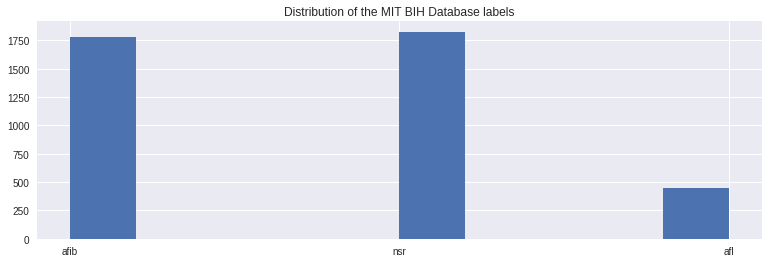

In [ ]:
plt.hist(arhy_labels)
plt.title("Distribution of the MIT BIH Database labels")

In [ ]:
arhy_labels.value_counts()
# 'nsr': 0, 'afib': 1, 'afl':2

nsr     1826
afib    1780
afl      445
Name: label, dtype: Int64

In [ ]:
from sklearn.utils import resample
train=full_data_with_rr.copy()
# Separating the train dataframe into 3 individual ones based on class labels, and sampling 1800 from each.
# train_lbl0 = resample(train[train['label']==0], replace=True, n_samples=1800, random_state=113)
# train_lbl1 = resample(train[train['label']==1], replace=True, n_samples=1800, random_state=113)
# train_lbl2 = resample(train[train['label']==2], replace=True, n_samples=1800, random_state=113)

train_lbl0 = (train[train['label']==0])
train_lbl1 = (train[train['label']==1])
train_lbl2 = (train[train['label']==2])



# Concatenate the 5 dataframes into 1
train = pd.concat([train_lbl2,train_lbl0,train_lbl2, train_lbl1, train_lbl2])
labels = train['label'].astype('int64')   # last column has the labels
print("Count in each label: ")
print(labels.value_counts())

Count in each label: 
0    1826
1    1780
2    1335
Name: label, dtype: int64


In [ ]:
train

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,filename,label
0,0.249,0.184,0.167,0.167,0.206,0.183,0.182,0.209,0.159,0.189,...,0.203,0.184,0.186,0.0,0.0,0.0,0.0,0.0,MUSE_20180112_122850_57000,2
0,0.345,0.487,0.400,0.391,0.359,0.319,0.410,0.432,0.395,0.285,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180712_153037_41000,2
0,0.410,0.341,0.417,0.367,0.419,0.321,0.485,0.345,0.440,0.335,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180114_134540_25000,2
0,0.356,0.282,0.241,0.237,0.300,0.286,0.275,0.312,0.254,0.238,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180712_152550_20000,2
0,0.495,0.291,0.524,0.172,0.183,0.161,0.174,0.442,0.408,0.170,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180111_163519_23000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.594,0.604,0.731,0.589,0.723,0.668,0.590,0.000,0.000,0.000,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180712_153707_38000,2
0,0.283,0.579,0.269,0.223,0.158,0.435,0.206,0.181,0.326,0.304,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180712_153117_86000,2
0,0.223,0.182,0.198,0.214,0.204,0.198,0.199,0.193,0.196,0.197,...,0.219,0.197,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180712_152106_98000,2
0,0.183,0.190,0.159,0.191,0.201,0.206,0.218,0.210,0.186,0.192,...,0.234,0.000,0.000,0.0,0.0,0.0,0.0,0.0,MUSE_20180115_125008_50000,2


In [ ]:
train.to_csv("/content/drive/MyDrive/train_with_rr_30.csv",index=False)
train.to_csv("/content/train_with_rr_30.csv",index=False)

### Start from here. Read Train file which is already saved

In [ ]:
# train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")

In [ ]:
train.drop(columns=['filename'],inplace=True)

In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,0.249,0.184,0.167,0.167,0.206,0.183,0.182,0.209,0.159,0.189,...,0.162,0.203,0.184,0.186,0.0,0.0,0.0,0.0,0.0,2
0,0.345,0.487,0.400,0.391,0.359,0.319,0.410,0.432,0.395,0.285,...,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,2
0,0.410,0.341,0.417,0.367,0.419,0.321,0.485,0.345,0.440,0.335,...,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,2
0,0.356,0.282,0.241,0.237,0.300,0.286,0.275,0.312,0.254,0.238,...,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,2
0,0.495,0.291,0.524,0.172,0.183,0.161,0.174,0.442,0.408,0.170,...,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,2


In [ ]:
full_data_with_rr=train
full_data_with_rr['label'].value_counts()

0    1826
1    1780
2    1335
Name: label, dtype: int64

In [ ]:
full_data_with_rr.drop(columns=['filename'],inplace=True)

KeyError: ignored

max number of RR Intervals is 30, so we will do padding

In [ ]:
# Now stored as  parent_folder+patient_id+"_RRi.csv"

In [ ]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [ ]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
def get_base_model(categories=3):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[30], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 3 else keras.layers.Dense(5, activation='softmax'))                   
  ])

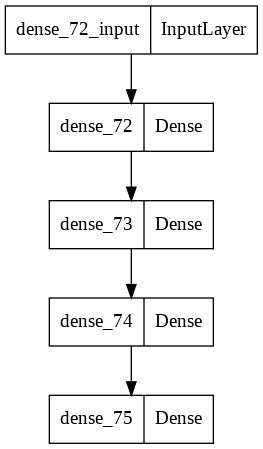

In [ ]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

In [ ]:
# all_subjects= afib_files+ nsr_files + afl_files

# subject_label = {}
# for i in afib_files:
#     subject_label[i] = 1 #'afib'
# for i in nsr_files:
#     subject_label[i] = 0 #'nsr'
# for i in afl_files:
#     subject_label[i] = 2 # afl'

In [ ]:
# all_subjects

In [ ]:
# train_file_names, test_val_files = train_test_split(all_subjects, test_size=0.2, random_state=2)
# test_file_names, val_file_names = train_test_split(test_val_files,test_size=0.5,random_state=3)

In [ ]:
# print(len(train_file_names),len(test_file_names),len(val_file_names))

In [ ]:
# cnt_train={}
# for i in train_file_names:
#   label=subject_label[i]
#   if label in cnt_train:
#       cnt_train[label]+=1
#   else:
#       cnt_train[label]=1
# print("Train:",cnt_train)

# cnt_test={}
# for i in test_file_names:
#   label=subject_label[i]
#   if label in cnt_test:
#       cnt_test[label]+=1
#   else:
#       cnt_test[label]=1
# print("test:",cnt_test)

# cnt_val={}
# for i in val_file_names:
#   label=subject_label[i]
#   if label in cnt_val:
#       cnt_val[label]+=1
#   else:
#       cnt_val[label]=1
# print("val:",cnt_val)

In [ ]:
full_data_with_rr.iloc[:,-1]

0    1
0    1
0    1
0    1
0    1
    ..
0    2
0    2
0    2
0    2
0    2
Name: label, Length: 4051, dtype: int64

In [ ]:
full_data_with_rr['label'].value_counts()

0    1826
1    1780
2     445
Name: label, dtype: int64

In [ ]:
full_data_with_rr

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,0.526,0.460,0.524,0.451,0.483,0.457,0.510,0.444,0.468,0.459,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
0,0.151,0.163,0.364,0.393,0.395,0.376,0.413,0.370,0.413,0.396,...,0.394,0.395,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
0,0.176,0.390,0.396,0.426,0.395,0.359,0.387,0.386,0.387,0.387,...,0.394,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
0,0.161,0.380,0.405,0.404,0.441,0.366,0.437,0.371,0.163,0.218,...,0.453,0.349,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
0,0.459,0.419,0.421,0.420,0.418,0.410,0.463,0.396,0.410,0.450,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.206,0.318,0.320,0.312,0.264,0.415,0.236,0.268,0.255,0.254,...,0.332,0.215,0.255,0.285,0.238,0.235,0.000,0.000,0.000,2
0,0.213,0.176,0.270,0.250,0.307,0.222,0.231,0.228,0.232,0.245,...,0.243,0.291,0.197,0.254,0.247,0.347,0.262,0.000,0.000,2
0,0.272,0.477,0.289,0.297,0.458,0.414,0.345,0.356,0.389,0.313,...,0.312,0.452,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2
0,0.238,0.228,0.236,0.317,0.185,0.228,0.208,0.312,0.265,0.210,...,0.235,0.281,0.213,0.257,0.231,0.295,0.215,0.178,0.197,2


In [ ]:
full_data_with_rr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5306 entries, 0 to 0
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5306 non-null   float64
 1   1       5306 non-null   float64
 2   2       5306 non-null   float64
 3   3       5306 non-null   float64
 4   4       5306 non-null   float64
 5   5       5306 non-null   float64
 6   6       5306 non-null   float64
 7   7       5306 non-null   float64
 8   8       5306 non-null   float64
 9   9       5306 non-null   float64
 10  10      5306 non-null   float64
 11  11      5306 non-null   float64
 12  12      5306 non-null   float64
 13  13      5306 non-null   float64
 14  14      5306 non-null   float64
 15  15      5306 non-null   float64
 16  16      5306 non-null   float64
 17  17      5306 non-null   float64
 18  18      5306 non-null   float64
 19  19      5306 non-null   float64
 20  20      5306 non-null   float64
 21  21      5306 non-null   float64
 22  22 

In [ ]:
#if feature columnss dtype not float run this cell
for i in range(0,30):
  full_data_with_rr[i]=full_data_with_rr[i].astype("float")

In [ ]:
X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values, test_size=0.2, random_state=42)
X_arhy_val, X_arhy_test, y_arhy_val, y_arhy_test  = train_test_split(X_arhy_val, y_arhy_val, test_size=0.5, random_state=42)

print("All features size {}".format(full_data_with_rr.iloc[:,:-1].shape))
print("Train features size {}".format(X_arhy_train.shape))
print("Validation features size {}".format(X_arhy_val.shape))
print("Test features size {}".format(X_arhy_test.shape))

All features size (4941, 30)
Train features size (3952, 30)
Validation features size (494, 30)
Test features size (495, 30)


In [ ]:
X_arhy_train

array([[0.37, 0.5 , 0.24, ..., 0.  , 0.  , 0.  ],
       [0.18, 0.18, 0.29, ..., 0.  , 0.  , 0.  ],
       [0.44, 0.39, 0.42, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.35, 0.29, 0.32, ..., 0.  , 0.  , 0.  ],
       [0.15, 0.41, 0.28, ..., 0.  , 0.  , 0.  ],
       [0.16, 0.47, 0.46, ..., 0.  , 0.  , 0.  ]])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


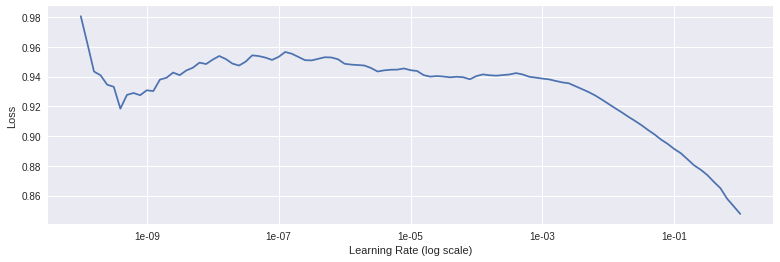

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-10, end_lr= 1, max_steps=100, smoothing=0.2)
_ = model.fit(X_arhy_train, y_arhy_train, batch_size=32, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [ ]:
# Set cyclical learning rate
N = X_arhy_train.shape[0]
batch_size = 32
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-4, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

base_model = get_base_model() 
base_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_arhy_train, y_arhy_train, validation_data=(X_arhy_val, y_arhy_val), 
                         shuffle=True, batch_size=batch_size, epochs=50, callbacks=[save_best_weights])

Epoch 1/50
124/124 [==============================] - 1s 6ms/step - loss: 0.0793 - accuracy: 0.3659 - val_loss: -3.6527 - val_accuracy: 0.3259
Epoch 2/50
124/124 [==============================] - 1s 5ms/step - loss: -456.1757 - accuracy: 0.3659 - val_loss: -3116.5586 - val_accuracy: 0.3259
Epoch 3/50
124/124 [==============================] - 1s 5ms/step - loss: -13320.7031 - accuracy: 0.3659 - val_loss: -35380.3984 - val_accuracy: 0.3259
Epoch 4/50
124/124 [==============================] - 1s 5ms/step - loss: -39234.5586 - accuracy: 0.3659 - val_loss: -56940.5625 - val_accuracy: 0.3259
Epoch 5/50
124/124 [==============================] - 1s 5ms/step - loss: -50747.2305 - accuracy: 0.3659 - val_loss: -77764.5078 - val_accuracy: 0.3259
Epoch 6/50
124/124 [==============================] - 1s 5ms/step - loss: -95049.9922 - accuracy: 0.3659 - val_loss: -190964.2656 - val_accuracy: 0.3259
Epoch 7/50
124/124 [==============================] - 1s 5ms/step - loss: -260875.5156 - accuracy: 

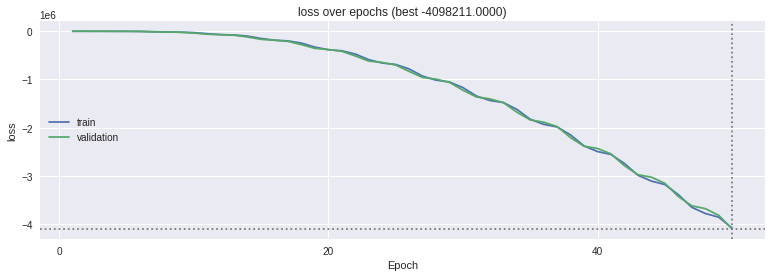

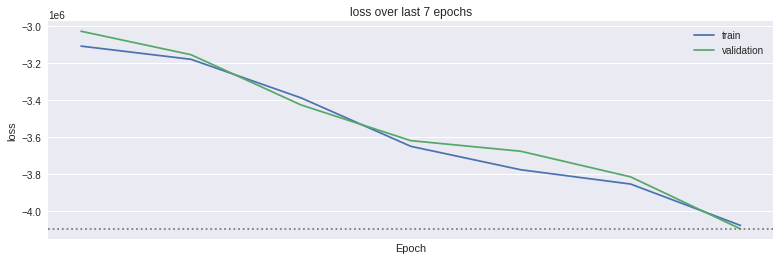

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

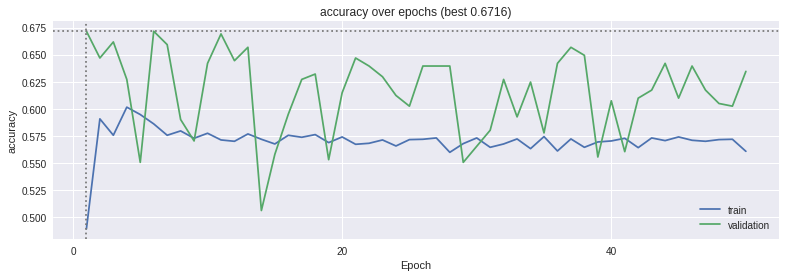

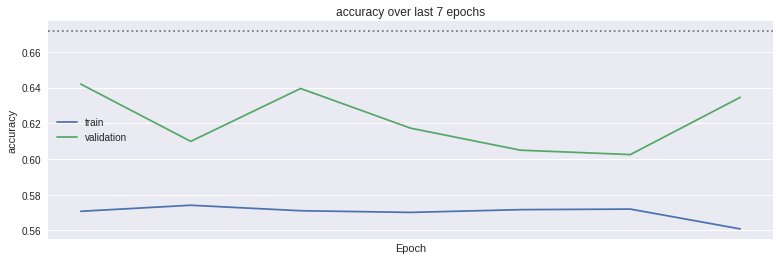

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [ ]:
base_model.load_weights('weights.hdf5')
base_model.evaluate(X_arhy_test, y_arhy_test)

13/13 [==============================] - 0s 3ms/step - loss: -3337826.0000 - accuracy: 0.5665


[-3337826.0, 0.5665024518966675]

Confusion matrix, without normalization
[[105  74   0]
 [ 69 125   0]
 [  5  28   0]]


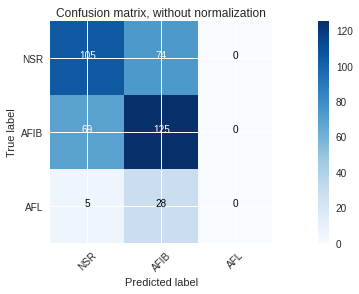

In [ ]:
y_pred = (base_model.predict(X_arhy_test) > 0.5).astype("int32")

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                      title='Confusion matrix, without normalization')

### ResNet Model

In [ ]:
def get_resnet_model(categories=3):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  inputs = keras.layers.Input([30,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [ ]:
X_arhyl_train = np.expand_dims(X_arhy_train, -1)
y_arhyl_train = np.expand_dims(y_arhy_train, -1)

X_arhyl_val = np.expand_dims(X_arhy_val, -1)
y_arhyl_val = np.expand_dims(y_arhy_val, -1)

X_arhyl_test = np.expand_dims(X_arhy_test, -1)
y_arhyl_test = np.expand_dims(y_arhy_test, -1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


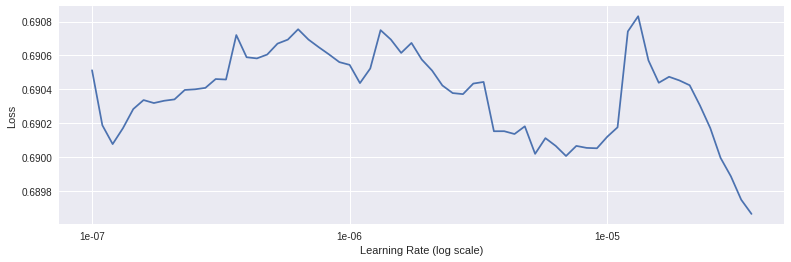

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [ ]:
# Set cyclical learning rate
N = X_arhyl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

Epoch 1/75
26/26 [==============================] - 3s 39ms/step - loss: 0.6783 - accuracy: 0.4321 - val_loss: 0.6526 - val_accuracy: 0.4593
Epoch 2/75
26/26 [==============================] - 0s 17ms/step - loss: 0.6520 - accuracy: 0.4321 - val_loss: 0.6294 - val_accuracy: 0.4593
Epoch 3/75
26/26 [==============================] - 0s 17ms/step - loss: 0.6328 - accuracy: 0.4321 - val_loss: 0.6011 - val_accuracy: 0.4593
Epoch 4/75
26/26 [==============================] - 0s 18ms/step - loss: 0.6145 - accuracy: 0.4321 - val_loss: 0.5915 - val_accuracy: 0.4593
Epoch 5/75
26/26 [==============================] - 0s 17ms/step - loss: 0.6092 - accuracy: 0.4318 - val_loss: 0.5906 - val_accuracy: 0.4642
Epoch 6/75
26/26 [==============================] - 0s 18ms/step - loss: 0.6068 - accuracy: 0.4756 - val_loss: 0.5802 - val_accuracy: 0.5383
Epoch 7/75
26/26 [==============================] - 0s 13ms/step - loss: 0.6073 - accuracy: 0.4991 - val_loss: 0.5911 - val_accuracy: 0.5185
Epoch 8/75
26

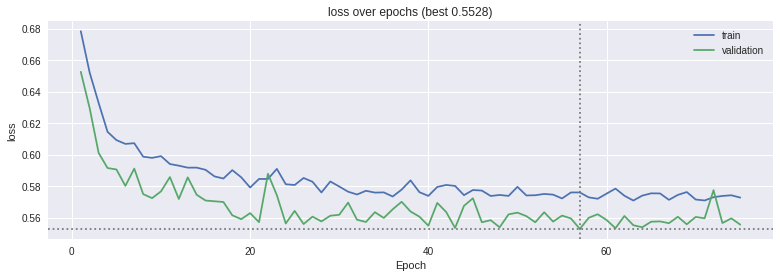

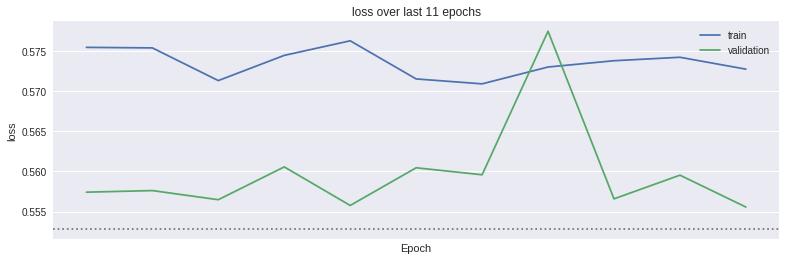

In [ ]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

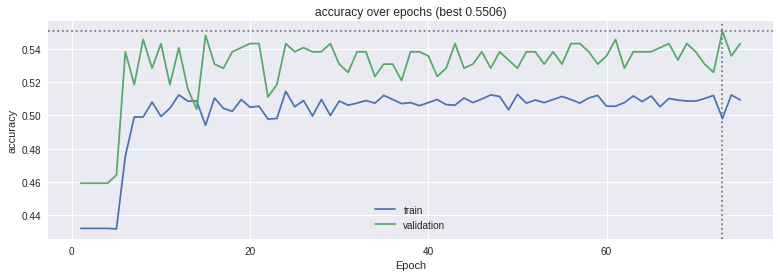

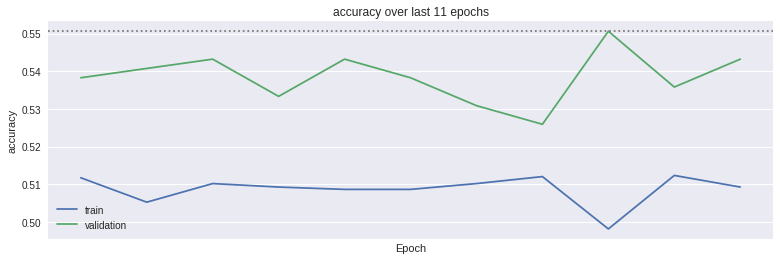

In [ ]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [ ]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_arhyl_test, y_arhyl_test)

13/13 [==============================] - 0s 17ms/step - loss: 0.6401 - accuracy: 0.5222


[0.6400601267814636, 0.5221675038337708]

Confusion matrix, without normalization
[[ 43 136   0]
 [ 25 169   0]
 [  1  32   0]]


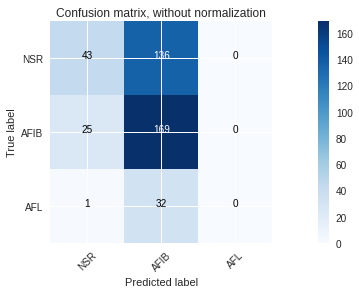

In [ ]:
y_pred = (resnet_model.predict(X_arhyl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                      title='Confusion matrix, without normalization')

## ResNet MIT-BIH replication

In [ ]:
X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(arhy_train.iloc[:,:-1].values, arhy_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_arhy_test = arhy_test.iloc[:,:-1].values
y_arhy_test = arhy_test.iloc[:,-1].values

# The 1D convolutions expect an extra dimension in the input data 
X_arhyl_train = np.expand_dims(X_arhy_train, -1)
y_arhyl_train = np.expand_dims(y_arhy_train, -1)
X_arhyl_val = np.expand_dims(X_arhy_val, -1)
y_arhyl_val = np.expand_dims(y_arhy_val, -1)
X_arhyl_test = np.expand_dims(X_arhy_test, -1)
y_arhyl_test = np.expand_dims(y_arhy_test, -1)

NameError: ignored

In [ ]:
list_labels=[0,1,2]
def get_model():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.4)(img_1)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.4)(img_1)
    
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu)(img_1)
    dense_1 = Dense(1028, activation=activations.relu)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    # opt = optimizers.Adam(0.0025)
    import tensorflow as tf
    opt=tf.optimizers.Adam(0.0025)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model
